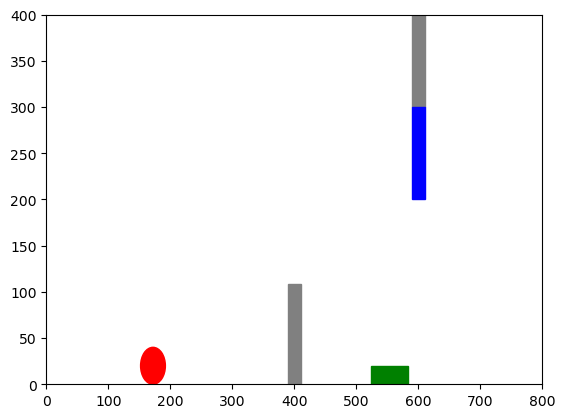

In [35]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        self.initial_bar_height = BAR_HEIGHT
        self.was_holding_ball = False
        
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height
    
    def is_better_position_for_grabbing(self):
        # Check if the bar is getting closer to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_ball < self.previous_distance_to_ball
        
        # Check if extending the bar is beneficial for grabbing the ball
        is_correct_extension = self.extend_bar and self.bar_y - self.bar_height > self.ball_y

        return is_getting_closer or is_correct_extension

    def is_better_position_for_releasing(self):
        # Check if the bar (with the ball) is getting closer to the basket
        current_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_basket < self.previous_distance_to_basket

        # Check if retracting the bar is beneficial for releasing the ball
        # This can be a simple condition based on the bar's position relative to the basket.
        is_correct_retraction = self.shrink_bar and self.ball_x == self.bar_x and self.bar_y - self.bar_height < self.basket_y

        return is_getting_closer or is_correct_retraction
    
    def step(self, action):
        # Handle actions
        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing

        # Update the was_holding_ball status
        if action == 4:  # Grab/Release action
            self.was_holding_ball = self.is_grabbing

        # Update game state
        self.update_game_state()

        # Calculate reward, check if game is done
        reward = self.calculate_reward()
        done = self.is_game_done()

        # Observation
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        # Update the previous distances after updating the game state
        self.previous_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        self.previous_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Increment step count
        self.current_step += 1

        return obs, reward, done, {}



    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.initial_bar_height = self.bar_height
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)
    

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground
                
    def is_directly_above_basket(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the basket's position
            return abs(self.bar_x - self.basket_x) < threshold and self.bar_y - self.bar_height < self.basket_y + BASKET_HEIGHT / 2        
        
    def is_ball_in_basket(self):
        # Check if the ball is within the horizontal boundaries of the basket
        ball_in_basket_horizontally = (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2) and \
                                      (self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2)

        # Check if the ball is within the vertical boundaries of the basket
        ball_in_basket_vertically = (self.ball_y - BALL_RADIUS < self.basket_y + BASKET_HEIGHT / 2) and \
                                    (self.ball_y + BALL_RADIUS > self.basket_y - BASKET_HEIGHT / 2)

        # The ball is in the basket if it's within both horizontal and vertical boundaries
        return ball_in_basket_horizontally and ball_in_basket_vertically
    def is_directly_above_ball(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the ball's position
            return abs(self.bar_x - self.ball_x) < threshold and self.ball_y < self.bar_y - self.bar_height
        
    def calculate_reward(self):
        # Initialize reward
        action_penalty = -0.05
        reward = 0
        reward += action_penalty
        # Calculate the distance to the ball and to the basket
        distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Reward/Penalty for moving closer/away from the ball
        if distance_to_ball < self.previous_distance_to_ball:
            reward += 1
        else:
            reward -= 0.5

        # Additional reward for successfully grabbing the ball
        #if self.is_grabbing and self.is_directly_above_ball():
        #    reward += 5

        # Reward for successfully dropping the ball in the basket
        if self.is_ball_in_basket() and not self.is_grabbing:
            reward += 1000

        # Reward for dropping the ball closer to the basket
        if not self.is_grabbing and self.was_holding_ball:
            # Calculate the distance from the basket
            distance_from_basket = np.linalg.norm([self.basket_x - self.ball_x, self.basket_y - self.ball_y])

            # Apply a reward based on the distance - closer gets more reward
            reward += max(0, 10 - distance_from_basket)  # Adjust as needed

            # Reset was_holding_ball after the ball is released
            self.was_holding_ball = False
        # Update the was_holding_ball status
        if not self.is_grabbing:
            self.was_holding_ball = False
        
        # Update the previous distances for the next step
        self.previous_distance_to_ball = distance_to_ball
        self.previous_distance_to_basket = distance_to_basket
        
        # Penalty for unnecessary extension/retraction
        #if self.extend_bar or self.shrink_bar:
            # Check if the crane is directly above the ball or directly above the basket while holding the ball
        #    directly_above_ball = self.is_directly_above_ball()
        #    directly_above_basket_while_holding = self.is_grabbing and self.is_directly_above_basket()

            # Apply penalty if not directly above the ball and not directly above basket while holding the ball
         #   if not directly_above_ball and not directly_above_basket_while_holding:
         #       reward -= 0.2  # Define this penalty value as needed

        return reward



    def is_game_done(self):
        max_score = 50
        max_steps = 1000
        ball_in_basket = self.is_ball_in_basket()
        return self.score >= max_score or self.current_step >= max_steps or ball_in_basket


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

Episode: 1/5000000, Total Reward: 6.000000000000016
Episode: 2/5000000, Total Reward: 26.999999999999936
Episode: 3/5000000, Total Reward: 25.499999999999932
Episode: 4/5000000, Total Reward: 32.99999999999999
Episode: 5/5000000, Total Reward: 23.999999999999947
Episode: 6/5000000, Total Reward: 48.0000000000002
Episode: 7/5000000, Total Reward: 34.49999999999997
Episode: 8/5000000, Total Reward: 13.49999999999995
Episode: 9/5000000, Total Reward: 17.999999999999947
Episode: 10/5000000, Total Reward: 34.50000000000005
Episode: 11/5000000, Total Reward: 29.999999999999922
Episode: 12/5000000, Total Reward: 10.500000000000007
Episode: 13/5000000, Total Reward: 22.499999999999932
Episode: 14/5000000, Total Reward: 23.999999999999947
Episode: 15/5000000, Total Reward: 26.999999999999932
Episode: 16/5000000, Total Reward: 43.50000000000014
Episode: 17/5000000, Total Reward: 34.49999999999999
Episode: 18/5000000, Total Reward: 37.50000000000004
Episode: 19/5000000, Total Reward: 23.999999999

Episode: 156/5000000, Total Reward: 31.499999999999947
Episode: 157/5000000, Total Reward: 51.00000000000026
Episode: 158/5000000, Total Reward: 45.000000000000135
Episode: 159/5000000, Total Reward: 40.500000000000036
Episode: 160/5000000, Total Reward: 57.00000000000016
Episode: 161/5000000, Total Reward: 48.00000000000015
Episode: 162/5000000, Total Reward: -3.000000000000031
Episode: 163/5000000, Total Reward: 34.499999999999986
Episode: 164/5000000, Total Reward: 46.50000000000003
Episode: 165/5000000, Total Reward: 34.5
Episode: 166/5000000, Total Reward: 70.50000000000023
Episode: 167/5000000, Total Reward: 54.000000000000185
Episode: 168/5000000, Total Reward: 60.000000000000185
Episode: 169/5000000, Total Reward: 26.999999999999936
Episode: 170/5000000, Total Reward: 43.50000000000002
Episode: 171/5000000, Total Reward: 43.500000000000064
Episode: 172/5000000, Total Reward: 43.499999999999964
Episode: 173/5000000, Total Reward: 75.00000000000024
Episode: 174/5000000, Total Rew

Episode: 307/5000000, Total Reward: -38.99999999999993
Episode: 308/5000000, Total Reward: 49.500000000000185
Episode: 309/5000000, Total Reward: 54.00000000000027
Episode: 310/5000000, Total Reward: 46.5000000000001
Episode: 311/5000000, Total Reward: 16.499999999999964
Episode: 312/5000000, Total Reward: 17.99999999999993
Episode: 313/5000000, Total Reward: 23.999999999999925
Episode: 314/5000000, Total Reward: 45.00000000000005
Episode: 315/5000000, Total Reward: 39.00000000000009
Episode: 316/5000000, Total Reward: 66.0000000000003
Episode: 317/5000000, Total Reward: 97.50000000000026
Episode: 318/5000000, Total Reward: 58.50000000000017
Episode: 319/5000000, Total Reward: 5.999999999999968
Episode: 320/5000000, Total Reward: -32.99999999999991
Episode: 321/5000000, Total Reward: 40.500000000000234
Episode: 322/5000000, Total Reward: 34.50000000000002
Episode: 323/5000000, Total Reward: 54.000000000000256
Episode: 324/5000000, Total Reward: 42.000000000000014
Episode: 325/5000000, 

Episode: 458/5000000, Total Reward: 33.00000000000015
Episode: 459/5000000, Total Reward: 23.999999999999975
Episode: 460/5000000, Total Reward: 60.00000000000031
Episode: 461/5000000, Total Reward: 85.50000000000023
Episode: 462/5000000, Total Reward: 76.5000000000003
Episode: 463/5000000, Total Reward: 67.50000000000007
Episode: 464/5000000, Total Reward: 69.00000000000013
Episode: 465/5000000, Total Reward: 51.000000000000306
Episode: 466/5000000, Total Reward: 45.00000000000024
Episode: 467/5000000, Total Reward: 12.000000000000057
Episode: 468/5000000, Total Reward: 39.0000000000001
Episode: 469/5000000, Total Reward: 31.50000000000003
Episode: 470/5000000, Total Reward: 64.50000000000028
Episode: 471/5000000, Total Reward: -55.499999999999844
Episode: 472/5000000, Total Reward: 58.50000000000021
Episode: 473/5000000, Total Reward: 85.50000000000024
Episode: 474/5000000, Total Reward: 37.500000000000185
Episode: 475/5000000, Total Reward: 40.50000000000012
Episode: 476/5000000, To

Episode: 608/5000000, Total Reward: 22.499999999999957
Episode: 609/5000000, Total Reward: -64.49999999999977
Episode: 610/5000000, Total Reward: 49.50000000000022
Episode: 611/5000000, Total Reward: 37.50000000000031
Episode: 612/5000000, Total Reward: 18.00000000000001
Episode: 613/5000000, Total Reward: 64.50000000000031
Episode: 614/5000000, Total Reward: -80.99999999999977
Episode: 615/5000000, Total Reward: 49.50000000000022
Episode: 616/5000000, Total Reward: 96.00000000000031
Episode: 617/5000000, Total Reward: 57.000000000000284
Episode: 618/5000000, Total Reward: 79.50000000000027
Episode: 619/5000000, Total Reward: 8.999999999999975
Episode: 620/5000000, Total Reward: -79.49999999999977
Episode: 621/5000000, Total Reward: 84.00000000000031
Episode: 622/5000000, Total Reward: -34.499999999999865
Episode: 623/5000000, Total Reward: 58.50000000000027
Episode: 624/5000000, Total Reward: -29.99999999999989
Episode: 625/5000000, Total Reward: 43.50000000000031
Episode: 626/5000000

Episode: 759/5000000, Total Reward: 39.0
Episode: 760/5000000, Total Reward: 42.00000000000031
Episode: 761/5000000, Total Reward: 58.50000000000023
Episode: 762/5000000, Total Reward: -64.49999999999977
Episode: 763/5000000, Total Reward: 52.50000000000031
Episode: 764/5000000, Total Reward: 52.50000000000031
Episode: 765/5000000, Total Reward: 76.50000000000031
Episode: 766/5000000, Total Reward: -80.99999999999977
Episode: 767/5000000, Total Reward: 81.00000000000031
Episode: 768/5000000, Total Reward: 84.00000000000031
Episode: 769/5000000, Total Reward: 58.50000000000021
Episode: 770/5000000, Total Reward: -16.49999999999987
Episode: 771/5000000, Total Reward: 57.00000000000031
Episode: 772/5000000, Total Reward: 55.5000000000003
Episode: 773/5000000, Total Reward: 51.000000000000306
Episode: 774/5000000, Total Reward: 22.499999999999922
Episode: 775/5000000, Total Reward: 55.500000000000185
Episode: 776/5000000, Total Reward: 66.00000000000023
Episode: 777/5000000, Total Reward: 

Episode: 909/5000000, Total Reward: -80.99999999999977
Episode: 910/5000000, Total Reward: 55.50000000000031
Episode: 911/5000000, Total Reward: -80.99999999999977
Episode: 912/5000000, Total Reward: -80.99999999999977
Episode: 913/5000000, Total Reward: 49.500000000000284
Episode: 914/5000000, Total Reward: -80.99999999999977
Episode: 915/5000000, Total Reward: -80.99999999999977
Episode: 916/5000000, Total Reward: 84.00000000000031
Episode: 917/5000000, Total Reward: 52.50000000000031
Episode: 918/5000000, Total Reward: -79.49999999999977
Episode: 919/5000000, Total Reward: 54.00000000000031
Episode: 920/5000000, Total Reward: -61.49999999999977
Episode: 921/5000000, Total Reward: 91.5000000000003
Episode: 922/5000000, Total Reward: -80.99999999999977
Episode: 923/5000000, Total Reward: 49.50000000000031
Episode: 924/5000000, Total Reward: 55.50000000000031
Episode: 925/5000000, Total Reward: 55.50000000000031
Episode: 926/5000000, Total Reward: -80.99999999999977
Episode: 927/500000

Episode: 1059/5000000, Total Reward: 78.00000000000031
Episode: 1060/5000000, Total Reward: 10.49999999999995
Episode: 1061/5000000, Total Reward: 82.50000000000031
Episode: 1062/5000000, Total Reward: 78.00000000000031
Episode: 1063/5000000, Total Reward: -80.99999999999977
Episode: 1064/5000000, Total Reward: 24.00000000000011
Episode: 1065/5000000, Total Reward: 69.00000000000031
Episode: 1066/5000000, Total Reward: -22.499999999999957
Episode: 1067/5000000, Total Reward: 4.500000000000086
Episode: 1068/5000000, Total Reward: 84.00000000000031
Episode: 1069/5000000, Total Reward: 75.00000000000031
Episode: 1070/5000000, Total Reward: -10.500000000000028
Episode: 1071/5000000, Total Reward: -80.99999999999977
Episode: 1072/5000000, Total Reward: 87.00000000000031
Episode: 1073/5000000, Total Reward: 90.00000000000027
Episode: 1074/5000000, Total Reward: 64.50000000000031
Episode: 1075/5000000, Total Reward: 57.00000000000031
Episode: 1076/5000000, Total Reward: 66.00000000000031
Epis

Episode: 1207/5000000, Total Reward: -76.4999999999998
Episode: 1208/5000000, Total Reward: 49.50000000000031
Episode: 1209/5000000, Total Reward: 39.000000000000064
Episode: 1210/5000000, Total Reward: 81.00000000000031
Episode: 1211/5000000, Total Reward: 67.50000000000031
Episode: 1212/5000000, Total Reward: 58.5000000000003
Episode: 1213/5000000, Total Reward: 94.50000000000031
Episode: 1214/5000000, Total Reward: -70.49999999999977
Episode: 1215/5000000, Total Reward: 51.00000000000022
Episode: 1216/5000000, Total Reward: -79.49999999999977
Episode: 1217/5000000, Total Reward: -80.99999999999977
Episode: 1218/5000000, Total Reward: -3.0000000000000613
Episode: 1219/5000000, Total Reward: -22.49999999999999
Episode: 1220/5000000, Total Reward: 82.50000000000031
Episode: 1221/5000000, Total Reward: -80.99999999999977
Episode: 1222/5000000, Total Reward: 54.0000000000003
Episode: 1223/5000000, Total Reward: 46.500000000000036
Episode: 1224/5000000, Total Reward: -80.99999999999977
Ep

Episode: 1355/5000000, Total Reward: 51.00000000000031
Episode: 1356/5000000, Total Reward: -5.999999999999884
Episode: 1357/5000000, Total Reward: 66.00000000000031
Episode: 1358/5000000, Total Reward: 66.00000000000027
Episode: 1359/5000000, Total Reward: 9.000000000000014
Episode: 1360/5000000, Total Reward: 79.50000000000031
Episode: 1361/5000000, Total Reward: 57.00000000000031
Episode: 1362/5000000, Total Reward: -25.4999999999999
Episode: 1363/5000000, Total Reward: 91.50000000000031
Episode: 1364/5000000, Total Reward: -80.99999999999977
Episode: 1365/5000000, Total Reward: -80.99999999999977
Episode: 1366/5000000, Total Reward: -80.99999999999977
Episode: 1367/5000000, Total Reward: 99.00000000000031
Episode: 1368/5000000, Total Reward: -20.999999999999822
Episode: 1369/5000000, Total Reward: 54.00000000000023
Episode: 1370/5000000, Total Reward: 30.00000000000002
Episode: 1371/5000000, Total Reward: -80.99999999999977
Episode: 1372/5000000, Total Reward: -80.99999999999977
Ep

Episode: 1503/5000000, Total Reward: 64.50000000000023
Episode: 1504/5000000, Total Reward: 52.50000000000019
Episode: 1505/5000000, Total Reward: 46.500000000000185
Episode: 1506/5000000, Total Reward: -80.99999999999977
Episode: 1507/5000000, Total Reward: 44.99999999999998
Episode: 1508/5000000, Total Reward: 54.0000000000003
Episode: 1509/5000000, Total Reward: -80.99999999999977
Episode: 1510/5000000, Total Reward: -80.99999999999977
Episode: 1511/5000000, Total Reward: 46.500000000000206
Episode: 1512/5000000, Total Reward: 76.5000000000003
Episode: 1513/5000000, Total Reward: -2.9999999999998774
Episode: 1514/5000000, Total Reward: 82.50000000000031
Episode: 1515/5000000, Total Reward: 54.000000000000284
Episode: 1516/5000000, Total Reward: -61.49999999999977
Episode: 1517/5000000, Total Reward: 63.00000000000029
Episode: 1518/5000000, Total Reward: 75.00000000000031
Episode: 1519/5000000, Total Reward: -80.99999999999977
Episode: 1520/5000000, Total Reward: 78.00000000000031
Ep

Episode: 1651/5000000, Total Reward: -80.99999999999977
Episode: 1652/5000000, Total Reward: 5.861977570020827e-14
Episode: 1653/5000000, Total Reward: 72.00000000000028
Episode: 1654/5000000, Total Reward: 69.00000000000031
Episode: 1655/5000000, Total Reward: 66.00000000000031
Episode: 1656/5000000, Total Reward: -80.99999999999977
Episode: 1657/5000000, Total Reward: 60.0000000000003
Episode: 1658/5000000, Total Reward: -80.99999999999977
Episode: 1659/5000000, Total Reward: -28.49999999999992
Episode: 1660/5000000, Total Reward: -80.99999999999977
Episode: 1661/5000000, Total Reward: 63.0000000000003
Episode: 1662/5000000, Total Reward: 61.50000000000023
Episode: 1663/5000000, Total Reward: 90.0000000000002
Episode: 1664/5000000, Total Reward: 31.500000000000032
Episode: 1665/5000000, Total Reward: -49.49999999999977
Episode: 1666/5000000, Total Reward: 52.50000000000031
Episode: 1667/5000000, Total Reward: -80.99999999999977
Episode: 1668/5000000, Total Reward: 9.000000000000064
E

Episode: 1799/5000000, Total Reward: 49.50000000000018
Episode: 1800/5000000, Total Reward: 37.50000000000005
Saved model at episode 1800
Episode: 1801/5000000, Total Reward: 78.00000000000031
Episode: 1802/5000000, Total Reward: -79.49999999999977
Episode: 1803/5000000, Total Reward: 30.00000000000029
Episode: 1804/5000000, Total Reward: -7.499999999999864
Episode: 1805/5000000, Total Reward: -80.99999999999977
Episode: 1806/5000000, Total Reward: 9.000000000000163
Episode: 1807/5000000, Total Reward: 45.00000000000031
Episode: 1808/5000000, Total Reward: -79.49999999999977
Episode: 1809/5000000, Total Reward: 75.00000000000031
Episode: 1810/5000000, Total Reward: 30.0000000000003
Episode: 1811/5000000, Total Reward: -80.99999999999977
Episode: 1812/5000000, Total Reward: 70.50000000000031
Episode: 1813/5000000, Total Reward: 57.00000000000031
Episode: 1814/5000000, Total Reward: -79.49999999999979
Episode: 1815/5000000, Total Reward: 52.50000000000031
Episode: 1816/5000000, Total Rew

Episode: 1946/5000000, Total Reward: 52.50000000000031
Episode: 1947/5000000, Total Reward: 91.50000000000031
Episode: 1948/5000000, Total Reward: -80.99999999999977
Episode: 1949/5000000, Total Reward: 61.50000000000031
Episode: 1950/5000000, Total Reward: -1.5000000000000617
Episode: 1951/5000000, Total Reward: -77.9999999999998
Episode: 1952/5000000, Total Reward: 69.00000000000031
Episode: 1953/5000000, Total Reward: 34.499999999999986
Episode: 1954/5000000, Total Reward: 90.00000000000031
Episode: 1955/5000000, Total Reward: -65.99999999999977
Episode: 1956/5000000, Total Reward: -80.99999999999977
Episode: 1957/5000000, Total Reward: 17.999999999999922
Episode: 1958/5000000, Total Reward: 87.00000000000031
Episode: 1959/5000000, Total Reward: 54.00000000000031
Episode: 1960/5000000, Total Reward: 81.00000000000031
Episode: 1961/5000000, Total Reward: 84.00000000000031
Episode: 1962/5000000, Total Reward: -80.99999999999977
Episode: 1963/5000000, Total Reward: 72.00000000000031
Ep

Episode: 2094/5000000, Total Reward: -80.99999999999977
Episode: 2095/5000000, Total Reward: 72.00000000000031
Episode: 2096/5000000, Total Reward: 58.50000000000031
Episode: 2097/5000000, Total Reward: 93.00000000000031
Episode: 2098/5000000, Total Reward: 69.00000000000031
Episode: 2099/5000000, Total Reward: 52.500000000000284
Episode: 2100/5000000, Total Reward: 49.50000000000031
Saved model at episode 2100
Episode: 2101/5000000, Total Reward: -80.99999999999977
Episode: 2102/5000000, Total Reward: 57.00000000000031
Episode: 2103/5000000, Total Reward: 93.00000000000031
Episode: 2104/5000000, Total Reward: -80.99999999999977
Episode: 2105/5000000, Total Reward: 45.0
Episode: 2106/5000000, Total Reward: -80.99999999999977
Episode: 2107/5000000, Total Reward: -80.99999999999977
Episode: 2108/5000000, Total Reward: 51.00000000000017
Episode: 2109/5000000, Total Reward: 84.00000000000024
Episode: 2110/5000000, Total Reward: -80.99999999999977
Episode: 2111/5000000, Total Reward: -80.99

Episode: 2242/5000000, Total Reward: -80.99999999999977
Episode: 2243/5000000, Total Reward: -79.49999999999977
Episode: 2244/5000000, Total Reward: 54.00000000000031
Episode: 2245/5000000, Total Reward: 66.00000000000031
Episode: 2246/5000000, Total Reward: 55.5000000000003
Episode: 2247/5000000, Total Reward: 96.00000000000031
Episode: 2248/5000000, Total Reward: -80.99999999999977
Episode: 2249/5000000, Total Reward: 70.50000000000031
Episode: 2250/5000000, Total Reward: 66.00000000000021
Episode: 2251/5000000, Total Reward: 78.00000000000031
Episode: 2252/5000000, Total Reward: -61.49999999999977
Episode: 2253/5000000, Total Reward: 55.50000000000031
Episode: 2254/5000000, Total Reward: -80.99999999999977
Episode: 2255/5000000, Total Reward: 58.50000000000027
Episode: 2256/5000000, Total Reward: -79.49999999999979
Episode: 2257/5000000, Total Reward: 73.50000000000031
Episode: 2258/5000000, Total Reward: 61.50000000000031
Episode: 2259/5000000, Total Reward: 54.00000000000029
Episo

Episode: 2390/5000000, Total Reward: -80.99999999999977
Episode: 2391/5000000, Total Reward: 55.50000000000031
Episode: 2392/5000000, Total Reward: 67.50000000000031
Episode: 2393/5000000, Total Reward: -80.99999999999977
Episode: 2394/5000000, Total Reward: 88.50000000000031
Episode: 2395/5000000, Total Reward: -80.99999999999977
Episode: 2396/5000000, Total Reward: -77.9999999999998
Episode: 2397/5000000, Total Reward: -31.499999999999776
Episode: 2398/5000000, Total Reward: 90.00000000000031
Episode: 2399/5000000, Total Reward: -40.49999999999977
Episode: 2400/5000000, Total Reward: 51.00000000000031
Saved model at episode 2400
Episode: 2401/5000000, Total Reward: -80.99999999999977
Episode: 2402/5000000, Total Reward: -80.99999999999977
Episode: 2403/5000000, Total Reward: -79.49999999999979
Episode: 2404/5000000, Total Reward: 93.00000000000031
Episode: 2405/5000000, Total Reward: 46.500000000000284
Episode: 2406/5000000, Total Reward: -80.99999999999977
Episode: 2407/5000000, Tot

Episode: 2538/5000000, Total Reward: 75.00000000000031
Episode: 2539/5000000, Total Reward: -80.99999999999977
Episode: 2540/5000000, Total Reward: 55.50000000000031
Episode: 2541/5000000, Total Reward: -80.99999999999977
Episode: 2542/5000000, Total Reward: -79.49999999999979
Episode: 2543/5000000, Total Reward: -37.49999999999977
Episode: 2544/5000000, Total Reward: 76.50000000000023
Episode: 2545/5000000, Total Reward: -79.49999999999977
Episode: 2546/5000000, Total Reward: -16.499999999999833
Episode: 2547/5000000, Total Reward: -73.49999999999979
Episode: 2548/5000000, Total Reward: 55.5000000000003
Episode: 2549/5000000, Total Reward: 61.50000000000031
Episode: 2550/5000000, Total Reward: -80.99999999999977
Episode: 2551/5000000, Total Reward: 51.00000000000031
Episode: 2552/5000000, Total Reward: -80.99999999999977
Episode: 2553/5000000, Total Reward: -27.00000000000002
Episode: 2554/5000000, Total Reward: 52.50000000000031
Episode: 2555/5000000, Total Reward: 39.00000000000002


Episode: 2686/5000000, Total Reward: 72.00000000000031
Episode: 2687/5000000, Total Reward: 40.50000000000031
Episode: 2688/5000000, Total Reward: 54.00000000000031
Episode: 2689/5000000, Total Reward: 87.00000000000031
Episode: 2690/5000000, Total Reward: -80.99999999999977
Episode: 2691/5000000, Total Reward: 63.00000000000023
Episode: 2692/5000000, Total Reward: 55.50000000000031
Episode: 2693/5000000, Total Reward: 39.00000000000017
Episode: 2694/5000000, Total Reward: 91.50000000000031
Episode: 2695/5000000, Total Reward: -4.499999999999872
Episode: 2696/5000000, Total Reward: -80.99999999999977
Episode: 2697/5000000, Total Reward: 57.00000000000031
Episode: 2698/5000000, Total Reward: 19.49999999999994
Episode: 2699/5000000, Total Reward: -80.99999999999977
Episode: 2700/5000000, Total Reward: -79.49999999999977
Saved model at episode 2700
Episode: 2701/5000000, Total Reward: 78.0000000000003
Episode: 2702/5000000, Total Reward: 67.50000000000031
Episode: 2703/5000000, Total Rewa

Episode: 2833/5000000, Total Reward: 54.00000000000031
Episode: 2834/5000000, Total Reward: 2.999999999999994
Episode: 2835/5000000, Total Reward: 72.00000000000026
Episode: 2836/5000000, Total Reward: 46.50000000000031
Episode: 2837/5000000, Total Reward: 46.50000000000016
Episode: 2838/5000000, Total Reward: 52.50000000000031
Episode: 2839/5000000, Total Reward: -80.99999999999977
Episode: 2840/5000000, Total Reward: -80.99999999999977
Episode: 2841/5000000, Total Reward: -77.99999999999977
Episode: 2842/5000000, Total Reward: 51.00000000000031
Episode: 2843/5000000, Total Reward: -80.99999999999977
Episode: 2844/5000000, Total Reward: -55.49999999999977
Episode: 2845/5000000, Total Reward: 57.00000000000031
Episode: 2846/5000000, Total Reward: -79.49999999999977
Episode: 2847/5000000, Total Reward: 37.50000000000016
Episode: 2848/5000000, Total Reward: 97.50000000000028
Episode: 2849/5000000, Total Reward: 46.500000000000185
Episode: 2850/5000000, Total Reward: -77.99999999999979
Ep

Episode: 2981/5000000, Total Reward: -80.99999999999977
Episode: 2982/5000000, Total Reward: -52.499999999999936
Episode: 2983/5000000, Total Reward: 49.50000000000031
Episode: 2984/5000000, Total Reward: -80.99999999999977
Episode: 2985/5000000, Total Reward: 55.50000000000031
Episode: 2986/5000000, Total Reward: 66.00000000000031
Episode: 2987/5000000, Total Reward: -7.499999999999864
Episode: 2988/5000000, Total Reward: 70.50000000000031
Episode: 2989/5000000, Total Reward: 72.0000000000003
Episode: 2990/5000000, Total Reward: 78.00000000000031
Episode: 2991/5000000, Total Reward: -74.99999999999977
Episode: 2992/5000000, Total Reward: 88.50000000000031
Episode: 2993/5000000, Total Reward: -80.99999999999977
Episode: 2994/5000000, Total Reward: -3.000000000000081
Episode: 2995/5000000, Total Reward: 52.50000000000017
Episode: 2996/5000000, Total Reward: 46.50000000000031
Episode: 2997/5000000, Total Reward: 82.5000000000003
Episode: 2998/5000000, Total Reward: 51.00000000000031
Epis

Episode: 3129/5000000, Total Reward: 90.00000000000031
Episode: 3130/5000000, Total Reward: -80.99999999999977
Episode: 3131/5000000, Total Reward: 58.50000000000023
Episode: 3132/5000000, Total Reward: -80.99999999999977
Episode: 3133/5000000, Total Reward: 55.50000000000031
Episode: 3134/5000000, Total Reward: 49.5000000000003
Episode: 3135/5000000, Total Reward: 54.0000000000002
Episode: 3136/5000000, Total Reward: 82.50000000000031
Episode: 3137/5000000, Total Reward: -77.99999999999977
Episode: 3138/5000000, Total Reward: 12.0
Episode: 3139/5000000, Total Reward: -65.99999999999977
Episode: 3140/5000000, Total Reward: -80.99999999999977
Episode: 3141/5000000, Total Reward: 48.00000000000031
Episode: 3142/5000000, Total Reward: -80.99999999999977
Episode: 3143/5000000, Total Reward: -38.99999999999977
Episode: 3144/5000000, Total Reward: 73.50000000000024
Episode: 3145/5000000, Total Reward: 76.50000000000024
Episode: 3146/5000000, Total Reward: 78.0000000000003
Episode: 3147/50000

Episode: 3277/5000000, Total Reward: 61.50000000000031
Episode: 3278/5000000, Total Reward: 84.00000000000031
Episode: 3279/5000000, Total Reward: 76.50000000000031
Episode: 3280/5000000, Total Reward: 12.000000000000181
Episode: 3281/5000000, Total Reward: -80.99999999999977
Episode: 3282/5000000, Total Reward: 63.00000000000023
Episode: 3283/5000000, Total Reward: 64.50000000000031
Episode: 3284/5000000, Total Reward: -80.99999999999977
Episode: 3285/5000000, Total Reward: -80.99999999999977
Episode: 3286/5000000, Total Reward: 69.00000000000027
Episode: 3287/5000000, Total Reward: 72.00000000000031
Episode: 3288/5000000, Total Reward: -79.49999999999977
Episode: 3289/5000000, Total Reward: -80.99999999999977
Episode: 3290/5000000, Total Reward: 64.50000000000031
Episode: 3291/5000000, Total Reward: 84.00000000000031
Episode: 3292/5000000, Total Reward: 94.50000000000031
Episode: 3293/5000000, Total Reward: -80.99999999999977
Episode: 3294/5000000, Total Reward: 26.999999999999975
Ep

Episode: 3424/5000000, Total Reward: 69.00000000000031
Episode: 3425/5000000, Total Reward: 61.50000000000031
Episode: 3426/5000000, Total Reward: 70.50000000000017
Episode: 3427/5000000, Total Reward: -80.99999999999977
Episode: 3428/5000000, Total Reward: 52.50000000000031
Episode: 3429/5000000, Total Reward: 14.999999999999922
Episode: 3430/5000000, Total Reward: 1.1390888232654106e-13
Episode: 3431/5000000, Total Reward: -79.49999999999977
Episode: 3432/5000000, Total Reward: 69.00000000000031
Episode: 3433/5000000, Total Reward: 49.50000000000017
Episode: 3434/5000000, Total Reward: 30.000000000000142
Episode: 3435/5000000, Total Reward: 54.00000000000031
Episode: 3436/5000000, Total Reward: 39.000000000000156
Episode: 3437/5000000, Total Reward: -80.99999999999977
Episode: 3438/5000000, Total Reward: 54.0000000000003
Episode: 3439/5000000, Total Reward: 52.50000000000031
Episode: 3440/5000000, Total Reward: -34.49999999999977
Episode: 3441/5000000, Total Reward: -80.9999999999997

Episode: 3572/5000000, Total Reward: -80.99999999999977
Episode: 3573/5000000, Total Reward: 49.50000000000031
Episode: 3574/5000000, Total Reward: -80.99999999999977
Episode: 3575/5000000, Total Reward: 70.50000000000031
Episode: 3576/5000000, Total Reward: -80.99999999999977
Episode: 3577/5000000, Total Reward: -80.99999999999977
Episode: 3578/5000000, Total Reward: 67.50000000000026
Episode: 3579/5000000, Total Reward: 7.500000000000104
Episode: 3580/5000000, Total Reward: 52.50000000000031
Episode: 3581/5000000, Total Reward: -80.99999999999977
Episode: 3582/5000000, Total Reward: 61.50000000000031
Episode: 3583/5000000, Total Reward: -80.99999999999977
Episode: 3584/5000000, Total Reward: -77.99999999999977
Episode: 3585/5000000, Total Reward: 75.00000000000026
Episode: 3586/5000000, Total Reward: 69.00000000000031
Episode: 3587/5000000, Total Reward: 10.50000000000017
Episode: 3588/5000000, Total Reward: 54.00000000000031
Episode: 3589/5000000, Total Reward: -80.99999999999977
Ep

Episode: 3720/5000000, Total Reward: -47.99999999999977
Episode: 3721/5000000, Total Reward: -80.99999999999977
Episode: 3722/5000000, Total Reward: -80.99999999999977
Episode: 3723/5000000, Total Reward: -80.99999999999977
Episode: 3724/5000000, Total Reward: -23.99999999999989
Episode: 3725/5000000, Total Reward: -23.99999999999982
Episode: 3726/5000000, Total Reward: 46.50000000000016
Episode: 3727/5000000, Total Reward: -79.49999999999979
Episode: 3728/5000000, Total Reward: -80.99999999999977
Episode: 3729/5000000, Total Reward: 46.50000000000031
Episode: 3730/5000000, Total Reward: 70.50000000000031
Episode: 3731/5000000, Total Reward: -80.99999999999977
Episode: 3732/5000000, Total Reward: 70.50000000000031
Episode: 3733/5000000, Total Reward: 90.00000000000031
Episode: 3734/5000000, Total Reward: -80.99999999999977
Episode: 3735/5000000, Total Reward: -77.99999999999977
Episode: 3736/5000000, Total Reward: 96.00000000000031
Episode: 3737/5000000, Total Reward: -80.9999999999997

Episode: 3868/5000000, Total Reward: 75.00000000000031
Episode: 3869/5000000, Total Reward: 39.00000000000011
Episode: 3870/5000000, Total Reward: -80.99999999999977
Episode: 3871/5000000, Total Reward: -80.99999999999977
Episode: 3872/5000000, Total Reward: 76.50000000000031
Episode: 3873/5000000, Total Reward: -79.49999999999977
Episode: 3874/5000000, Total Reward: -28.499999999999787
Episode: 3875/5000000, Total Reward: 49.50000000000031
Episode: 3876/5000000, Total Reward: -79.49999999999979
Episode: 3877/5000000, Total Reward: -80.99999999999977
Episode: 3878/5000000, Total Reward: -53.99999999999977
Episode: 3879/5000000, Total Reward: 58.50000000000031
Episode: 3880/5000000, Total Reward: 54.000000000000284
Episode: 3881/5000000, Total Reward: 55.500000000000284
Episode: 3882/5000000, Total Reward: -80.99999999999977
Episode: 3883/5000000, Total Reward: 48.000000000000206
Episode: 3884/5000000, Total Reward: 84.00000000000031
Episode: 3885/5000000, Total Reward: -80.999999999999

Episode: 4016/5000000, Total Reward: 54.00000000000031
Episode: 4017/5000000, Total Reward: -80.99999999999977
Episode: 4018/5000000, Total Reward: 45.00000000000031
Episode: 4019/5000000, Total Reward: -25.4999999999999
Episode: 4020/5000000, Total Reward: -23.99999999999992
Episode: 4021/5000000, Total Reward: -80.99999999999977
Episode: 4022/5000000, Total Reward: 81.00000000000031
Episode: 4023/5000000, Total Reward: 70.50000000000031
Episode: 4024/5000000, Total Reward: 67.5000000000003
Episode: 4025/5000000, Total Reward: -80.99999999999977
Episode: 4026/5000000, Total Reward: -79.49999999999979
Episode: 4027/5000000, Total Reward: 54.00000000000031
Episode: 4028/5000000, Total Reward: 69.00000000000031
Episode: 4029/5000000, Total Reward: -80.99999999999977
Episode: 4030/5000000, Total Reward: 85.50000000000031
Episode: 4031/5000000, Total Reward: 46.50000000000018
Episode: 4032/5000000, Total Reward: 54.00000000000031
Episode: 4033/5000000, Total Reward: 46.50000000000031
Episo

Episode: 4164/5000000, Total Reward: -80.99999999999977
Episode: 4165/5000000, Total Reward: 55.50000000000031
Episode: 4166/5000000, Total Reward: 87.00000000000031
Episode: 4167/5000000, Total Reward: 78.00000000000031
Episode: 4168/5000000, Total Reward: -10.499999999999854
Episode: 4169/5000000, Total Reward: 48.00000000000031
Episode: 4170/5000000, Total Reward: -80.99999999999977
Episode: 4171/5000000, Total Reward: 82.50000000000031
Episode: 4172/5000000, Total Reward: 76.5000000000002
Episode: 4173/5000000, Total Reward: 48.00000000000018
Episode: 4174/5000000, Total Reward: 6.572520305780927e-14
Episode: 4175/5000000, Total Reward: 88.50000000000031
Episode: 4176/5000000, Total Reward: -79.49999999999979
Episode: 4177/5000000, Total Reward: -3.0000000000000595
Episode: 4178/5000000, Total Reward: 46.500000000000185
Episode: 4179/5000000, Total Reward: 61.50000000000023
Episode: 4180/5000000, Total Reward: -80.99999999999977
Episode: 4181/5000000, Total Reward: 57.0000000000003

Episode: 4312/5000000, Total Reward: -79.49999999999979
Episode: 4313/5000000, Total Reward: 84.00000000000031
Episode: 4314/5000000, Total Reward: -80.99999999999977
Episode: 4315/5000000, Total Reward: 58.50000000000031
Episode: 4316/5000000, Total Reward: -1.4999999999998839
Episode: 4317/5000000, Total Reward: -79.49999999999977
Episode: 4318/5000000, Total Reward: -80.99999999999977
Episode: 4319/5000000, Total Reward: 76.50000000000031
Episode: 4320/5000000, Total Reward: -7.499999999999919
Episode: 4321/5000000, Total Reward: -80.99999999999977
Episode: 4322/5000000, Total Reward: -80.99999999999977
Episode: 4323/5000000, Total Reward: -80.99999999999977
Episode: 4324/5000000, Total Reward: -65.99999999999977
Episode: 4325/5000000, Total Reward: -37.49999999999977
Episode: 4326/5000000, Total Reward: -79.49999999999979
Episode: 4327/5000000, Total Reward: 51.000000000000185
Episode: 4328/5000000, Total Reward: 58.50000000000031
Episode: 4329/5000000, Total Reward: -1.49999999999

Episode: 4460/5000000, Total Reward: -80.99999999999977
Episode: 4461/5000000, Total Reward: 7.499999999999987
Episode: 4462/5000000, Total Reward: -79.49999999999979
Episode: 4463/5000000, Total Reward: 55.50000000000031
Episode: 4464/5000000, Total Reward: 48.00000000000031
Episode: 4465/5000000, Total Reward: 54.00000000000031
Episode: 4466/5000000, Total Reward: 79.50000000000031
Episode: 4467/5000000, Total Reward: 49.50000000000021
Episode: 4468/5000000, Total Reward: 76.50000000000031
Episode: 4469/5000000, Total Reward: 60.00000000000024
Episode: 4470/5000000, Total Reward: 82.50000000000031
Episode: 4471/5000000, Total Reward: 58.500000000000206
Episode: 4472/5000000, Total Reward: 54.00000000000031
Episode: 4473/5000000, Total Reward: 70.50000000000031
Episode: 4474/5000000, Total Reward: 69.00000000000026
Episode: 4475/5000000, Total Reward: -80.99999999999977
Episode: 4476/5000000, Total Reward: 82.50000000000031
Episode: 4477/5000000, Total Reward: 55.50000000000031
Episod

Episode: 4607/5000000, Total Reward: -80.99999999999977
Episode: 4608/5000000, Total Reward: 54.00000000000031
Episode: 4609/5000000, Total Reward: -80.99999999999977
Episode: 4610/5000000, Total Reward: -80.99999999999977
Episode: 4611/5000000, Total Reward: 66.00000000000031
Episode: 4612/5000000, Total Reward: -79.49999999999979
Episode: 4613/5000000, Total Reward: 87.00000000000031
Episode: 4614/5000000, Total Reward: 60.00000000000023
Episode: 4615/5000000, Total Reward: 76.50000000000028
Episode: 4616/5000000, Total Reward: 35.99999999999998
Episode: 4617/5000000, Total Reward: 34.50000000000014
Episode: 4618/5000000, Total Reward: -80.99999999999977
Episode: 4619/5000000, Total Reward: -77.99999999999977
Episode: 4620/5000000, Total Reward: 52.50000000000031
Episode: 4621/5000000, Total Reward: 52.50000000000021
Episode: 4622/5000000, Total Reward: -40.49999999999977
Episode: 4623/5000000, Total Reward: -80.99999999999977
Episode: 4624/5000000, Total Reward: -80.99999999999977
E

Episode: 4755/5000000, Total Reward: 16.50000000000021
Episode: 4756/5000000, Total Reward: 54.00000000000031
Episode: 4757/5000000, Total Reward: 87.00000000000031
Episode: 4758/5000000, Total Reward: 42.000000000000156
Episode: 4759/5000000, Total Reward: -80.99999999999977
Episode: 4760/5000000, Total Reward: -79.49999999999979
Episode: 4761/5000000, Total Reward: 66.00000000000011
Episode: 4762/5000000, Total Reward: 55.50000000000017
Episode: 4763/5000000, Total Reward: -32.99999999999987
Episode: 4764/5000000, Total Reward: 64.5000000000003
Episode: 4765/5000000, Total Reward: 57.00000000000031
Episode: 4766/5000000, Total Reward: 45.00000000000031
Episode: 4767/5000000, Total Reward: 67.50000000000028
Episode: 4768/5000000, Total Reward: -80.99999999999977
Episode: 4769/5000000, Total Reward: 54.00000000000031
Episode: 4770/5000000, Total Reward: -80.99999999999977
Episode: 4771/5000000, Total Reward: 78.00000000000031
Episode: 4772/5000000, Total Reward: 90.00000000000031
Episo

Episode: 4902/5000000, Total Reward: -80.99999999999977
Episode: 4903/5000000, Total Reward: -80.99999999999977
Episode: 4904/5000000, Total Reward: -80.99999999999977
Episode: 4905/5000000, Total Reward: -52.49999999999977
Episode: 4906/5000000, Total Reward: 48.000000000000185
Episode: 4907/5000000, Total Reward: 52.50000000000017
Episode: 4908/5000000, Total Reward: -80.99999999999977
Episode: 4909/5000000, Total Reward: -80.99999999999977
Episode: 4910/5000000, Total Reward: -79.49999999999979
Episode: 4911/5000000, Total Reward: 88.50000000000031
Episode: 4912/5000000, Total Reward: 79.50000000000031
Episode: 4913/5000000, Total Reward: 67.50000000000027
Episode: 4914/5000000, Total Reward: -80.99999999999977
Episode: 4915/5000000, Total Reward: -80.99999999999977
Episode: 4916/5000000, Total Reward: 52.50000000000031
Episode: 4917/5000000, Total Reward: 48.00000000000018
Episode: 4918/5000000, Total Reward: 63.00000000000025
Episode: 4919/5000000, Total Reward: 48.00000000000017


Episode: 5051/5000000, Total Reward: -80.99999999999977
Episode: 5052/5000000, Total Reward: 79.50000000000021
Episode: 5053/5000000, Total Reward: 55.50000000000031
Episode: 5054/5000000, Total Reward: -5.999999999999915
Episode: 5055/5000000, Total Reward: 64.50000000000031
Episode: 5056/5000000, Total Reward: -80.99999999999977
Episode: 5057/5000000, Total Reward: -80.99999999999977
Episode: 5058/5000000, Total Reward: 52.50000000000031
Episode: 5059/5000000, Total Reward: -80.99999999999977
Episode: 5060/5000000, Total Reward: -80.99999999999977
Episode: 5061/5000000, Total Reward: -58.49999999999977
Episode: 5062/5000000, Total Reward: 57.00000000000021
Episode: 5063/5000000, Total Reward: 55.50000000000031
Episode: 5064/5000000, Total Reward: 43.50000000000014
Episode: 5065/5000000, Total Reward: 52.50000000000031
Episode: 5066/5000000, Total Reward: 18.000000000000053
Episode: 5067/5000000, Total Reward: 1.5000000000000977
Episode: 5068/5000000, Total Reward: 43.5
Episode: 5069/

Episode: 5199/5000000, Total Reward: 76.50000000000031
Episode: 5200/5000000, Total Reward: 66.00000000000031
Saved model at episode 5200
Episode: 5201/5000000, Total Reward: -80.99999999999977
Episode: 5202/5000000, Total Reward: -80.99999999999977
Episode: 5203/5000000, Total Reward: 4.500000000000031
Episode: 5204/5000000, Total Reward: 48.0000000000003
Episode: 5205/5000000, Total Reward: 22.499999999999925
Episode: 5206/5000000, Total Reward: 75.0000000000003
Episode: 5207/5000000, Total Reward: 54.00000000000031
Episode: 5208/5000000, Total Reward: 84.00000000000027
Episode: 5209/5000000, Total Reward: 22.5000000000001
Episode: 5210/5000000, Total Reward: -79.49999999999977
Episode: 5211/5000000, Total Reward: 87.00000000000031
Episode: 5212/5000000, Total Reward: -80.99999999999977
Episode: 5213/5000000, Total Reward: -80.99999999999977
Episode: 5214/5000000, Total Reward: 85.50000000000031
Episode: 5215/5000000, Total Reward: -80.99999999999977
Episode: 5216/5000000, Total Rewa

Episode: 5346/5000000, Total Reward: 52.50000000000031
Episode: 5347/5000000, Total Reward: 34.50000000000009
Episode: 5348/5000000, Total Reward: -79.49999999999977
Episode: 5349/5000000, Total Reward: 81.00000000000031
Episode: 5350/5000000, Total Reward: -79.49999999999979
Episode: 5351/5000000, Total Reward: 37.50000000000031
Episode: 5352/5000000, Total Reward: 51.0000000000003
Episode: 5353/5000000, Total Reward: -32.99999999999977
Episode: 5354/5000000, Total Reward: -80.99999999999977
Episode: 5355/5000000, Total Reward: 91.50000000000031
Episode: 5356/5000000, Total Reward: 57.00000000000031
Episode: 5357/5000000, Total Reward: -77.99999999999977
Episode: 5358/5000000, Total Reward: -80.99999999999977
Episode: 5359/5000000, Total Reward: -79.49999999999979
Episode: 5360/5000000, Total Reward: 73.50000000000016
Episode: 5361/5000000, Total Reward: 70.50000000000031
Episode: 5362/5000000, Total Reward: 69.00000000000031
Episode: 5363/5000000, Total Reward: -80.99999999999977
Epi

Episode: 5494/5000000, Total Reward: 63.00000000000031
Episode: 5495/5000000, Total Reward: -53.99999999999977
Episode: 5496/5000000, Total Reward: 55.50000000000031
Episode: 5497/5000000, Total Reward: 93.00000000000031
Episode: 5498/5000000, Total Reward: 60.000000000000085
Episode: 5499/5000000, Total Reward: 58.50000000000012
Episode: 5500/5000000, Total Reward: -79.49999999999979
Saved model at episode 5500
Episode: 5501/5000000, Total Reward: 51.00000000000031
Episode: 5502/5000000, Total Reward: -80.99999999999977
Episode: 5503/5000000, Total Reward: 52.50000000000029
Episode: 5504/5000000, Total Reward: -31.499999999999776
Episode: 5505/5000000, Total Reward: -65.99999999999977
Episode: 5506/5000000, Total Reward: -80.99999999999977
Episode: 5507/5000000, Total Reward: 79.50000000000023
Episode: 5508/5000000, Total Reward: 91.5000000000003
Episode: 5509/5000000, Total Reward: -32.99999999999979
Episode: 5510/5000000, Total Reward: -80.99999999999977
Episode: 5511/5000000, Total

Episode: 5641/5000000, Total Reward: 54.00000000000031
Episode: 5642/5000000, Total Reward: 57.00000000000031
Episode: 5643/5000000, Total Reward: 54.00000000000031
Episode: 5644/5000000, Total Reward: 57.00000000000031
Episode: 5645/5000000, Total Reward: 66.00000000000031
Episode: 5646/5000000, Total Reward: 69.00000000000018
Episode: 5647/5000000, Total Reward: -80.99999999999977
Episode: 5648/5000000, Total Reward: 55.50000000000031
Episode: 5649/5000000, Total Reward: 76.50000000000031
Episode: 5650/5000000, Total Reward: 48.00000000000005
Episode: 5651/5000000, Total Reward: 67.50000000000031
Episode: 5652/5000000, Total Reward: 63.00000000000023
Episode: 5653/5000000, Total Reward: -80.99999999999977
Episode: 5654/5000000, Total Reward: 46.500000000000185
Episode: 5655/5000000, Total Reward: -80.99999999999977
Episode: 5656/5000000, Total Reward: -80.99999999999977
Episode: 5657/5000000, Total Reward: 84.00000000000031
Episode: 5658/5000000, Total Reward: 54.00000000000031
Episo

Episode: 5789/5000000, Total Reward: 49.5000000000002
Episode: 5790/5000000, Total Reward: 61.50000000000023
Episode: 5791/5000000, Total Reward: 67.5000000000003
Episode: 5792/5000000, Total Reward: 94.50000000000031
Episode: 5793/5000000, Total Reward: -76.49999999999977
Episode: 5794/5000000, Total Reward: 49.50000000000031
Episode: 5795/5000000, Total Reward: 75.0000000000003
Episode: 5796/5000000, Total Reward: -28.499999999999805
Episode: 5797/5000000, Total Reward: 37.50000000000022
Episode: 5798/5000000, Total Reward: 93.00000000000031
Episode: 5799/5000000, Total Reward: 58.50000000000031
Episode: 5800/5000000, Total Reward: -80.99999999999977
Saved model at episode 5800
Episode: 5801/5000000, Total Reward: 57.00000000000031
Episode: 5802/5000000, Total Reward: -80.99999999999977
Episode: 5803/5000000, Total Reward: 40.500000000000185
Episode: 5804/5000000, Total Reward: 30.000000000000185
Episode: 5805/5000000, Total Reward: -79.49999999999977
Episode: 5806/5000000, Total Rew

Episode: 5936/5000000, Total Reward: 100.50000000000031
Episode: 5937/5000000, Total Reward: 73.5000000000003
Episode: 5938/5000000, Total Reward: -79.49999999999977
Episode: 5939/5000000, Total Reward: -80.99999999999977
Episode: 5940/5000000, Total Reward: 93.00000000000031
Episode: 5941/5000000, Total Reward: 22.500000000000163
Episode: 5942/5000000, Total Reward: 54.000000000000284
Episode: 5943/5000000, Total Reward: 46.500000000000284
Episode: 5944/5000000, Total Reward: -80.99999999999977
Episode: 5945/5000000, Total Reward: -74.99999999999977
Episode: 5946/5000000, Total Reward: 67.50000000000024
Episode: 5947/5000000, Total Reward: 76.50000000000031
Episode: 5948/5000000, Total Reward: 3.0000000000001057
Episode: 5949/5000000, Total Reward: 78.0000000000003
Episode: 5950/5000000, Total Reward: -80.99999999999977
Episode: 5951/5000000, Total Reward: 76.50000000000028
Episode: 5952/5000000, Total Reward: -79.49999999999979
Episode: 5953/5000000, Total Reward: 27.000000000000092


Episode: 6084/5000000, Total Reward: 85.50000000000031
Episode: 6085/5000000, Total Reward: -80.99999999999977
Episode: 6086/5000000, Total Reward: -13.499999999999844
Episode: 6087/5000000, Total Reward: -80.99999999999977
Episode: 6088/5000000, Total Reward: -2.9999999999998774
Episode: 6089/5000000, Total Reward: -80.99999999999977
Episode: 6090/5000000, Total Reward: -49.49999999999979
Episode: 6091/5000000, Total Reward: 51.00000000000017
Episode: 6092/5000000, Total Reward: 57.00000000000031
Episode: 6093/5000000, Total Reward: 60.00000000000031
Episode: 6094/5000000, Total Reward: 75.00000000000031
Episode: 6095/5000000, Total Reward: -80.99999999999977
Episode: 6096/5000000, Total Reward: 60.00000000000031
Episode: 6097/5000000, Total Reward: -22.49999999999981
Episode: 6098/5000000, Total Reward: 69.00000000000026
Episode: 6099/5000000, Total Reward: -80.99999999999977
Episode: 6100/5000000, Total Reward: 94.50000000000031
Saved model at episode 6100
Episode: 6101/5000000, Tot

Episode: 6232/5000000, Total Reward: 66.00000000000021
Episode: 6233/5000000, Total Reward: 48.0
Episode: 6234/5000000, Total Reward: 3.000000000000057
Episode: 6235/5000000, Total Reward: -80.99999999999977
Episode: 6236/5000000, Total Reward: 34.49999999999994
Episode: 6237/5000000, Total Reward: 69.00000000000016
Episode: 6238/5000000, Total Reward: 67.50000000000031
Episode: 6239/5000000, Total Reward: -80.99999999999977
Episode: 6240/5000000, Total Reward: -80.99999999999977
Episode: 6241/5000000, Total Reward: 96.00000000000031
Episode: 6242/5000000, Total Reward: -80.99999999999977
Episode: 6243/5000000, Total Reward: 55.50000000000031
Episode: 6244/5000000, Total Reward: -80.99999999999977
Episode: 6245/5000000, Total Reward: -80.99999999999977
Episode: 6246/5000000, Total Reward: -80.99999999999977
Episode: 6247/5000000, Total Reward: -79.49999999999979
Episode: 6248/5000000, Total Reward: 55.5000000000002
Episode: 6249/5000000, Total Reward: 75.00000000000031
Episode: 6250/50

Episode: 6380/5000000, Total Reward: 78.00000000000031
Episode: 6381/5000000, Total Reward: -80.99999999999977
Episode: 6382/5000000, Total Reward: -80.99999999999977
Episode: 6383/5000000, Total Reward: -79.49999999999977
Episode: 6384/5000000, Total Reward: 82.50000000000028
Episode: 6385/5000000, Total Reward: 79.5000000000003
Episode: 6386/5000000, Total Reward: 31.50000000000016
Episode: 6387/5000000, Total Reward: 60.00000000000024
Episode: 6388/5000000, Total Reward: 67.50000000000031
Episode: 6389/5000000, Total Reward: 55.5000000000003
Episode: 6390/5000000, Total Reward: 46.50000000000027
Episode: 6391/5000000, Total Reward: -79.49999999999977
Episode: 6392/5000000, Total Reward: -79.49999999999977
Episode: 6393/5000000, Total Reward: -79.49999999999977
Episode: 6394/5000000, Total Reward: -80.99999999999977
Episode: 6395/5000000, Total Reward: 85.50000000000031
Episode: 6396/5000000, Total Reward: 54.00000000000031
Episode: 6397/5000000, Total Reward: 54.00000000000003
Episo

Episode: 6528/5000000, Total Reward: 82.50000000000031
Episode: 6529/5000000, Total Reward: 76.50000000000031
Episode: 6530/5000000, Total Reward: -31.499999999999826
Episode: 6531/5000000, Total Reward: -80.99999999999977
Episode: 6532/5000000, Total Reward: 4.499999999999961
Episode: 6533/5000000, Total Reward: 61.50000000000031
Episode: 6534/5000000, Total Reward: 81.00000000000031
Episode: 6535/5000000, Total Reward: -15.000000000000053
Episode: 6536/5000000, Total Reward: 66.0000000000003
Episode: 6537/5000000, Total Reward: -80.99999999999977
Episode: 6538/5000000, Total Reward: 22.499999999999954
Episode: 6539/5000000, Total Reward: 66.00000000000031
Episode: 6540/5000000, Total Reward: -80.99999999999977
Episode: 6541/5000000, Total Reward: 57.00000000000031
Episode: 6542/5000000, Total Reward: 48.00000000000031
Episode: 6543/5000000, Total Reward: 52.50000000000031
Episode: 6544/5000000, Total Reward: 67.50000000000026
Episode: 6545/5000000, Total Reward: 54.00000000000031
Epi

Episode: 6676/5000000, Total Reward: 2.9999999999999485
Episode: 6677/5000000, Total Reward: -80.99999999999977
Episode: 6678/5000000, Total Reward: -80.99999999999977
Episode: 6679/5000000, Total Reward: 64.50000000000026
Episode: 6680/5000000, Total Reward: -76.49999999999977
Episode: 6681/5000000, Total Reward: -80.99999999999977
Episode: 6682/5000000, Total Reward: 55.50000000000028
Episode: 6683/5000000, Total Reward: -80.99999999999977
Episode: 6684/5000000, Total Reward: 55.50000000000031
Episode: 6685/5000000, Total Reward: 91.50000000000031
Episode: 6686/5000000, Total Reward: 19.50000000000023
Episode: 6687/5000000, Total Reward: 46.50000000000003
Episode: 6688/5000000, Total Reward: 60.00000000000031
Episode: 6689/5000000, Total Reward: -79.49999999999977
Episode: 6690/5000000, Total Reward: -46.49999999999977
Episode: 6691/5000000, Total Reward: 73.50000000000031
Episode: 6692/5000000, Total Reward: 78.0000000000003
Episode: 6693/5000000, Total Reward: -79.49999999999977
Ep

Episode: 6823/5000000, Total Reward: 51.00000000000031
Episode: 6824/5000000, Total Reward: 72.00000000000031
Episode: 6825/5000000, Total Reward: 45.000000000000135
Episode: 6826/5000000, Total Reward: 63.00000000000031
Episode: 6827/5000000, Total Reward: -80.99999999999977
Episode: 6828/5000000, Total Reward: -80.99999999999977
Episode: 6829/5000000, Total Reward: 48.00000000000031
Episode: 6830/5000000, Total Reward: 54.000000000000206
Episode: 6831/5000000, Total Reward: 54.00000000000031
Episode: 6832/5000000, Total Reward: -4.499999999999872
Episode: 6833/5000000, Total Reward: 13.499999999999961
Episode: 6834/5000000, Total Reward: -80.99999999999977
Episode: 6835/5000000, Total Reward: -79.49999999999977
Episode: 6836/5000000, Total Reward: 63.000000000000284
Episode: 6837/5000000, Total Reward: 52.500000000000256
Episode: 6838/5000000, Total Reward: -80.99999999999977
Episode: 6839/5000000, Total Reward: 94.50000000000031
Episode: 6840/5000000, Total Reward: 22.50000000000025

Episode: 6971/5000000, Total Reward: 64.50000000000027
Episode: 6972/5000000, Total Reward: -80.99999999999977
Episode: 6973/5000000, Total Reward: 57.00000000000031
Episode: 6974/5000000, Total Reward: -79.49999999999977
Episode: 6975/5000000, Total Reward: -80.99999999999977
Episode: 6976/5000000, Total Reward: 61.50000000000031
Episode: 6977/5000000, Total Reward: -79.49999999999979
Episode: 6978/5000000, Total Reward: 22.499999999999922
Episode: 6979/5000000, Total Reward: 4.5000000000001
Episode: 6980/5000000, Total Reward: -38.99999999999977
Episode: 6981/5000000, Total Reward: -80.99999999999977
Episode: 6982/5000000, Total Reward: 52.50000000000031
Episode: 6983/5000000, Total Reward: 16.50000000000021
Episode: 6984/5000000, Total Reward: -79.49999999999979
Episode: 6985/5000000, Total Reward: -80.99999999999977
Episode: 6986/5000000, Total Reward: 75.00000000000031
Episode: 6987/5000000, Total Reward: 48.00000000000021
Episode: 6988/5000000, Total Reward: 46.50000000000031
Epi

Episode: 7118/5000000, Total Reward: -79.49999999999977
Episode: 7119/5000000, Total Reward: -80.99999999999977
Episode: 7120/5000000, Total Reward: 82.50000000000031
Episode: 7121/5000000, Total Reward: 40.500000000000185
Episode: 7122/5000000, Total Reward: 52.50000000000031
Episode: 7123/5000000, Total Reward: -80.99999999999977
Episode: 7124/5000000, Total Reward: -4.499999999999872
Episode: 7125/5000000, Total Reward: -79.49999999999979
Episode: 7126/5000000, Total Reward: 70.50000000000031
Episode: 7127/5000000, Total Reward: 46.50000000000019
Episode: 7128/5000000, Total Reward: 39.00000000000026
Episode: 7129/5000000, Total Reward: 58.50000000000031
Episode: 7130/5000000, Total Reward: 6.000000000000025
Episode: 7131/5000000, Total Reward: 15.000000000000131
Episode: 7132/5000000, Total Reward: -80.99999999999977
Episode: 7133/5000000, Total Reward: 52.500000000000256
Episode: 7134/5000000, Total Reward: 54.00000000000031
Episode: 7135/5000000, Total Reward: 64.50000000000031
E

Episode: 7266/5000000, Total Reward: -79.49999999999977
Episode: 7267/5000000, Total Reward: 76.50000000000031
Episode: 7268/5000000, Total Reward: 37.50000000000007
Episode: 7269/5000000, Total Reward: 22.499999999999922
Episode: 7270/5000000, Total Reward: -79.49999999999977
Episode: 7271/5000000, Total Reward: 22.499999999999957
Episode: 7272/5000000, Total Reward: 42.00000000000019
Episode: 7273/5000000, Total Reward: 85.50000000000031
Episode: 7274/5000000, Total Reward: 66.00000000000031
Episode: 7275/5000000, Total Reward: 70.50000000000031
Episode: 7276/5000000, Total Reward: 67.50000000000031
Episode: 7277/5000000, Total Reward: 55.50000000000031
Episode: 7278/5000000, Total Reward: -6.572520305780927e-14
Episode: 7279/5000000, Total Reward: -80.99999999999977
Episode: 7280/5000000, Total Reward: -80.99999999999977
Episode: 7281/5000000, Total Reward: 63.00000000000031
Episode: 7282/5000000, Total Reward: 55.50000000000021
Episode: 7283/5000000, Total Reward: 42.00000000000031

Episode: 7413/5000000, Total Reward: -80.99999999999977
Episode: 7414/5000000, Total Reward: 57.00000000000031
Episode: 7415/5000000, Total Reward: 67.5000000000001
Episode: 7416/5000000, Total Reward: 57.00000000000031
Episode: 7417/5000000, Total Reward: 8.999999999999975
Episode: 7418/5000000, Total Reward: 82.50000000000031
Episode: 7419/5000000, Total Reward: 70.50000000000031
Episode: 7420/5000000, Total Reward: 91.50000000000031
Episode: 7421/5000000, Total Reward: -79.49999999999979
Episode: 7422/5000000, Total Reward: -35.99999999999977
Episode: 7423/5000000, Total Reward: 63.00000000000031
Episode: 7424/5000000, Total Reward: -80.99999999999977
Episode: 7425/5000000, Total Reward: 60.00000000000027
Episode: 7426/5000000, Total Reward: -80.99999999999977
Episode: 7427/5000000, Total Reward: -80.99999999999977
Episode: 7428/5000000, Total Reward: 36.00000000000001
Episode: 7429/5000000, Total Reward: 52.50000000000031
Episode: 7430/5000000, Total Reward: -34.49999999999977
Epis

Episode: 7561/5000000, Total Reward: 52.50000000000031
Episode: 7562/5000000, Total Reward: -79.49999999999979
Episode: 7563/5000000, Total Reward: 75.00000000000028
Episode: 7564/5000000, Total Reward: -80.99999999999977
Episode: 7565/5000000, Total Reward: -80.99999999999977
Episode: 7566/5000000, Total Reward: 39.00000000000028
Episode: 7567/5000000, Total Reward: -61.49999999999977
Episode: 7568/5000000, Total Reward: 66.00000000000031
Episode: 7569/5000000, Total Reward: -76.49999999999977
Episode: 7570/5000000, Total Reward: -80.99999999999977
Episode: 7571/5000000, Total Reward: -80.99999999999977
Episode: 7572/5000000, Total Reward: -80.99999999999977
Episode: 7573/5000000, Total Reward: -68.99999999999977
Episode: 7574/5000000, Total Reward: -80.99999999999977
Episode: 7575/5000000, Total Reward: 36.00000000000026
Episode: 7576/5000000, Total Reward: -80.99999999999977
Episode: 7577/5000000, Total Reward: 94.50000000000031
Episode: 7578/5000000, Total Reward: 67.50000000000017

Episode: 7709/5000000, Total Reward: 67.50000000000028
Episode: 7710/5000000, Total Reward: 90.00000000000031
Episode: 7711/5000000, Total Reward: 43.50000000000018
Episode: 7712/5000000, Total Reward: 49.500000000000185
Episode: 7713/5000000, Total Reward: -65.99999999999977
Episode: 7714/5000000, Total Reward: 58.50000000000031
Episode: 7715/5000000, Total Reward: -52.49999999999977
Episode: 7716/5000000, Total Reward: 76.50000000000031
Episode: 7717/5000000, Total Reward: 57.000000000000284
Episode: 7718/5000000, Total Reward: 48.00000000000031
Episode: 7719/5000000, Total Reward: -80.99999999999977
Episode: 7720/5000000, Total Reward: 57.00000000000031
Episode: 7721/5000000, Total Reward: -80.99999999999977
Episode: 7722/5000000, Total Reward: 70.5000000000003
Episode: 7723/5000000, Total Reward: 48.00000000000018
Episode: 7724/5000000, Total Reward: 45.00000000000027
Episode: 7725/5000000, Total Reward: 67.50000000000023
Episode: 7726/5000000, Total Reward: 85.50000000000031
Episo

Episode: 7857/5000000, Total Reward: 85.50000000000031
Episode: 7858/5000000, Total Reward: 54.00000000000031
Episode: 7859/5000000, Total Reward: 43.500000000000284
Episode: 7860/5000000, Total Reward: 51.000000000000206
Episode: 7861/5000000, Total Reward: 22.50000000000023
Episode: 7862/5000000, Total Reward: -79.49999999999977
Episode: 7863/5000000, Total Reward: -79.49999999999979
Episode: 7864/5000000, Total Reward: 57.00000000000031
Episode: 7865/5000000, Total Reward: 49.50000000000031
Episode: 7866/5000000, Total Reward: -80.99999999999977
Episode: 7867/5000000, Total Reward: 70.50000000000031
Episode: 7868/5000000, Total Reward: 12.000000000000181
Episode: 7869/5000000, Total Reward: 82.50000000000031
Episode: 7870/5000000, Total Reward: -79.49999999999977
Episode: 7871/5000000, Total Reward: -80.99999999999977
Episode: 7872/5000000, Total Reward: -80.99999999999977
Episode: 7873/5000000, Total Reward: -47.99999999999977
Episode: 7874/5000000, Total Reward: 49.50000000000031


Episode: 8005/5000000, Total Reward: 54.00000000000031
Episode: 8006/5000000, Total Reward: 79.50000000000031
Episode: 8007/5000000, Total Reward: 67.50000000000024
Episode: 8008/5000000, Total Reward: 72.00000000000026
Episode: 8009/5000000, Total Reward: 55.50000000000031
Episode: 8010/5000000, Total Reward: -77.9999999999998
Episode: 8011/5000000, Total Reward: 85.50000000000031
Episode: 8012/5000000, Total Reward: 57.00000000000031
Episode: 8013/5000000, Total Reward: 35.999999999999936
Episode: 8014/5000000, Total Reward: -80.99999999999977
Episode: 8015/5000000, Total Reward: 46.500000000000206
Episode: 8016/5000000, Total Reward: 52.50000000000031
Episode: 8017/5000000, Total Reward: 39.00000000000013
Episode: 8018/5000000, Total Reward: 79.50000000000031
Episode: 8019/5000000, Total Reward: 55.50000000000031
Episode: 8020/5000000, Total Reward: 57.00000000000031
Episode: 8021/5000000, Total Reward: -80.99999999999977
Episode: 8022/5000000, Total Reward: -80.99999999999977
Episo

Episode: 8153/5000000, Total Reward: 55.50000000000031
Episode: 8154/5000000, Total Reward: -22.500000000000043
Episode: 8155/5000000, Total Reward: 79.50000000000031
Episode: 8156/5000000, Total Reward: -79.49999999999979
Episode: 8157/5000000, Total Reward: 66.00000000000031
Episode: 8158/5000000, Total Reward: 78.00000000000031
Episode: 8159/5000000, Total Reward: -80.99999999999977
Episode: 8160/5000000, Total Reward: 30.000000000000043
Episode: 8161/5000000, Total Reward: 51.00000000000031
Episode: 8162/5000000, Total Reward: -40.49999999999979
Episode: 8163/5000000, Total Reward: 60.00000000000031
Episode: 8164/5000000, Total Reward: 52.50000000000031
Episode: 8165/5000000, Total Reward: 52.50000000000017
Episode: 8166/5000000, Total Reward: 49.50000000000031
Episode: 8167/5000000, Total Reward: 58.50000000000031
Episode: 8168/5000000, Total Reward: 90.00000000000031
Episode: 8169/5000000, Total Reward: -79.49999999999979
Episode: 8170/5000000, Total Reward: 57.00000000000031
Epi

Episode: 8301/5000000, Total Reward: -22.499999999999957
Episode: 8302/5000000, Total Reward: -80.99999999999977
Episode: 8303/5000000, Total Reward: -79.49999999999977
Episode: 8304/5000000, Total Reward: 40.50000000000031
Episode: 8305/5000000, Total Reward: 93.0000000000003
Episode: 8306/5000000, Total Reward: 9.000000000000085
Episode: 8307/5000000, Total Reward: -79.49999999999979
Episode: 8308/5000000, Total Reward: 87.00000000000026
Episode: 8309/5000000, Total Reward: 54.00000000000031
Episode: 8310/5000000, Total Reward: -13.500000000000053
Episode: 8311/5000000, Total Reward: -79.49999999999977
Episode: 8312/5000000, Total Reward: 75.0000000000003
Episode: 8313/5000000, Total Reward: 51.00000000000031
Episode: 8314/5000000, Total Reward: 51.00000000000031
Episode: 8315/5000000, Total Reward: -80.99999999999977
Episode: 8316/5000000, Total Reward: 55.50000000000031
Episode: 8317/5000000, Total Reward: 58.50000000000031
Episode: 8318/5000000, Total Reward: 57.00000000000031
Epi

Episode: 8449/5000000, Total Reward: -80.99999999999977
Episode: 8450/5000000, Total Reward: -80.99999999999977
Episode: 8451/5000000, Total Reward: 54.00000000000031
Episode: 8452/5000000, Total Reward: 66.00000000000031
Episode: 8453/5000000, Total Reward: -80.99999999999977
Episode: 8454/5000000, Total Reward: 54.00000000000031
Episode: 8455/5000000, Total Reward: 45.00000000000019
Episode: 8456/5000000, Total Reward: -2.9999999999998774
Episode: 8457/5000000, Total Reward: -79.49999999999977
Episode: 8458/5000000, Total Reward: 54.00000000000031
Episode: 8459/5000000, Total Reward: 66.00000000000031
Episode: 8460/5000000, Total Reward: 67.50000000000027
Episode: 8461/5000000, Total Reward: -4.499999999999872
Episode: 8462/5000000, Total Reward: -80.99999999999977
Episode: 8463/5000000, Total Reward: 78.00000000000031
Episode: 8464/5000000, Total Reward: -80.99999999999977
Episode: 8465/5000000, Total Reward: -80.99999999999977
Episode: 8466/5000000, Total Reward: 46.500000000000284

Episode: 8597/5000000, Total Reward: -80.99999999999977
Episode: 8598/5000000, Total Reward: 40.49999999999996
Episode: 8599/5000000, Total Reward: 52.500000000000206
Episode: 8600/5000000, Total Reward: 51.00000000000024
Saved model at episode 8600
Episode: 8601/5000000, Total Reward: 61.50000000000031
Episode: 8602/5000000, Total Reward: -77.9999999999998
Episode: 8603/5000000, Total Reward: 40.50000000000007
Episode: 8604/5000000, Total Reward: 54.0000000000003
Episode: 8605/5000000, Total Reward: -80.99999999999977
Episode: 8606/5000000, Total Reward: 66.00000000000007
Episode: 8607/5000000, Total Reward: 16.500000000000203
Episode: 8608/5000000, Total Reward: 52.50000000000031
Episode: 8609/5000000, Total Reward: -10.500000000000053
Episode: 8610/5000000, Total Reward: -80.99999999999977
Episode: 8611/5000000, Total Reward: 5.99999999999995
Episode: 8612/5000000, Total Reward: 10.49999999999995
Episode: 8613/5000000, Total Reward: 57.0000000000003
Episode: 8614/5000000, Total Rewa

Episode: 8744/5000000, Total Reward: 46.50000000000026
Episode: 8745/5000000, Total Reward: -80.99999999999977
Episode: 8746/5000000, Total Reward: 78.00000000000023
Episode: 8747/5000000, Total Reward: 60.00000000000031
Episode: 8748/5000000, Total Reward: 82.50000000000023
Episode: 8749/5000000, Total Reward: 70.50000000000031
Episode: 8750/5000000, Total Reward: 54.0000000000001
Episode: 8751/5000000, Total Reward: 55.50000000000031
Episode: 8752/5000000, Total Reward: -80.99999999999977
Episode: 8753/5000000, Total Reward: -80.99999999999977
Episode: 8754/5000000, Total Reward: 54.00000000000029
Episode: 8755/5000000, Total Reward: -79.49999999999977
Episode: 8756/5000000, Total Reward: -67.49999999999977
Episode: 8757/5000000, Total Reward: -80.99999999999977
Episode: 8758/5000000, Total Reward: 28.5
Episode: 8759/5000000, Total Reward: 87.00000000000031
Episode: 8760/5000000, Total Reward: 67.50000000000031
Episode: 8761/5000000, Total Reward: 10.499999999999975
Episode: 8762/500

Episode: 8892/5000000, Total Reward: 48.00000000000031
Episode: 8893/5000000, Total Reward: -80.99999999999977
Episode: 8894/5000000, Total Reward: 81.00000000000031
Episode: 8895/5000000, Total Reward: 73.50000000000031
Episode: 8896/5000000, Total Reward: -80.99999999999977
Episode: 8897/5000000, Total Reward: -80.99999999999977
Episode: 8898/5000000, Total Reward: -80.99999999999977
Episode: 8899/5000000, Total Reward: -80.99999999999977
Episode: 8900/5000000, Total Reward: 45.00000000000014
Saved model at episode 8900
Episode: 8901/5000000, Total Reward: 63.00000000000031
Episode: 8902/5000000, Total Reward: 52.50000000000031
Episode: 8903/5000000, Total Reward: 82.50000000000026
Episode: 8904/5000000, Total Reward: 16.500000000000018
Episode: 8905/5000000, Total Reward: 52.50000000000031
Episode: 8906/5000000, Total Reward: 61.50000000000031
Episode: 8907/5000000, Total Reward: -80.99999999999977
Episode: 8908/5000000, Total Reward: 52.5000000000003
Episode: 8909/5000000, Total Re

Episode: 9040/5000000, Total Reward: 54.00000000000027
Episode: 9041/5000000, Total Reward: 60.00000000000031
Episode: 9042/5000000, Total Reward: -79.49999999999977
Episode: 9043/5000000, Total Reward: 79.50000000000031
Episode: 9044/5000000, Total Reward: -80.99999999999977
Episode: 9045/5000000, Total Reward: -79.49999999999977
Episode: 9046/5000000, Total Reward: 82.50000000000031
Episode: 9047/5000000, Total Reward: -80.99999999999977
Episode: 9048/5000000, Total Reward: 69.00000000000031
Episode: 9049/5000000, Total Reward: 57.00000000000031
Episode: 9050/5000000, Total Reward: 87.00000000000031
Episode: 9051/5000000, Total Reward: 55.50000000000031
Episode: 9052/5000000, Total Reward: 61.50000000000015
Episode: 9053/5000000, Total Reward: 66.00000000000031
Episode: 9054/5000000, Total Reward: 91.50000000000031
Episode: 9055/5000000, Total Reward: 54.00000000000031
Episode: 9056/5000000, Total Reward: -77.99999999999979
Episode: 9057/5000000, Total Reward: 66.00000000000031
Episo

Episode: 9188/5000000, Total Reward: 49.50000000000019
Episode: 9189/5000000, Total Reward: 54.00000000000031
Episode: 9190/5000000, Total Reward: 39.0
Episode: 9191/5000000, Total Reward: 97.50000000000031
Episode: 9192/5000000, Total Reward: 81.00000000000031
Episode: 9193/5000000, Total Reward: 78.00000000000031
Episode: 9194/5000000, Total Reward: 93.00000000000031
Episode: 9195/5000000, Total Reward: -56.99999999999977
Episode: 9196/5000000, Total Reward: 46.50000000000019
Episode: 9197/5000000, Total Reward: 51.00000000000015
Episode: 9198/5000000, Total Reward: -80.99999999999977
Episode: 9199/5000000, Total Reward: -80.99999999999977
Episode: 9200/5000000, Total Reward: 84.00000000000031
Saved model at episode 9200
Episode: 9201/5000000, Total Reward: -80.99999999999977
Episode: 9202/5000000, Total Reward: 93.00000000000031
Episode: 9203/5000000, Total Reward: 48.00000000000031
Episode: 9204/5000000, Total Reward: 84.00000000000027
Episode: 9205/5000000, Total Reward: 58.500000

Episode: 9336/5000000, Total Reward: 70.50000000000021
Episode: 9337/5000000, Total Reward: -80.99999999999977
Episode: 9338/5000000, Total Reward: -80.99999999999977
Episode: 9339/5000000, Total Reward: -80.99999999999977
Episode: 9340/5000000, Total Reward: -17.999999999999826
Episode: 9341/5000000, Total Reward: 32.99999999999995
Episode: 9342/5000000, Total Reward: 82.50000000000031
Episode: 9343/5000000, Total Reward: -80.99999999999977
Episode: 9344/5000000, Total Reward: -80.99999999999977
Episode: 9345/5000000, Total Reward: -80.99999999999977
Episode: 9346/5000000, Total Reward: 93.00000000000017
Episode: 9347/5000000, Total Reward: -80.99999999999977
Episode: 9348/5000000, Total Reward: 88.50000000000031
Episode: 9349/5000000, Total Reward: 66.00000000000031
Episode: 9350/5000000, Total Reward: 66.00000000000027
Episode: 9351/5000000, Total Reward: 79.50000000000031
Episode: 9352/5000000, Total Reward: 49.50000000000029
Episode: 9353/5000000, Total Reward: 81.00000000000031
E

Episode: 9484/5000000, Total Reward: 93.00000000000031
Episode: 9485/5000000, Total Reward: 49.50000000000031
Episode: 9486/5000000, Total Reward: -76.49999999999977
Episode: 9487/5000000, Total Reward: -77.99999999999977
Episode: 9488/5000000, Total Reward: 73.50000000000031
Episode: 9489/5000000, Total Reward: -77.99999999999977
Episode: 9490/5000000, Total Reward: 63.00000000000031
Episode: 9491/5000000, Total Reward: 27.000000000000057
Episode: 9492/5000000, Total Reward: 72.00000000000026
Episode: 9493/5000000, Total Reward: 40.50000000000009
Episode: 9494/5000000, Total Reward: -80.99999999999977
Episode: 9495/5000000, Total Reward: -80.99999999999977
Episode: 9496/5000000, Total Reward: 34.5
Episode: 9497/5000000, Total Reward: -79.49999999999977
Episode: 9498/5000000, Total Reward: 51.00000000000031
Episode: 9499/5000000, Total Reward: 90.00000000000027
Episode: 9500/5000000, Total Reward: 55.50000000000031
Saved model at episode 9500
Episode: 9501/5000000, Total Reward: 69.000

Episode: 9631/5000000, Total Reward: 72.0000000000003
Episode: 9632/5000000, Total Reward: 54.00000000000031
Episode: 9633/5000000, Total Reward: 58.50000000000031
Episode: 9634/5000000, Total Reward: 58.50000000000031
Episode: 9635/5000000, Total Reward: -10.499999999999854
Episode: 9636/5000000, Total Reward: 66.00000000000026
Episode: 9637/5000000, Total Reward: 70.50000000000031
Episode: 9638/5000000, Total Reward: 52.50000000000017
Episode: 9639/5000000, Total Reward: 61.500000000000284
Episode: 9640/5000000, Total Reward: 55.50000000000031
Episode: 9641/5000000, Total Reward: -23.999999999999805
Episode: 9642/5000000, Total Reward: 94.50000000000013
Episode: 9643/5000000, Total Reward: -26.999999999999794
Episode: 9644/5000000, Total Reward: -74.99999999999977
Episode: 9645/5000000, Total Reward: 42.000000000000206
Episode: 9646/5000000, Total Reward: 58.50000000000026
Episode: 9647/5000000, Total Reward: -80.99999999999977
Episode: 9648/5000000, Total Reward: 52.50000000000031
E

Episode: 9779/5000000, Total Reward: 66.00000000000026
Episode: 9780/5000000, Total Reward: 64.50000000000028
Episode: 9781/5000000, Total Reward: -80.99999999999977
Episode: 9782/5000000, Total Reward: 70.50000000000027
Episode: 9783/5000000, Total Reward: -77.9999999999998
Episode: 9784/5000000, Total Reward: -80.99999999999977
Episode: 9785/5000000, Total Reward: 43.500000000000135
Episode: 9786/5000000, Total Reward: -17.999999999999826
Episode: 9787/5000000, Total Reward: 48.00000000000018
Episode: 9788/5000000, Total Reward: -79.49999999999979
Episode: 9789/5000000, Total Reward: 49.50000000000021
Episode: 9790/5000000, Total Reward: 54.00000000000031
Episode: 9791/5000000, Total Reward: 97.50000000000031
Episode: 9792/5000000, Total Reward: 85.50000000000031
Episode: 9793/5000000, Total Reward: 90.00000000000031
Episode: 9794/5000000, Total Reward: 40.500000000000185
Episode: 9795/5000000, Total Reward: -16.499999999999925
Episode: 9796/5000000, Total Reward: -80.99999999999977


Episode: 9927/5000000, Total Reward: 94.50000000000031
Episode: 9928/5000000, Total Reward: 49.5000000000002
Episode: 9929/5000000, Total Reward: -80.99999999999977
Episode: 9930/5000000, Total Reward: 43.50000000000031
Episode: 9931/5000000, Total Reward: -80.99999999999977
Episode: 9932/5000000, Total Reward: 55.50000000000031
Episode: 9933/5000000, Total Reward: -47.99999999999977
Episode: 9934/5000000, Total Reward: 52.50000000000031
Episode: 9935/5000000, Total Reward: -79.49999999999979
Episode: 9936/5000000, Total Reward: 54.00000000000004
Episode: 9937/5000000, Total Reward: -80.99999999999977
Episode: 9938/5000000, Total Reward: 79.50000000000031
Episode: 9939/5000000, Total Reward: -80.99999999999977
Episode: 9940/5000000, Total Reward: 76.5000000000003
Episode: 9941/5000000, Total Reward: -80.99999999999977
Episode: 9942/5000000, Total Reward: 66.00000000000024
Episode: 9943/5000000, Total Reward: 42.00000000000031
Episode: 9944/5000000, Total Reward: 93.0000000000003
Episod

Episode: 10074/5000000, Total Reward: -80.99999999999977
Episode: 10075/5000000, Total Reward: -80.99999999999977
Episode: 10076/5000000, Total Reward: 90.00000000000031
Episode: 10077/5000000, Total Reward: 55.50000000000021
Episode: 10078/5000000, Total Reward: 4.500000000000035
Episode: 10079/5000000, Total Reward: -80.99999999999977
Episode: 10080/5000000, Total Reward: 72.0000000000001
Episode: 10081/5000000, Total Reward: -79.49999999999979
Episode: 10082/5000000, Total Reward: 54.00000000000031
Episode: 10083/5000000, Total Reward: 64.50000000000031
Episode: 10084/5000000, Total Reward: -77.99999999999979
Episode: 10085/5000000, Total Reward: -55.49999999999977
Episode: 10086/5000000, Total Reward: 55.5000000000003
Episode: 10087/5000000, Total Reward: 73.50000000000031
Episode: 10088/5000000, Total Reward: -41.99999999999977
Episode: 10089/5000000, Total Reward: -79.49999999999979
Episode: 10090/5000000, Total Reward: -80.99999999999977
Episode: 10091/5000000, Total Reward: 58.

Episode: 10219/5000000, Total Reward: 64.50000000000013
Episode: 10220/5000000, Total Reward: 88.5000000000003
Episode: 10221/5000000, Total Reward: 52.50000000000031
Episode: 10222/5000000, Total Reward: -80.99999999999977
Episode: 10223/5000000, Total Reward: -80.99999999999977
Episode: 10224/5000000, Total Reward: 72.00000000000031
Episode: 10225/5000000, Total Reward: -44.99999999999977
Episode: 10226/5000000, Total Reward: 10.499999999999922
Episode: 10227/5000000, Total Reward: 73.50000000000031
Episode: 10228/5000000, Total Reward: 91.50000000000026
Episode: 10229/5000000, Total Reward: 52.50000000000031
Episode: 10230/5000000, Total Reward: -80.99999999999977
Episode: 10231/5000000, Total Reward: 52.500000000000185
Episode: 10232/5000000, Total Reward: 87.00000000000031
Episode: 10233/5000000, Total Reward: 51.00000000000031
Episode: 10234/5000000, Total Reward: -80.99999999999977
Episode: 10235/5000000, Total Reward: -80.99999999999977
Episode: 10236/5000000, Total Reward: 93.

Episode: 10364/5000000, Total Reward: 64.50000000000031
Episode: 10365/5000000, Total Reward: -79.49999999999979
Episode: 10366/5000000, Total Reward: -80.99999999999977
Episode: 10367/5000000, Total Reward: -18.000000000000025
Episode: 10368/5000000, Total Reward: -80.99999999999977
Episode: 10369/5000000, Total Reward: 51.000000000000284
Episode: 10370/5000000, Total Reward: -67.49999999999977
Episode: 10371/5000000, Total Reward: 52.5000000000003
Episode: 10372/5000000, Total Reward: 34.50000000000003
Episode: 10373/5000000, Total Reward: 72.00000000000031
Episode: 10374/5000000, Total Reward: 76.5000000000002
Episode: 10375/5000000, Total Reward: 58.50000000000031
Episode: 10376/5000000, Total Reward: 31.499999999999968
Episode: 10377/5000000, Total Reward: 39.00000000000003
Episode: 10378/5000000, Total Reward: 54.00000000000025
Episode: 10379/5000000, Total Reward: -77.99999999999979
Episode: 10380/5000000, Total Reward: 72.00000000000031
Episode: 10381/5000000, Total Reward: -1.

Episode: 10509/5000000, Total Reward: -80.99999999999977
Episode: 10510/5000000, Total Reward: -77.99999999999979
Episode: 10511/5000000, Total Reward: 57.00000000000031
Episode: 10512/5000000, Total Reward: 75.00000000000031
Episode: 10513/5000000, Total Reward: -80.99999999999977
Episode: 10514/5000000, Total Reward: 54.00000000000031
Episode: 10515/5000000, Total Reward: 70.50000000000031
Episode: 10516/5000000, Total Reward: 72.00000000000031
Episode: 10517/5000000, Total Reward: 48.000000000000185
Episode: 10518/5000000, Total Reward: -80.99999999999977
Episode: 10519/5000000, Total Reward: 51.00000000000031
Episode: 10520/5000000, Total Reward: 46.50000000000031
Episode: 10521/5000000, Total Reward: -1.4999999999998839
Episode: 10522/5000000, Total Reward: 75.00000000000031
Episode: 10523/5000000, Total Reward: -16.499999999999833
Episode: 10524/5000000, Total Reward: 70.50000000000021
Episode: 10525/5000000, Total Reward: 54.00000000000031
Episode: 10526/5000000, Total Reward: 5

Episode: 10654/5000000, Total Reward: 34.50000000000015
Episode: 10655/5000000, Total Reward: -80.99999999999977
Episode: 10656/5000000, Total Reward: -80.99999999999977
Episode: 10657/5000000, Total Reward: 76.50000000000031
Episode: 10658/5000000, Total Reward: 17.999999999999936
Episode: 10659/5000000, Total Reward: 81.00000000000023
Episode: 10660/5000000, Total Reward: 58.50000000000031
Episode: 10661/5000000, Total Reward: 33.00000000000016
Episode: 10662/5000000, Total Reward: -80.99999999999977
Episode: 10663/5000000, Total Reward: 40.500000000000284
Episode: 10664/5000000, Total Reward: 55.50000000000031
Episode: 10665/5000000, Total Reward: 52.50000000000031
Episode: 10666/5000000, Total Reward: 66.00000000000027
Episode: 10667/5000000, Total Reward: 49.50000000000021
Episode: 10668/5000000, Total Reward: -80.99999999999977
Episode: 10669/5000000, Total Reward: 31.50000000000026
Episode: 10670/5000000, Total Reward: 34.50000000000009
Episode: 10671/5000000, Total Reward: 42.0

Episode: 10799/5000000, Total Reward: 7.499999999999971
Episode: 10800/5000000, Total Reward: 90.00000000000031
Saved model at episode 10800
Episode: 10801/5000000, Total Reward: 46.50000000000031
Episode: 10802/5000000, Total Reward: -1.4999999999999367
Episode: 10803/5000000, Total Reward: 79.50000000000027
Episode: 10804/5000000, Total Reward: 37.50000000000017
Episode: 10805/5000000, Total Reward: 45.00000000000017
Episode: 10806/5000000, Total Reward: 23.999999999999922
Episode: 10807/5000000, Total Reward: -80.99999999999977
Episode: 10808/5000000, Total Reward: 76.50000000000031
Episode: 10809/5000000, Total Reward: -80.99999999999977
Episode: 10810/5000000, Total Reward: 43.50000000000026
Episode: 10811/5000000, Total Reward: -13.499999999999844
Episode: 10812/5000000, Total Reward: 57.00000000000021
Episode: 10813/5000000, Total Reward: -80.99999999999977
Episode: 10814/5000000, Total Reward: 7.5000000000000915
Episode: 10815/5000000, Total Reward: 57.00000000000031
Episode: 1

Episode: 10944/5000000, Total Reward: 70.50000000000031
Episode: 10945/5000000, Total Reward: 55.5000000000003
Episode: 10946/5000000, Total Reward: 57.00000000000021
Episode: 10947/5000000, Total Reward: -80.99999999999977
Episode: 10948/5000000, Total Reward: -79.49999999999977
Episode: 10949/5000000, Total Reward: 94.50000000000031
Episode: 10950/5000000, Total Reward: 79.50000000000031
Episode: 10951/5000000, Total Reward: -79.49999999999977
Episode: 10952/5000000, Total Reward: 85.50000000000031
Episode: 10953/5000000, Total Reward: -80.99999999999977
Episode: 10954/5000000, Total Reward: 6.000000000000094
Episode: 10955/5000000, Total Reward: 37.50000000000006
Episode: 10956/5000000, Total Reward: 84.00000000000031
Episode: 10957/5000000, Total Reward: -80.99999999999977
Episode: 10958/5000000, Total Reward: 70.50000000000027
Episode: 10959/5000000, Total Reward: 52.50000000000031
Episode: 10960/5000000, Total Reward: -79.49999999999977
Episode: 10961/5000000, Total Reward: 31.50

Episode: 11090/5000000, Total Reward: 52.50000000000031
Episode: 11091/5000000, Total Reward: 66.00000000000028
Episode: 11092/5000000, Total Reward: 57.00000000000031
Episode: 11093/5000000, Total Reward: 13.500000000000192
Episode: 11094/5000000, Total Reward: 55.50000000000031
Episode: 11095/5000000, Total Reward: 52.50000000000028
Episode: 11096/5000000, Total Reward: -4.1300296516055823e-14
Episode: 11097/5000000, Total Reward: -80.99999999999977
Episode: 11098/5000000, Total Reward: 54.00000000000031
Episode: 11099/5000000, Total Reward: -80.99999999999977
Episode: 11100/5000000, Total Reward: 70.50000000000031
Saved model at episode 11100
Episode: 11101/5000000, Total Reward: -80.99999999999977
Episode: 11102/5000000, Total Reward: 106.50000000000031
Episode: 11103/5000000, Total Reward: 66.00000000000031
Episode: 11104/5000000, Total Reward: -79.49999999999977
Episode: 11105/5000000, Total Reward: 52.500000000000206
Episode: 11106/5000000, Total Reward: 85.50000000000031
Episod

Episode: 11235/5000000, Total Reward: 96.00000000000031
Episode: 11236/5000000, Total Reward: 102.00000000000027
Episode: 11237/5000000, Total Reward: 39.000000000000036
Episode: 11238/5000000, Total Reward: -80.99999999999977
Episode: 11239/5000000, Total Reward: 73.50000000000031
Episode: 11240/5000000, Total Reward: 69.00000000000031
Episode: 11241/5000000, Total Reward: -77.99999999999977
Episode: 11242/5000000, Total Reward: 22.500000000000036
Episode: 11243/5000000, Total Reward: -80.99999999999977
Episode: 11244/5000000, Total Reward: -79.49999999999977
Episode: 11245/5000000, Total Reward: -80.99999999999977
Episode: 11246/5000000, Total Reward: -80.99999999999977
Episode: 11247/5000000, Total Reward: 46.50000000000029
Episode: 11248/5000000, Total Reward: 66.00000000000031
Episode: 11249/5000000, Total Reward: 81.00000000000031
Episode: 11250/5000000, Total Reward: 13.49999999999996
Episode: 11251/5000000, Total Reward: 63.00000000000031
Episode: 11252/5000000, Total Reward: -

Episode: 11381/5000000, Total Reward: 54.00000000000031
Episode: 11382/5000000, Total Reward: 57.00000000000031
Episode: 11383/5000000, Total Reward: 37.50000000000025
Episode: 11384/5000000, Total Reward: 69.0000000000003
Episode: 11385/5000000, Total Reward: 48.00000000000031
Episode: 11386/5000000, Total Reward: 63.00000000000025
Episode: 11387/5000000, Total Reward: -23.999999999999805
Episode: 11388/5000000, Total Reward: -79.49999999999977
Episode: 11389/5000000, Total Reward: -77.9999999999998
Episode: 11390/5000000, Total Reward: -80.99999999999977
Episode: 11391/5000000, Total Reward: 52.50000000000031
Episode: 11392/5000000, Total Reward: 52.50000000000014
Episode: 11393/5000000, Total Reward: 47.99999999999999
Episode: 11394/5000000, Total Reward: 57.00000000000031
Episode: 11395/5000000, Total Reward: 82.50000000000016
Episode: 11396/5000000, Total Reward: -80.99999999999977
Episode: 11397/5000000, Total Reward: 51.00000000000001
Episode: 11398/5000000, Total Reward: -79.49

Episode: 11526/5000000, Total Reward: 88.50000000000014
Episode: 11527/5000000, Total Reward: 36.00000000000011
Episode: 11528/5000000, Total Reward: 75.00000000000031
Episode: 11529/5000000, Total Reward: -80.99999999999977
Episode: 11530/5000000, Total Reward: -31.499999999999794
Episode: 11531/5000000, Total Reward: 81.00000000000031
Episode: 11532/5000000, Total Reward: -80.99999999999977
Episode: 11533/5000000, Total Reward: 81.00000000000031
Episode: 11534/5000000, Total Reward: 48.00000000000016
Episode: 11535/5000000, Total Reward: 52.500000000000206
Episode: 11536/5000000, Total Reward: -80.99999999999977
Episode: 11537/5000000, Total Reward: 55.5000000000002
Episode: 11538/5000000, Total Reward: 52.50000000000031
Episode: 11539/5000000, Total Reward: 88.50000000000031
Episode: 11540/5000000, Total Reward: 46.50000000000031
Episode: 11541/5000000, Total Reward: -67.49999999999977
Episode: 11542/5000000, Total Reward: -80.99999999999977
Episode: 11543/5000000, Total Reward: -80

Episode: 11671/5000000, Total Reward: 19.499999999999968
Episode: 11672/5000000, Total Reward: 57.00000000000031
Episode: 11673/5000000, Total Reward: -59.99999999999977
Episode: 11674/5000000, Total Reward: 61.50000000000031
Episode: 11675/5000000, Total Reward: -80.99999999999977
Episode: 11676/5000000, Total Reward: 55.50000000000031
Episode: 11677/5000000, Total Reward: -5.999999999999869
Episode: 11678/5000000, Total Reward: 54.00000000000031
Episode: 11679/5000000, Total Reward: -80.99999999999977
Episode: 11680/5000000, Total Reward: 64.50000000000027
Episode: 11681/5000000, Total Reward: 23.999999999999947
Episode: 11682/5000000, Total Reward: 63.00000000000023
Episode: 11683/5000000, Total Reward: 99.00000000000031
Episode: 11684/5000000, Total Reward: 94.50000000000031
Episode: 11685/5000000, Total Reward: 78.00000000000031
Episode: 11686/5000000, Total Reward: -80.99999999999977
Episode: 11687/5000000, Total Reward: -56.99999999999977
Episode: 11688/5000000, Total Reward: -2

Episode: 11816/5000000, Total Reward: -79.49999999999979
Episode: 11817/5000000, Total Reward: 82.50000000000031
Episode: 11818/5000000, Total Reward: -53.99999999999979
Episode: 11819/5000000, Total Reward: 48.000000000000156
Episode: 11820/5000000, Total Reward: -76.4999999999998
Episode: 11821/5000000, Total Reward: -56.99999999999977
Episode: 11822/5000000, Total Reward: 90.00000000000031
Episode: 11823/5000000, Total Reward: 16.500000000000043
Episode: 11824/5000000, Total Reward: -77.99999999999979
Episode: 11825/5000000, Total Reward: 91.50000000000031
Episode: 11826/5000000, Total Reward: 91.50000000000031
Episode: 11827/5000000, Total Reward: -77.99999999999979
Episode: 11828/5000000, Total Reward: 87.00000000000031
Episode: 11829/5000000, Total Reward: 84.00000000000031
Episode: 11830/5000000, Total Reward: 67.50000000000031
Episode: 11831/5000000, Total Reward: 48.000000000000185
Episode: 11832/5000000, Total Reward: 55.5000000000003
Episode: 11833/5000000, Total Reward: 4.5

Episode: 11961/5000000, Total Reward: 66.00000000000031
Episode: 11962/5000000, Total Reward: 93.00000000000031
Episode: 11963/5000000, Total Reward: -80.99999999999977
Episode: 11964/5000000, Total Reward: 51.00000000000031
Episode: 11965/5000000, Total Reward: 51.00000000000031
Episode: 11966/5000000, Total Reward: 75.00000000000031
Episode: 11967/5000000, Total Reward: 81.00000000000027
Episode: 11968/5000000, Total Reward: 61.50000000000026
Episode: 11969/5000000, Total Reward: 51.00000000000017
Episode: 11970/5000000, Total Reward: 61.50000000000031
Episode: 11971/5000000, Total Reward: 78.00000000000031
Episode: 11972/5000000, Total Reward: -79.49999999999977
Episode: 11973/5000000, Total Reward: 19.50000000000023
Episode: 11974/5000000, Total Reward: 84.0000000000003
Episode: 11975/5000000, Total Reward: 67.50000000000031
Episode: 11976/5000000, Total Reward: 55.50000000000031
Episode: 11977/5000000, Total Reward: 45.000000000000135
Episode: 11978/5000000, Total Reward: -79.4999

Episode: 12106/5000000, Total Reward: 78.00000000000031
Episode: 12107/5000000, Total Reward: -80.99999999999977
Episode: 12108/5000000, Total Reward: 82.50000000000031
Episode: 12109/5000000, Total Reward: 22.50000000000025
Episode: 12110/5000000, Total Reward: 6.000000000000117
Episode: 12111/5000000, Total Reward: 45.00000000000019
Episode: 12112/5000000, Total Reward: 36.00000000000031
Episode: 12113/5000000, Total Reward: -40.49999999999977
Episode: 12114/5000000, Total Reward: 82.50000000000031
Episode: 12115/5000000, Total Reward: -80.99999999999977
Episode: 12116/5000000, Total Reward: -80.99999999999977
Episode: 12117/5000000, Total Reward: 90.00000000000031
Episode: 12118/5000000, Total Reward: 87.00000000000031
Episode: 12119/5000000, Total Reward: -58.49999999999977
Episode: 12120/5000000, Total Reward: 43.50000000000011
Episode: 12121/5000000, Total Reward: -26.99999999999985
Episode: 12122/5000000, Total Reward: -17.999999999999826
Episode: 12123/5000000, Total Reward: 55

Episode: 12252/5000000, Total Reward: 55.50000000000031
Episode: 12253/5000000, Total Reward: 54.00000000000031
Episode: 12254/5000000, Total Reward: -80.99999999999977
Episode: 12255/5000000, Total Reward: 84.00000000000031
Episode: 12256/5000000, Total Reward: -80.99999999999977
Episode: 12257/5000000, Total Reward: -80.99999999999977
Episode: 12258/5000000, Total Reward: -80.99999999999977
Episode: 12259/5000000, Total Reward: 91.50000000000031
Episode: 12260/5000000, Total Reward: 2.9999999999999627
Episode: 12261/5000000, Total Reward: 52.50000000000017
Episode: 12262/5000000, Total Reward: 57.00000000000031
Episode: 12263/5000000, Total Reward: 61.50000000000031
Episode: 12264/5000000, Total Reward: 37.50000000000031
Episode: 12265/5000000, Total Reward: 73.50000000000031
Episode: 12266/5000000, Total Reward: 75.00000000000031
Episode: 12267/5000000, Total Reward: -80.99999999999977
Episode: 12268/5000000, Total Reward: 48.00000000000018
Episode: 12269/5000000, Total Reward: 94.5

Episode: 12397/5000000, Total Reward: 84.00000000000031
Episode: 12398/5000000, Total Reward: 67.50000000000027
Episode: 12399/5000000, Total Reward: 46.50000000000031
Episode: 12400/5000000, Total Reward: 78.00000000000031
Saved model at episode 12400
Episode: 12401/5000000, Total Reward: 10.499999999999925
Episode: 12402/5000000, Total Reward: 82.50000000000031
Episode: 12403/5000000, Total Reward: 85.50000000000024
Episode: 12404/5000000, Total Reward: 52.50000000000031
Episode: 12405/5000000, Total Reward: 60.000000000000206
Episode: 12406/5000000, Total Reward: 61.50000000000031
Episode: 12407/5000000, Total Reward: 19.499999999999932
Episode: 12408/5000000, Total Reward: -80.99999999999977
Episode: 12409/5000000, Total Reward: 82.50000000000031
Episode: 12410/5000000, Total Reward: 55.50000000000031
Episode: 12411/5000000, Total Reward: 58.500000000000234
Episode: 12412/5000000, Total Reward: 52.5000000000003
Episode: 12413/5000000, Total Reward: 78.00000000000031
Episode: 12414/

Episode: 12542/5000000, Total Reward: 49.50000000000031
Episode: 12543/5000000, Total Reward: -80.99999999999977
Episode: 12544/5000000, Total Reward: 64.50000000000031
Episode: 12545/5000000, Total Reward: -80.99999999999977
Episode: 12546/5000000, Total Reward: 46.50000000000031
Episode: 12547/5000000, Total Reward: -80.99999999999977
Episode: 12548/5000000, Total Reward: 78.00000000000031
Episode: 12549/5000000, Total Reward: 90.0000000000003
Episode: 12550/5000000, Total Reward: -80.99999999999977
Episode: 12551/5000000, Total Reward: -80.99999999999977
Episode: 12552/5000000, Total Reward: 3.0000000000001057
Episode: 12553/5000000, Total Reward: -80.99999999999977
Episode: 12554/5000000, Total Reward: 73.5000000000003
Episode: 12555/5000000, Total Reward: 60.00000000000031
Episode: 12556/5000000, Total Reward: 88.50000000000031
Episode: 12557/5000000, Total Reward: 73.50000000000031
Episode: 12558/5000000, Total Reward: 58.500000000000206
Episode: 12559/5000000, Total Reward: -79.

Episode: 12688/5000000, Total Reward: 79.50000000000028
Episode: 12689/5000000, Total Reward: -80.99999999999977
Episode: 12690/5000000, Total Reward: -80.99999999999977
Episode: 12691/5000000, Total Reward: 26.999999999999954
Episode: 12692/5000000, Total Reward: -80.99999999999977
Episode: 12693/5000000, Total Reward: 58.50000000000031
Episode: 12694/5000000, Total Reward: 48.000000000000185
Episode: 12695/5000000, Total Reward: 81.0000000000003
Episode: 12696/5000000, Total Reward: -80.99999999999977
Episode: 12697/5000000, Total Reward: -79.49999999999977
Episode: 12698/5000000, Total Reward: 49.50000000000031
Episode: 12699/5000000, Total Reward: 87.00000000000031
Episode: 12700/5000000, Total Reward: 72.00000000000031
Saved model at episode 12700
Episode: 12701/5000000, Total Reward: 52.50000000000027
Episode: 12702/5000000, Total Reward: 52.50000000000031
Episode: 12703/5000000, Total Reward: -70.49999999999977
Episode: 12704/5000000, Total Reward: -80.99999999999977
Episode: 12

Episode: 12833/5000000, Total Reward: -80.99999999999977
Episode: 12834/5000000, Total Reward: 34.50000000000015
Episode: 12835/5000000, Total Reward: -80.99999999999977
Episode: 12836/5000000, Total Reward: -80.99999999999977
Episode: 12837/5000000, Total Reward: 48.000000000000064
Episode: 12838/5000000, Total Reward: 79.50000000000031
Episode: 12839/5000000, Total Reward: 76.50000000000031
Episode: 12840/5000000, Total Reward: -80.99999999999977
Episode: 12841/5000000, Total Reward: 76.50000000000031
Episode: 12842/5000000, Total Reward: -80.99999999999977
Episode: 12843/5000000, Total Reward: 54.000000000000064
Episode: 12844/5000000, Total Reward: 43.500000000000185
Episode: 12845/5000000, Total Reward: 78.00000000000031
Episode: 12846/5000000, Total Reward: -80.99999999999977
Episode: 12847/5000000, Total Reward: 79.50000000000011
Episode: 12848/5000000, Total Reward: 64.50000000000031
Episode: 12849/5000000, Total Reward: -16.499999999999833
Episode: 12850/5000000, Total Reward:

Episode: 12979/5000000, Total Reward: -80.99999999999977
Episode: 12980/5000000, Total Reward: 66.0000000000003
Episode: 12981/5000000, Total Reward: 75.0000000000003
Episode: 12982/5000000, Total Reward: 78.00000000000031
Episode: 12983/5000000, Total Reward: -79.49999999999977
Episode: 12984/5000000, Total Reward: -80.99999999999977
Episode: 12985/5000000, Total Reward: 64.50000000000031
Episode: 12986/5000000, Total Reward: 1.1546319456101628e-13
Episode: 12987/5000000, Total Reward: -50.99999999999979
Episode: 12988/5000000, Total Reward: -1.5000000000000637
Episode: 12989/5000000, Total Reward: 72.0000000000003
Episode: 12990/5000000, Total Reward: 49.50000000000031
Episode: 12991/5000000, Total Reward: 51.00000000000031
Episode: 12992/5000000, Total Reward: 7.500000000000154
Episode: 12993/5000000, Total Reward: -79.49999999999979
Episode: 12994/5000000, Total Reward: 69.00000000000031
Episode: 12995/5000000, Total Reward: -80.99999999999977
Episode: 12996/5000000, Total Reward: 

Episode: 13124/5000000, Total Reward: -79.49999999999979
Episode: 13125/5000000, Total Reward: 61.50000000000031
Episode: 13126/5000000, Total Reward: 26.999999999999932
Episode: 13127/5000000, Total Reward: 52.50000000000031
Episode: 13128/5000000, Total Reward: -80.99999999999977
Episode: 13129/5000000, Total Reward: -5.999999999999869
Episode: 13130/5000000, Total Reward: -80.99999999999977
Episode: 13131/5000000, Total Reward: -38.99999999999977
Episode: 13132/5000000, Total Reward: -80.99999999999977
Episode: 13133/5000000, Total Reward: -80.99999999999977
Episode: 13134/5000000, Total Reward: -80.99999999999977
Episode: 13135/5000000, Total Reward: -67.49999999999977
Episode: 13136/5000000, Total Reward: 58.50000000000021
Episode: 13137/5000000, Total Reward: -79.49999999999979
Episode: 13138/5000000, Total Reward: 82.50000000000031
Episode: 13139/5000000, Total Reward: -79.49999999999979
Episode: 13140/5000000, Total Reward: -80.99999999999977
Episode: 13141/5000000, Total Rewar

Episode: 13269/5000000, Total Reward: 54.00000000000031
Episode: 13270/5000000, Total Reward: 61.50000000000031
Episode: 13271/5000000, Total Reward: 51.000000000000185
Episode: 13272/5000000, Total Reward: 52.50000000000031
Episode: 13273/5000000, Total Reward: 67.50000000000031
Episode: 13274/5000000, Total Reward: 55.50000000000031
Episode: 13275/5000000, Total Reward: -10.49999999999992
Episode: 13276/5000000, Total Reward: 46.500000000000185
Episode: 13277/5000000, Total Reward: 87.00000000000031
Episode: 13278/5000000, Total Reward: 4.500000000000029
Episode: 13279/5000000, Total Reward: 87.00000000000031
Episode: 13280/5000000, Total Reward: 82.50000000000031
Episode: 13281/5000000, Total Reward: 66.00000000000031
Episode: 13282/5000000, Total Reward: 26.999999999999986
Episode: 13283/5000000, Total Reward: 52.50000000000031
Episode: 13284/5000000, Total Reward: -70.49999999999984
Episode: 13285/5000000, Total Reward: 70.5000000000002
Episode: 13286/5000000, Total Reward: -12.00

Episode: 13414/5000000, Total Reward: -79.49999999999979
Episode: 13415/5000000, Total Reward: 81.00000000000031
Episode: 13416/5000000, Total Reward: -79.49999999999977
Episode: 13417/5000000, Total Reward: -76.49999999999979
Episode: 13418/5000000, Total Reward: 64.50000000000031
Episode: 13419/5000000, Total Reward: 93.00000000000031
Episode: 13420/5000000, Total Reward: 21.000000000000043
Episode: 13421/5000000, Total Reward: -80.99999999999977
Episode: 13422/5000000, Total Reward: -77.99999999999977
Episode: 13423/5000000, Total Reward: 97.50000000000031
Episode: 13424/5000000, Total Reward: -40.49999999999977
Episode: 13425/5000000, Total Reward: 67.50000000000031
Episode: 13426/5000000, Total Reward: 52.50000000000031
Episode: 13427/5000000, Total Reward: -80.99999999999977
Episode: 13428/5000000, Total Reward: -80.99999999999977
Episode: 13429/5000000, Total Reward: 45.000000000000185
Episode: 13430/5000000, Total Reward: 88.50000000000014
Episode: 13431/5000000, Total Reward: 

Episode: 13559/5000000, Total Reward: 90.00000000000031
Episode: 13560/5000000, Total Reward: 93.00000000000031
Episode: 13561/5000000, Total Reward: 103.50000000000031
Episode: 13562/5000000, Total Reward: 9.000000000000085
Episode: 13563/5000000, Total Reward: -80.99999999999977
Episode: 13564/5000000, Total Reward: -4.499999999999919
Episode: 13565/5000000, Total Reward: -80.99999999999977
Episode: 13566/5000000, Total Reward: 84.0000000000003
Episode: 13567/5000000, Total Reward: 94.50000000000031
Episode: 13568/5000000, Total Reward: 52.50000000000031
Episode: 13569/5000000, Total Reward: 54.000000000000256
Episode: 13570/5000000, Total Reward: -80.99999999999977
Episode: 13571/5000000, Total Reward: -80.99999999999977
Episode: 13572/5000000, Total Reward: 81.0000000000003
Episode: 13573/5000000, Total Reward: 12.000000000000053
Episode: 13574/5000000, Total Reward: 48.00000000000031
Episode: 13575/5000000, Total Reward: 54.00000000000031
Episode: 13576/5000000, Total Reward: 70.5

Episode: 13704/5000000, Total Reward: -80.99999999999977
Episode: 13705/5000000, Total Reward: 76.50000000000031
Episode: 13706/5000000, Total Reward: 75.00000000000031
Episode: 13707/5000000, Total Reward: 84.00000000000031
Episode: 13708/5000000, Total Reward: 70.50000000000028
Episode: 13709/5000000, Total Reward: 82.50000000000031
Episode: 13710/5000000, Total Reward: 8.260059303211165e-14
Episode: 13711/5000000, Total Reward: -5.999999999999884
Episode: 13712/5000000, Total Reward: -79.49999999999977
Episode: 13713/5000000, Total Reward: -79.49999999999977
Episode: 13714/5000000, Total Reward: 42.00000000000006
Episode: 13715/5000000, Total Reward: 49.50000000000031
Episode: 13716/5000000, Total Reward: 15.000000000000203
Episode: 13717/5000000, Total Reward: 25.500000000000213
Episode: 13718/5000000, Total Reward: 84.00000000000031
Episode: 13719/5000000, Total Reward: 7.499999999999991
Episode: 13720/5000000, Total Reward: -80.99999999999977
Episode: 13721/5000000, Total Reward:

Episode: 13849/5000000, Total Reward: -80.99999999999977
Episode: 13850/5000000, Total Reward: 79.50000000000023
Episode: 13851/5000000, Total Reward: 51.00000000000031
Episode: 13852/5000000, Total Reward: -80.99999999999977
Episode: 13853/5000000, Total Reward: 11.999999999999922
Episode: 13854/5000000, Total Reward: 67.5000000000003
Episode: 13855/5000000, Total Reward: 52.500000000000284
Episode: 13856/5000000, Total Reward: 70.50000000000031
Episode: 13857/5000000, Total Reward: 69.00000000000031
Episode: 13858/5000000, Total Reward: -80.99999999999977
Episode: 13859/5000000, Total Reward: -80.99999999999977
Episode: 13860/5000000, Total Reward: 48.00000000000029
Episode: 13861/5000000, Total Reward: 76.50000000000031
Episode: 13862/5000000, Total Reward: 85.50000000000028
Episode: 13863/5000000, Total Reward: 58.50000000000031
Episode: 13864/5000000, Total Reward: 39.00000000000016
Episode: 13865/5000000, Total Reward: 2.99999999999997
Episode: 13866/5000000, Total Reward: 55.500

Episode: 13994/5000000, Total Reward: 40.50000000000029
Episode: 13995/5000000, Total Reward: 78.00000000000031
Episode: 13996/5000000, Total Reward: 54.00000000000031
Episode: 13997/5000000, Total Reward: 97.50000000000031
Episode: 13998/5000000, Total Reward: 46.50000000000031
Episode: 13999/5000000, Total Reward: 61.50000000000031
Episode: 14000/5000000, Total Reward: 45.00000000000031
Saved model at episode 14000
Episode: 14001/5000000, Total Reward: -79.49999999999979
Episode: 14002/5000000, Total Reward: 49.50000000000023
Episode: 14003/5000000, Total Reward: -61.4999999999999
Episode: 14004/5000000, Total Reward: 48.000000000000234
Episode: 14005/5000000, Total Reward: 78.00000000000031
Episode: 14006/5000000, Total Reward: -68.99999999999979
Episode: 14007/5000000, Total Reward: 54.00000000000031
Episode: 14008/5000000, Total Reward: 48.00000000000019
Episode: 14009/5000000, Total Reward: 76.50000000000031
Episode: 14010/5000000, Total Reward: 48.000000000000284
Episode: 14011/

Episode: 14139/5000000, Total Reward: -20.999999999999815
Episode: 14140/5000000, Total Reward: 45.000000000000306
Episode: 14141/5000000, Total Reward: 60.0000000000002
Episode: 14142/5000000, Total Reward: 55.50000000000031
Episode: 14143/5000000, Total Reward: -80.99999999999977
Episode: 14144/5000000, Total Reward: 33.000000000000135
Episode: 14145/5000000, Total Reward: -80.99999999999977
Episode: 14146/5000000, Total Reward: -80.99999999999977
Episode: 14147/5000000, Total Reward: 67.50000000000031
Episode: 14148/5000000, Total Reward: -80.99999999999977
Episode: 14149/5000000, Total Reward: 67.50000000000026
Episode: 14150/5000000, Total Reward: 76.5000000000002
Episode: 14151/5000000, Total Reward: -80.99999999999977
Episode: 14152/5000000, Total Reward: 57.00000000000031
Episode: 14153/5000000, Total Reward: 73.50000000000031
Episode: 14154/5000000, Total Reward: 57.00000000000021
Episode: 14155/5000000, Total Reward: 84.0000000000003
Episode: 14156/5000000, Total Reward: 96.0

Episode: 14284/5000000, Total Reward: 52.50000000000031
Episode: 14285/5000000, Total Reward: 52.50000000000025
Episode: 14286/5000000, Total Reward: 55.5000000000003
Episode: 14287/5000000, Total Reward: 54.00000000000031
Episode: 14288/5000000, Total Reward: 64.50000000000031
Episode: 14289/5000000, Total Reward: 72.00000000000023
Episode: 14290/5000000, Total Reward: 57.00000000000031
Episode: 14291/5000000, Total Reward: -79.49999999999977
Episode: 14292/5000000, Total Reward: 48.00000000000017
Episode: 14293/5000000, Total Reward: -77.99999999999977
Episode: 14294/5000000, Total Reward: 45.000000000000036
Episode: 14295/5000000, Total Reward: -80.99999999999977
Episode: 14296/5000000, Total Reward: -80.99999999999977
Episode: 14297/5000000, Total Reward: -80.99999999999977
Episode: 14298/5000000, Total Reward: -79.49999999999979
Episode: 14299/5000000, Total Reward: -5.999999999999869
Episode: 14300/5000000, Total Reward: 87.00000000000031
Saved model at episode 14300
Episode: 143

Episode: 14429/5000000, Total Reward: 76.50000000000027
Episode: 14430/5000000, Total Reward: -80.99999999999977
Episode: 14431/5000000, Total Reward: 34.500000000000114
Episode: 14432/5000000, Total Reward: -80.99999999999977
Episode: 14433/5000000, Total Reward: -16.500000000000064
Episode: 14434/5000000, Total Reward: 76.50000000000031
Episode: 14435/5000000, Total Reward: -70.49999999999977
Episode: 14436/5000000, Total Reward: 102.00000000000031
Episode: 14437/5000000, Total Reward: -26.999999999999815
Episode: 14438/5000000, Total Reward: 1.5000000000000941
Episode: 14439/5000000, Total Reward: 48.00000000000031
Episode: 14440/5000000, Total Reward: -80.99999999999977
Episode: 14441/5000000, Total Reward: 18.00000000000022
Episode: 14442/5000000, Total Reward: -79.49999999999979
Episode: 14443/5000000, Total Reward: 26.999999999999943
Episode: 14444/5000000, Total Reward: 9.000000000000163
Episode: 14445/5000000, Total Reward: -80.99999999999977
Episode: 14446/5000000, Total Rewa

Episode: 14574/5000000, Total Reward: 75.00000000000028
Episode: 14575/5000000, Total Reward: -80.99999999999977
Episode: 14576/5000000, Total Reward: 54.0000000000002
Episode: 14577/5000000, Total Reward: 16.50000000000021
Episode: 14578/5000000, Total Reward: 69.00000000000026
Episode: 14579/5000000, Total Reward: 82.50000000000031
Episode: 14580/5000000, Total Reward: -62.99999999999977
Episode: 14581/5000000, Total Reward: -80.99999999999977
Episode: 14582/5000000, Total Reward: -80.99999999999977
Episode: 14583/5000000, Total Reward: -80.99999999999977
Episode: 14584/5000000, Total Reward: -80.99999999999977
Episode: 14585/5000000, Total Reward: -40.49999999999977
Episode: 14586/5000000, Total Reward: -80.99999999999977
Episode: 14587/5000000, Total Reward: -80.99999999999977
Episode: 14588/5000000, Total Reward: -68.99999999999977
Episode: 14589/5000000, Total Reward: 18.00000000000022
Episode: 14590/5000000, Total Reward: 64.50000000000031
Episode: 14591/5000000, Total Reward: -

Episode: 14719/5000000, Total Reward: 57.0000000000003
Episode: 14720/5000000, Total Reward: -80.99999999999977
Episode: 14721/5000000, Total Reward: 51.00000000000031
Episode: 14722/5000000, Total Reward: -80.99999999999977
Episode: 14723/5000000, Total Reward: 3.000000000000033
Episode: 14724/5000000, Total Reward: 49.50000000000024
Episode: 14725/5000000, Total Reward: -80.99999999999977
Episode: 14726/5000000, Total Reward: 57.00000000000031
Episode: 14727/5000000, Total Reward: 51.000000000000135
Episode: 14728/5000000, Total Reward: 52.50000000000031
Episode: 14729/5000000, Total Reward: -6.00000000000009
Episode: 14730/5000000, Total Reward: 10.500000000000082
Episode: 14731/5000000, Total Reward: -79.49999999999977
Episode: 14732/5000000, Total Reward: -79.49999999999977
Episode: 14733/5000000, Total Reward: 73.50000000000031
Episode: 14734/5000000, Total Reward: 61.50000000000023
Episode: 14735/5000000, Total Reward: 45.00000000000021
Episode: 14736/5000000, Total Reward: 1.50

Episode: 14865/5000000, Total Reward: 51.00000000000031
Episode: 14866/5000000, Total Reward: 52.50000000000031
Episode: 14867/5000000, Total Reward: 85.50000000000031
Episode: 14868/5000000, Total Reward: -80.99999999999977
Episode: 14869/5000000, Total Reward: -80.99999999999977
Episode: 14870/5000000, Total Reward: -80.99999999999977
Episode: 14871/5000000, Total Reward: 82.50000000000031
Episode: 14872/5000000, Total Reward: -28.49999999999993
Episode: 14873/5000000, Total Reward: 73.50000000000031
Episode: 14874/5000000, Total Reward: 52.500000000000185
Episode: 14875/5000000, Total Reward: -1.500000000000026
Episode: 14876/5000000, Total Reward: -80.99999999999977
Episode: 14877/5000000, Total Reward: 45.00000000000018
Episode: 14878/5000000, Total Reward: 1.5000000000000708
Episode: 14879/5000000, Total Reward: -80.99999999999977
Episode: 14880/5000000, Total Reward: 69.00000000000031
Episode: 14881/5000000, Total Reward: 60.00000000000031
Episode: 14882/5000000, Total Reward: 8

Episode: 15010/5000000, Total Reward: -7.499999999999864
Episode: 15011/5000000, Total Reward: 58.50000000000031
Episode: 15012/5000000, Total Reward: 70.50000000000031
Episode: 15013/5000000, Total Reward: 73.50000000000031
Episode: 15014/5000000, Total Reward: 51.00000000000031
Episode: 15015/5000000, Total Reward: -80.99999999999977
Episode: 15016/5000000, Total Reward: 58.50000000000031
Episode: 15017/5000000, Total Reward: -80.99999999999977
Episode: 15018/5000000, Total Reward: 48.00000000000012
Episode: 15019/5000000, Total Reward: 40.500000000000036
Episode: 15020/5000000, Total Reward: 45.00000000000014
Episode: 15021/5000000, Total Reward: -80.99999999999977
Episode: 15022/5000000, Total Reward: 73.50000000000031
Episode: 15023/5000000, Total Reward: -80.99999999999977
Episode: 15024/5000000, Total Reward: 73.50000000000031
Episode: 15025/5000000, Total Reward: 75.00000000000031
Episode: 15026/5000000, Total Reward: -13.499999999999844
Episode: 15027/5000000, Total Reward: -8

Episode: 15155/5000000, Total Reward: 76.50000000000027
Episode: 15156/5000000, Total Reward: -11.99999999999985
Episode: 15157/5000000, Total Reward: 54.00000000000031
Episode: 15158/5000000, Total Reward: 67.50000000000031
Episode: 15159/5000000, Total Reward: 70.50000000000031
Episode: 15160/5000000, Total Reward: -80.99999999999977
Episode: 15161/5000000, Total Reward: -80.99999999999977
Episode: 15162/5000000, Total Reward: 76.50000000000031
Episode: 15163/5000000, Total Reward: -2.9999999999998774
Episode: 15164/5000000, Total Reward: 79.50000000000031
Episode: 15165/5000000, Total Reward: 45.000000000000306
Episode: 15166/5000000, Total Reward: 55.50000000000031
Episode: 15167/5000000, Total Reward: -80.99999999999977
Episode: 15168/5000000, Total Reward: 57.00000000000031
Episode: 15169/5000000, Total Reward: 22.499999999999968
Episode: 15170/5000000, Total Reward: -74.99999999999979
Episode: 15171/5000000, Total Reward: -79.49999999999979
Episode: 15172/5000000, Total Reward: 

Episode: 15301/5000000, Total Reward: 70.50000000000031
Episode: 15302/5000000, Total Reward: 70.50000000000031
Episode: 15303/5000000, Total Reward: -5.999999999999869
Episode: 15304/5000000, Total Reward: -79.49999999999977
Episode: 15305/5000000, Total Reward: 66.0000000000003
Episode: 15306/5000000, Total Reward: 49.50000000000031
Episode: 15307/5000000, Total Reward: 55.50000000000031
Episode: 15308/5000000, Total Reward: 37.500000000000306
Episode: 15309/5000000, Total Reward: 40.50000000000031
Episode: 15310/5000000, Total Reward: 79.50000000000031
Episode: 15311/5000000, Total Reward: 90.00000000000031
Episode: 15312/5000000, Total Reward: 90.00000000000031
Episode: 15313/5000000, Total Reward: -79.49999999999977
Episode: 15314/5000000, Total Reward: -17.999999999999826
Episode: 15315/5000000, Total Reward: 57.00000000000031
Episode: 15316/5000000, Total Reward: 49.50000000000031
Episode: 15317/5000000, Total Reward: 84.00000000000031
Episode: 15318/5000000, Total Reward: 43.50

Episode: 15446/5000000, Total Reward: 70.50000000000024
Episode: 15447/5000000, Total Reward: 64.50000000000031
Episode: 15448/5000000, Total Reward: 9.000000000000163
Episode: 15449/5000000, Total Reward: 10.500000000000085
Episode: 15450/5000000, Total Reward: 72.00000000000031
Episode: 15451/5000000, Total Reward: 91.50000000000031
Episode: 15452/5000000, Total Reward: 64.50000000000011
Episode: 15453/5000000, Total Reward: -80.99999999999977
Episode: 15454/5000000, Total Reward: 60.00000000000031
Episode: 15455/5000000, Total Reward: 15.000000000000203
Episode: 15456/5000000, Total Reward: 88.50000000000031
Episode: 15457/5000000, Total Reward: 52.50000000000031
Episode: 15458/5000000, Total Reward: 94.50000000000031
Episode: 15459/5000000, Total Reward: 58.500000000000206
Episode: 15460/5000000, Total Reward: 49.50000000000031
Episode: 15461/5000000, Total Reward: -80.99999999999977
Episode: 15462/5000000, Total Reward: 90.00000000000031
Episode: 15463/5000000, Total Reward: -80.9

Episode: 15592/5000000, Total Reward: 78.00000000000017
Episode: 15593/5000000, Total Reward: 60.000000000000284
Episode: 15594/5000000, Total Reward: 55.50000000000031
Episode: 15595/5000000, Total Reward: 39.00000000000002
Episode: 15596/5000000, Total Reward: -9.000000000000016
Episode: 15597/5000000, Total Reward: 93.00000000000031
Episode: 15598/5000000, Total Reward: 12.000000000000075
Episode: 15599/5000000, Total Reward: 21.000000000000092
Episode: 15600/5000000, Total Reward: -67.49999999999977
Saved model at episode 15600
Episode: 15601/5000000, Total Reward: -1.4999999999998839
Episode: 15602/5000000, Total Reward: 57.00000000000031
Episode: 15603/5000000, Total Reward: -32.99999999999977
Episode: 15604/5000000, Total Reward: 84.00000000000031
Episode: 15605/5000000, Total Reward: -79.49999999999979
Episode: 15606/5000000, Total Reward: 70.50000000000031
Episode: 15607/5000000, Total Reward: 76.50000000000027
Episode: 15608/5000000, Total Reward: 52.500000000000256
Episode: 

Episode: 15737/5000000, Total Reward: 58.50000000000031
Episode: 15738/5000000, Total Reward: 57.00000000000021
Episode: 15739/5000000, Total Reward: -80.99999999999977
Episode: 15740/5000000, Total Reward: 61.50000000000013
Episode: 15741/5000000, Total Reward: -80.99999999999977
Episode: 15742/5000000, Total Reward: 19.500000000000046
Episode: 15743/5000000, Total Reward: 94.50000000000031
Episode: 15744/5000000, Total Reward: 55.50000000000031
Episode: 15745/5000000, Total Reward: 54.00000000000031
Episode: 15746/5000000, Total Reward: -80.99999999999977
Episode: 15747/5000000, Total Reward: 48.000000000000085
Episode: 15748/5000000, Total Reward: 43.50000000000019
Episode: 15749/5000000, Total Reward: 37.50000000000003
Episode: 15750/5000000, Total Reward: -80.99999999999977
Episode: 15751/5000000, Total Reward: -53.99999999999977
Episode: 15752/5000000, Total Reward: 91.50000000000031
Episode: 15753/5000000, Total Reward: -80.99999999999977
Episode: 15754/5000000, Total Reward: 75

Episode: 15882/5000000, Total Reward: -80.99999999999977
Episode: 15883/5000000, Total Reward: 93.00000000000031
Episode: 15884/5000000, Total Reward: -80.99999999999977
Episode: 15885/5000000, Total Reward: 91.5000000000003
Episode: 15886/5000000, Total Reward: -67.49999999999977
Episode: 15887/5000000, Total Reward: 78.00000000000031
Episode: 15888/5000000, Total Reward: -80.99999999999977
Episode: 15889/5000000, Total Reward: 58.50000000000031
Episode: 15890/5000000, Total Reward: 84.00000000000031
Episode: 15891/5000000, Total Reward: -28.4999999999998
Episode: 15892/5000000, Total Reward: 66.0000000000003
Episode: 15893/5000000, Total Reward: -80.99999999999977
Episode: 15894/5000000, Total Reward: 69.00000000000024
Episode: 15895/5000000, Total Reward: 57.00000000000025
Episode: 15896/5000000, Total Reward: -80.99999999999977
Episode: 15897/5000000, Total Reward: -79.49999999999977
Episode: 15898/5000000, Total Reward: 35.99999999999995
Episode: 15899/5000000, Total Reward: 58.50

Episode: 16027/5000000, Total Reward: 87.00000000000031
Episode: 16028/5000000, Total Reward: -80.99999999999977
Episode: 16029/5000000, Total Reward: -80.99999999999977
Episode: 16030/5000000, Total Reward: -80.99999999999977
Episode: 16031/5000000, Total Reward: 2.9999999999999627
Episode: 16032/5000000, Total Reward: -11.99999999999985
Episode: 16033/5000000, Total Reward: 66.00000000000024
Episode: 16034/5000000, Total Reward: 27.000000000000277
Episode: 16035/5000000, Total Reward: 51.00000000000031
Episode: 16036/5000000, Total Reward: 90.00000000000031
Episode: 16037/5000000, Total Reward: 34.499999999999986
Episode: 16038/5000000, Total Reward: -71.99999999999977
Episode: 16039/5000000, Total Reward: 51.0000000000003
Episode: 16040/5000000, Total Reward: 70.50000000000031
Episode: 16041/5000000, Total Reward: -80.99999999999977
Episode: 16042/5000000, Total Reward: -68.99999999999977
Episode: 16043/5000000, Total Reward: -80.99999999999977
Episode: 16044/5000000, Total Reward: 

Episode: 16172/5000000, Total Reward: 55.50000000000031
Episode: 16173/5000000, Total Reward: 46.500000000000014
Episode: 16174/5000000, Total Reward: -80.99999999999977
Episode: 16175/5000000, Total Reward: -80.99999999999977
Episode: 16176/5000000, Total Reward: 54.00000000000031
Episode: 16177/5000000, Total Reward: 55.50000000000031
Episode: 16178/5000000, Total Reward: 49.50000000000031
Episode: 16179/5000000, Total Reward: -80.99999999999977
Episode: 16180/5000000, Total Reward: -79.49999999999977
Episode: 16181/5000000, Total Reward: -80.99999999999977
Episode: 16182/5000000, Total Reward: -80.99999999999977
Episode: 16183/5000000, Total Reward: 76.50000000000031
Episode: 16184/5000000, Total Reward: 64.50000000000031
Episode: 16185/5000000, Total Reward: -35.99999999999977
Episode: 16186/5000000, Total Reward: 66.00000000000024
Episode: 16187/5000000, Total Reward: 54.00000000000031
Episode: 16188/5000000, Total Reward: -80.99999999999977
Episode: 16189/5000000, Total Reward: 8

Episode: 16317/5000000, Total Reward: -23.99999999999993
Episode: 16318/5000000, Total Reward: -80.99999999999977
Episode: 16319/5000000, Total Reward: 57.00000000000003
Episode: 16320/5000000, Total Reward: 78.00000000000031
Episode: 16321/5000000, Total Reward: -25.499999999999805
Episode: 16322/5000000, Total Reward: 54.00000000000031
Episode: 16323/5000000, Total Reward: -26.99999999999997
Episode: 16324/5000000, Total Reward: -79.49999999999979
Episode: 16325/5000000, Total Reward: -80.99999999999977
Episode: 16326/5000000, Total Reward: -80.99999999999977
Episode: 16327/5000000, Total Reward: 67.50000000000006
Episode: 16328/5000000, Total Reward: 61.50000000000031
Episode: 16329/5000000, Total Reward: -80.99999999999977
Episode: 16330/5000000, Total Reward: -80.99999999999977
Episode: 16331/5000000, Total Reward: 78.00000000000031
Episode: 16332/5000000, Total Reward: 55.50000000000001
Episode: 16333/5000000, Total Reward: -80.99999999999977
Episode: 16334/5000000, Total Reward:

Episode: 16462/5000000, Total Reward: -26.99999999999988
Episode: 16463/5000000, Total Reward: -11.999999999999897
Episode: 16464/5000000, Total Reward: 88.50000000000031
Episode: 16465/5000000, Total Reward: 52.50000000000031
Episode: 16466/5000000, Total Reward: 78.00000000000031
Episode: 16467/5000000, Total Reward: 48.000000000000306
Episode: 16468/5000000, Total Reward: 54.000000000000284
Episode: 16469/5000000, Total Reward: -80.99999999999977
Episode: 16470/5000000, Total Reward: -80.99999999999977
Episode: 16471/5000000, Total Reward: 48.00000000000002
Episode: 16472/5000000, Total Reward: 75.00000000000031
Episode: 16473/5000000, Total Reward: 79.50000000000031
Episode: 16474/5000000, Total Reward: -80.99999999999977
Episode: 16475/5000000, Total Reward: 78.00000000000031
Episode: 16476/5000000, Total Reward: 78.00000000000031
Episode: 16477/5000000, Total Reward: 63.00000000000031
Episode: 16478/5000000, Total Reward: 88.50000000000031
Episode: 16479/5000000, Total Reward: -8

Episode: 16607/5000000, Total Reward: -80.99999999999977
Episode: 16608/5000000, Total Reward: 30.000000000000007
Episode: 16609/5000000, Total Reward: 22.499999999999993
Episode: 16610/5000000, Total Reward: 54.00000000000031
Episode: 16611/5000000, Total Reward: -35.99999999999977
Episode: 16612/5000000, Total Reward: 46.50000000000002
Episode: 16613/5000000, Total Reward: -67.49999999999977
Episode: 16614/5000000, Total Reward: 52.50000000000031
Episode: 16615/5000000, Total Reward: -61.49999999999977
Episode: 16616/5000000, Total Reward: -2.9999999999998774
Episode: 16617/5000000, Total Reward: -79.49999999999977
Episode: 16618/5000000, Total Reward: -80.99999999999977
Episode: 16619/5000000, Total Reward: 75.00000000000031
Episode: 16620/5000000, Total Reward: -80.99999999999977
Episode: 16621/5000000, Total Reward: 24.00000000000026
Episode: 16622/5000000, Total Reward: 72.00000000000031
Episode: 16623/5000000, Total Reward: 46.50000000000007
Episode: 16624/5000000, Total Reward:

Episode: 16752/5000000, Total Reward: 49.50000000000031
Episode: 16753/5000000, Total Reward: -79.49999999999977
Episode: 16754/5000000, Total Reward: -59.99999999999977
Episode: 16755/5000000, Total Reward: 12.000000000000153
Episode: 16756/5000000, Total Reward: 90.00000000000031
Episode: 16757/5000000, Total Reward: 20.99999999999996
Episode: 16758/5000000, Total Reward: 12.000000000000075
Episode: 16759/5000000, Total Reward: 76.50000000000031
Episode: 16760/5000000, Total Reward: 52.50000000000031
Episode: 16761/5000000, Total Reward: 51.00000000000009
Episode: 16762/5000000, Total Reward: -26.999999999999808
Episode: 16763/5000000, Total Reward: 13.500000000000107
Episode: 16764/5000000, Total Reward: 42.00000000000031
Episode: 16765/5000000, Total Reward: 31.500000000000203
Episode: 16766/5000000, Total Reward: 58.50000000000031
Episode: 16767/5000000, Total Reward: 57.00000000000031
Episode: 16768/5000000, Total Reward: 36.00000000000029
Episode: 16769/5000000, Total Reward: -8

Episode: 16897/5000000, Total Reward: -79.49999999999979
Episode: 16898/5000000, Total Reward: -80.99999999999977
Episode: 16899/5000000, Total Reward: -80.99999999999977
Episode: 16900/5000000, Total Reward: -80.99999999999977
Saved model at episode 16900
Episode: 16901/5000000, Total Reward: 67.5000000000003
Episode: 16902/5000000, Total Reward: 79.50000000000031
Episode: 16903/5000000, Total Reward: -77.9999999999998
Episode: 16904/5000000, Total Reward: 46.500000000000185
Episode: 16905/5000000, Total Reward: -80.99999999999977
Episode: 16906/5000000, Total Reward: 46.5
Episode: 16907/5000000, Total Reward: 19.50000000000023
Episode: 16908/5000000, Total Reward: 78.00000000000031
Episode: 16909/5000000, Total Reward: -80.99999999999977
Episode: 16910/5000000, Total Reward: 55.50000000000031
Episode: 16911/5000000, Total Reward: -79.49999999999979
Episode: 16912/5000000, Total Reward: -79.49999999999979
Episode: 16913/5000000, Total Reward: -11.99999999999985
Episode: 16914/5000000,

Episode: 17042/5000000, Total Reward: -79.49999999999977
Episode: 17043/5000000, Total Reward: -80.99999999999977
Episode: 17044/5000000, Total Reward: 90.00000000000031
Episode: 17045/5000000, Total Reward: 75.00000000000031
Episode: 17046/5000000, Total Reward: 43.500000000000185
Episode: 17047/5000000, Total Reward: 52.50000000000017
Episode: 17048/5000000, Total Reward: 85.50000000000031
Episode: 17049/5000000, Total Reward: 79.50000000000031
Episode: 17050/5000000, Total Reward: -80.99999999999977
Episode: 17051/5000000, Total Reward: 43.50000000000031
Episode: 17052/5000000, Total Reward: 58.50000000000031
Episode: 17053/5000000, Total Reward: 63.000000000000284
Episode: 17054/5000000, Total Reward: -80.99999999999977
Episode: 17055/5000000, Total Reward: -80.99999999999977
Episode: 17056/5000000, Total Reward: 52.50000000000031
Episode: 17057/5000000, Total Reward: 66.00000000000031
Episode: 17058/5000000, Total Reward: 54.00000000000031
Episode: 17059/5000000, Total Reward: -32

Episode: 17188/5000000, Total Reward: 57.00000000000031
Episode: 17189/5000000, Total Reward: -79.49999999999979
Episode: 17190/5000000, Total Reward: -23.999999999999982
Episode: 17191/5000000, Total Reward: -13.499999999999844
Episode: 17192/5000000, Total Reward: -46.49999999999977
Episode: 17193/5000000, Total Reward: 33.00000000000031
Episode: 17194/5000000, Total Reward: 54.00000000000031
Episode: 17195/5000000, Total Reward: 79.50000000000031
Episode: 17196/5000000, Total Reward: 64.50000000000031
Episode: 17197/5000000, Total Reward: -80.99999999999977
Episode: 17198/5000000, Total Reward: -80.99999999999977
Episode: 17199/5000000, Total Reward: 52.50000000000031
Episode: 17200/5000000, Total Reward: 55.50000000000031
Saved model at episode 17200
Episode: 17201/5000000, Total Reward: 102.00000000000031
Episode: 17202/5000000, Total Reward: 48.00000000000018
Episode: 17203/5000000, Total Reward: 46.500000000000284
Episode: 17204/5000000, Total Reward: 34.500000000000114
Episode:

Episode: 17333/5000000, Total Reward: -80.99999999999977
Episode: 17334/5000000, Total Reward: -80.99999999999977
Episode: 17335/5000000, Total Reward: 69.00000000000031
Episode: 17336/5000000, Total Reward: 69.0000000000002
Episode: 17337/5000000, Total Reward: 46.50000000000017
Episode: 17338/5000000, Total Reward: 55.50000000000023
Episode: 17339/5000000, Total Reward: 69.00000000000031
Episode: 17340/5000000, Total Reward: 52.50000000000031
Episode: 17341/5000000, Total Reward: -80.99999999999977
Episode: 17342/5000000, Total Reward: -79.49999999999977
Episode: 17343/5000000, Total Reward: -80.99999999999977
Episode: 17344/5000000, Total Reward: -80.99999999999977
Episode: 17345/5000000, Total Reward: 88.50000000000031
Episode: 17346/5000000, Total Reward: 82.50000000000031
Episode: 17347/5000000, Total Reward: 40.50000000000016
Episode: 17348/5000000, Total Reward: 46.50000000000019
Episode: 17349/5000000, Total Reward: 55.50000000000031
Episode: 17350/5000000, Total Reward: 64.50

Episode: 17478/5000000, Total Reward: 69.00000000000024
Episode: 17479/5000000, Total Reward: -80.99999999999977
Episode: 17480/5000000, Total Reward: 57.0000000000003
Episode: 17481/5000000, Total Reward: 54.00000000000027
Episode: 17482/5000000, Total Reward: 46.50000000000031
Episode: 17483/5000000, Total Reward: 52.50000000000031
Episode: 17484/5000000, Total Reward: -80.99999999999977
Episode: 17485/5000000, Total Reward: -79.49999999999977
Episode: 17486/5000000, Total Reward: 33.00000000000009
Episode: 17487/5000000, Total Reward: 55.50000000000031
Episode: 17488/5000000, Total Reward: -80.99999999999977
Episode: 17489/5000000, Total Reward: -23.999999999999805
Episode: 17490/5000000, Total Reward: 63.00000000000031
Episode: 17491/5000000, Total Reward: -38.99999999999977
Episode: 17492/5000000, Total Reward: 49.50000000000031
Episode: 17493/5000000, Total Reward: 57.00000000000031
Episode: 17494/5000000, Total Reward: -77.99999999999979
Episode: 17495/5000000, Total Reward: 45.

Episode: 17623/5000000, Total Reward: -80.99999999999977
Episode: 17624/5000000, Total Reward: -25.50000000000001
Episode: 17625/5000000, Total Reward: 81.00000000000024
Episode: 17626/5000000, Total Reward: -80.99999999999977
Episode: 17627/5000000, Total Reward: 69.00000000000031
Episode: 17628/5000000, Total Reward: 84.00000000000031
Episode: 17629/5000000, Total Reward: 49.50000000000031
Episode: 17630/5000000, Total Reward: 90.00000000000031
Episode: 17631/5000000, Total Reward: 49.50000000000031
Episode: 17632/5000000, Total Reward: 61.50000000000031
Episode: 17633/5000000, Total Reward: 57.00000000000031
Episode: 17634/5000000, Total Reward: 67.50000000000031
Episode: 17635/5000000, Total Reward: -67.49999999999977
Episode: 17636/5000000, Total Reward: -80.99999999999977
Episode: 17637/5000000, Total Reward: 64.50000000000028
Episode: 17638/5000000, Total Reward: -80.99999999999977
Episode: 17639/5000000, Total Reward: 91.50000000000031
Episode: 17640/5000000, Total Reward: 54.0

Episode: 17769/5000000, Total Reward: -80.99999999999977
Episode: 17770/5000000, Total Reward: 78.00000000000031
Episode: 17771/5000000, Total Reward: -19.499999999999822
Episode: 17772/5000000, Total Reward: 55.50000000000031
Episode: 17773/5000000, Total Reward: 49.500000000000206
Episode: 17774/5000000, Total Reward: 69.00000000000021
Episode: 17775/5000000, Total Reward: -68.99999999999979
Episode: 17776/5000000, Total Reward: 72.00000000000031
Episode: 17777/5000000, Total Reward: 91.50000000000031
Episode: 17778/5000000, Total Reward: 93.0000000000003
Episode: 17779/5000000, Total Reward: -61.49999999999979
Episode: 17780/5000000, Total Reward: -80.99999999999977
Episode: 17781/5000000, Total Reward: 66.00000000000024
Episode: 17782/5000000, Total Reward: 46.500000000000185
Episode: 17783/5000000, Total Reward: 51.000000000000284
Episode: 17784/5000000, Total Reward: 76.50000000000031
Episode: 17785/5000000, Total Reward: 93.00000000000031
Episode: 17786/5000000, Total Reward: 54

Episode: 17914/5000000, Total Reward: 64.50000000000031
Episode: 17915/5000000, Total Reward: -80.99999999999977
Episode: 17916/5000000, Total Reward: 55.50000000000031
Episode: 17917/5000000, Total Reward: -80.99999999999977
Episode: 17918/5000000, Total Reward: 57.00000000000031
Episode: 17919/5000000, Total Reward: -3.00000000000007
Episode: 17920/5000000, Total Reward: 1.5000000000001084
Episode: 17921/5000000, Total Reward: -11.99999999999985
Episode: 17922/5000000, Total Reward: 54.00000000000031
Episode: 17923/5000000, Total Reward: 48.0000000000002
Episode: 17924/5000000, Total Reward: 69.0000000000003
Episode: 17925/5000000, Total Reward: 57.00000000000031
Episode: 17926/5000000, Total Reward: 48.00000000000031
Episode: 17927/5000000, Total Reward: -80.99999999999977
Episode: 17928/5000000, Total Reward: -80.99999999999977
Episode: 17929/5000000, Total Reward: 33.000000000000085
Episode: 17930/5000000, Total Reward: 90.00000000000031
Episode: 17931/5000000, Total Reward: 57.00

Episode: 18059/5000000, Total Reward: 72.00000000000028
Episode: 18060/5000000, Total Reward: -13.500000000000089
Episode: 18061/5000000, Total Reward: 61.50000000000031
Episode: 18062/5000000, Total Reward: 52.50000000000031
Episode: 18063/5000000, Total Reward: 63.00000000000031
Episode: 18064/5000000, Total Reward: -79.49999999999979
Episode: 18065/5000000, Total Reward: -80.99999999999977
Episode: 18066/5000000, Total Reward: 55.500000000000284
Episode: 18067/5000000, Total Reward: 24.00000000000023
Episode: 18068/5000000, Total Reward: 66.00000000000031
Episode: 18069/5000000, Total Reward: 48.00000000000031
Episode: 18070/5000000, Total Reward: 58.500000000000284
Episode: 18071/5000000, Total Reward: -80.99999999999977
Episode: 18072/5000000, Total Reward: 55.50000000000031
Episode: 18073/5000000, Total Reward: -80.99999999999977
Episode: 18074/5000000, Total Reward: 49.50000000000031
Episode: 18075/5000000, Total Reward: 49.50000000000031
Episode: 18076/5000000, Total Reward: 46

Episode: 18204/5000000, Total Reward: 46.50000000000007
Episode: 18205/5000000, Total Reward: 82.50000000000031
Episode: 18206/5000000, Total Reward: 51.000000000000256
Episode: 18207/5000000, Total Reward: 55.50000000000024
Episode: 18208/5000000, Total Reward: -80.99999999999977
Episode: 18209/5000000, Total Reward: 69.00000000000031
Episode: 18210/5000000, Total Reward: 84.00000000000031
Episode: 18211/5000000, Total Reward: -71.99999999999977
Episode: 18212/5000000, Total Reward: -5.9999999999999885
Episode: 18213/5000000, Total Reward: 4.500000000000062
Episode: 18214/5000000, Total Reward: 52.50000000000017
Episode: 18215/5000000, Total Reward: 3.0000000000001057
Episode: 18216/5000000, Total Reward: -80.99999999999977
Episode: 18217/5000000, Total Reward: -80.99999999999977
Episode: 18218/5000000, Total Reward: 6.000000000000094
Episode: 18219/5000000, Total Reward: 16.499999999999922
Episode: 18220/5000000, Total Reward: 52.500000000000085
Episode: 18221/5000000, Total Reward: 

Episode: 18349/5000000, Total Reward: 72.00000000000031
Episode: 18350/5000000, Total Reward: -80.99999999999977
Episode: 18351/5000000, Total Reward: -79.49999999999977
Episode: 18352/5000000, Total Reward: 63.00000000000027
Episode: 18353/5000000, Total Reward: 69.00000000000031
Episode: 18354/5000000, Total Reward: -80.99999999999977
Episode: 18355/5000000, Total Reward: -80.99999999999977
Episode: 18356/5000000, Total Reward: 88.50000000000031
Episode: 18357/5000000, Total Reward: 63.00000000000028
Episode: 18358/5000000, Total Reward: -80.99999999999977
Episode: 18359/5000000, Total Reward: -79.49999999999977
Episode: 18360/5000000, Total Reward: 63.000000000000185
Episode: 18361/5000000, Total Reward: 69.00000000000031
Episode: 18362/5000000, Total Reward: -25.499999999999797
Episode: 18363/5000000, Total Reward: 55.50000000000031
Episode: 18364/5000000, Total Reward: 37.50000000000016
Episode: 18365/5000000, Total Reward: -80.99999999999977
Episode: 18366/5000000, Total Reward: 

Episode: 18494/5000000, Total Reward: 10.50000000000017
Episode: 18495/5000000, Total Reward: 51.0
Episode: 18496/5000000, Total Reward: -80.99999999999977
Episode: 18497/5000000, Total Reward: 54.000000000000206
Episode: 18498/5000000, Total Reward: 54.00000000000024
Episode: 18499/5000000, Total Reward: -4.499999999999877
Episode: 18500/5000000, Total Reward: -73.49999999999977
Saved model at episode 18500
Episode: 18501/5000000, Total Reward: -80.99999999999977
Episode: 18502/5000000, Total Reward: 57.00000000000031
Episode: 18503/5000000, Total Reward: -80.99999999999977
Episode: 18504/5000000, Total Reward: -79.49999999999979
Episode: 18505/5000000, Total Reward: 10.50000000000017
Episode: 18506/5000000, Total Reward: 63.000000000000284
Episode: 18507/5000000, Total Reward: 4.500000000000006
Episode: 18508/5000000, Total Reward: -80.99999999999977
Episode: 18509/5000000, Total Reward: 49.50000000000031
Episode: 18510/5000000, Total Reward: 88.50000000000031
Episode: 18511/5000000,

Episode: 18639/5000000, Total Reward: 88.50000000000031
Episode: 18640/5000000, Total Reward: -80.99999999999977
Episode: 18641/5000000, Total Reward: 94.50000000000031
Episode: 18642/5000000, Total Reward: 54.00000000000031
Episode: 18643/5000000, Total Reward: 54.00000000000031
Episode: 18644/5000000, Total Reward: -79.49999999999977
Episode: 18645/5000000, Total Reward: 79.50000000000027
Episode: 18646/5000000, Total Reward: 60.00000000000021
Episode: 18647/5000000, Total Reward: 16.500000000000057
Episode: 18648/5000000, Total Reward: -80.99999999999977
Episode: 18649/5000000, Total Reward: 30.000000000000057
Episode: 18650/5000000, Total Reward: -13.499999999999844
Episode: 18651/5000000, Total Reward: -80.99999999999977
Episode: 18652/5000000, Total Reward: 91.50000000000028
Episode: 18653/5000000, Total Reward: -80.99999999999977
Episode: 18654/5000000, Total Reward: 25.500000000000025
Episode: 18655/5000000, Total Reward: 75.00000000000031
Episode: 18656/5000000, Total Reward: 

Episode: 18784/5000000, Total Reward: 91.50000000000031
Episode: 18785/5000000, Total Reward: 76.50000000000031
Episode: 18786/5000000, Total Reward: -79.49999999999979
Episode: 18787/5000000, Total Reward: 25.500000000000256
Episode: 18788/5000000, Total Reward: 66.0000000000002
Episode: 18789/5000000, Total Reward: 25.50000000000006
Episode: 18790/5000000, Total Reward: 72.00000000000031
Episode: 18791/5000000, Total Reward: -80.99999999999977
Episode: 18792/5000000, Total Reward: 88.50000000000031
Episode: 18793/5000000, Total Reward: 90.0000000000003
Episode: 18794/5000000, Total Reward: -80.99999999999977
Episode: 18795/5000000, Total Reward: 51.00000000000031
Episode: 18796/5000000, Total Reward: -79.49999999999979
Episode: 18797/5000000, Total Reward: 37.49999999999999
Episode: 18798/5000000, Total Reward: 20.99999999999999
Episode: 18799/5000000, Total Reward: -80.99999999999977
Episode: 18800/5000000, Total Reward: 51.000000000000256
Saved model at episode 18800
Episode: 18801

Episode: 18929/5000000, Total Reward: -77.99999999999979
Episode: 18930/5000000, Total Reward: -80.99999999999977
Episode: 18931/5000000, Total Reward: 52.50000000000031
Episode: 18932/5000000, Total Reward: 109.50000000000031
Episode: 18933/5000000, Total Reward: 57.00000000000031
Episode: 18934/5000000, Total Reward: -13.499999999999844
Episode: 18935/5000000, Total Reward: 57.00000000000031
Episode: 18936/5000000, Total Reward: -4.499999999999872
Episode: 18937/5000000, Total Reward: 60.00000000000031
Episode: 18938/5000000, Total Reward: 78.00000000000031
Episode: 18939/5000000, Total Reward: -80.99999999999977
Episode: 18940/5000000, Total Reward: 76.50000000000031
Episode: 18941/5000000, Total Reward: 79.50000000000031
Episode: 18942/5000000, Total Reward: 64.50000000000031
Episode: 18943/5000000, Total Reward: 54.00000000000031
Episode: 18944/5000000, Total Reward: -80.99999999999977
Episode: 18945/5000000, Total Reward: -79.49999999999979
Episode: 18946/5000000, Total Reward: 5

Episode: 19075/5000000, Total Reward: -80.99999999999977
Episode: 19076/5000000, Total Reward: 1.5000000000001084
Episode: 19077/5000000, Total Reward: 51.00000000000031
Episode: 19078/5000000, Total Reward: 14.999999999999922
Episode: 19079/5000000, Total Reward: -80.99999999999977
Episode: 19080/5000000, Total Reward: -80.99999999999977
Episode: 19081/5000000, Total Reward: 60.00000000000031
Episode: 19082/5000000, Total Reward: -71.99999999999977
Episode: 19083/5000000, Total Reward: 85.50000000000031
Episode: 19084/5000000, Total Reward: 57.00000000000031
Episode: 19085/5000000, Total Reward: -80.99999999999977
Episode: 19086/5000000, Total Reward: -41.99999999999977
Episode: 19087/5000000, Total Reward: 34.50000000000022
Episode: 19088/5000000, Total Reward: 88.50000000000031
Episode: 19089/5000000, Total Reward: 7.499999999999951
Episode: 19090/5000000, Total Reward: -80.99999999999977
Episode: 19091/5000000, Total Reward: 85.5000000000003
Episode: 19092/5000000, Total Reward: -8

Episode: 19220/5000000, Total Reward: -80.99999999999977
Episode: 19221/5000000, Total Reward: 84.00000000000031
Episode: 19222/5000000, Total Reward: -80.99999999999977
Episode: 19223/5000000, Total Reward: 61.50000000000022
Episode: 19224/5000000, Total Reward: -80.99999999999977
Episode: 19225/5000000, Total Reward: 69.00000000000031
Episode: 19226/5000000, Total Reward: -31.49999999999997
Episode: 19227/5000000, Total Reward: 46.500000000000284
Episode: 19228/5000000, Total Reward: 12.000000000000181
Episode: 19229/5000000, Total Reward: 48.00000000000017
Episode: 19230/5000000, Total Reward: -80.99999999999977
Episode: 19231/5000000, Total Reward: -10.499999999999854
Episode: 19232/5000000, Total Reward: 31.500000000000114
Episode: 19233/5000000, Total Reward: 52.50000000000012
Episode: 19234/5000000, Total Reward: 45.00000000000003
Episode: 19235/5000000, Total Reward: 60.0000000000003
Episode: 19236/5000000, Total Reward: 63.000000000000256
Episode: 19237/5000000, Total Reward: 

Episode: 19366/5000000, Total Reward: 31.500000000000004
Episode: 19367/5000000, Total Reward: -80.99999999999977
Episode: 19368/5000000, Total Reward: -80.99999999999977
Episode: 19369/5000000, Total Reward: 52.500000000000256
Episode: 19370/5000000, Total Reward: 79.50000000000023
Episode: 19371/5000000, Total Reward: 10.500000000000032
Episode: 19372/5000000, Total Reward: 78.0000000000003
Episode: 19373/5000000, Total Reward: 48.000000000000284
Episode: 19374/5000000, Total Reward: 52.50000000000028
Episode: 19375/5000000, Total Reward: 52.50000000000031
Episode: 19376/5000000, Total Reward: -58.49999999999977
Episode: 19377/5000000, Total Reward: -77.99999999999977
Episode: 19378/5000000, Total Reward: 52.50000000000031
Episode: 19379/5000000, Total Reward: 51.00000000000031
Episode: 19380/5000000, Total Reward: 63.00000000000031
Episode: 19381/5000000, Total Reward: 57.00000000000031
Episode: 19382/5000000, Total Reward: 94.50000000000031
Episode: 19383/5000000, Total Reward: -77

Episode: 19511/5000000, Total Reward: 16.499999999999922
Episode: 19512/5000000, Total Reward: -80.99999999999977
Episode: 19513/5000000, Total Reward: -79.49999999999979
Episode: 19514/5000000, Total Reward: -80.99999999999977
Episode: 19515/5000000, Total Reward: -80.99999999999977
Episode: 19516/5000000, Total Reward: -80.99999999999977
Episode: 19517/5000000, Total Reward: 55.50000000000031
Episode: 19518/5000000, Total Reward: 51.00000000000031
Episode: 19519/5000000, Total Reward: -79.49999999999977
Episode: 19520/5000000, Total Reward: 48.00000000000008
Episode: 19521/5000000, Total Reward: -80.99999999999977
Episode: 19522/5000000, Total Reward: -80.99999999999977
Episode: 19523/5000000, Total Reward: 79.50000000000031
Episode: 19524/5000000, Total Reward: -80.99999999999977
Episode: 19525/5000000, Total Reward: 55.500000000000284
Episode: 19526/5000000, Total Reward: 31.499999999999932
Episode: 19527/5000000, Total Reward: 93.00000000000031
Episode: 19528/5000000, Total Reward

Episode: 19656/5000000, Total Reward: -80.99999999999977
Episode: 19657/5000000, Total Reward: 64.50000000000024
Episode: 19658/5000000, Total Reward: -80.99999999999977
Episode: 19659/5000000, Total Reward: 81.00000000000031
Episode: 19660/5000000, Total Reward: -80.99999999999977
Episode: 19661/5000000, Total Reward: 70.50000000000027
Episode: 19662/5000000, Total Reward: 63.0000000000003
Episode: 19663/5000000, Total Reward: 61.500000000000284
Episode: 19664/5000000, Total Reward: -6.000000000000043
Episode: 19665/5000000, Total Reward: -80.99999999999977
Episode: 19666/5000000, Total Reward: -79.49999999999977
Episode: 19667/5000000, Total Reward: 57.00000000000031
Episode: 19668/5000000, Total Reward: 31.50000000000031
Episode: 19669/5000000, Total Reward: 42.000000000000114
Episode: 19670/5000000, Total Reward: 61.50000000000028
Episode: 19671/5000000, Total Reward: 69.00000000000031
Episode: 19672/5000000, Total Reward: 60.00000000000031
Episode: 19673/5000000, Total Reward: 58.

Episode: 19801/5000000, Total Reward: 73.50000000000031
Episode: 19802/5000000, Total Reward: -22.49999999999981
Episode: 19803/5000000, Total Reward: 52.50000000000031
Episode: 19804/5000000, Total Reward: 93.00000000000031
Episode: 19805/5000000, Total Reward: 21.000000000000043
Episode: 19806/5000000, Total Reward: 57.00000000000031
Episode: 19807/5000000, Total Reward: 58.50000000000031
Episode: 19808/5000000, Total Reward: 76.50000000000031
Episode: 19809/5000000, Total Reward: -80.99999999999977
Episode: 19810/5000000, Total Reward: 10.50000000000017
Episode: 19811/5000000, Total Reward: 93.00000000000031
Episode: 19812/5000000, Total Reward: 54.00000000000031
Episode: 19813/5000000, Total Reward: -79.49999999999979
Episode: 19814/5000000, Total Reward: 57.00000000000031
Episode: 19815/5000000, Total Reward: 73.50000000000031
Episode: 19816/5000000, Total Reward: -80.99999999999977
Episode: 19817/5000000, Total Reward: -80.99999999999977
Episode: 19818/5000000, Total Reward: -80.

Episode: 19946/5000000, Total Reward: 54.000000000000306
Episode: 19947/5000000, Total Reward: 55.50000000000031
Episode: 19948/5000000, Total Reward: 36.00000000000021
Episode: 19949/5000000, Total Reward: 57.0000000000002
Episode: 19950/5000000, Total Reward: -80.99999999999977
Episode: 19951/5000000, Total Reward: -1.5000000000000637
Episode: 19952/5000000, Total Reward: -80.99999999999977
Episode: 19953/5000000, Total Reward: 79.50000000000031
Episode: 19954/5000000, Total Reward: 72.0000000000003
Episode: 19955/5000000, Total Reward: -79.49999999999977
Episode: 19956/5000000, Total Reward: 73.50000000000031
Episode: 19957/5000000, Total Reward: 52.50000000000031
Episode: 19958/5000000, Total Reward: 57.00000000000031
Episode: 19959/5000000, Total Reward: 57.00000000000009
Episode: 19960/5000000, Total Reward: 55.50000000000031
Episode: 19961/5000000, Total Reward: -79.49999999999977
Episode: 19962/5000000, Total Reward: 72.00000000000031
Episode: 19963/5000000, Total Reward: 61.50

Episode: 20091/5000000, Total Reward: -80.99999999999977
Episode: 20092/5000000, Total Reward: 69.00000000000031
Episode: 20093/5000000, Total Reward: -80.99999999999977
Episode: 20094/5000000, Total Reward: -80.99999999999977
Episode: 20095/5000000, Total Reward: -80.99999999999977
Episode: 20096/5000000, Total Reward: 58.50000000000031
Episode: 20097/5000000, Total Reward: -80.99999999999977
Episode: 20098/5000000, Total Reward: 79.50000000000031
Episode: 20099/5000000, Total Reward: 70.5000000000003
Episode: 20100/5000000, Total Reward: 70.50000000000031
Saved model at episode 20100
Episode: 20101/5000000, Total Reward: -80.99999999999977
Episode: 20102/5000000, Total Reward: -80.99999999999977
Episode: 20103/5000000, Total Reward: -23.999999999999833
Episode: 20104/5000000, Total Reward: -52.49999999999977
Episode: 20105/5000000, Total Reward: 39.000000000000284
Episode: 20106/5000000, Total Reward: 96.00000000000031
Episode: 20107/5000000, Total Reward: 88.50000000000031
Episode: 

Episode: 20235/5000000, Total Reward: 55.50000000000031
Episode: 20236/5000000, Total Reward: -7.499999999999988
Episode: 20237/5000000, Total Reward: -80.99999999999977
Episode: 20238/5000000, Total Reward: -80.99999999999977
Episode: 20239/5000000, Total Reward: -46.49999999999977
Episode: 20240/5000000, Total Reward: 19.499999999999982
Episode: 20241/5000000, Total Reward: -80.99999999999977
Episode: 20242/5000000, Total Reward: -79.49999999999979
Episode: 20243/5000000, Total Reward: -80.99999999999977
Episode: 20244/5000000, Total Reward: 39.00000000000017
Episode: 20245/5000000, Total Reward: -80.99999999999977
Episode: 20246/5000000, Total Reward: -11.99999999999985
Episode: 20247/5000000, Total Reward: -80.99999999999977
Episode: 20248/5000000, Total Reward: -77.99999999999979
Episode: 20249/5000000, Total Reward: -15.000000000000075
Episode: 20250/5000000, Total Reward: 37.50000000000006
Episode: 20251/5000000, Total Reward: 3.0000000000000746
Episode: 20252/5000000, Total Rew

Episode: 20380/5000000, Total Reward: 69.00000000000009
Episode: 20381/5000000, Total Reward: -80.99999999999977
Episode: 20382/5000000, Total Reward: -80.99999999999977
Episode: 20383/5000000, Total Reward: 61.50000000000031
Episode: 20384/5000000, Total Reward: 81.00000000000031
Episode: 20385/5000000, Total Reward: -74.99999999999977
Episode: 20386/5000000, Total Reward: -80.99999999999977
Episode: 20387/5000000, Total Reward: 94.50000000000031
Episode: 20388/5000000, Total Reward: 61.50000000000031
Episode: 20389/5000000, Total Reward: -80.99999999999977
Episode: 20390/5000000, Total Reward: 93.00000000000031
Episode: 20391/5000000, Total Reward: 57.00000000000031
Episode: 20392/5000000, Total Reward: 54.00000000000031
Episode: 20393/5000000, Total Reward: 90.00000000000023
Episode: 20394/5000000, Total Reward: 43.50000000000023
Episode: 20395/5000000, Total Reward: 73.50000000000031
Episode: 20396/5000000, Total Reward: 45.00000000000018
Episode: 20397/5000000, Total Reward: 55.50

Episode: 20525/5000000, Total Reward: -80.99999999999977
Episode: 20526/5000000, Total Reward: 78.00000000000031
Episode: 20527/5000000, Total Reward: 54.00000000000031
Episode: 20528/5000000, Total Reward: 39.00000000000013
Episode: 20529/5000000, Total Reward: 85.50000000000031
Episode: 20530/5000000, Total Reward: 39.00000000000021
Episode: 20531/5000000, Total Reward: -80.99999999999977
Episode: 20532/5000000, Total Reward: -80.99999999999977
Episode: 20533/5000000, Total Reward: 76.50000000000031
Episode: 20534/5000000, Total Reward: -46.49999999999977
Episode: 20535/5000000, Total Reward: -71.99999999999977
Episode: 20536/5000000, Total Reward: 46.50000000000015
Episode: 20537/5000000, Total Reward: 54.00000000000031
Episode: 20538/5000000, Total Reward: 82.50000000000031
Episode: 20539/5000000, Total Reward: 76.50000000000031
Episode: 20540/5000000, Total Reward: 54.00000000000031
Episode: 20541/5000000, Total Reward: 52.5000000000003
Episode: 20542/5000000, Total Reward: 93.000

Episode: 20670/5000000, Total Reward: 52.50000000000031
Episode: 20671/5000000, Total Reward: 48.00000000000031
Episode: 20672/5000000, Total Reward: 46.500000000000185
Episode: 20673/5000000, Total Reward: 60.00000000000031
Episode: 20674/5000000, Total Reward: 48.000000000000206
Episode: 20675/5000000, Total Reward: 61.50000000000031
Episode: 20676/5000000, Total Reward: 48.00000000000009
Episode: 20677/5000000, Total Reward: 31.499999999999996
Episode: 20678/5000000, Total Reward: 79.50000000000026
Episode: 20679/5000000, Total Reward: -79.49999999999977
Episode: 20680/5000000, Total Reward: 66.00000000000031
Episode: 20681/5000000, Total Reward: 87.00000000000031
Episode: 20682/5000000, Total Reward: -79.49999999999979
Episode: 20683/5000000, Total Reward: -79.49999999999977
Episode: 20684/5000000, Total Reward: 93.00000000000031
Episode: 20685/5000000, Total Reward: 67.5000000000002
Episode: 20686/5000000, Total Reward: 55.50000000000031
Episode: 20687/5000000, Total Reward: 64.50

Episode: 20815/5000000, Total Reward: -80.99999999999977
Episode: 20816/5000000, Total Reward: 64.50000000000018
Episode: 20817/5000000, Total Reward: -80.99999999999977
Episode: 20818/5000000, Total Reward: 84.00000000000031
Episode: 20819/5000000, Total Reward: -80.99999999999977
Episode: 20820/5000000, Total Reward: 48.00000000000011
Episode: 20821/5000000, Total Reward: -80.99999999999977
Episode: 20822/5000000, Total Reward: 40.500000000000185
Episode: 20823/5000000, Total Reward: -80.99999999999977
Episode: 20824/5000000, Total Reward: 70.50000000000031
Episode: 20825/5000000, Total Reward: 61.50000000000031
Episode: 20826/5000000, Total Reward: 51.000000000000156
Episode: 20827/5000000, Total Reward: 61.50000000000031
Episode: 20828/5000000, Total Reward: 52.50000000000031
Episode: 20829/5000000, Total Reward: 16.499999999999922
Episode: 20830/5000000, Total Reward: -80.99999999999977
Episode: 20831/5000000, Total Reward: 51.00000000000031
Episode: 20832/5000000, Total Reward: 4

Episode: 20960/5000000, Total Reward: 52.50000000000026
Episode: 20961/5000000, Total Reward: -80.99999999999977
Episode: 20962/5000000, Total Reward: 51.00000000000003
Episode: 20963/5000000, Total Reward: 78.00000000000031
Episode: 20964/5000000, Total Reward: 57.0000000000003
Episode: 20965/5000000, Total Reward: 63.00000000000031
Episode: 20966/5000000, Total Reward: -80.99999999999977
Episode: 20967/5000000, Total Reward: -67.49999999999977
Episode: 20968/5000000, Total Reward: 51.00000000000031
Episode: 20969/5000000, Total Reward: 40.50000000000021
Episode: 20970/5000000, Total Reward: -79.49999999999979
Episode: 20971/5000000, Total Reward: 43.50000000000017
Episode: 20972/5000000, Total Reward: 55.50000000000031
Episode: 20973/5000000, Total Reward: 64.5000000000003
Episode: 20974/5000000, Total Reward: -79.49999999999977
Episode: 20975/5000000, Total Reward: -79.49999999999977
Episode: 20976/5000000, Total Reward: 52.50000000000031
Episode: 20977/5000000, Total Reward: -80.99

Episode: 21105/5000000, Total Reward: 73.50000000000031
Episode: 21106/5000000, Total Reward: -79.49999999999977
Episode: 21107/5000000, Total Reward: 91.50000000000031
Episode: 21108/5000000, Total Reward: 45.00000000000012
Episode: 21109/5000000, Total Reward: 69.00000000000031
Episode: 21110/5000000, Total Reward: -80.99999999999977
Episode: 21111/5000000, Total Reward: 78.0000000000002
Episode: 21112/5000000, Total Reward: 84.00000000000031
Episode: 21113/5000000, Total Reward: 76.50000000000031
Episode: 21114/5000000, Total Reward: 37.5
Episode: 21115/5000000, Total Reward: 46.500000000000185
Episode: 21116/5000000, Total Reward: 84.00000000000031
Episode: 21117/5000000, Total Reward: 9.000000000000163
Episode: 21118/5000000, Total Reward: -9.000000000000087
Episode: 21119/5000000, Total Reward: 91.50000000000031
Episode: 21120/5000000, Total Reward: -77.99999999999979
Episode: 21121/5000000, Total Reward: 54.00000000000031
Episode: 21122/5000000, Total Reward: 51.00000000000031
E

Episode: 21251/5000000, Total Reward: -80.99999999999977
Episode: 21252/5000000, Total Reward: 60.00000000000026
Episode: 21253/5000000, Total Reward: -4.500000000000089
Episode: 21254/5000000, Total Reward: -7.499999999999864
Episode: 21255/5000000, Total Reward: 23.999999999999982
Episode: 21256/5000000, Total Reward: 64.50000000000031
Episode: 21257/5000000, Total Reward: -79.49999999999979
Episode: 21258/5000000, Total Reward: -80.99999999999977
Episode: 21259/5000000, Total Reward: 49.50000000000031
Episode: 21260/5000000, Total Reward: -80.99999999999977
Episode: 21261/5000000, Total Reward: -79.49999999999977
Episode: 21262/5000000, Total Reward: -80.99999999999977
Episode: 21263/5000000, Total Reward: -80.99999999999977
Episode: 21264/5000000, Total Reward: 57.00000000000031
Episode: 21265/5000000, Total Reward: 57.00000000000031
Episode: 21266/5000000, Total Reward: 55.50000000000031
Episode: 21267/5000000, Total Reward: -5.999999999999884
Episode: 21268/5000000, Total Reward:

Episode: 21396/5000000, Total Reward: -80.99999999999977
Episode: 21397/5000000, Total Reward: 54.00000000000031
Episode: 21398/5000000, Total Reward: 58.50000000000031
Episode: 21399/5000000, Total Reward: -67.49999999999977
Episode: 21400/5000000, Total Reward: 58.50000000000031
Saved model at episode 21400
Episode: 21401/5000000, Total Reward: -80.99999999999977
Episode: 21402/5000000, Total Reward: 81.00000000000017
Episode: 21403/5000000, Total Reward: 97.50000000000027
Episode: 21404/5000000, Total Reward: -80.99999999999977
Episode: 21405/5000000, Total Reward: 91.50000000000031
Episode: 21406/5000000, Total Reward: 52.50000000000031
Episode: 21407/5000000, Total Reward: 93.00000000000031
Episode: 21408/5000000, Total Reward: 70.50000000000027
Episode: 21409/5000000, Total Reward: -80.99999999999977
Episode: 21410/5000000, Total Reward: 61.500000000000284
Episode: 21411/5000000, Total Reward: 36.000000000000185
Episode: 21412/5000000, Total Reward: 78.00000000000018
Episode: 214

Episode: 21541/5000000, Total Reward: 51.00000000000031
Episode: 21542/5000000, Total Reward: 61.50000000000031
Episode: 21543/5000000, Total Reward: 58.5000000000003
Episode: 21544/5000000, Total Reward: 58.50000000000031
Episode: 21545/5000000, Total Reward: 54.00000000000031
Episode: 21546/5000000, Total Reward: 87.00000000000031
Episode: 21547/5000000, Total Reward: 93.00000000000026
Episode: 21548/5000000, Total Reward: 67.50000000000027
Episode: 21549/5000000, Total Reward: 21.000000000000014
Episode: 21550/5000000, Total Reward: 66.0000000000003
Episode: 21551/5000000, Total Reward: -80.99999999999977
Episode: 21552/5000000, Total Reward: 55.50000000000031
Episode: 21553/5000000, Total Reward: 58.50000000000031
Episode: 21554/5000000, Total Reward: -80.99999999999977
Episode: 21555/5000000, Total Reward: -79.49999999999977
Episode: 21556/5000000, Total Reward: 52.500000000000206
Episode: 21557/5000000, Total Reward: -79.49999999999977
Episode: 21558/5000000, Total Reward: 57.000

Episode: 21687/5000000, Total Reward: 55.50000000000031
Episode: 21688/5000000, Total Reward: 69.00000000000031
Episode: 21689/5000000, Total Reward: 66.00000000000026
Episode: 21690/5000000, Total Reward: 28.499999999999943
Episode: 21691/5000000, Total Reward: -80.99999999999977
Episode: 21692/5000000, Total Reward: -31.499999999999776
Episode: 21693/5000000, Total Reward: 61.50000000000031
Episode: 21694/5000000, Total Reward: 81.00000000000031
Episode: 21695/5000000, Total Reward: 82.50000000000028
Episode: 21696/5000000, Total Reward: 48.00000000000018
Episode: 21697/5000000, Total Reward: 79.50000000000031
Episode: 21698/5000000, Total Reward: 49.5000000000002
Episode: 21699/5000000, Total Reward: 94.50000000000031
Episode: 21700/5000000, Total Reward: 76.50000000000031
Saved model at episode 21700
Episode: 21701/5000000, Total Reward: -77.99999999999977
Episode: 21702/5000000, Total Reward: -21.00000000000009
Episode: 21703/5000000, Total Reward: 87.0000000000002
Episode: 21704/

Episode: 21832/5000000, Total Reward: -80.99999999999977
Episode: 21833/5000000, Total Reward: -56.99999999999977
Episode: 21834/5000000, Total Reward: 63.000000000000185
Episode: 21835/5000000, Total Reward: 52.50000000000031
Episode: 21836/5000000, Total Reward: 57.00000000000031
Episode: 21837/5000000, Total Reward: -80.99999999999977
Episode: 21838/5000000, Total Reward: 85.50000000000031
Episode: 21839/5000000, Total Reward: 45.00000000000018
Episode: 21840/5000000, Total Reward: 60.00000000000031
Episode: 21841/5000000, Total Reward: 28.499999999999943
Episode: 21842/5000000, Total Reward: -80.99999999999977
Episode: 21843/5000000, Total Reward: 61.50000000000031
Episode: 21844/5000000, Total Reward: 61.50000000000023
Episode: 21845/5000000, Total Reward: 91.50000000000031
Episode: 21846/5000000, Total Reward: 17.999999999999922
Episode: 21847/5000000, Total Reward: 16.50000000000021
Episode: 21848/5000000, Total Reward: -80.99999999999977
Episode: 21849/5000000, Total Reward: 54

Episode: 21977/5000000, Total Reward: -80.99999999999977
Episode: 21978/5000000, Total Reward: -80.99999999999977
Episode: 21979/5000000, Total Reward: 51.00000000000031
Episode: 21980/5000000, Total Reward: -17.999999999999826
Episode: 21981/5000000, Total Reward: -80.99999999999977
Episode: 21982/5000000, Total Reward: 52.50000000000031
Episode: 21983/5000000, Total Reward: -80.99999999999977
Episode: 21984/5000000, Total Reward: 46.50000000000027
Episode: 21985/5000000, Total Reward: 51.00000000000027
Episode: 21986/5000000, Total Reward: 51.00000000000031
Episode: 21987/5000000, Total Reward: 42.00000000000018
Episode: 21988/5000000, Total Reward: -79.49999999999977
Episode: 21989/5000000, Total Reward: -80.99999999999977
Episode: 21990/5000000, Total Reward: 49.50000000000018
Episode: 21991/5000000, Total Reward: -80.99999999999977
Episode: 21992/5000000, Total Reward: 34.499999999999986
Episode: 21993/5000000, Total Reward: 42.000000000000064
Episode: 21994/5000000, Total Reward:

Episode: 22122/5000000, Total Reward: 72.00000000000031
Episode: 22123/5000000, Total Reward: -80.99999999999977
Episode: 22124/5000000, Total Reward: 52.50000000000031
Episode: 22125/5000000, Total Reward: 73.50000000000031
Episode: 22126/5000000, Total Reward: -80.99999999999977
Episode: 22127/5000000, Total Reward: -80.99999999999977
Episode: 22128/5000000, Total Reward: -80.99999999999977
Episode: 22129/5000000, Total Reward: -80.99999999999977
Episode: 22130/5000000, Total Reward: -61.49999999999977
Episode: 22131/5000000, Total Reward: 97.50000000000031
Episode: 22132/5000000, Total Reward: -80.99999999999977
Episode: 22133/5000000, Total Reward: 73.50000000000031
Episode: 22134/5000000, Total Reward: -80.99999999999977
Episode: 22135/5000000, Total Reward: 55.50000000000031
Episode: 22136/5000000, Total Reward: 51.00000000000021
Episode: 22137/5000000, Total Reward: 67.50000000000031
Episode: 22138/5000000, Total Reward: 46.50000000000015
Episode: 22139/5000000, Total Reward: 55

Episode: 22268/5000000, Total Reward: 91.50000000000031
Episode: 22269/5000000, Total Reward: 90.00000000000031
Episode: 22270/5000000, Total Reward: -80.99999999999977
Episode: 22271/5000000, Total Reward: 94.50000000000027
Episode: 22272/5000000, Total Reward: -80.99999999999977
Episode: 22273/5000000, Total Reward: 48.000000000000185
Episode: 22274/5000000, Total Reward: 57.00000000000031
Episode: 22275/5000000, Total Reward: -79.49999999999977
Episode: 22276/5000000, Total Reward: 2.930988785010413e-14
Episode: 22277/5000000, Total Reward: 70.50000000000028
Episode: 22278/5000000, Total Reward: 5.1958437552457326e-14
Episode: 22279/5000000, Total Reward: 91.50000000000031
Episode: 22280/5000000, Total Reward: -79.49999999999977
Episode: 22281/5000000, Total Reward: 58.50000000000002
Episode: 22282/5000000, Total Reward: 91.50000000000031
Episode: 22283/5000000, Total Reward: 78.00000000000031
Episode: 22284/5000000, Total Reward: 90.00000000000031
Episode: 22285/5000000, Total Rewa

Episode: 22412/5000000, Total Reward: -80.99999999999977
Episode: 22413/5000000, Total Reward: 94.50000000000031
Episode: 22414/5000000, Total Reward: -80.99999999999977
Episode: 22415/5000000, Total Reward: 9.000000000000057
Episode: 22416/5000000, Total Reward: 54.00000000000014
Episode: 22417/5000000, Total Reward: 55.50000000000031
Episode: 22418/5000000, Total Reward: 93.00000000000031
Episode: 22419/5000000, Total Reward: 93.00000000000031
Episode: 22420/5000000, Total Reward: -80.99999999999977
Episode: 22421/5000000, Total Reward: 73.50000000000031
Episode: 22422/5000000, Total Reward: 81.0000000000003
Episode: 22423/5000000, Total Reward: 7.499999999999923
Episode: 22424/5000000, Total Reward: -80.99999999999977
Episode: 22425/5000000, Total Reward: 61.50000000000031
Episode: 22426/5000000, Total Reward: -16.499999999999837
Episode: 22427/5000000, Total Reward: -79.49999999999979
Episode: 22428/5000000, Total Reward: 49.500000000000284
Episode: 22429/5000000, Total Reward: 55.

Episode: 22557/5000000, Total Reward: 61.50000000000023
Episode: 22558/5000000, Total Reward: 49.50000000000031
Episode: 22559/5000000, Total Reward: -31.499999999999776
Episode: 22560/5000000, Total Reward: 57.00000000000031
Episode: 22561/5000000, Total Reward: 82.50000000000027
Episode: 22562/5000000, Total Reward: -80.99999999999977
Episode: 22563/5000000, Total Reward: 42.00000000000026
Episode: 22564/5000000, Total Reward: -79.49999999999977
Episode: 22565/5000000, Total Reward: 49.50000000000025
Episode: 22566/5000000, Total Reward: 76.50000000000031
Episode: 22567/5000000, Total Reward: -80.99999999999977
Episode: 22568/5000000, Total Reward: 69.00000000000031
Episode: 22569/5000000, Total Reward: -80.99999999999977
Episode: 22570/5000000, Total Reward: -79.49999999999977
Episode: 22571/5000000, Total Reward: -80.99999999999977
Episode: 22572/5000000, Total Reward: 40.500000000000284
Episode: 22573/5000000, Total Reward: 87.00000000000031
Episode: 22574/5000000, Total Reward: 7

Episode: 22702/5000000, Total Reward: 64.50000000000031
Episode: 22703/5000000, Total Reward: -80.99999999999977
Episode: 22704/5000000, Total Reward: -80.99999999999977
Episode: 22705/5000000, Total Reward: -80.99999999999977
Episode: 22706/5000000, Total Reward: 22.50000000000025
Episode: 22707/5000000, Total Reward: -80.99999999999977
Episode: 22708/5000000, Total Reward: 46.5000000000002
Episode: 22709/5000000, Total Reward: 57.000000000000114
Episode: 22710/5000000, Total Reward: -79.49999999999979
Episode: 22711/5000000, Total Reward: 91.5000000000003
Episode: 22712/5000000, Total Reward: -56.99999999999977
Episode: 22713/5000000, Total Reward: 75.00000000000026
Episode: 22714/5000000, Total Reward: 57.00000000000031
Episode: 22715/5000000, Total Reward: -80.99999999999977
Episode: 22716/5000000, Total Reward: 52.500000000000284
Episode: 22717/5000000, Total Reward: 17.99999999999998
Episode: 22718/5000000, Total Reward: 66.00000000000031
Episode: 22719/5000000, Total Reward: 70.

Episode: 22848/5000000, Total Reward: 57.00000000000031
Episode: 22849/5000000, Total Reward: 76.50000000000031
Episode: 22850/5000000, Total Reward: 13.500000000000192
Episode: 22851/5000000, Total Reward: -13.500000000000004
Episode: 22852/5000000, Total Reward: 60.000000000000256
Episode: 22853/5000000, Total Reward: 82.50000000000028
Episode: 22854/5000000, Total Reward: 69.00000000000014
Episode: 22855/5000000, Total Reward: 75.00000000000031
Episode: 22856/5000000, Total Reward: -80.99999999999977
Episode: 22857/5000000, Total Reward: -80.99999999999977
Episode: 22858/5000000, Total Reward: -79.49999999999979
Episode: 22859/5000000, Total Reward: 85.50000000000031
Episode: 22860/5000000, Total Reward: 46.50000000000031
Episode: 22861/5000000, Total Reward: 48.00000000000013
Episode: 22862/5000000, Total Reward: 90.00000000000031
Episode: 22863/5000000, Total Reward: 52.50000000000029
Episode: 22864/5000000, Total Reward: -4.499999999999957
Episode: 22865/5000000, Total Reward: -7

Episode: 22993/5000000, Total Reward: 66.00000000000026
Episode: 22994/5000000, Total Reward: 88.50000000000031
Episode: 22995/5000000, Total Reward: 52.50000000000026
Episode: 22996/5000000, Total Reward: 60.00000000000014
Episode: 22997/5000000, Total Reward: 75.00000000000031
Episode: 22998/5000000, Total Reward: 52.50000000000031
Episode: 22999/5000000, Total Reward: -80.99999999999977
Episode: 23000/5000000, Total Reward: -80.99999999999977
Saved model at episode 23000
Episode: 23001/5000000, Total Reward: 54.000000000000306
Episode: 23002/5000000, Total Reward: -80.99999999999977
Episode: 23003/5000000, Total Reward: -68.99999999999977
Episode: 23004/5000000, Total Reward: -80.99999999999977
Episode: 23005/5000000, Total Reward: 88.50000000000031
Episode: 23006/5000000, Total Reward: -80.99999999999977
Episode: 23007/5000000, Total Reward: 37.50000000000016
Episode: 23008/5000000, Total Reward: 91.50000000000031
Episode: 23009/5000000, Total Reward: 46.5
Episode: 23010/5000000, T

Episode: 23138/5000000, Total Reward: 84.0000000000003
Episode: 23139/5000000, Total Reward: -77.99999999999977
Episode: 23140/5000000, Total Reward: 49.50000000000025
Episode: 23141/5000000, Total Reward: 33.0
Episode: 23142/5000000, Total Reward: 58.50000000000031
Episode: 23143/5000000, Total Reward: 70.50000000000028
Episode: 23144/5000000, Total Reward: 13.500000000000192
Episode: 23145/5000000, Total Reward: -80.99999999999977
Episode: 23146/5000000, Total Reward: 90.00000000000031
Episode: 23147/5000000, Total Reward: 67.50000000000023
Episode: 23148/5000000, Total Reward: -56.99999999999977
Episode: 23149/5000000, Total Reward: 51.0000000000003
Episode: 23150/5000000, Total Reward: 25.500000000000025
Episode: 23151/5000000, Total Reward: 15.000000000000064
Episode: 23152/5000000, Total Reward: 36.00000000000017
Episode: 23153/5000000, Total Reward: -80.99999999999977
Episode: 23154/5000000, Total Reward: 43.500000000000185
Episode: 23155/5000000, Total Reward: 90.0000000000003


Episode: 23284/5000000, Total Reward: 43.50000000000018
Episode: 23285/5000000, Total Reward: -80.99999999999977
Episode: 23286/5000000, Total Reward: 70.50000000000031
Episode: 23287/5000000, Total Reward: 84.00000000000031
Episode: 23288/5000000, Total Reward: -17.999999999999826
Episode: 23289/5000000, Total Reward: -79.49999999999977
Episode: 23290/5000000, Total Reward: -80.99999999999977
Episode: 23291/5000000, Total Reward: 49.5000000000003
Episode: 23292/5000000, Total Reward: -6.000000000000057
Episode: 23293/5000000, Total Reward: 55.50000000000027
Episode: 23294/5000000, Total Reward: 93.00000000000031
Episode: 23295/5000000, Total Reward: -79.49999999999977
Episode: 23296/5000000, Total Reward: 57.0000000000003
Episode: 23297/5000000, Total Reward: -80.99999999999977
Episode: 23298/5000000, Total Reward: 55.50000000000031
Episode: 23299/5000000, Total Reward: 76.50000000000031
Episode: 23300/5000000, Total Reward: 93.00000000000031
Saved model at episode 23300
Episode: 2330

Episode: 23429/5000000, Total Reward: 54.00000000000031
Episode: 23430/5000000, Total Reward: 102.00000000000031
Episode: 23431/5000000, Total Reward: -17.999999999999826
Episode: 23432/5000000, Total Reward: -80.99999999999977
Episode: 23433/5000000, Total Reward: -80.99999999999977
Episode: 23434/5000000, Total Reward: 51.0000000000002
Episode: 23435/5000000, Total Reward: -79.49999999999977
Episode: 23436/5000000, Total Reward: 52.50000000000031
Episode: 23437/5000000, Total Reward: 54.00000000000031
Episode: 23438/5000000, Total Reward: 46.50000000000017
Episode: 23439/5000000, Total Reward: -80.99999999999977
Episode: 23440/5000000, Total Reward: 75.00000000000031
Episode: 23441/5000000, Total Reward: 51.000000000000135
Episode: 23442/5000000, Total Reward: 46.500000000000185
Episode: 23443/5000000, Total Reward: -80.99999999999977
Episode: 23444/5000000, Total Reward: 63.00000000000031
Episode: 23445/5000000, Total Reward: 64.50000000000031
Episode: 23446/5000000, Total Reward: -

Episode: 23574/5000000, Total Reward: -70.49999999999977
Episode: 23575/5000000, Total Reward: 18.00000000000022
Episode: 23576/5000000, Total Reward: 1.5000000000000335
Episode: 23577/5000000, Total Reward: -80.99999999999977
Episode: 23578/5000000, Total Reward: -80.99999999999977
Episode: 23579/5000000, Total Reward: -70.49999999999979
Episode: 23580/5000000, Total Reward: -80.99999999999977
Episode: 23581/5000000, Total Reward: 57.00000000000031
Episode: 23582/5000000, Total Reward: -80.99999999999977
Episode: 23583/5000000, Total Reward: 55.50000000000031
Episode: 23584/5000000, Total Reward: 82.50000000000031
Episode: 23585/5000000, Total Reward: 85.50000000000031
Episode: 23586/5000000, Total Reward: 46.5000000000003
Episode: 23587/5000000, Total Reward: 79.50000000000031
Episode: 23588/5000000, Total Reward: -80.99999999999977
Episode: 23589/5000000, Total Reward: 76.50000000000031
Episode: 23590/5000000, Total Reward: -79.49999999999977
Episode: 23591/5000000, Total Reward: -8

Episode: 23719/5000000, Total Reward: 70.50000000000028
Episode: 23720/5000000, Total Reward: 57.00000000000031
Episode: 23721/5000000, Total Reward: -80.99999999999977
Episode: 23722/5000000, Total Reward: -79.49999999999977
Episode: 23723/5000000, Total Reward: 82.50000000000031
Episode: 23724/5000000, Total Reward: 79.50000000000031
Episode: 23725/5000000, Total Reward: 25.499999999999922
Episode: 23726/5000000, Total Reward: -80.99999999999977
Episode: 23727/5000000, Total Reward: -76.4999999999998
Episode: 23728/5000000, Total Reward: 55.50000000000031
Episode: 23729/5000000, Total Reward: -10.499999999999854
Episode: 23730/5000000, Total Reward: 79.50000000000031
Episode: 23731/5000000, Total Reward: 52.500000000000306
Episode: 23732/5000000, Total Reward: -80.99999999999977
Episode: 23733/5000000, Total Reward: -77.99999999999977
Episode: 23734/5000000, Total Reward: 96.00000000000031
Episode: 23735/5000000, Total Reward: -80.99999999999977
Episode: 23736/5000000, Total Reward: 

Episode: 23864/5000000, Total Reward: 93.00000000000027
Episode: 23865/5000000, Total Reward: 49.5
Episode: 23866/5000000, Total Reward: -79.49999999999977
Episode: 23867/5000000, Total Reward: 46.500000000000256
Episode: 23868/5000000, Total Reward: 52.50000000000027
Episode: 23869/5000000, Total Reward: -80.99999999999977
Episode: 23870/5000000, Total Reward: -80.99999999999977
Episode: 23871/5000000, Total Reward: 5.999999999999972
Episode: 23872/5000000, Total Reward: 24.000000000000053
Episode: 23873/5000000, Total Reward: -80.99999999999977
Episode: 23874/5000000, Total Reward: 57.00000000000025
Episode: 23875/5000000, Total Reward: 63.00000000000031
Episode: 23876/5000000, Total Reward: -80.99999999999977
Episode: 23877/5000000, Total Reward: -80.99999999999977
Episode: 23878/5000000, Total Reward: -79.49999999999977
Episode: 23879/5000000, Total Reward: -80.99999999999977
Episode: 23880/5000000, Total Reward: -80.99999999999977
Episode: 23881/5000000, Total Reward: 81.000000000

Episode: 24009/5000000, Total Reward: -80.99999999999977
Episode: 24010/5000000, Total Reward: -80.99999999999977
Episode: 24011/5000000, Total Reward: 40.50000000000005
Episode: 24012/5000000, Total Reward: -49.49999999999977
Episode: 24013/5000000, Total Reward: -80.99999999999977
Episode: 24014/5000000, Total Reward: -79.49999999999977
Episode: 24015/5000000, Total Reward: 87.00000000000031
Episode: 24016/5000000, Total Reward: 97.50000000000031
Episode: 24017/5000000, Total Reward: -3.0000000000000187
Episode: 24018/5000000, Total Reward: -80.99999999999977
Episode: 24019/5000000, Total Reward: 40.500000000000185
Episode: 24020/5000000, Total Reward: 34.500000000000156
Episode: 24021/5000000, Total Reward: 28.49999999999999
Episode: 24022/5000000, Total Reward: 76.50000000000031
Episode: 24023/5000000, Total Reward: 93.00000000000031
Episode: 24024/5000000, Total Reward: -80.99999999999977
Episode: 24025/5000000, Total Reward: 78.00000000000026
Episode: 24026/5000000, Total Reward:

Episode: 24154/5000000, Total Reward: -79.49999999999977
Episode: 24155/5000000, Total Reward: 90.00000000000031
Episode: 24156/5000000, Total Reward: 73.50000000000024
Episode: 24157/5000000, Total Reward: -59.99999999999977
Episode: 24158/5000000, Total Reward: 12.000000000000163
Episode: 24159/5000000, Total Reward: -80.99999999999977
Episode: 24160/5000000, Total Reward: 52.50000000000031
Episode: 24161/5000000, Total Reward: 49.50000000000031
Episode: 24162/5000000, Total Reward: 52.50000000000027
Episode: 24163/5000000, Total Reward: 1.1546319456101628e-13
Episode: 24164/5000000, Total Reward: -80.99999999999977
Episode: 24165/5000000, Total Reward: 52.5
Episode: 24166/5000000, Total Reward: -79.49999999999977
Episode: 24167/5000000, Total Reward: 70.50000000000031
Episode: 24168/5000000, Total Reward: 61.50000000000031
Episode: 24169/5000000, Total Reward: -19.500000000000068
Episode: 24170/5000000, Total Reward: 54.00000000000031
Episode: 24171/5000000, Total Reward: 6.00000000

Episode: 24300/5000000, Total Reward: 43.500000000000185
Saved model at episode 24300
Episode: 24301/5000000, Total Reward: 55.50000000000031
Episode: 24302/5000000, Total Reward: 63.00000000000027
Episode: 24303/5000000, Total Reward: 51.0000000000003
Episode: 24304/5000000, Total Reward: 58.50000000000031
Episode: 24305/5000000, Total Reward: 48.00000000000031
Episode: 24306/5000000, Total Reward: -79.49999999999979
Episode: 24307/5000000, Total Reward: 49.50000000000021
Episode: 24308/5000000, Total Reward: -65.99999999999977
Episode: 24309/5000000, Total Reward: -32.99999999999977
Episode: 24310/5000000, Total Reward: 60.00000000000014
Episode: 24311/5000000, Total Reward: 48.000000000000185
Episode: 24312/5000000, Total Reward: 87.0000000000003
Episode: 24313/5000000, Total Reward: -80.99999999999977
Episode: 24314/5000000, Total Reward: -80.99999999999977
Episode: 24315/5000000, Total Reward: -43.49999999999977
Episode: 24316/5000000, Total Reward: 58.50000000000031
Episode: 2431

Episode: 24445/5000000, Total Reward: 60.000000000000284
Episode: 24446/5000000, Total Reward: 4.5000000000001
Episode: 24447/5000000, Total Reward: 52.50000000000031
Episode: 24448/5000000, Total Reward: 81.00000000000031
Episode: 24449/5000000, Total Reward: 84.0000000000003
Episode: 24450/5000000, Total Reward: 85.50000000000031
Episode: 24451/5000000, Total Reward: 96.00000000000031
Episode: 24452/5000000, Total Reward: -80.99999999999977
Episode: 24453/5000000, Total Reward: 49.50000000000031
Episode: 24454/5000000, Total Reward: 58.50000000000031
Episode: 24455/5000000, Total Reward: -80.99999999999977
Episode: 24456/5000000, Total Reward: -80.99999999999977
Episode: 24457/5000000, Total Reward: 72.00000000000031
Episode: 24458/5000000, Total Reward: -80.99999999999977
Episode: 24459/5000000, Total Reward: 66.00000000000031
Episode: 24460/5000000, Total Reward: -80.99999999999977
Episode: 24461/5000000, Total Reward: 61.50000000000031
Episode: 24462/5000000, Total Reward: -80.999

Episode: 24590/5000000, Total Reward: 87.00000000000023
Episode: 24591/5000000, Total Reward: 3.0000000000000835
Episode: 24592/5000000, Total Reward: 72.00000000000028
Episode: 24593/5000000, Total Reward: -80.99999999999977
Episode: 24594/5000000, Total Reward: -80.99999999999977
Episode: 24595/5000000, Total Reward: -80.99999999999977
Episode: 24596/5000000, Total Reward: -80.99999999999977
Episode: 24597/5000000, Total Reward: 78.00000000000031
Episode: 24598/5000000, Total Reward: 57.00000000000029
Episode: 24599/5000000, Total Reward: 43.50000000000026
Episode: 24600/5000000, Total Reward: 79.50000000000024
Saved model at episode 24600
Episode: 24601/5000000, Total Reward: 28.49999999999996
Episode: 24602/5000000, Total Reward: -44.99999999999977
Episode: 24603/5000000, Total Reward: -80.99999999999977
Episode: 24604/5000000, Total Reward: -80.99999999999977
Episode: 24605/5000000, Total Reward: -50.99999999999977
Episode: 24606/5000000, Total Reward: 18.000000000000142
Episode: 

Episode: 24734/5000000, Total Reward: -80.99999999999977
Episode: 24735/5000000, Total Reward: 33.00000000000031
Episode: 24736/5000000, Total Reward: 54.00000000000031
Episode: 24737/5000000, Total Reward: -79.49999999999979
Episode: 24738/5000000, Total Reward: -80.99999999999977
Episode: 24739/5000000, Total Reward: -71.99999999999977
Episode: 24740/5000000, Total Reward: 84.00000000000031
Episode: 24741/5000000, Total Reward: -62.99999999999977
Episode: 24742/5000000, Total Reward: -32.99999999999977
Episode: 24743/5000000, Total Reward: 66.00000000000031
Episode: 24744/5000000, Total Reward: 54.00000000000031
Episode: 24745/5000000, Total Reward: -5.999999999999873
Episode: 24746/5000000, Total Reward: 70.50000000000031
Episode: 24747/5000000, Total Reward: -67.49999999999977
Episode: 24748/5000000, Total Reward: -80.99999999999977
Episode: 24749/5000000, Total Reward: 75.00000000000031
Episode: 24750/5000000, Total Reward: 85.50000000000024
Episode: 24751/5000000, Total Reward: -

Episode: 24879/5000000, Total Reward: 64.50000000000031
Episode: 24880/5000000, Total Reward: 22.50000000000025
Episode: 24881/5000000, Total Reward: 55.500000000000284
Episode: 24882/5000000, Total Reward: 51.00000000000027
Episode: 24883/5000000, Total Reward: 55.50000000000031
Episode: 24884/5000000, Total Reward: 67.50000000000023
Episode: 24885/5000000, Total Reward: 39.00000000000031
Episode: 24886/5000000, Total Reward: 23.99999999999996
Episode: 24887/5000000, Total Reward: -80.99999999999977
Episode: 24888/5000000, Total Reward: 55.50000000000031
Episode: 24889/5000000, Total Reward: 78.00000000000031
Episode: 24890/5000000, Total Reward: 60.00000000000031
Episode: 24891/5000000, Total Reward: -53.99999999999977
Episode: 24892/5000000, Total Reward: 63.00000000000027
Episode: 24893/5000000, Total Reward: 42.000000000000185
Episode: 24894/5000000, Total Reward: 67.50000000000021
Episode: 24895/5000000, Total Reward: -80.99999999999977
Episode: 24896/5000000, Total Reward: 72.00

Episode: 25024/5000000, Total Reward: -80.99999999999977
Episode: 25025/5000000, Total Reward: 84.00000000000031
Episode: 25026/5000000, Total Reward: 49.5000000000002
Episode: 25027/5000000, Total Reward: -80.99999999999977
Episode: 25028/5000000, Total Reward: 79.50000000000031
Episode: 25029/5000000, Total Reward: 73.50000000000031
Episode: 25030/5000000, Total Reward: -80.99999999999977
Episode: 25031/5000000, Total Reward: -80.99999999999977
Episode: 25032/5000000, Total Reward: -80.99999999999977
Episode: 25033/5000000, Total Reward: -25.49999999999989
Episode: 25034/5000000, Total Reward: -80.99999999999977
Episode: 25035/5000000, Total Reward: 1.5000000000001048
Episode: 25036/5000000, Total Reward: 55.50000000000031
Episode: 25037/5000000, Total Reward: 54.00000000000031
Episode: 25038/5000000, Total Reward: -80.99999999999977
Episode: 25039/5000000, Total Reward: 70.50000000000027
Episode: 25040/5000000, Total Reward: 81.00000000000031
Episode: 25041/5000000, Total Reward: 39

Episode: 25170/5000000, Total Reward: 76.50000000000031
Episode: 25171/5000000, Total Reward: -79.49999999999979
Episode: 25172/5000000, Total Reward: 21.00000000000002
Episode: 25173/5000000, Total Reward: 67.50000000000031
Episode: 25174/5000000, Total Reward: 61.50000000000031
Episode: 25175/5000000, Total Reward: -80.99999999999977
Episode: 25176/5000000, Total Reward: 67.50000000000031
Episode: 25177/5000000, Total Reward: 51.000000000000206
Episode: 25178/5000000, Total Reward: 25.50000000000002
Episode: 25179/5000000, Total Reward: 70.50000000000014
Episode: 25180/5000000, Total Reward: 43.50000000000022
Episode: 25181/5000000, Total Reward: 52.50000000000031
Episode: 25182/5000000, Total Reward: 16.500000000000057
Episode: 25183/5000000, Total Reward: 52.50000000000031
Episode: 25184/5000000, Total Reward: -59.99999999999979
Episode: 25185/5000000, Total Reward: -79.49999999999977
Episode: 25186/5000000, Total Reward: 61.50000000000031
Episode: 25187/5000000, Total Reward: -43.

Episode: 25315/5000000, Total Reward: -61.49999999999977
Episode: 25316/5000000, Total Reward: -80.99999999999977
Episode: 25317/5000000, Total Reward: 82.50000000000031
Episode: 25318/5000000, Total Reward: 70.50000000000026
Episode: 25319/5000000, Total Reward: -80.99999999999977
Episode: 25320/5000000, Total Reward: 72.00000000000031
Episode: 25321/5000000, Total Reward: 73.50000000000027
Episode: 25322/5000000, Total Reward: 69.00000000000031
Episode: 25323/5000000, Total Reward: 54.00000000000031
Episode: 25324/5000000, Total Reward: 19.50000000000023
Episode: 25325/5000000, Total Reward: -80.99999999999977
Episode: 25326/5000000, Total Reward: -50.999999999999964
Episode: 25327/5000000, Total Reward: -80.99999999999977
Episode: 25328/5000000, Total Reward: 105.00000000000031
Episode: 25329/5000000, Total Reward: 70.50000000000031
Episode: 25330/5000000, Total Reward: 82.50000000000031
Episode: 25331/5000000, Total Reward: 78.00000000000031
Episode: 25332/5000000, Total Reward: 93

Episode: 25460/5000000, Total Reward: 28.499999999999922
Episode: 25461/5000000, Total Reward: 63.00000000000024
Episode: 25462/5000000, Total Reward: 75.00000000000031
Episode: 25463/5000000, Total Reward: -80.99999999999977
Episode: 25464/5000000, Total Reward: -80.99999999999977
Episode: 25465/5000000, Total Reward: -80.99999999999977
Episode: 25466/5000000, Total Reward: 78.00000000000016
Episode: 25467/5000000, Total Reward: 55.5000000000002
Episode: 25468/5000000, Total Reward: 57.00000000000031
Episode: 25469/5000000, Total Reward: 79.50000000000031
Episode: 25470/5000000, Total Reward: 73.50000000000031
Episode: 25471/5000000, Total Reward: 52.500000000000185
Episode: 25472/5000000, Total Reward: 75.00000000000028
Episode: 25473/5000000, Total Reward: -80.99999999999977
Episode: 25474/5000000, Total Reward: 49.5000000000002
Episode: 25475/5000000, Total Reward: -68.99999999999984
Episode: 25476/5000000, Total Reward: 79.50000000000031
Episode: 25477/5000000, Total Reward: 58.50

Episode: 25605/5000000, Total Reward: 69.00000000000031
Episode: 25606/5000000, Total Reward: -80.99999999999977
Episode: 25607/5000000, Total Reward: -80.99999999999977
Episode: 25608/5000000, Total Reward: 4.729550084903167e-14
Episode: 25609/5000000, Total Reward: -79.49999999999977
Episode: 25610/5000000, Total Reward: 31.500000000000153
Episode: 25611/5000000, Total Reward: 40.500000000000284
Episode: 25612/5000000, Total Reward: 78.00000000000031
Episode: 25613/5000000, Total Reward: 76.50000000000031
Episode: 25614/5000000, Total Reward: 55.50000000000031
Episode: 25615/5000000, Total Reward: 49.5000000000002
Episode: 25616/5000000, Total Reward: -80.99999999999977
Episode: 25617/5000000, Total Reward: 10.499999999999922
Episode: 25618/5000000, Total Reward: -80.99999999999977
Episode: 25619/5000000, Total Reward: 52.50000000000031
Episode: 25620/5000000, Total Reward: 48.00000000000031
Episode: 25621/5000000, Total Reward: 54.00000000000031
Episode: 25622/5000000, Total Reward:

Episode: 25750/5000000, Total Reward: -7.499999999999878
Episode: 25751/5000000, Total Reward: 82.50000000000031
Episode: 25752/5000000, Total Reward: 48.00000000000016
Episode: 25753/5000000, Total Reward: -80.99999999999977
Episode: 25754/5000000, Total Reward: 88.50000000000031
Episode: 25755/5000000, Total Reward: 64.50000000000031
Episode: 25756/5000000, Total Reward: 81.00000000000031
Episode: 25757/5000000, Total Reward: 49.50000000000031
Episode: 25758/5000000, Total Reward: 79.50000000000031
Episode: 25759/5000000, Total Reward: 91.50000000000031
Episode: 25760/5000000, Total Reward: 63.00000000000031
Episode: 25761/5000000, Total Reward: 43.50000000000017
Episode: 25762/5000000, Total Reward: 29.999999999999975
Episode: 25763/5000000, Total Reward: 57.00000000000031
Episode: 25764/5000000, Total Reward: 81.00000000000031
Episode: 25765/5000000, Total Reward: 18.000000000000025
Episode: 25766/5000000, Total Reward: -79.49999999999977
Episode: 25767/5000000, Total Reward: 91.50

Episode: 25895/5000000, Total Reward: 81.00000000000031
Episode: 25896/5000000, Total Reward: 78.00000000000031
Episode: 25897/5000000, Total Reward: -80.99999999999977
Episode: 25898/5000000, Total Reward: 51.00000000000018
Episode: 25899/5000000, Total Reward: -80.99999999999977
Episode: 25900/5000000, Total Reward: 45.00000000000018
Saved model at episode 25900
Episode: 25901/5000000, Total Reward: 54.00000000000031
Episode: 25902/5000000, Total Reward: -4.499999999999879
Episode: 25903/5000000, Total Reward: -80.99999999999977
Episode: 25904/5000000, Total Reward: 52.500000000000206
Episode: 25905/5000000, Total Reward: 52.50000000000031
Episode: 25906/5000000, Total Reward: -80.99999999999977
Episode: 25907/5000000, Total Reward: -80.99999999999977
Episode: 25908/5000000, Total Reward: 91.50000000000023
Episode: 25909/5000000, Total Reward: 55.50000000000031
Episode: 25910/5000000, Total Reward: 70.50000000000024
Episode: 25911/5000000, Total Reward: 37.500000000000014
Episode: 25

Episode: 26040/5000000, Total Reward: 31.50000000000024
Episode: 26041/5000000, Total Reward: 18.00000000000004
Episode: 26042/5000000, Total Reward: 91.50000000000031
Episode: 26043/5000000, Total Reward: 75.00000000000031
Episode: 26044/5000000, Total Reward: 29.999999999999986
Episode: 26045/5000000, Total Reward: -79.49999999999977
Episode: 26046/5000000, Total Reward: 55.500000000000014
Episode: 26047/5000000, Total Reward: -80.99999999999977
Episode: 26048/5000000, Total Reward: 75.00000000000031
Episode: 26049/5000000, Total Reward: 51.00000000000031
Episode: 26050/5000000, Total Reward: 48.00000000000031
Episode: 26051/5000000, Total Reward: 49.50000000000031
Episode: 26052/5000000, Total Reward: 70.50000000000031
Episode: 26053/5000000, Total Reward: 78.00000000000031
Episode: 26054/5000000, Total Reward: 61.50000000000031
Episode: 26055/5000000, Total Reward: 78.00000000000016
Episode: 26056/5000000, Total Reward: 31.500000000000004
Episode: 26057/5000000, Total Reward: 64.50

Episode: 26185/5000000, Total Reward: 70.5000000000003
Episode: 26186/5000000, Total Reward: 48.00000000000031
Episode: 26187/5000000, Total Reward: 67.50000000000031
Episode: 26188/5000000, Total Reward: 31.500000000000004
Episode: 26189/5000000, Total Reward: 61.50000000000031
Episode: 26190/5000000, Total Reward: 64.50000000000023
Episode: 26191/5000000, Total Reward: 75.00000000000031
Episode: 26192/5000000, Total Reward: 54.00000000000031
Episode: 26193/5000000, Total Reward: -80.99999999999977
Episode: 26194/5000000, Total Reward: 78.00000000000031
Episode: 26195/5000000, Total Reward: 60.00000000000031
Episode: 26196/5000000, Total Reward: -77.99999999999979
Episode: 26197/5000000, Total Reward: 60.00000000000031
Episode: 26198/5000000, Total Reward: 76.50000000000031
Episode: 26199/5000000, Total Reward: -67.49999999999979
Episode: 26200/5000000, Total Reward: 79.50000000000031
Saved model at episode 26200
Episode: 26201/5000000, Total Reward: -79.49999999999977
Episode: 26202/

Episode: 26330/5000000, Total Reward: 4.500000000000077
Episode: 26331/5000000, Total Reward: 90.00000000000031
Episode: 26332/5000000, Total Reward: 52.50000000000017
Episode: 26333/5000000, Total Reward: 54.00000000000031
Episode: 26334/5000000, Total Reward: -79.49999999999977
Episode: 26335/5000000, Total Reward: 97.50000000000031
Episode: 26336/5000000, Total Reward: -80.99999999999977
Episode: 26337/5000000, Total Reward: 91.50000000000028
Episode: 26338/5000000, Total Reward: 67.50000000000031
Episode: 26339/5000000, Total Reward: -80.99999999999977
Episode: 26340/5000000, Total Reward: 21.000000000000043
Episode: 26341/5000000, Total Reward: -79.49999999999977
Episode: 26342/5000000, Total Reward: -80.99999999999977
Episode: 26343/5000000, Total Reward: 16.500000000000043
Episode: 26344/5000000, Total Reward: -80.99999999999977
Episode: 26345/5000000, Total Reward: 54.00000000000022
Episode: 26346/5000000, Total Reward: 90.00000000000031
Episode: 26347/5000000, Total Reward: -8

Episode: 26475/5000000, Total Reward: 15.000000000000064
Episode: 26476/5000000, Total Reward: 64.50000000000031
Episode: 26477/5000000, Total Reward: -80.99999999999977
Episode: 26478/5000000, Total Reward: 75.00000000000031
Episode: 26479/5000000, Total Reward: -80.99999999999977
Episode: 26480/5000000, Total Reward: -16.499999999999833
Episode: 26481/5000000, Total Reward: 75.00000000000031
Episode: 26482/5000000, Total Reward: 82.50000000000031
Episode: 26483/5000000, Total Reward: 81.00000000000016
Episode: 26484/5000000, Total Reward: 72.00000000000031
Episode: 26485/5000000, Total Reward: -80.99999999999977
Episode: 26486/5000000, Total Reward: 69.00000000000031
Episode: 26487/5000000, Total Reward: -80.99999999999977
Episode: 26488/5000000, Total Reward: 42.00000000000031
Episode: 26489/5000000, Total Reward: 45.00000000000021
Episode: 26490/5000000, Total Reward: 37.49999999999994
Episode: 26491/5000000, Total Reward: 55.50000000000031
Episode: 26492/5000000, Total Reward: 54.

Episode: 26620/5000000, Total Reward: 54.0000000000003
Episode: 26621/5000000, Total Reward: 78.00000000000031
Episode: 26622/5000000, Total Reward: -80.99999999999977
Episode: 26623/5000000, Total Reward: 60.000000000000256
Episode: 26624/5000000, Total Reward: -65.99999999999977
Episode: 26625/5000000, Total Reward: 70.50000000000027
Episode: 26626/5000000, Total Reward: -80.99999999999977
Episode: 26627/5000000, Total Reward: 66.00000000000023
Episode: 26628/5000000, Total Reward: -80.99999999999977
Episode: 26629/5000000, Total Reward: 48.000000000000185
Episode: 26630/5000000, Total Reward: 81.00000000000026
Episode: 26631/5000000, Total Reward: 10.499999999999975
Episode: 26632/5000000, Total Reward: 79.50000000000024
Episode: 26633/5000000, Total Reward: 25.499999999999943
Episode: 26634/5000000, Total Reward: -80.99999999999977
Episode: 26635/5000000, Total Reward: 64.50000000000031
Episode: 26636/5000000, Total Reward: -31.499999999999794
Episode: 26637/5000000, Total Reward: 

Episode: 26766/5000000, Total Reward: 43.50000000000018
Episode: 26767/5000000, Total Reward: 81.00000000000031
Episode: 26768/5000000, Total Reward: 82.50000000000031
Episode: 26769/5000000, Total Reward: 60.00000000000023
Episode: 26770/5000000, Total Reward: 48.000000000000185
Episode: 26771/5000000, Total Reward: 46.50000000000016
Episode: 26772/5000000, Total Reward: 31.500000000000128
Episode: 26773/5000000, Total Reward: 55.50000000000031
Episode: 26774/5000000, Total Reward: 52.50000000000031
Episode: 26775/5000000, Total Reward: -77.99999999999979
Episode: 26776/5000000, Total Reward: 45.00000000000031
Episode: 26777/5000000, Total Reward: -80.99999999999977
Episode: 26778/5000000, Total Reward: -68.99999999999977
Episode: 26779/5000000, Total Reward: -80.99999999999977
Episode: 26780/5000000, Total Reward: -80.99999999999977
Episode: 26781/5000000, Total Reward: 49.50000000000031
Episode: 26782/5000000, Total Reward: -80.99999999999977
Episode: 26783/5000000, Total Reward: 70

Episode: 26911/5000000, Total Reward: 52.50000000000027
Episode: 26912/5000000, Total Reward: 67.50000000000031
Episode: 26913/5000000, Total Reward: -10.499999999999854
Episode: 26914/5000000, Total Reward: 28.500000000000014
Episode: 26915/5000000, Total Reward: -80.99999999999977
Episode: 26916/5000000, Total Reward: 55.50000000000031
Episode: 26917/5000000, Total Reward: -80.99999999999977
Episode: 26918/5000000, Total Reward: 34.50000000000005
Episode: 26919/5000000, Total Reward: 20.99999999999993
Episode: 26920/5000000, Total Reward: -80.99999999999977
Episode: 26921/5000000, Total Reward: -80.99999999999977
Episode: 26922/5000000, Total Reward: 93.00000000000031
Episode: 26923/5000000, Total Reward: -80.99999999999977
Episode: 26924/5000000, Total Reward: -80.99999999999977
Episode: 26925/5000000, Total Reward: 48.000000000000284
Episode: 26926/5000000, Total Reward: -80.99999999999977
Episode: 26927/5000000, Total Reward: -25.4999999999999
Episode: 26928/5000000, Total Reward:

Episode: 27056/5000000, Total Reward: 58.500000000000206
Episode: 27057/5000000, Total Reward: -80.99999999999977
Episode: 27058/5000000, Total Reward: -80.99999999999977
Episode: 27059/5000000, Total Reward: 63.00000000000031
Episode: 27060/5000000, Total Reward: -80.99999999999977
Episode: 27061/5000000, Total Reward: -79.49999999999977
Episode: 27062/5000000, Total Reward: 85.50000000000031
Episode: 27063/5000000, Total Reward: 55.50000000000031
Episode: 27064/5000000, Total Reward: 91.50000000000031
Episode: 27065/5000000, Total Reward: 58.50000000000031
Episode: 27066/5000000, Total Reward: 67.50000000000031
Episode: 27067/5000000, Total Reward: 40.500000000000206
Episode: 27068/5000000, Total Reward: -80.99999999999977
Episode: 27069/5000000, Total Reward: 45.0000000000003
Episode: 27070/5000000, Total Reward: -80.99999999999977
Episode: 27071/5000000, Total Reward: 96.0000000000003
Episode: 27072/5000000, Total Reward: -35.99999999999977
Episode: 27073/5000000, Total Reward: 46.

Episode: 27201/5000000, Total Reward: 78.00000000000031
Episode: 27202/5000000, Total Reward: 60.00000000000017
Episode: 27203/5000000, Total Reward: -80.99999999999977
Episode: 27204/5000000, Total Reward: -80.99999999999977
Episode: 27205/5000000, Total Reward: 57.000000000000185
Episode: 27206/5000000, Total Reward: 55.50000000000031
Episode: 27207/5000000, Total Reward: -80.99999999999977
Episode: 27208/5000000, Total Reward: 29.99999999999995
Episode: 27209/5000000, Total Reward: 19.499999999999936
Episode: 27210/5000000, Total Reward: 12.000000000000073
Episode: 27211/5000000, Total Reward: 25.500000000000206
Episode: 27212/5000000, Total Reward: -79.49999999999979
Episode: 27213/5000000, Total Reward: -80.99999999999977
Episode: 27214/5000000, Total Reward: 75.00000000000031
Episode: 27215/5000000, Total Reward: 84.00000000000028
Episode: 27216/5000000, Total Reward: 52.50000000000031
Episode: 27217/5000000, Total Reward: 40.50000000000003
Episode: 27218/5000000, Total Reward: -

Episode: 27347/5000000, Total Reward: 64.50000000000031
Episode: 27348/5000000, Total Reward: -80.99999999999977
Episode: 27349/5000000, Total Reward: 52.50000000000031
Episode: 27350/5000000, Total Reward: 87.00000000000031
Episode: 27351/5000000, Total Reward: -79.49999999999979
Episode: 27352/5000000, Total Reward: 81.00000000000031
Episode: 27353/5000000, Total Reward: 52.50000000000031
Episode: 27354/5000000, Total Reward: -80.99999999999977
Episode: 27355/5000000, Total Reward: 88.5000000000003
Episode: 27356/5000000, Total Reward: 78.00000000000013
Episode: 27357/5000000, Total Reward: -79.49999999999979
Episode: 27358/5000000, Total Reward: -80.99999999999977
Episode: 27359/5000000, Total Reward: -80.99999999999977
Episode: 27360/5000000, Total Reward: 55.50000000000031
Episode: 27361/5000000, Total Reward: -77.99999999999979
Episode: 27362/5000000, Total Reward: 52.500000000000284
Episode: 27363/5000000, Total Reward: 52.50000000000028
Episode: 27364/5000000, Total Reward: -80

Episode: 27492/5000000, Total Reward: -41.99999999999977
Episode: 27493/5000000, Total Reward: 76.50000000000021
Episode: 27494/5000000, Total Reward: 55.50000000000031
Episode: 27495/5000000, Total Reward: -80.99999999999977
Episode: 27496/5000000, Total Reward: 57.00000000000031
Episode: 27497/5000000, Total Reward: 55.50000000000031
Episode: 27498/5000000, Total Reward: -80.99999999999977
Episode: 27499/5000000, Total Reward: -79.49999999999979
Episode: 27500/5000000, Total Reward: 88.50000000000031
Saved model at episode 27500
Episode: 27501/5000000, Total Reward: 55.50000000000031
Episode: 27502/5000000, Total Reward: 78.00000000000031
Episode: 27503/5000000, Total Reward: -80.99999999999977
Episode: 27504/5000000, Total Reward: 78.0000000000003
Episode: 27505/5000000, Total Reward: 43.50000000000017
Episode: 27506/5000000, Total Reward: 67.50000000000031
Episode: 27507/5000000, Total Reward: 99.00000000000031
Episode: 27508/5000000, Total Reward: -80.99999999999977
Episode: 27509

Episode: 27637/5000000, Total Reward: 70.50000000000031
Episode: 27638/5000000, Total Reward: 102.00000000000031
Episode: 27639/5000000, Total Reward: 78.00000000000023
Episode: 27640/5000000, Total Reward: 72.00000000000031
Episode: 27641/5000000, Total Reward: 85.5000000000003
Episode: 27642/5000000, Total Reward: -14.999999999999837
Episode: 27643/5000000, Total Reward: -80.99999999999977
Episode: 27644/5000000, Total Reward: 63.00000000000031
Episode: 27645/5000000, Total Reward: -32.99999999999977
Episode: 27646/5000000, Total Reward: -80.99999999999977
Episode: 27647/5000000, Total Reward: 54.00000000000031
Episode: 27648/5000000, Total Reward: -10.500000000000053
Episode: 27649/5000000, Total Reward: -79.49999999999977
Episode: 27650/5000000, Total Reward: -80.99999999999977
Episode: 27651/5000000, Total Reward: 75.00000000000031
Episode: 27652/5000000, Total Reward: 69.00000000000023
Episode: 27653/5000000, Total Reward: 57.00000000000031
Episode: 27654/5000000, Total Reward: 8

Episode: 27782/5000000, Total Reward: 19.500000000000046
Episode: 27783/5000000, Total Reward: 46.50000000000031
Episode: 27784/5000000, Total Reward: 87.00000000000031
Episode: 27785/5000000, Total Reward: 73.50000000000031
Episode: 27786/5000000, Total Reward: -4.500000000000073
Episode: 27787/5000000, Total Reward: -80.99999999999977
Episode: 27788/5000000, Total Reward: 26.999999999999936
Episode: 27789/5000000, Total Reward: 33.00000000000016
Episode: 27790/5000000, Total Reward: 16.50000000000021
Episode: 27791/5000000, Total Reward: 78.00000000000031
Episode: 27792/5000000, Total Reward: -61.49999999999977
Episode: 27793/5000000, Total Reward: 39.0
Episode: 27794/5000000, Total Reward: -58.49999999999977
Episode: 27795/5000000, Total Reward: 64.50000000000031
Episode: 27796/5000000, Total Reward: -52.49999999999977
Episode: 27797/5000000, Total Reward: -80.99999999999977
Episode: 27798/5000000, Total Reward: 54.00000000000031
Episode: 27799/5000000, Total Reward: 52.500000000000

Episode: 27927/5000000, Total Reward: -80.99999999999977
Episode: 27928/5000000, Total Reward: 61.50000000000023
Episode: 27929/5000000, Total Reward: 93.0000000000003
Episode: 27930/5000000, Total Reward: 61.50000000000023
Episode: 27931/5000000, Total Reward: 55.50000000000031
Episode: 27932/5000000, Total Reward: -80.99999999999977
Episode: 27933/5000000, Total Reward: -9.000000000000036
Episode: 27934/5000000, Total Reward: 58.5000000000003
Episode: 27935/5000000, Total Reward: 16.499999999999947
Episode: 27936/5000000, Total Reward: 12.000000000000181
Episode: 27937/5000000, Total Reward: 54.000000000000306
Episode: 27938/5000000, Total Reward: 49.50000000000031
Episode: 27939/5000000, Total Reward: 58.50000000000031
Episode: 27940/5000000, Total Reward: 43.50000000000013
Episode: 27941/5000000, Total Reward: 10.50000000000017
Episode: 27942/5000000, Total Reward: 96.00000000000031
Episode: 27943/5000000, Total Reward: -80.99999999999977
Episode: 27944/5000000, Total Reward: -80.9

Episode: 28072/5000000, Total Reward: 13.500000000000014
Episode: 28073/5000000, Total Reward: 49.50000000000031
Episode: 28074/5000000, Total Reward: 48.00000000000031
Episode: 28075/5000000, Total Reward: -80.99999999999977
Episode: 28076/5000000, Total Reward: 90.00000000000031
Episode: 28077/5000000, Total Reward: -5.999999999999928
Episode: 28078/5000000, Total Reward: 64.50000000000031
Episode: 28079/5000000, Total Reward: -56.99999999999977
Episode: 28080/5000000, Total Reward: 40.50000000000007
Episode: 28081/5000000, Total Reward: 16.499999999999925
Episode: 28082/5000000, Total Reward: 76.50000000000031
Episode: 28083/5000000, Total Reward: 52.50000000000024
Episode: 28084/5000000, Total Reward: -80.99999999999977
Episode: 28085/5000000, Total Reward: -79.49999999999977
Episode: 28086/5000000, Total Reward: -80.99999999999977
Episode: 28087/5000000, Total Reward: 9.000000000000085
Episode: 28088/5000000, Total Reward: 55.50000000000031
Episode: 28089/5000000, Total Reward: -8

Episode: 28217/5000000, Total Reward: -7.499999999999864
Episode: 28218/5000000, Total Reward: 52.50000000000031
Episode: 28219/5000000, Total Reward: -79.49999999999977
Episode: 28220/5000000, Total Reward: -80.99999999999977
Episode: 28221/5000000, Total Reward: 87.00000000000031
Episode: 28222/5000000, Total Reward: 24.00000000000026
Episode: 28223/5000000, Total Reward: -80.99999999999977
Episode: 28224/5000000, Total Reward: 52.50000000000014
Episode: 28225/5000000, Total Reward: -80.99999999999977
Episode: 28226/5000000, Total Reward: -80.99999999999977
Episode: 28227/5000000, Total Reward: 88.50000000000017
Episode: 28228/5000000, Total Reward: 51.00000000000031
Episode: 28229/5000000, Total Reward: 3.0000000000000053
Episode: 28230/5000000, Total Reward: 61.50000000000031
Episode: 28231/5000000, Total Reward: 84.00000000000031
Episode: 28232/5000000, Total Reward: -80.99999999999977
Episode: 28233/5000000, Total Reward: 70.50000000000021
Episode: 28234/5000000, Total Reward: -8

Episode: 28363/5000000, Total Reward: -80.99999999999977
Episode: 28364/5000000, Total Reward: 76.50000000000031
Episode: 28365/5000000, Total Reward: 52.50000000000024
Episode: 28366/5000000, Total Reward: 94.50000000000027
Episode: 28367/5000000, Total Reward: 46.5
Episode: 28368/5000000, Total Reward: 57.00000000000031
Episode: 28369/5000000, Total Reward: 79.50000000000031
Episode: 28370/5000000, Total Reward: -80.99999999999977
Episode: 28371/5000000, Total Reward: 69.00000000000024
Episode: 28372/5000000, Total Reward: 57.00000000000031
Episode: 28373/5000000, Total Reward: -80.99999999999977
Episode: 28374/5000000, Total Reward: -80.99999999999977
Episode: 28375/5000000, Total Reward: 90.00000000000031
Episode: 28376/5000000, Total Reward: 52.50000000000031
Episode: 28377/5000000, Total Reward: 55.50000000000021
Episode: 28378/5000000, Total Reward: 64.5000000000003
Episode: 28379/5000000, Total Reward: -80.99999999999977
Episode: 28380/5000000, Total Reward: 49.50000000000012
E

Episode: 28508/5000000, Total Reward: 79.50000000000031
Episode: 28509/5000000, Total Reward: 85.50000000000031
Episode: 28510/5000000, Total Reward: -80.99999999999977
Episode: 28511/5000000, Total Reward: -79.49999999999979
Episode: 28512/5000000, Total Reward: -80.99999999999977
Episode: 28513/5000000, Total Reward: 91.50000000000031
Episode: 28514/5000000, Total Reward: 91.50000000000031
Episode: 28515/5000000, Total Reward: -41.99999999999977
Episode: 28516/5000000, Total Reward: -79.49999999999979
Episode: 28517/5000000, Total Reward: 54.00000000000031
Episode: 28518/5000000, Total Reward: 55.50000000000031
Episode: 28519/5000000, Total Reward: 33.000000000000206
Episode: 28520/5000000, Total Reward: -6.000000000000057
Episode: 28521/5000000, Total Reward: 91.50000000000031
Episode: 28522/5000000, Total Reward: 67.50000000000014
Episode: 28523/5000000, Total Reward: 93.00000000000031
Episode: 28524/5000000, Total Reward: 57.00000000000031
Episode: 28525/5000000, Total Reward: 49.

Episode: 28654/5000000, Total Reward: 87.00000000000031
Episode: 28655/5000000, Total Reward: 72.00000000000031
Episode: 28656/5000000, Total Reward: -80.99999999999977
Episode: 28657/5000000, Total Reward: 75.00000000000031
Episode: 28658/5000000, Total Reward: 70.50000000000031
Episode: 28659/5000000, Total Reward: 51.0000000000003
Episode: 28660/5000000, Total Reward: -80.99999999999977
Episode: 28661/5000000, Total Reward: 54.00000000000031
Episode: 28662/5000000, Total Reward: -80.99999999999977
Episode: 28663/5000000, Total Reward: -80.99999999999977
Episode: 28664/5000000, Total Reward: -80.99999999999977
Episode: 28665/5000000, Total Reward: 42.00000000000031
Episode: 28666/5000000, Total Reward: 91.50000000000031
Episode: 28667/5000000, Total Reward: 52.500000000000185
Episode: 28668/5000000, Total Reward: 64.50000000000031
Episode: 28669/5000000, Total Reward: 52.50000000000031
Episode: 28670/5000000, Total Reward: 63.00000000000031
Episode: 28671/5000000, Total Reward: -10.4

Episode: 28799/5000000, Total Reward: -52.49999999999977
Episode: 28800/5000000, Total Reward: -80.99999999999977
Saved model at episode 28800
Episode: 28801/5000000, Total Reward: 46.50000000000021
Episode: 28802/5000000, Total Reward: -70.49999999999977
Episode: 28803/5000000, Total Reward: 60.00000000000023
Episode: 28804/5000000, Total Reward: -80.99999999999977
Episode: 28805/5000000, Total Reward: 45.000000000000185
Episode: 28806/5000000, Total Reward: -40.49999999999977
Episode: 28807/5000000, Total Reward: 20.99999999999996
Episode: 28808/5000000, Total Reward: -79.49999999999979
Episode: 28809/5000000, Total Reward: -61.49999999999977
Episode: 28810/5000000, Total Reward: 29.999999999999993
Episode: 28811/5000000, Total Reward: 79.50000000000027
Episode: 28812/5000000, Total Reward: -80.99999999999977
Episode: 28813/5000000, Total Reward: -16.499999999999833
Episode: 28814/5000000, Total Reward: 58.50000000000031
Episode: 28815/5000000, Total Reward: 29.99999999999998
Episode

Episode: 28943/5000000, Total Reward: 52.500000000000036
Episode: 28944/5000000, Total Reward: 72.00000000000031
Episode: 28945/5000000, Total Reward: 66.00000000000024
Episode: 28946/5000000, Total Reward: -80.99999999999977
Episode: 28947/5000000, Total Reward: -80.99999999999977
Episode: 28948/5000000, Total Reward: -80.99999999999977
Episode: 28949/5000000, Total Reward: 57.00000000000031
Episode: 28950/5000000, Total Reward: 52.50000000000017
Episode: 28951/5000000, Total Reward: -80.99999999999977
Episode: 28952/5000000, Total Reward: 57.00000000000031
Episode: 28953/5000000, Total Reward: 94.50000000000031
Episode: 28954/5000000, Total Reward: 52.50000000000031
Episode: 28955/5000000, Total Reward: -80.99999999999977
Episode: 28956/5000000, Total Reward: -80.99999999999977
Episode: 28957/5000000, Total Reward: -80.99999999999977
Episode: 28958/5000000, Total Reward: -80.99999999999977
Episode: 28959/5000000, Total Reward: -80.99999999999977
Episode: 28960/5000000, Total Reward: 

Episode: 29088/5000000, Total Reward: -79.49999999999977
Episode: 29089/5000000, Total Reward: -23.999999999999805
Episode: 29090/5000000, Total Reward: 51.000000000000234
Episode: 29091/5000000, Total Reward: -80.99999999999977
Episode: 29092/5000000, Total Reward: 69.00000000000026
Episode: 29093/5000000, Total Reward: -80.99999999999977
Episode: 29094/5000000, Total Reward: -80.99999999999977
Episode: 29095/5000000, Total Reward: -13.499999999999844
Episode: 29096/5000000, Total Reward: -80.99999999999977
Episode: 29097/5000000, Total Reward: -80.99999999999977
Episode: 29098/5000000, Total Reward: 79.50000000000031
Episode: 29099/5000000, Total Reward: 69.00000000000031
Episode: 29100/5000000, Total Reward: -79.49999999999977
Saved model at episode 29100
Episode: 29101/5000000, Total Reward: -80.99999999999977
Episode: 29102/5000000, Total Reward: -80.99999999999977
Episode: 29103/5000000, Total Reward: 52.50000000000031
Episode: 29104/5000000, Total Reward: 54.000000000000206
Epis

Episode: 29233/5000000, Total Reward: 94.50000000000031
Episode: 29234/5000000, Total Reward: -79.49999999999977
Episode: 29235/5000000, Total Reward: 27.000000000000018
Episode: 29236/5000000, Total Reward: 46.500000000000185
Episode: 29237/5000000, Total Reward: 66.0000000000003
Episode: 29238/5000000, Total Reward: 93.00000000000027
Episode: 29239/5000000, Total Reward: 91.5000000000003
Episode: 29240/5000000, Total Reward: -80.99999999999977
Episode: 29241/5000000, Total Reward: -80.99999999999977
Episode: 29242/5000000, Total Reward: 26.999999999999975
Episode: 29243/5000000, Total Reward: 20.999999999999982
Episode: 29244/5000000, Total Reward: -80.99999999999977
Episode: 29245/5000000, Total Reward: -56.99999999999979
Episode: 29246/5000000, Total Reward: -79.49999999999977
Episode: 29247/5000000, Total Reward: 55.50000000000025
Episode: 29248/5000000, Total Reward: 54.00000000000031
Episode: 29249/5000000, Total Reward: 48.00000000000031
Episode: 29250/5000000, Total Reward: 66

Episode: 29379/5000000, Total Reward: 52.50000000000027
Episode: 29380/5000000, Total Reward: 72.00000000000027
Episode: 29381/5000000, Total Reward: -79.49999999999979
Episode: 29382/5000000, Total Reward: 85.50000000000031
Episode: 29383/5000000, Total Reward: -80.99999999999977
Episode: 29384/5000000, Total Reward: 57.00000000000031
Episode: 29385/5000000, Total Reward: 57.00000000000031
Episode: 29386/5000000, Total Reward: 93.00000000000031
Episode: 29387/5000000, Total Reward: -80.99999999999977
Episode: 29388/5000000, Total Reward: 30.000000000000178
Episode: 29389/5000000, Total Reward: -79.49999999999979
Episode: 29390/5000000, Total Reward: -80.99999999999977
Episode: 29391/5000000, Total Reward: 42.0
Episode: 29392/5000000, Total Reward: -79.49999999999979
Episode: 29393/5000000, Total Reward: -80.99999999999977
Episode: 29394/5000000, Total Reward: 75.00000000000031
Episode: 29395/5000000, Total Reward: 54.0000000000003
Episode: 29396/5000000, Total Reward: 52.5000000000003

Episode: 29524/5000000, Total Reward: -10.499999999999861
Episode: 29525/5000000, Total Reward: 58.5000000000002
Episode: 29526/5000000, Total Reward: 55.50000000000031
Episode: 29527/5000000, Total Reward: 73.50000000000031
Episode: 29528/5000000, Total Reward: 51.0
Episode: 29529/5000000, Total Reward: -79.49999999999977
Episode: 29530/5000000, Total Reward: 19.499999999999922
Episode: 29531/5000000, Total Reward: 12.000000000000007
Episode: 29532/5000000, Total Reward: 76.50000000000031
Episode: 29533/5000000, Total Reward: 55.50000000000031
Episode: 29534/5000000, Total Reward: 67.50000000000031
Episode: 29535/5000000, Total Reward: -80.99999999999977
Episode: 29536/5000000, Total Reward: -80.99999999999977
Episode: 29537/5000000, Total Reward: 55.50000000000031
Episode: 29538/5000000, Total Reward: 40.50000000000003
Episode: 29539/5000000, Total Reward: -79.49999999999979
Episode: 29540/5000000, Total Reward: 55.50000000000031
Episode: 29541/5000000, Total Reward: -79.499999999999

Episode: 29670/5000000, Total Reward: 52.50000000000031
Episode: 29671/5000000, Total Reward: 32.99999999999998
Episode: 29672/5000000, Total Reward: 79.50000000000031
Episode: 29673/5000000, Total Reward: -38.99999999999977
Episode: 29674/5000000, Total Reward: 60.00000000000012
Episode: 29675/5000000, Total Reward: 58.500000000000206
Episode: 29676/5000000, Total Reward: -80.99999999999977
Episode: 29677/5000000, Total Reward: -80.99999999999977
Episode: 29678/5000000, Total Reward: -14.999999999999837
Episode: 29679/5000000, Total Reward: -80.99999999999977
Episode: 29680/5000000, Total Reward: -80.99999999999977
Episode: 29681/5000000, Total Reward: -80.99999999999977
Episode: 29682/5000000, Total Reward: -80.99999999999977
Episode: 29683/5000000, Total Reward: 82.50000000000028
Episode: 29684/5000000, Total Reward: -80.99999999999977
Episode: 29685/5000000, Total Reward: -80.99999999999977
Episode: 29686/5000000, Total Reward: 96.00000000000027
Episode: 29687/5000000, Total Reward

Episode: 29815/5000000, Total Reward: 81.00000000000031
Episode: 29816/5000000, Total Reward: 42.00000000000025
Episode: 29817/5000000, Total Reward: 54.00000000000031
Episode: 29818/5000000, Total Reward: 54.00000000000031
Episode: 29819/5000000, Total Reward: 42.000000000000185
Episode: 29820/5000000, Total Reward: 39.00000000000016
Episode: 29821/5000000, Total Reward: -80.99999999999977
Episode: 29822/5000000, Total Reward: -44.99999999999977
Episode: 29823/5000000, Total Reward: 57.00000000000031
Episode: 29824/5000000, Total Reward: 49.500000000000284
Episode: 29825/5000000, Total Reward: 75.00000000000031
Episode: 29826/5000000, Total Reward: -76.49999999999977
Episode: 29827/5000000, Total Reward: -80.99999999999977
Episode: 29828/5000000, Total Reward: 67.50000000000017
Episode: 29829/5000000, Total Reward: 54.000000000000306
Episode: 29830/5000000, Total Reward: 61.50000000000024
Episode: 29831/5000000, Total Reward: 60.00000000000031
Episode: 29832/5000000, Total Reward: -80

Episode: 29960/5000000, Total Reward: 67.50000000000031
Episode: 29961/5000000, Total Reward: 72.00000000000031
Episode: 29962/5000000, Total Reward: -80.99999999999977
Episode: 29963/5000000, Total Reward: -80.99999999999977
Episode: 29964/5000000, Total Reward: -79.49999999999977
Episode: 29965/5000000, Total Reward: 58.50000000000031
Episode: 29966/5000000, Total Reward: 93.0000000000003
Episode: 29967/5000000, Total Reward: -80.99999999999977
Episode: 29968/5000000, Total Reward: 54.000000000000306
Episode: 29969/5000000, Total Reward: 55.50000000000029
Episode: 29970/5000000, Total Reward: 73.50000000000031
Episode: 29971/5000000, Total Reward: 55.5000000000003
Episode: 29972/5000000, Total Reward: -80.99999999999977
Episode: 29973/5000000, Total Reward: -80.99999999999977
Episode: 29974/5000000, Total Reward: -80.99999999999977
Episode: 29975/5000000, Total Reward: 52.50000000000031
Episode: 29976/5000000, Total Reward: 60.000000000000284
Episode: 29977/5000000, Total Reward: 61.

Episode: 30105/5000000, Total Reward: 51.00000000000027
Episode: 30106/5000000, Total Reward: -80.99999999999977
Episode: 30107/5000000, Total Reward: -43.49999999999977
Episode: 30108/5000000, Total Reward: -80.99999999999977
Episode: 30109/5000000, Total Reward: -79.49999999999977
Episode: 30110/5000000, Total Reward: 55.50000000000031
Episode: 30111/5000000, Total Reward: 93.00000000000031
Episode: 30112/5000000, Total Reward: 72.00000000000031
Episode: 30113/5000000, Total Reward: -80.99999999999977
Episode: 30114/5000000, Total Reward: 76.50000000000031
Episode: 30115/5000000, Total Reward: -79.49999999999977
Episode: 30116/5000000, Total Reward: -80.99999999999977
Episode: 30117/5000000, Total Reward: -80.99999999999977
Episode: 30118/5000000, Total Reward: 84.00000000000031
Episode: 30119/5000000, Total Reward: -80.99999999999977
Episode: 30120/5000000, Total Reward: 51.00000000000031
Episode: 30121/5000000, Total Reward: -80.99999999999977
Episode: 30122/5000000, Total Reward: 

Episode: 30250/5000000, Total Reward: 51.0000000000002
Episode: 30251/5000000, Total Reward: 51.000000000000206
Episode: 30252/5000000, Total Reward: -80.99999999999977
Episode: 30253/5000000, Total Reward: 55.50000000000031
Episode: 30254/5000000, Total Reward: -79.49999999999979
Episode: 30255/5000000, Total Reward: 48.0
Episode: 30256/5000000, Total Reward: -80.99999999999977
Episode: 30257/5000000, Total Reward: 48.00000000000017
Episode: 30258/5000000, Total Reward: 55.50000000000001
Episode: 30259/5000000, Total Reward: 45.000000000000206
Episode: 30260/5000000, Total Reward: 52.50000000000027
Episode: 30261/5000000, Total Reward: -79.49999999999977
Episode: 30262/5000000, Total Reward: -80.99999999999977
Episode: 30263/5000000, Total Reward: 85.50000000000031
Episode: 30264/5000000, Total Reward: -77.99999999999979
Episode: 30265/5000000, Total Reward: 72.00000000000028
Episode: 30266/5000000, Total Reward: 51.00000000000031
Episode: 30267/5000000, Total Reward: 93.0000000000003

Episode: 30396/5000000, Total Reward: 49.500000000000284
Episode: 30397/5000000, Total Reward: -79.49999999999979
Episode: 30398/5000000, Total Reward: -80.99999999999977
Episode: 30399/5000000, Total Reward: 94.50000000000031
Episode: 30400/5000000, Total Reward: 55.50000000000031
Saved model at episode 30400
Episode: 30401/5000000, Total Reward: -80.99999999999977
Episode: 30402/5000000, Total Reward: 57.00000000000031
Episode: 30403/5000000, Total Reward: -14.999999999999861
Episode: 30404/5000000, Total Reward: 51.00000000000031
Episode: 30405/5000000, Total Reward: -1.4999999999998839
Episode: 30406/5000000, Total Reward: -80.99999999999977
Episode: 30407/5000000, Total Reward: -80.99999999999977
Episode: 30408/5000000, Total Reward: -79.49999999999979
Episode: 30409/5000000, Total Reward: -56.99999999999977
Episode: 30410/5000000, Total Reward: 10.499999999999922
Episode: 30411/5000000, Total Reward: -80.99999999999977
Episode: 30412/5000000, Total Reward: 57.00000000000031
Episo

Episode: 30541/5000000, Total Reward: -80.99999999999977
Episode: 30542/5000000, Total Reward: 72.00000000000031
Episode: 30543/5000000, Total Reward: 12.000000000000181
Episode: 30544/5000000, Total Reward: -80.99999999999977
Episode: 30545/5000000, Total Reward: 61.50000000000031
Episode: 30546/5000000, Total Reward: 48.0000000000003
Episode: 30547/5000000, Total Reward: 17.999999999999925
Episode: 30548/5000000, Total Reward: 58.50000000000031
Episode: 30549/5000000, Total Reward: -37.49999999999977
Episode: 30550/5000000, Total Reward: 75.00000000000031
Episode: 30551/5000000, Total Reward: -12.000000000000092
Episode: 30552/5000000, Total Reward: -80.99999999999977
Episode: 30553/5000000, Total Reward: -41.99999999999977
Episode: 30554/5000000, Total Reward: 61.50000000000021
Episode: 30555/5000000, Total Reward: -80.99999999999977
Episode: 30556/5000000, Total Reward: 54.00000000000031
Episode: 30557/5000000, Total Reward: 79.50000000000031
Episode: 30558/5000000, Total Reward: 7

Episode: 30686/5000000, Total Reward: 64.5000000000002
Episode: 30687/5000000, Total Reward: 22.50000000000022
Episode: 30688/5000000, Total Reward: 52.50000000000031
Episode: 30689/5000000, Total Reward: -80.99999999999977
Episode: 30690/5000000, Total Reward: 54.00000000000031
Episode: 30691/5000000, Total Reward: -80.99999999999977
Episode: 30692/5000000, Total Reward: 79.50000000000031
Episode: 30693/5000000, Total Reward: -15.000000000000075
Episode: 30694/5000000, Total Reward: -68.99999999999977
Episode: 30695/5000000, Total Reward: 82.50000000000031
Episode: 30696/5000000, Total Reward: 61.5000000000003
Episode: 30697/5000000, Total Reward: 70.50000000000028
Episode: 30698/5000000, Total Reward: 31.500000000000124
Episode: 30699/5000000, Total Reward: 39.0
Episode: 30700/5000000, Total Reward: 45.00000000000018
Saved model at episode 30700
Episode: 30701/5000000, Total Reward: 90.00000000000031
Episode: 30702/5000000, Total Reward: -76.4999999999998
Episode: 30703/5000000, Tota

Episode: 30831/5000000, Total Reward: 54.00000000000031
Episode: 30832/5000000, Total Reward: 43.50000000000017
Episode: 30833/5000000, Total Reward: 78.00000000000031
Episode: 30834/5000000, Total Reward: 15.000000000000203
Episode: 30835/5000000, Total Reward: -80.99999999999977
Episode: 30836/5000000, Total Reward: 52.50000000000031
Episode: 30837/5000000, Total Reward: -58.49999999999977
Episode: 30838/5000000, Total Reward: 91.50000000000031
Episode: 30839/5000000, Total Reward: 63.000000000000284
Episode: 30840/5000000, Total Reward: 76.50000000000031
Episode: 30841/5000000, Total Reward: 39.000000000000256
Episode: 30842/5000000, Total Reward: -34.49999999999977
Episode: 30843/5000000, Total Reward: 52.50000000000028
Episode: 30844/5000000, Total Reward: 57.00000000000031
Episode: 30845/5000000, Total Reward: -53.99999999999977
Episode: 30846/5000000, Total Reward: 39.000000000000206
Episode: 30847/5000000, Total Reward: 36.000000000000114
Episode: 30848/5000000, Total Reward: 5

Episode: 30976/5000000, Total Reward: 87.00000000000031
Episode: 30977/5000000, Total Reward: -80.99999999999977
Episode: 30978/5000000, Total Reward: 84.00000000000031
Episode: 30979/5000000, Total Reward: -80.99999999999977
Episode: 30980/5000000, Total Reward: 63.000000000000284
Episode: 30981/5000000, Total Reward: 54.000000000000206
Episode: 30982/5000000, Total Reward: 85.50000000000031
Episode: 30983/5000000, Total Reward: 57.00000000000022
Episode: 30984/5000000, Total Reward: -80.99999999999977
Episode: 30985/5000000, Total Reward: 51.00000000000018
Episode: 30986/5000000, Total Reward: 90.00000000000031
Episode: 30987/5000000, Total Reward: 52.50000000000017
Episode: 30988/5000000, Total Reward: -80.99999999999977
Episode: 30989/5000000, Total Reward: 55.50000000000031
Episode: 30990/5000000, Total Reward: -2.9999999999999805
Episode: 30991/5000000, Total Reward: 43.50000000000001
Episode: 30992/5000000, Total Reward: -77.99999999999979
Episode: 30993/5000000, Total Reward: 4

Episode: 31121/5000000, Total Reward: 48.0
Episode: 31122/5000000, Total Reward: 54.0000000000003
Episode: 31123/5000000, Total Reward: 49.50000000000018
Episode: 31124/5000000, Total Reward: 42.000000000000206
Episode: 31125/5000000, Total Reward: 16.49999999999994
Episode: 31126/5000000, Total Reward: -5.999999999999869
Episode: 31127/5000000, Total Reward: 64.50000000000031
Episode: 31128/5000000, Total Reward: 19.499999999999957
Episode: 31129/5000000, Total Reward: 51.00000000000027
Episode: 31130/5000000, Total Reward: 70.50000000000031
Episode: 31131/5000000, Total Reward: 67.50000000000017
Episode: 31132/5000000, Total Reward: 57.00000000000031
Episode: 31133/5000000, Total Reward: 73.50000000000028
Episode: 31134/5000000, Total Reward: 75.00000000000031
Episode: 31135/5000000, Total Reward: -80.99999999999977
Episode: 31136/5000000, Total Reward: 33.00000000000016
Episode: 31137/5000000, Total Reward: 28.50000000000018
Episode: 31138/5000000, Total Reward: -80.99999999999977
E

Episode: 31267/5000000, Total Reward: 60.00000000000026
Episode: 31268/5000000, Total Reward: 57.00000000000031
Episode: 31269/5000000, Total Reward: 55.50000000000031
Episode: 31270/5000000, Total Reward: 84.00000000000031
Episode: 31271/5000000, Total Reward: 34.50000000000016
Episode: 31272/5000000, Total Reward: 51.00000000000031
Episode: 31273/5000000, Total Reward: -37.49999999999978
Episode: 31274/5000000, Total Reward: -11.999999999999996
Episode: 31275/5000000, Total Reward: 48.00000000000031
Episode: 31276/5000000, Total Reward: -80.99999999999977
Episode: 31277/5000000, Total Reward: 63.00000000000031
Episode: 31278/5000000, Total Reward: -80.99999999999977
Episode: 31279/5000000, Total Reward: 85.50000000000031
Episode: 31280/5000000, Total Reward: 31.50000000000009
Episode: 31281/5000000, Total Reward: -80.99999999999977
Episode: 31282/5000000, Total Reward: 90.00000000000031
Episode: 31283/5000000, Total Reward: -80.99999999999977
Episode: 31284/5000000, Total Reward: 64.

Episode: 31412/5000000, Total Reward: 76.50000000000018
Episode: 31413/5000000, Total Reward: -80.99999999999977
Episode: 31414/5000000, Total Reward: 72.00000000000031
Episode: 31415/5000000, Total Reward: 54.00000000000027
Episode: 31416/5000000, Total Reward: 42.00000000000019
Episode: 31417/5000000, Total Reward: 67.50000000000027
Episode: 31418/5000000, Total Reward: 93.00000000000031
Episode: 31419/5000000, Total Reward: -79.49999999999979
Episode: 31420/5000000, Total Reward: 63.00000000000024
Episode: 31421/5000000, Total Reward: -80.99999999999977
Episode: 31422/5000000, Total Reward: 85.50000000000031
Episode: 31423/5000000, Total Reward: -77.99999999999979
Episode: 31424/5000000, Total Reward: 3.000000000000079
Episode: 31425/5000000, Total Reward: -80.99999999999977
Episode: 31426/5000000, Total Reward: 78.00000000000031
Episode: 31427/5000000, Total Reward: 57.00000000000031
Episode: 31428/5000000, Total Reward: 81.00000000000031
Episode: 31429/5000000, Total Reward: 60.00

Episode: 31558/5000000, Total Reward: 52.50000000000031
Episode: 31559/5000000, Total Reward: -31.499999999999776
Episode: 31560/5000000, Total Reward: 51.00000000000029
Episode: 31561/5000000, Total Reward: -80.99999999999977
Episode: 31562/5000000, Total Reward: 46.500000000000185
Episode: 31563/5000000, Total Reward: -80.99999999999977
Episode: 31564/5000000, Total Reward: -38.99999999999979
Episode: 31565/5000000, Total Reward: 81.00000000000031
Episode: 31566/5000000, Total Reward: -80.99999999999977
Episode: 31567/5000000, Total Reward: 28.499999999999922
Episode: 31568/5000000, Total Reward: -40.49999999999979
Episode: 31569/5000000, Total Reward: -80.99999999999977
Episode: 31570/5000000, Total Reward: -79.49999999999979
Episode: 31571/5000000, Total Reward: 60.0000000000003
Episode: 31572/5000000, Total Reward: -80.99999999999977
Episode: 31573/5000000, Total Reward: 88.50000000000031
Episode: 31574/5000000, Total Reward: 82.50000000000031
Episode: 31575/5000000, Total Reward:

Episode: 31703/5000000, Total Reward: -80.99999999999977
Episode: 31704/5000000, Total Reward: 51.00000000000031
Episode: 31705/5000000, Total Reward: 19.50000000000023
Episode: 31706/5000000, Total Reward: -80.99999999999977
Episode: 31707/5000000, Total Reward: 54.00000000000031
Episode: 31708/5000000, Total Reward: 3.0000000000000675
Episode: 31709/5000000, Total Reward: 48.00000000000031
Episode: 31710/5000000, Total Reward: 52.50000000000031
Episode: 31711/5000000, Total Reward: 57.000000000000234
Episode: 31712/5000000, Total Reward: -80.99999999999977
Episode: 31713/5000000, Total Reward: 79.5000000000003
Episode: 31714/5000000, Total Reward: 24.000000000000018
Episode: 31715/5000000, Total Reward: -80.99999999999977
Episode: 31716/5000000, Total Reward: 57.00000000000031
Episode: 31717/5000000, Total Reward: 79.50000000000031
Episode: 31718/5000000, Total Reward: -80.99999999999977
Episode: 31719/5000000, Total Reward: 18.000000000000014
Episode: 31720/5000000, Total Reward: 48

Episode: 31848/5000000, Total Reward: -79.49999999999977
Episode: 31849/5000000, Total Reward: 87.00000000000027
Episode: 31850/5000000, Total Reward: 90.00000000000031
Episode: 31851/5000000, Total Reward: 58.50000000000031
Episode: 31852/5000000, Total Reward: 67.50000000000031
Episode: 31853/5000000, Total Reward: 29.99999999999998
Episode: 31854/5000000, Total Reward: 46.50000000000031
Episode: 31855/5000000, Total Reward: 55.50000000000027
Episode: 31856/5000000, Total Reward: -80.99999999999977
Episode: 31857/5000000, Total Reward: -79.49999999999977
Episode: 31858/5000000, Total Reward: 51.000000000000185
Episode: 31859/5000000, Total Reward: -80.99999999999977
Episode: 31860/5000000, Total Reward: 19.500000000000007
Episode: 31861/5000000, Total Reward: 42.00000000000012
Episode: 31862/5000000, Total Reward: 88.50000000000028
Episode: 31863/5000000, Total Reward: 81.00000000000031
Episode: 31864/5000000, Total Reward: -80.99999999999977
Episode: 31865/5000000, Total Reward: 96.

Episode: 31993/5000000, Total Reward: -80.99999999999977
Episode: 31994/5000000, Total Reward: 96.00000000000031
Episode: 31995/5000000, Total Reward: 69.00000000000026
Episode: 31996/5000000, Total Reward: -80.99999999999977
Episode: 31997/5000000, Total Reward: 82.5000000000003
Episode: 31998/5000000, Total Reward: -80.99999999999977
Episode: 31999/5000000, Total Reward: -80.99999999999977
Episode: 32000/5000000, Total Reward: 63.00000000000031
Saved model at episode 32000
Episode: 32001/5000000, Total Reward: -80.99999999999977
Episode: 32002/5000000, Total Reward: 54.00000000000031
Episode: 32003/5000000, Total Reward: 52.50000000000024
Episode: 32004/5000000, Total Reward: 67.50000000000027
Episode: 32005/5000000, Total Reward: -80.99999999999977
Episode: 32006/5000000, Total Reward: -80.99999999999977
Episode: 32007/5000000, Total Reward: 12.000000000000071
Episode: 32008/5000000, Total Reward: 69.00000000000031
Episode: 32009/5000000, Total Reward: 84.00000000000031
Episode: 320

Episode: 32138/5000000, Total Reward: 58.50000000000031
Episode: 32139/5000000, Total Reward: 28.500000000000238
Episode: 32140/5000000, Total Reward: -80.99999999999977
Episode: 32141/5000000, Total Reward: 46.50000000000031
Episode: 32142/5000000, Total Reward: -80.99999999999977
Episode: 32143/5000000, Total Reward: -80.99999999999977
Episode: 32144/5000000, Total Reward: 58.50000000000031
Episode: 32145/5000000, Total Reward: 45.00000000000019
Episode: 32146/5000000, Total Reward: -80.99999999999977
Episode: 32147/5000000, Total Reward: 73.5000000000003
Episode: 32148/5000000, Total Reward: -80.99999999999977
Episode: 32149/5000000, Total Reward: -80.99999999999977
Episode: 32150/5000000, Total Reward: 45.000000000000234
Episode: 32151/5000000, Total Reward: -80.99999999999977
Episode: 32152/5000000, Total Reward: 66.00000000000018
Episode: 32153/5000000, Total Reward: 57.00000000000031
Episode: 32154/5000000, Total Reward: 23.999999999999957
Episode: 32155/5000000, Total Reward: 4

Episode: 32283/5000000, Total Reward: -80.99999999999977
Episode: 32284/5000000, Total Reward: 45.00000000000004
Episode: 32285/5000000, Total Reward: 63.00000000000031
Episode: 32286/5000000, Total Reward: 70.50000000000031
Episode: 32287/5000000, Total Reward: -77.9999999999998
Episode: 32288/5000000, Total Reward: 52.50000000000031
Episode: 32289/5000000, Total Reward: 84.00000000000031
Episode: 32290/5000000, Total Reward: -80.99999999999977
Episode: 32291/5000000, Total Reward: -79.49999999999977
Episode: 32292/5000000, Total Reward: 57.00000000000031
Episode: 32293/5000000, Total Reward: 72.00000000000031
Episode: 32294/5000000, Total Reward: 79.50000000000031
Episode: 32295/5000000, Total Reward: -80.99999999999977
Episode: 32296/5000000, Total Reward: 90.00000000000031
Episode: 32297/5000000, Total Reward: 49.50000000000006
Episode: 32298/5000000, Total Reward: -80.99999999999977
Episode: 32299/5000000, Total Reward: 2.9999999999999343
Episode: 32300/5000000, Total Reward: -80.

Episode: 32428/5000000, Total Reward: -22.49999999999995
Episode: 32429/5000000, Total Reward: 32.999999999999936
Episode: 32430/5000000, Total Reward: 57.00000000000031
Episode: 32431/5000000, Total Reward: 78.00000000000031
Episode: 32432/5000000, Total Reward: 94.50000000000031
Episode: 32433/5000000, Total Reward: 15.000000000000064
Episode: 32434/5000000, Total Reward: 87.00000000000031
Episode: 32435/5000000, Total Reward: -79.49999999999977
Episode: 32436/5000000, Total Reward: 28.500000000000107
Episode: 32437/5000000, Total Reward: 64.50000000000031
Episode: 32438/5000000, Total Reward: 46.50000000000013
Episode: 32439/5000000, Total Reward: 43.50000000000031
Episode: 32440/5000000, Total Reward: 66.00000000000028
Episode: 32441/5000000, Total Reward: 52.50000000000031
Episode: 32442/5000000, Total Reward: -80.99999999999977
Episode: 32443/5000000, Total Reward: -80.99999999999977
Episode: 32444/5000000, Total Reward: 81.00000000000031
Episode: 32445/5000000, Total Reward: -53

Episode: 32573/5000000, Total Reward: 54.000000000000256
Episode: 32574/5000000, Total Reward: -79.49999999999977
Episode: 32575/5000000, Total Reward: -80.99999999999977
Episode: 32576/5000000, Total Reward: 73.50000000000031
Episode: 32577/5000000, Total Reward: 52.50000000000031
Episode: 32578/5000000, Total Reward: 78.00000000000031
Episode: 32579/5000000, Total Reward: 52.50000000000031
Episode: 32580/5000000, Total Reward: 54.00000000000031
Episode: 32581/5000000, Total Reward: -80.99999999999977
Episode: 32582/5000000, Total Reward: -80.99999999999977
Episode: 32583/5000000, Total Reward: 72.00000000000026
Episode: 32584/5000000, Total Reward: -80.99999999999977
Episode: 32585/5000000, Total Reward: 78.00000000000031
Episode: 32586/5000000, Total Reward: -80.99999999999977
Episode: 32587/5000000, Total Reward: 79.50000000000031
Episode: 32588/5000000, Total Reward: 48.00000000000031
Episode: 32589/5000000, Total Reward: -53.99999999999992
Episode: 32590/5000000, Total Reward: 91

Episode: 32718/5000000, Total Reward: -74.99999999999977
Episode: 32719/5000000, Total Reward: 88.50000000000031
Episode: 32720/5000000, Total Reward: 69.00000000000023
Episode: 32721/5000000, Total Reward: 88.5000000000003
Episode: 32722/5000000, Total Reward: 49.50000000000031
Episode: 32723/5000000, Total Reward: 36.00000000000011
Episode: 32724/5000000, Total Reward: 42.00000000000027
Episode: 32725/5000000, Total Reward: -79.49999999999979
Episode: 32726/5000000, Total Reward: 67.50000000000031
Episode: 32727/5000000, Total Reward: 76.50000000000031
Episode: 32728/5000000, Total Reward: 7.500000000000154
Episode: 32729/5000000, Total Reward: 72.00000000000031
Episode: 32730/5000000, Total Reward: 33.000000000000114
Episode: 32731/5000000, Total Reward: -80.99999999999977
Episode: 32732/5000000, Total Reward: 52.50000000000031
Episode: 32733/5000000, Total Reward: -80.99999999999977
Episode: 32734/5000000, Total Reward: 49.50000000000017
Episode: 32735/5000000, Total Reward: -79.49

Episode: 32863/5000000, Total Reward: -2.9999999999998774
Episode: 32864/5000000, Total Reward: 90.00000000000031
Episode: 32865/5000000, Total Reward: 87.00000000000031
Episode: 32866/5000000, Total Reward: 61.50000000000031
Episode: 32867/5000000, Total Reward: -79.49999999999977
Episode: 32868/5000000, Total Reward: 4.500000000000041
Episode: 32869/5000000, Total Reward: -79.49999999999977
Episode: 32870/5000000, Total Reward: -80.99999999999977
Episode: 32871/5000000, Total Reward: 94.50000000000031
Episode: 32872/5000000, Total Reward: 81.00000000000028
Episode: 32873/5000000, Total Reward: 93.00000000000031
Episode: 32874/5000000, Total Reward: 94.50000000000023
Episode: 32875/5000000, Total Reward: 75.00000000000031
Episode: 32876/5000000, Total Reward: -67.49999999999979
Episode: 32877/5000000, Total Reward: 52.50000000000031
Episode: 32878/5000000, Total Reward: -80.99999999999977
Episode: 32879/5000000, Total Reward: -79.49999999999977
Episode: 32880/5000000, Total Reward: -8

Episode: 33008/5000000, Total Reward: 76.50000000000031
Episode: 33009/5000000, Total Reward: 78.00000000000031
Episode: 33010/5000000, Total Reward: 79.50000000000031
Episode: 33011/5000000, Total Reward: 91.5000000000003
Episode: 33012/5000000, Total Reward: 11.99999999999995
Episode: 33013/5000000, Total Reward: 52.500000000000306
Episode: 33014/5000000, Total Reward: 76.50000000000031
Episode: 33015/5000000, Total Reward: 39.0
Episode: 33016/5000000, Total Reward: 87.00000000000031
Episode: 33017/5000000, Total Reward: 52.50000000000017
Episode: 33018/5000000, Total Reward: -80.99999999999977
Episode: 33019/5000000, Total Reward: 67.50000000000031
Episode: 33020/5000000, Total Reward: -80.99999999999977
Episode: 33021/5000000, Total Reward: -80.99999999999977
Episode: 33022/5000000, Total Reward: -80.99999999999977
Episode: 33023/5000000, Total Reward: 52.50000000000031
Episode: 33024/5000000, Total Reward: 52.50000000000031
Episode: 33025/5000000, Total Reward: -80.99999999999977


Episode: 33153/5000000, Total Reward: -80.99999999999977
Episode: 33154/5000000, Total Reward: -79.49999999999979
Episode: 33155/5000000, Total Reward: 106.50000000000031
Episode: 33156/5000000, Total Reward: 40.5000000000001
Episode: 33157/5000000, Total Reward: -53.99999999999977
Episode: 33158/5000000, Total Reward: 16.499999999999975
Episode: 33159/5000000, Total Reward: 52.50000000000018
Episode: 33160/5000000, Total Reward: 51.00000000000031
Episode: 33161/5000000, Total Reward: -80.99999999999977
Episode: 33162/5000000, Total Reward: 70.50000000000016
Episode: 33163/5000000, Total Reward: 55.50000000000031
Episode: 33164/5000000, Total Reward: 54.00000000000031
Episode: 33165/5000000, Total Reward: 30.00000000000003
Episode: 33166/5000000, Total Reward: 48.000000000000284
Episode: 33167/5000000, Total Reward: 52.50000000000031
Episode: 33168/5000000, Total Reward: 9.000000000000085
Episode: 33169/5000000, Total Reward: 78.00000000000027
Episode: 33170/5000000, Total Reward: 20.9

Episode: 33298/5000000, Total Reward: 44.99999999999999
Episode: 33299/5000000, Total Reward: 67.50000000000031
Episode: 33300/5000000, Total Reward: -7.499999999999864
Saved model at episode 33300
Episode: 33301/5000000, Total Reward: 40.500000000000185
Episode: 33302/5000000, Total Reward: -50.99999999999977
Episode: 33303/5000000, Total Reward: -79.49999999999979
Episode: 33304/5000000, Total Reward: 55.50000000000031
Episode: 33305/5000000, Total Reward: 78.00000000000031
Episode: 33306/5000000, Total Reward: 46.50000000000014
Episode: 33307/5000000, Total Reward: 85.50000000000031
Episode: 33308/5000000, Total Reward: 91.50000000000031
Episode: 33309/5000000, Total Reward: 21.00000000000007
Episode: 33310/5000000, Total Reward: -80.99999999999977
Episode: 33311/5000000, Total Reward: 55.50000000000031
Episode: 33312/5000000, Total Reward: -80.99999999999977
Episode: 33313/5000000, Total Reward: -59.99999999999977
Episode: 33314/5000000, Total Reward: -80.99999999999977
Episode: 33

Episode: 33443/5000000, Total Reward: -80.99999999999977
Episode: 33444/5000000, Total Reward: 91.50000000000031
Episode: 33445/5000000, Total Reward: -80.99999999999977
Episode: 33446/5000000, Total Reward: 87.00000000000031
Episode: 33447/5000000, Total Reward: 66.00000000000021
Episode: 33448/5000000, Total Reward: 70.50000000000031
Episode: 33449/5000000, Total Reward: 96.00000000000031
Episode: 33450/5000000, Total Reward: -80.99999999999977
Episode: 33451/5000000, Total Reward: 48.00000000000031
Episode: 33452/5000000, Total Reward: 25.500000000000085
Episode: 33453/5000000, Total Reward: 51.0000000000003
Episode: 33454/5000000, Total Reward: -80.99999999999977
Episode: 33455/5000000, Total Reward: -79.49999999999977
Episode: 33456/5000000, Total Reward: 85.50000000000031
Episode: 33457/5000000, Total Reward: -13.499999999999844
Episode: 33458/5000000, Total Reward: 31.50000000000014
Episode: 33459/5000000, Total Reward: -79.49999999999979
Episode: 33460/5000000, Total Reward: 93

Episode: 33588/5000000, Total Reward: 48.00000000000031
Episode: 33589/5000000, Total Reward: 48.00000000000015
Episode: 33590/5000000, Total Reward: -80.99999999999977
Episode: 33591/5000000, Total Reward: -41.99999999999979
Episode: 33592/5000000, Total Reward: 51.00000000000031
Episode: 33593/5000000, Total Reward: -79.49999999999979
Episode: 33594/5000000, Total Reward: 64.5000000000003
Episode: 33595/5000000, Total Reward: 79.50000000000031
Episode: 33596/5000000, Total Reward: 52.50000000000017
Episode: 33597/5000000, Total Reward: 58.50000000000031
Episode: 33598/5000000, Total Reward: 55.50000000000027
Episode: 33599/5000000, Total Reward: -79.49999999999977
Episode: 33600/5000000, Total Reward: -80.99999999999977
Saved model at episode 33600
Episode: 33601/5000000, Total Reward: -80.99999999999977
Episode: 33602/5000000, Total Reward: 76.50000000000031
Episode: 33603/5000000, Total Reward: 61.50000000000031
Episode: 33604/5000000, Total Reward: 58.50000000000031
Episode: 33605

Episode: 33733/5000000, Total Reward: -80.99999999999977
Episode: 33734/5000000, Total Reward: -80.99999999999977
Episode: 33735/5000000, Total Reward: -80.99999999999977
Episode: 33736/5000000, Total Reward: -80.99999999999977
Episode: 33737/5000000, Total Reward: -79.49999999999977
Episode: 33738/5000000, Total Reward: -40.49999999999977
Episode: 33739/5000000, Total Reward: -80.99999999999977
Episode: 33740/5000000, Total Reward: 64.50000000000031
Episode: 33741/5000000, Total Reward: 61.50000000000031
Episode: 33742/5000000, Total Reward: -80.99999999999977
Episode: 33743/5000000, Total Reward: 61.50000000000031
Episode: 33744/5000000, Total Reward: 79.50000000000031
Episode: 33745/5000000, Total Reward: -80.99999999999977
Episode: 33746/5000000, Total Reward: -79.49999999999979
Episode: 33747/5000000, Total Reward: 60.000000000000114
Episode: 33748/5000000, Total Reward: 45.00000000000031
Episode: 33749/5000000, Total Reward: -43.49999999999977
Episode: 33750/5000000, Total Reward

Episode: 33878/5000000, Total Reward: 13.49999999999995
Episode: 33879/5000000, Total Reward: 21.00000000000024
Episode: 33880/5000000, Total Reward: 51.0000000000003
Episode: 33881/5000000, Total Reward: -80.99999999999977
Episode: 33882/5000000, Total Reward: 94.50000000000031
Episode: 33883/5000000, Total Reward: -79.49999999999977
Episode: 33884/5000000, Total Reward: -80.99999999999977
Episode: 33885/5000000, Total Reward: 87.00000000000031
Episode: 33886/5000000, Total Reward: 25.49999999999994
Episode: 33887/5000000, Total Reward: 52.50000000000031
Episode: 33888/5000000, Total Reward: 24.00000000000016
Episode: 33889/5000000, Total Reward: 55.50000000000031
Episode: 33890/5000000, Total Reward: 87.0000000000002
Episode: 33891/5000000, Total Reward: 75.00000000000031
Episode: 33892/5000000, Total Reward: 55.50000000000031
Episode: 33893/5000000, Total Reward: 46.500000000000185
Episode: 33894/5000000, Total Reward: -79.49999999999979
Episode: 33895/5000000, Total Reward: 52.5000

Episode: 34023/5000000, Total Reward: 91.50000000000014
Episode: 34024/5000000, Total Reward: 79.50000000000031
Episode: 34025/5000000, Total Reward: 20.99999999999995
Episode: 34026/5000000, Total Reward: 30.000000000000117
Episode: 34027/5000000, Total Reward: -80.99999999999977
Episode: 34028/5000000, Total Reward: 42.000000000000135
Episode: 34029/5000000, Total Reward: 96.0000000000003
Episode: 34030/5000000, Total Reward: 52.50000000000026
Episode: 34031/5000000, Total Reward: -74.99999999999982
Episode: 34032/5000000, Total Reward: 48.00000000000025
Episode: 34033/5000000, Total Reward: -80.99999999999977
Episode: 34034/5000000, Total Reward: 52.50000000000031
Episode: 34035/5000000, Total Reward: 73.50000000000031
Episode: 34036/5000000, Total Reward: 52.500000000000306
Episode: 34037/5000000, Total Reward: 46.50000000000016
Episode: 34038/5000000, Total Reward: 84.00000000000031
Episode: 34039/5000000, Total Reward: -79.49999999999979
Episode: 34040/5000000, Total Reward: 82.5

Episode: 34168/5000000, Total Reward: 54.00000000000017
Episode: 34169/5000000, Total Reward: -25.49999999999982
Episode: 34170/5000000, Total Reward: -79.49999999999979
Episode: 34171/5000000, Total Reward: -80.99999999999977
Episode: 34172/5000000, Total Reward: 73.50000000000013
Episode: 34173/5000000, Total Reward: 51.00000000000031
Episode: 34174/5000000, Total Reward: -80.99999999999977
Episode: 34175/5000000, Total Reward: -80.99999999999977
Episode: 34176/5000000, Total Reward: 81.00000000000031
Episode: 34177/5000000, Total Reward: 58.50000000000027
Episode: 34178/5000000, Total Reward: -80.99999999999977
Episode: 34179/5000000, Total Reward: -79.49999999999977
Episode: 34180/5000000, Total Reward: 75.00000000000031
Episode: 34181/5000000, Total Reward: -80.99999999999977
Episode: 34182/5000000, Total Reward: 25.500000000000025
Episode: 34183/5000000, Total Reward: 79.50000000000031
Episode: 34184/5000000, Total Reward: 46.50000000000016
Episode: 34185/5000000, Total Reward: 3

Episode: 34312/5000000, Total Reward: 55.50000000000031
Episode: 34313/5000000, Total Reward: 87.00000000000031
Episode: 34314/5000000, Total Reward: 43.50000000000011
Episode: 34315/5000000, Total Reward: -80.99999999999977
Episode: 34316/5000000, Total Reward: -80.99999999999977
Episode: 34317/5000000, Total Reward: -80.99999999999977
Episode: 34318/5000000, Total Reward: 57.00000000000031
Episode: 34319/5000000, Total Reward: 72.00000000000031
Episode: 34320/5000000, Total Reward: 76.50000000000031
Episode: 34321/5000000, Total Reward: 51.00000000000031
Episode: 34322/5000000, Total Reward: 49.50000000000031
Episode: 34323/5000000, Total Reward: -80.99999999999977
Episode: 34324/5000000, Total Reward: 87.00000000000031
Episode: 34325/5000000, Total Reward: -80.99999999999977
Episode: 34326/5000000, Total Reward: 46.500000000000185
Episode: 34327/5000000, Total Reward: 55.50000000000031
Episode: 34328/5000000, Total Reward: 63.000000000000284
Episode: 34329/5000000, Total Reward: -79

Episode: 34458/5000000, Total Reward: -2.9999999999999094
Episode: 34459/5000000, Total Reward: -80.99999999999977
Episode: 34460/5000000, Total Reward: 66.00000000000031
Episode: 34461/5000000, Total Reward: -79.49999999999977
Episode: 34462/5000000, Total Reward: 60.00000000000031
Episode: 34463/5000000, Total Reward: -80.99999999999977
Episode: 34464/5000000, Total Reward: -80.99999999999977
Episode: 34465/5000000, Total Reward: -68.99999999999977
Episode: 34466/5000000, Total Reward: -80.99999999999977
Episode: 34467/5000000, Total Reward: -79.49999999999979
Episode: 34468/5000000, Total Reward: -80.99999999999977
Episode: 34469/5000000, Total Reward: 81.00000000000031
Episode: 34470/5000000, Total Reward: 57.000000000000256
Episode: 34471/5000000, Total Reward: 54.00000000000031
Episode: 34472/5000000, Total Reward: 52.50000000000031
Episode: 34473/5000000, Total Reward: 57.00000000000031
Episode: 34474/5000000, Total Reward: -79.49999999999977
Episode: 34475/5000000, Total Reward

Episode: 34603/5000000, Total Reward: 63.00000000000031
Episode: 34604/5000000, Total Reward: -80.99999999999977
Episode: 34605/5000000, Total Reward: 76.5000000000003
Episode: 34606/5000000, Total Reward: 49.50000000000031
Episode: 34607/5000000, Total Reward: 93.00000000000031
Episode: 34608/5000000, Total Reward: 94.50000000000031
Episode: 34609/5000000, Total Reward: -14.999999999999837
Episode: 34610/5000000, Total Reward: -80.99999999999977
Episode: 34611/5000000, Total Reward: 64.50000000000028
Episode: 34612/5000000, Total Reward: 58.50000000000026
Episode: 34613/5000000, Total Reward: -80.99999999999977
Episode: 34614/5000000, Total Reward: 69.00000000000031
Episode: 34615/5000000, Total Reward: 58.50000000000031
Episode: 34616/5000000, Total Reward: -26.999999999999794
Episode: 34617/5000000, Total Reward: 46.50000000000031
Episode: 34618/5000000, Total Reward: 54.00000000000031
Episode: 34619/5000000, Total Reward: 72.00000000000026
Episode: 34620/5000000, Total Reward: -22.

Episode: 34748/5000000, Total Reward: 73.50000000000028
Episode: 34749/5000000, Total Reward: 84.0000000000003
Episode: 34750/5000000, Total Reward: -79.49999999999977
Episode: 34751/5000000, Total Reward: 82.50000000000031
Episode: 34752/5000000, Total Reward: 96.00000000000031
Episode: 34753/5000000, Total Reward: 72.00000000000028
Episode: 34754/5000000, Total Reward: -80.99999999999977
Episode: 34755/5000000, Total Reward: 49.50000000000016
Episode: 34756/5000000, Total Reward: -28.499999999999833
Episode: 34757/5000000, Total Reward: -80.99999999999977
Episode: 34758/5000000, Total Reward: 55.50000000000031
Episode: 34759/5000000, Total Reward: 57.00000000000031
Episode: 34760/5000000, Total Reward: 51.00000000000031
Episode: 34761/5000000, Total Reward: 40.500000000000185
Episode: 34762/5000000, Total Reward: 35.99999999999994
Episode: 34763/5000000, Total Reward: -80.99999999999977
Episode: 34764/5000000, Total Reward: -80.99999999999977
Episode: 34765/5000000, Total Reward: -80

Episode: 34893/5000000, Total Reward: 66.00000000000031
Episode: 34894/5000000, Total Reward: 52.50000000000031
Episode: 34895/5000000, Total Reward: 52.50000000000031
Episode: 34896/5000000, Total Reward: 64.50000000000031
Episode: 34897/5000000, Total Reward: 52.50000000000017
Episode: 34898/5000000, Total Reward: -14.999999999999837
Episode: 34899/5000000, Total Reward: -80.99999999999977
Episode: 34900/5000000, Total Reward: 57.00000000000031
Saved model at episode 34900
Episode: 34901/5000000, Total Reward: 61.50000000000021
Episode: 34902/5000000, Total Reward: 88.50000000000031
Episode: 34903/5000000, Total Reward: 39.0
Episode: 34904/5000000, Total Reward: 55.500000000000284
Episode: 34905/5000000, Total Reward: -80.99999999999977
Episode: 34906/5000000, Total Reward: 37.5
Episode: 34907/5000000, Total Reward: -18.000000000000036
Episode: 34908/5000000, Total Reward: 39.0
Episode: 34909/5000000, Total Reward: 61.50000000000031
Episode: 34910/5000000, Total Reward: -80.999999999

Episode: 35038/5000000, Total Reward: 49.50000000000031
Episode: 35039/5000000, Total Reward: -80.99999999999977
Episode: 35040/5000000, Total Reward: -32.99999999999977
Episode: 35041/5000000, Total Reward: 75.00000000000031
Episode: 35042/5000000, Total Reward: 55.50000000000031
Episode: 35043/5000000, Total Reward: -80.99999999999977
Episode: 35044/5000000, Total Reward: 79.50000000000031
Episode: 35045/5000000, Total Reward: -79.49999999999979
Episode: 35046/5000000, Total Reward: 66.00000000000026
Episode: 35047/5000000, Total Reward: 14.999999999999922
Episode: 35048/5000000, Total Reward: 55.50000000000031
Episode: 35049/5000000, Total Reward: -80.99999999999977
Episode: 35050/5000000, Total Reward: 54.00000000000031
Episode: 35051/5000000, Total Reward: 58.50000000000031
Episode: 35052/5000000, Total Reward: -80.99999999999977
Episode: 35053/5000000, Total Reward: 19.49999999999995
Episode: 35054/5000000, Total Reward: 54.00000000000019
Episode: 35055/5000000, Total Reward: 72.

Episode: 35183/5000000, Total Reward: -80.99999999999977
Episode: 35184/5000000, Total Reward: 88.50000000000031
Episode: 35185/5000000, Total Reward: 52.5000000000003
Episode: 35186/5000000, Total Reward: -80.99999999999977
Episode: 35187/5000000, Total Reward: -80.99999999999977
Episode: 35188/5000000, Total Reward: -80.99999999999977
Episode: 35189/5000000, Total Reward: 58.5000000000002
Episode: 35190/5000000, Total Reward: 67.50000000000027
Episode: 35191/5000000, Total Reward: -80.99999999999977
Episode: 35192/5000000, Total Reward: 81.00000000000031
Episode: 35193/5000000, Total Reward: 52.50000000000031
Episode: 35194/5000000, Total Reward: -79.49999999999977
Episode: 35195/5000000, Total Reward: 66.00000000000024
Episode: 35196/5000000, Total Reward: 85.50000000000031
Episode: 35197/5000000, Total Reward: 28.500000000000014
Episode: 35198/5000000, Total Reward: 66.00000000000031
Episode: 35199/5000000, Total Reward: -77.99999999999977
Episode: 35200/5000000, Total Reward: 78.0

Episode: 35328/5000000, Total Reward: -55.49999999999977
Episode: 35329/5000000, Total Reward: 43.50000000000028
Episode: 35330/5000000, Total Reward: 55.50000000000031
Episode: 35331/5000000, Total Reward: 70.50000000000023
Episode: 35332/5000000, Total Reward: -79.49999999999979
Episode: 35333/5000000, Total Reward: 51.00000000000031
Episode: 35334/5000000, Total Reward: 91.50000000000031
Episode: 35335/5000000, Total Reward: -80.99999999999977
Episode: 35336/5000000, Total Reward: -80.99999999999977
Episode: 35337/5000000, Total Reward: -79.49999999999977
Episode: 35338/5000000, Total Reward: 4.499999999999928
Episode: 35339/5000000, Total Reward: -80.99999999999977
Episode: 35340/5000000, Total Reward: 34.50000000000013
Episode: 35341/5000000, Total Reward: -80.99999999999977
Episode: 35342/5000000, Total Reward: -35.99999999999977
Episode: 35343/5000000, Total Reward: 66.00000000000031
Episode: 35344/5000000, Total Reward: -80.99999999999977
Episode: 35345/5000000, Total Reward: 5

Episode: 35473/5000000, Total Reward: 15.000000000000203
Episode: 35474/5000000, Total Reward: -80.99999999999977
Episode: 35475/5000000, Total Reward: 79.50000000000031
Episode: 35476/5000000, Total Reward: 55.50000000000031
Episode: 35477/5000000, Total Reward: 57.00000000000031
Episode: 35478/5000000, Total Reward: -68.99999999999986
Episode: 35479/5000000, Total Reward: 4.5000000000001
Episode: 35480/5000000, Total Reward: -80.99999999999977
Episode: 35481/5000000, Total Reward: 67.50000000000017
Episode: 35482/5000000, Total Reward: 52.50000000000031
Episode: 35483/5000000, Total Reward: 87.00000000000031
Episode: 35484/5000000, Total Reward: 88.50000000000031
Episode: 35485/5000000, Total Reward: -80.99999999999977
Episode: 35486/5000000, Total Reward: 78.00000000000031
Episode: 35487/5000000, Total Reward: -80.99999999999977
Episode: 35488/5000000, Total Reward: -80.99999999999977
Episode: 35489/5000000, Total Reward: 15.000000000000203
Episode: 35490/5000000, Total Reward: -80.

Episode: 35618/5000000, Total Reward: 54.00000000000026
Episode: 35619/5000000, Total Reward: -80.99999999999977
Episode: 35620/5000000, Total Reward: 49.50000000000031
Episode: 35621/5000000, Total Reward: 60.00000000000016
Episode: 35622/5000000, Total Reward: 93.0000000000003
Episode: 35623/5000000, Total Reward: -31.499999999999776
Episode: 35624/5000000, Total Reward: 49.50000000000031
Episode: 35625/5000000, Total Reward: 82.50000000000023
Episode: 35626/5000000, Total Reward: 84.00000000000031
Episode: 35627/5000000, Total Reward: 75.00000000000031
Episode: 35628/5000000, Total Reward: 58.50000000000031
Episode: 35629/5000000, Total Reward: -79.49999999999979
Episode: 35630/5000000, Total Reward: 79.50000000000031
Episode: 35631/5000000, Total Reward: 52.50000000000031
Episode: 35632/5000000, Total Reward: 54.00000000000031
Episode: 35633/5000000, Total Reward: -50.99999999999977
Episode: 35634/5000000, Total Reward: -80.99999999999977
Episode: 35635/5000000, Total Reward: 45.00

Episode: 35764/5000000, Total Reward: 60.00000000000021
Episode: 35765/5000000, Total Reward: 49.50000000000009
Episode: 35766/5000000, Total Reward: 51.00000000000031
Episode: 35767/5000000, Total Reward: 73.50000000000031
Episode: 35768/5000000, Total Reward: 64.50000000000031
Episode: 35769/5000000, Total Reward: -80.99999999999977
Episode: 35770/5000000, Total Reward: 93.00000000000031
Episode: 35771/5000000, Total Reward: 49.50000000000031
Episode: 35772/5000000, Total Reward: -44.99999999999977
Episode: 35773/5000000, Total Reward: -80.99999999999977
Episode: 35774/5000000, Total Reward: 79.50000000000031
Episode: 35775/5000000, Total Reward: 55.50000000000031
Episode: 35776/5000000, Total Reward: 94.50000000000031
Episode: 35777/5000000, Total Reward: 67.50000000000023
Episode: 35778/5000000, Total Reward: -80.99999999999977
Episode: 35779/5000000, Total Reward: -79.49999999999979
Episode: 35780/5000000, Total Reward: 36.00000000000016
Episode: 35781/5000000, Total Reward: 33.00

Episode: 35909/5000000, Total Reward: 52.50000000000031
Episode: 35910/5000000, Total Reward: 64.50000000000031
Episode: 35911/5000000, Total Reward: 57.00000000000031
Episode: 35912/5000000, Total Reward: 81.0000000000003
Episode: 35913/5000000, Total Reward: 18.00000000000022
Episode: 35914/5000000, Total Reward: -28.49999999999988
Episode: 35915/5000000, Total Reward: -79.49999999999979
Episode: 35916/5000000, Total Reward: -77.99999999999979
Episode: 35917/5000000, Total Reward: -49.49999999999977
Episode: 35918/5000000, Total Reward: -80.99999999999977
Episode: 35919/5000000, Total Reward: -23.999999999999826
Episode: 35920/5000000, Total Reward: 57.00000000000031
Episode: 35921/5000000, Total Reward: -79.49999999999977
Episode: 35922/5000000, Total Reward: 49.50000000000031
Episode: 35923/5000000, Total Reward: 48.00000000000019
Episode: 35924/5000000, Total Reward: 51.000000000000206
Episode: 35925/5000000, Total Reward: 16.50000000000021
Episode: 35926/5000000, Total Reward: 51

Episode: 36054/5000000, Total Reward: -2.9999999999998774
Episode: 36055/5000000, Total Reward: -80.99999999999977
Episode: 36056/5000000, Total Reward: 64.50000000000031
Episode: 36057/5000000, Total Reward: 31.50000000000014
Episode: 36058/5000000, Total Reward: -80.99999999999977
Episode: 36059/5000000, Total Reward: -80.99999999999977
Episode: 36060/5000000, Total Reward: 52.50000000000031
Episode: 36061/5000000, Total Reward: -80.99999999999977
Episode: 36062/5000000, Total Reward: -58.49999999999977
Episode: 36063/5000000, Total Reward: 87.00000000000031
Episode: 36064/5000000, Total Reward: -80.99999999999977
Episode: 36065/5000000, Total Reward: -34.49999999999977
Episode: 36066/5000000, Total Reward: 61.50000000000031
Episode: 36067/5000000, Total Reward: -80.99999999999977
Episode: 36068/5000000, Total Reward: -80.99999999999977
Episode: 36069/5000000, Total Reward: 51.0
Episode: 36070/5000000, Total Reward: -79.49999999999979
Episode: 36071/5000000, Total Reward: 44.99999999

Episode: 36199/5000000, Total Reward: 46.500000000000156
Episode: 36200/5000000, Total Reward: 2.999999999999954
Saved model at episode 36200
Episode: 36201/5000000, Total Reward: -1.5000000000000104
Episode: 36202/5000000, Total Reward: -80.99999999999977
Episode: 36203/5000000, Total Reward: -80.99999999999977
Episode: 36204/5000000, Total Reward: 64.50000000000031
Episode: 36205/5000000, Total Reward: 75.00000000000031
Episode: 36206/5000000, Total Reward: -80.99999999999977
Episode: 36207/5000000, Total Reward: 52.50000000000031
Episode: 36208/5000000, Total Reward: -53.99999999999979
Episode: 36209/5000000, Total Reward: -77.99999999999977
Episode: 36210/5000000, Total Reward: 91.5000000000003
Episode: 36211/5000000, Total Reward: 1.5000000000001084
Episode: 36212/5000000, Total Reward: -80.99999999999977
Episode: 36213/5000000, Total Reward: -79.49999999999977
Episode: 36214/5000000, Total Reward: 45.00000000000001
Episode: 36215/5000000, Total Reward: 58.50000000000031
Episode: 

Episode: 36344/5000000, Total Reward: -44.99999999999977
Episode: 36345/5000000, Total Reward: 46.50000000000014
Episode: 36346/5000000, Total Reward: 46.50000000000016
Episode: 36347/5000000, Total Reward: -40.49999999999977
Episode: 36348/5000000, Total Reward: 52.50000000000004
Episode: 36349/5000000, Total Reward: -80.99999999999977
Episode: 36350/5000000, Total Reward: 81.0000000000003
Episode: 36351/5000000, Total Reward: 57.00000000000031
Episode: 36352/5000000, Total Reward: -80.99999999999977
Episode: 36353/5000000, Total Reward: 91.50000000000031
Episode: 36354/5000000, Total Reward: 55.50000000000031
Episode: 36355/5000000, Total Reward: -80.99999999999977
Episode: 36356/5000000, Total Reward: 54.00000000000031
Episode: 36357/5000000, Total Reward: 76.50000000000031
Episode: 36358/5000000, Total Reward: 79.50000000000031
Episode: 36359/5000000, Total Reward: 76.50000000000031
Episode: 36360/5000000, Total Reward: 11.999999999999977
Episode: 36361/5000000, Total Reward: 55.50

Episode: 36489/5000000, Total Reward: 61.50000000000031
Episode: 36490/5000000, Total Reward: 75.00000000000031
Episode: 36491/5000000, Total Reward: -10.500000000000053
Episode: 36492/5000000, Total Reward: -80.99999999999977
Episode: 36493/5000000, Total Reward: 18.000000000000203
Episode: 36494/5000000, Total Reward: 42.00000000000027
Episode: 36495/5000000, Total Reward: -22.499999999999957
Episode: 36496/5000000, Total Reward: -80.99999999999977
Episode: 36497/5000000, Total Reward: 11.999999999999986
Episode: 36498/5000000, Total Reward: -80.99999999999977
Episode: 36499/5000000, Total Reward: -79.49999999999977
Episode: 36500/5000000, Total Reward: 37.50000000000022
Saved model at episode 36500
Episode: 36501/5000000, Total Reward: 49.5
Episode: 36502/5000000, Total Reward: 49.50000000000031
Episode: 36503/5000000, Total Reward: 55.50000000000031
Episode: 36504/5000000, Total Reward: 45.00000000000005
Episode: 36505/5000000, Total Reward: 19.50000000000023
Episode: 36506/5000000

Episode: 36634/5000000, Total Reward: 79.50000000000031
Episode: 36635/5000000, Total Reward: 51.00000000000031
Episode: 36636/5000000, Total Reward: 55.50000000000031
Episode: 36637/5000000, Total Reward: -80.99999999999977
Episode: 36638/5000000, Total Reward: -13.499999999999844
Episode: 36639/5000000, Total Reward: -80.99999999999977
Episode: 36640/5000000, Total Reward: 55.50000000000031
Episode: 36641/5000000, Total Reward: 48.00000000000019
Episode: 36642/5000000, Total Reward: -80.99999999999977
Episode: 36643/5000000, Total Reward: 51.000000000000085
Episode: 36644/5000000, Total Reward: 31.50000000000031
Episode: 36645/5000000, Total Reward: -70.49999999999977
Episode: 36646/5000000, Total Reward: -80.99999999999977
Episode: 36647/5000000, Total Reward: -70.49999999999977
Episode: 36648/5000000, Total Reward: -80.99999999999977
Episode: 36649/5000000, Total Reward: 45.00000000000018
Episode: 36650/5000000, Total Reward: 73.50000000000031
Episode: 36651/5000000, Total Reward: 

Episode: 36780/5000000, Total Reward: -80.99999999999977
Episode: 36781/5000000, Total Reward: 58.5000000000003
Episode: 36782/5000000, Total Reward: 51.00000000000031
Episode: 36783/5000000, Total Reward: 48.00000000000021
Episode: 36784/5000000, Total Reward: 61.5000000000003
Episode: 36785/5000000, Total Reward: 11.999999999999968
Episode: 36786/5000000, Total Reward: -41.99999999999977
Episode: 36787/5000000, Total Reward: 49.50000000000031
Episode: 36788/5000000, Total Reward: -80.99999999999977
Episode: 36789/5000000, Total Reward: -80.99999999999977
Episode: 36790/5000000, Total Reward: 85.50000000000031
Episode: 36791/5000000, Total Reward: -80.99999999999977
Episode: 36792/5000000, Total Reward: -35.99999999999977
Episode: 36793/5000000, Total Reward: 76.50000000000031
Episode: 36794/5000000, Total Reward: 54.00000000000031
Episode: 36795/5000000, Total Reward: 88.50000000000017
Episode: 36796/5000000, Total Reward: -71.99999999999979
Episode: 36797/5000000, Total Reward: -20.

Episode: 36925/5000000, Total Reward: 91.50000000000031
Episode: 36926/5000000, Total Reward: 42.000000000000306
Episode: 36927/5000000, Total Reward: -80.99999999999977
Episode: 36928/5000000, Total Reward: -80.99999999999977
Episode: 36929/5000000, Total Reward: -80.99999999999977
Episode: 36930/5000000, Total Reward: 54.00000000000031
Episode: 36931/5000000, Total Reward: 19.50000000000023
Episode: 36932/5000000, Total Reward: 60.0000000000003
Episode: 36933/5000000, Total Reward: 75.00000000000031
Episode: 36934/5000000, Total Reward: 45.00000000000018
Episode: 36935/5000000, Total Reward: -80.99999999999977
Episode: 36936/5000000, Total Reward: 57.00000000000031
Episode: 36937/5000000, Total Reward: 91.50000000000031
Episode: 36938/5000000, Total Reward: 78.00000000000031
Episode: 36939/5000000, Total Reward: 79.5000000000003
Episode: 36940/5000000, Total Reward: 43.50000000000017
Episode: 36941/5000000, Total Reward: -80.99999999999977
Episode: 36942/5000000, Total Reward: -80.99

Episode: 37070/5000000, Total Reward: 91.50000000000031
Episode: 37071/5000000, Total Reward: 67.50000000000028
Episode: 37072/5000000, Total Reward: -74.99999999999977
Episode: 37073/5000000, Total Reward: 81.00000000000031
Episode: 37074/5000000, Total Reward: 55.5000000000003
Episode: 37075/5000000, Total Reward: 19.499999999999932
Episode: 37076/5000000, Total Reward: -80.99999999999977
Episode: 37077/5000000, Total Reward: 69.00000000000031
Episode: 37078/5000000, Total Reward: 49.50000000000027
Episode: 37079/5000000, Total Reward: -80.99999999999977
Episode: 37080/5000000, Total Reward: -46.49999999999979
Episode: 37081/5000000, Total Reward: -65.99999999999977
Episode: 37082/5000000, Total Reward: 36.00000000000024
Episode: 37083/5000000, Total Reward: 51.000000000000185
Episode: 37084/5000000, Total Reward: -79.49999999999977
Episode: 37085/5000000, Total Reward: 57.00000000000031
Episode: 37086/5000000, Total Reward: -10.500000000000092
Episode: 37087/5000000, Total Reward: 4

Episode: 37215/5000000, Total Reward: 54.00000000000031
Episode: 37216/5000000, Total Reward: -80.99999999999977
Episode: 37217/5000000, Total Reward: -80.99999999999977
Episode: 37218/5000000, Total Reward: 70.50000000000031
Episode: 37219/5000000, Total Reward: -79.49999999999977
Episode: 37220/5000000, Total Reward: 48.00000000000031
Episode: 37221/5000000, Total Reward: 79.50000000000031
Episode: 37222/5000000, Total Reward: 66.00000000000031
Episode: 37223/5000000, Total Reward: 40.50000000000028
Episode: 37224/5000000, Total Reward: 51.000000000000206
Episode: 37225/5000000, Total Reward: -80.99999999999977
Episode: 37226/5000000, Total Reward: -80.99999999999977
Episode: 37227/5000000, Total Reward: -9.000000000000046
Episode: 37228/5000000, Total Reward: 81.00000000000031
Episode: 37229/5000000, Total Reward: 28.500000000000142
Episode: 37230/5000000, Total Reward: -80.99999999999977
Episode: 37231/5000000, Total Reward: -28.49999999999985
Episode: 37232/5000000, Total Reward: 

Episode: 37360/5000000, Total Reward: 52.50000000000031
Episode: 37361/5000000, Total Reward: 72.0000000000003
Episode: 37362/5000000, Total Reward: -80.99999999999977
Episode: 37363/5000000, Total Reward: 87.00000000000031
Episode: 37364/5000000, Total Reward: -80.99999999999977
Episode: 37365/5000000, Total Reward: 91.50000000000031
Episode: 37366/5000000, Total Reward: 43.500000000000185
Episode: 37367/5000000, Total Reward: 14.999999999999922
Episode: 37368/5000000, Total Reward: 52.50000000000031
Episode: 37369/5000000, Total Reward: -80.99999999999977
Episode: 37370/5000000, Total Reward: 55.50000000000031
Episode: 37371/5000000, Total Reward: 55.5000000000003
Episode: 37372/5000000, Total Reward: -80.99999999999977
Episode: 37373/5000000, Total Reward: -80.99999999999977
Episode: 37374/5000000, Total Reward: 48.00000000000031
Episode: 37375/5000000, Total Reward: 54.00000000000031
Episode: 37376/5000000, Total Reward: -80.99999999999977
Episode: 37377/5000000, Total Reward: 63.0

Episode: 37505/5000000, Total Reward: -79.49999999999977
Episode: 37506/5000000, Total Reward: 51.00000000000031
Episode: 37507/5000000, Total Reward: 4.500000000000094
Episode: 37508/5000000, Total Reward: 96.00000000000031
Episode: 37509/5000000, Total Reward: 55.50000000000031
Episode: 37510/5000000, Total Reward: 82.50000000000028
Episode: 37511/5000000, Total Reward: -80.99999999999977
Episode: 37512/5000000, Total Reward: 45.00000000000031
Episode: 37513/5000000, Total Reward: -80.99999999999977
Episode: 37514/5000000, Total Reward: -59.99999999999977
Episode: 37515/5000000, Total Reward: -70.49999999999977
Episode: 37516/5000000, Total Reward: -80.99999999999977
Episode: 37517/5000000, Total Reward: -80.99999999999977
Episode: 37518/5000000, Total Reward: 54.00000000000031
Episode: 37519/5000000, Total Reward: 48.00000000000018
Episode: 37520/5000000, Total Reward: 57.00000000000027
Episode: 37521/5000000, Total Reward: -73.49999999999983
Episode: 37522/5000000, Total Reward: 36

Episode: 37651/5000000, Total Reward: 73.50000000000027
Episode: 37652/5000000, Total Reward: 82.50000000000031
Episode: 37653/5000000, Total Reward: -80.99999999999977
Episode: 37654/5000000, Total Reward: 84.00000000000031
Episode: 37655/5000000, Total Reward: 52.50000000000031
Episode: 37656/5000000, Total Reward: 102.00000000000031
Episode: 37657/5000000, Total Reward: 54.00000000000031
Episode: 37658/5000000, Total Reward: 49.50000000000031
Episode: 37659/5000000, Total Reward: 85.50000000000031
Episode: 37660/5000000, Total Reward: -80.99999999999977
Episode: 37661/5000000, Total Reward: 93.00000000000031
Episode: 37662/5000000, Total Reward: 11.999999999999975
Episode: 37663/5000000, Total Reward: -80.99999999999977
Episode: 37664/5000000, Total Reward: -80.99999999999977
Episode: 37665/5000000, Total Reward: 55.50000000000031
Episode: 37666/5000000, Total Reward: 48.00000000000031
Episode: 37667/5000000, Total Reward: 105.0000000000003
Episode: 37668/5000000, Total Reward: 51.0

Episode: 37797/5000000, Total Reward: 55.50000000000031
Episode: 37798/5000000, Total Reward: 58.50000000000031
Episode: 37799/5000000, Total Reward: -80.99999999999977
Episode: 37800/5000000, Total Reward: 54.00000000000022
Saved model at episode 37800
Episode: 37801/5000000, Total Reward: -80.99999999999977
Episode: 37802/5000000, Total Reward: 66.00000000000031
Episode: 37803/5000000, Total Reward: -64.49999999999977
Episode: 37804/5000000, Total Reward: -80.99999999999977
Episode: 37805/5000000, Total Reward: -80.99999999999977
Episode: 37806/5000000, Total Reward: -79.49999999999979
Episode: 37807/5000000, Total Reward: 63.000000000000114
Episode: 37808/5000000, Total Reward: 51.00000000000031
Episode: 37809/5000000, Total Reward: 55.500000000000284
Episode: 37810/5000000, Total Reward: 82.50000000000031
Episode: 37811/5000000, Total Reward: 54.00000000000028
Episode: 37812/5000000, Total Reward: 48.0000000000002
Episode: 37813/5000000, Total Reward: -80.99999999999977
Episode: 37

Episode: 37942/5000000, Total Reward: -65.99999999999979
Episode: 37943/5000000, Total Reward: 27.000000000000025
Episode: 37944/5000000, Total Reward: -80.99999999999977
Episode: 37945/5000000, Total Reward: 60.00000000000025
Episode: 37946/5000000, Total Reward: -80.99999999999977
Episode: 37947/5000000, Total Reward: 27.000000000000263
Episode: 37948/5000000, Total Reward: 49.5000000000003
Episode: 37949/5000000, Total Reward: -79.49999999999979
Episode: 37950/5000000, Total Reward: -80.99999999999977
Episode: 37951/5000000, Total Reward: -80.99999999999977
Episode: 37952/5000000, Total Reward: 51.000000000000135
Episode: 37953/5000000, Total Reward: 70.5000000000003
Episode: 37954/5000000, Total Reward: 96.00000000000031
Episode: 37955/5000000, Total Reward: 46.50000000000027
Episode: 37956/5000000, Total Reward: 70.50000000000018
Episode: 37957/5000000, Total Reward: 72.00000000000023
Episode: 37958/5000000, Total Reward: -64.49999999999977
Episode: 37959/5000000, Total Reward: -5

Episode: 38087/5000000, Total Reward: -80.99999999999977
Episode: 38088/5000000, Total Reward: 13.500000000000192
Episode: 38089/5000000, Total Reward: 48.00000000000031
Episode: 38090/5000000, Total Reward: 79.50000000000031
Episode: 38091/5000000, Total Reward: -80.99999999999977
Episode: 38092/5000000, Total Reward: 52.50000000000031
Episode: 38093/5000000, Total Reward: -80.99999999999977
Episode: 38094/5000000, Total Reward: 72.00000000000031
Episode: 38095/5000000, Total Reward: 54.00000000000031
Episode: 38096/5000000, Total Reward: -77.99999999999979
Episode: 38097/5000000, Total Reward: 57.00000000000031
Episode: 38098/5000000, Total Reward: -79.49999999999979
Episode: 38099/5000000, Total Reward: 81.00000000000031
Episode: 38100/5000000, Total Reward: 55.50000000000031
Saved model at episode 38100
Episode: 38101/5000000, Total Reward: 85.50000000000031
Episode: 38102/5000000, Total Reward: -80.99999999999977
Episode: 38103/5000000, Total Reward: 76.50000000000031
Episode: 381

Episode: 38232/5000000, Total Reward: -80.99999999999977
Episode: 38233/5000000, Total Reward: 97.50000000000031
Episode: 38234/5000000, Total Reward: -80.99999999999977
Episode: 38235/5000000, Total Reward: -58.49999999999977
Episode: 38236/5000000, Total Reward: 57.00000000000031
Episode: 38237/5000000, Total Reward: -35.99999999999977
Episode: 38238/5000000, Total Reward: 20.999999999999922
Episode: 38239/5000000, Total Reward: 48.00000000000019
Episode: 38240/5000000, Total Reward: 79.50000000000031
Episode: 38241/5000000, Total Reward: 46.50000000000031
Episode: 38242/5000000, Total Reward: 49.50000000000031
Episode: 38243/5000000, Total Reward: 57.000000000000234
Episode: 38244/5000000, Total Reward: 9.000000000000085
Episode: 38245/5000000, Total Reward: 36.00000000000028
Episode: 38246/5000000, Total Reward: 64.50000000000031
Episode: 38247/5000000, Total Reward: 63.0000000000003
Episode: 38248/5000000, Total Reward: 90.00000000000031
Episode: 38249/5000000, Total Reward: -80.9

Episode: 38377/5000000, Total Reward: 57.00000000000031
Episode: 38378/5000000, Total Reward: -74.99999999999977
Episode: 38379/5000000, Total Reward: 52.50000000000031
Episode: 38380/5000000, Total Reward: 81.00000000000021
Episode: 38381/5000000, Total Reward: 54.00000000000031
Episode: 38382/5000000, Total Reward: -70.49999999999977
Episode: 38383/5000000, Total Reward: 78.0000000000003
Episode: 38384/5000000, Total Reward: 40.500000000000064
Episode: 38385/5000000, Total Reward: 49.50000000000027
Episode: 38386/5000000, Total Reward: 58.50000000000031
Episode: 38387/5000000, Total Reward: 34.50000000000031
Episode: 38388/5000000, Total Reward: -80.99999999999977
Episode: 38389/5000000, Total Reward: 49.50000000000031
Episode: 38390/5000000, Total Reward: 76.50000000000031
Episode: 38391/5000000, Total Reward: 93.00000000000031
Episode: 38392/5000000, Total Reward: 60.00000000000031
Episode: 38393/5000000, Total Reward: -77.99999999999979
Episode: 38394/5000000, Total Reward: -80.99

Episode: 38522/5000000, Total Reward: -80.99999999999977
Episode: 38523/5000000, Total Reward: 48.00000000000022
Episode: 38524/5000000, Total Reward: 78.00000000000023
Episode: 38525/5000000, Total Reward: 54.00000000000031
Episode: 38526/5000000, Total Reward: 66.00000000000031
Episode: 38527/5000000, Total Reward: -67.49999999999984
Episode: 38528/5000000, Total Reward: -77.99999999999979
Episode: 38529/5000000, Total Reward: 55.50000000000031
Episode: 38530/5000000, Total Reward: 55.5000000000003
Episode: 38531/5000000, Total Reward: -79.49999999999979
Episode: 38532/5000000, Total Reward: 82.50000000000031
Episode: 38533/5000000, Total Reward: 60.000000000000185
Episode: 38534/5000000, Total Reward: 23.999999999999986
Episode: 38535/5000000, Total Reward: 64.50000000000027
Episode: 38536/5000000, Total Reward: 52.50000000000031
Episode: 38537/5000000, Total Reward: 90.00000000000031
Episode: 38538/5000000, Total Reward: 79.50000000000031
Episode: 38539/5000000, Total Reward: 55.50

Episode: 38667/5000000, Total Reward: -80.99999999999977
Episode: 38668/5000000, Total Reward: -80.99999999999977
Episode: 38669/5000000, Total Reward: 82.50000000000031
Episode: 38670/5000000, Total Reward: 54.000000000000306
Episode: 38671/5000000, Total Reward: 58.50000000000031
Episode: 38672/5000000, Total Reward: -61.49999999999977
Episode: 38673/5000000, Total Reward: -80.99999999999977
Episode: 38674/5000000, Total Reward: 70.50000000000021
Episode: 38675/5000000, Total Reward: 63.00000000000023
Episode: 38676/5000000, Total Reward: -80.99999999999977
Episode: 38677/5000000, Total Reward: 79.50000000000031
Episode: 38678/5000000, Total Reward: 90.00000000000023
Episode: 38679/5000000, Total Reward: 54.00000000000031
Episode: 38680/5000000, Total Reward: 61.5000000000003
Episode: 38681/5000000, Total Reward: -80.99999999999977
Episode: 38682/5000000, Total Reward: 1.5000000000001084
Episode: 38683/5000000, Total Reward: -80.99999999999977
Episode: 38684/5000000, Total Reward: 55

Episode: 38812/5000000, Total Reward: 45.000000000000206
Episode: 38813/5000000, Total Reward: 46.50000000000031
Episode: 38814/5000000, Total Reward: 55.50000000000031
Episode: 38815/5000000, Total Reward: -19.499999999999822
Episode: 38816/5000000, Total Reward: 19.499999999999925
Episode: 38817/5000000, Total Reward: 75.00000000000031
Episode: 38818/5000000, Total Reward: -79.49999999999977
Episode: 38819/5000000, Total Reward: 2.999999999999985
Episode: 38820/5000000, Total Reward: -31.499999999999776
Episode: 38821/5000000, Total Reward: 42.00000000000018
Episode: 38822/5000000, Total Reward: 51.000000000000234
Episode: 38823/5000000, Total Reward: 26.999999999999943
Episode: 38824/5000000, Total Reward: 93.00000000000031
Episode: 38825/5000000, Total Reward: -80.99999999999977
Episode: 38826/5000000, Total Reward: 49.50000000000031
Episode: 38827/5000000, Total Reward: 73.50000000000031
Episode: 38828/5000000, Total Reward: 57.00000000000031
Episode: 38829/5000000, Total Reward: 

Episode: 38957/5000000, Total Reward: -16.499999999999833
Episode: 38958/5000000, Total Reward: 34.500000000000306
Episode: 38959/5000000, Total Reward: 46.50000000000031
Episode: 38960/5000000, Total Reward: -79.49999999999979
Episode: 38961/5000000, Total Reward: -80.99999999999977
Episode: 38962/5000000, Total Reward: 52.50000000000013
Episode: 38963/5000000, Total Reward: 49.50000000000031
Episode: 38964/5000000, Total Reward: 57.0000000000003
Episode: 38965/5000000, Total Reward: -80.99999999999977
Episode: 38966/5000000, Total Reward: 52.50000000000031
Episode: 38967/5000000, Total Reward: -80.99999999999977
Episode: 38968/5000000, Total Reward: -77.99999999999977
Episode: 38969/5000000, Total Reward: 36.0000000000002
Episode: 38970/5000000, Total Reward: -80.99999999999977
Episode: 38971/5000000, Total Reward: 39.00000000000021
Episode: 38972/5000000, Total Reward: 94.50000000000031
Episode: 38973/5000000, Total Reward: -80.99999999999977
Episode: 38974/5000000, Total Reward: 19

Episode: 39102/5000000, Total Reward: -80.99999999999977
Episode: 39103/5000000, Total Reward: -80.99999999999977
Episode: 39104/5000000, Total Reward: -79.49999999999977
Episode: 39105/5000000, Total Reward: 57.00000000000026
Episode: 39106/5000000, Total Reward: -80.99999999999977
Episode: 39107/5000000, Total Reward: 72.0000000000003
Episode: 39108/5000000, Total Reward: 91.50000000000031
Episode: 39109/5000000, Total Reward: -26.999999999999794
Episode: 39110/5000000, Total Reward: -80.99999999999977
Episode: 39111/5000000, Total Reward: -76.49999999999977
Episode: 39112/5000000, Total Reward: 29.999999999999964
Episode: 39113/5000000, Total Reward: 57.00000000000031
Episode: 39114/5000000, Total Reward: -80.99999999999977
Episode: 39115/5000000, Total Reward: 52.50000000000024
Episode: 39116/5000000, Total Reward: -22.49999999999981
Episode: 39117/5000000, Total Reward: 57.00000000000031
Episode: 39118/5000000, Total Reward: -79.49999999999977
Episode: 39119/5000000, Total Reward:

Episode: 39247/5000000, Total Reward: 52.50000000000031
Episode: 39248/5000000, Total Reward: 54.00000000000031
Episode: 39249/5000000, Total Reward: 54.00000000000031
Episode: 39250/5000000, Total Reward: -1.4999999999998839
Episode: 39251/5000000, Total Reward: 52.50000000000031
Episode: 39252/5000000, Total Reward: 9.000000000000078
Episode: 39253/5000000, Total Reward: 57.00000000000031
Episode: 39254/5000000, Total Reward: 52.50000000000023
Episode: 39255/5000000, Total Reward: -80.99999999999977
Episode: 39256/5000000, Total Reward: -40.49999999999977
Episode: 39257/5000000, Total Reward: -80.99999999999977
Episode: 39258/5000000, Total Reward: -35.99999999999977
Episode: 39259/5000000, Total Reward: -77.99999999999977
Episode: 39260/5000000, Total Reward: -79.49999999999977
Episode: 39261/5000000, Total Reward: 75.00000000000031
Episode: 39262/5000000, Total Reward: 15.000000000000203
Episode: 39263/5000000, Total Reward: -80.99999999999977
Episode: 39264/5000000, Total Reward: 

Episode: 39392/5000000, Total Reward: 55.50000000000031
Episode: 39393/5000000, Total Reward: -31.499999999999776
Episode: 39394/5000000, Total Reward: 54.00000000000031
Episode: 39395/5000000, Total Reward: -80.99999999999977
Episode: 39396/5000000, Total Reward: -11.99999999999985
Episode: 39397/5000000, Total Reward: 87.00000000000031
Episode: 39398/5000000, Total Reward: -80.99999999999977
Episode: 39399/5000000, Total Reward: 81.00000000000031
Episode: 39400/5000000, Total Reward: 61.50000000000031
Saved model at episode 39400
Episode: 39401/5000000, Total Reward: 69.00000000000031
Episode: 39402/5000000, Total Reward: -61.49999999999977
Episode: 39403/5000000, Total Reward: -80.99999999999977
Episode: 39404/5000000, Total Reward: -80.99999999999977
Episode: 39405/5000000, Total Reward: 3.000000000000079
Episode: 39406/5000000, Total Reward: 90.00000000000031
Episode: 39407/5000000, Total Reward: 57.00000000000031
Episode: 39408/5000000, Total Reward: -80.99999999999977
Episode: 3

Episode: 39537/5000000, Total Reward: 48.00000000000017
Episode: 39538/5000000, Total Reward: 57.00000000000031
Episode: 39539/5000000, Total Reward: -80.99999999999977
Episode: 39540/5000000, Total Reward: 46.499999999999986
Episode: 39541/5000000, Total Reward: -80.99999999999977
Episode: 39542/5000000, Total Reward: 52.50000000000031
Episode: 39543/5000000, Total Reward: 51.0000000000003
Episode: 39544/5000000, Total Reward: 18.00000000000022
Episode: 39545/5000000, Total Reward: -77.9999999999998
Episode: 39546/5000000, Total Reward: 22.499999999999922
Episode: 39547/5000000, Total Reward: 84.00000000000013
Episode: 39548/5000000, Total Reward: -80.99999999999977
Episode: 39549/5000000, Total Reward: -80.99999999999977
Episode: 39550/5000000, Total Reward: -79.49999999999979
Episode: 39551/5000000, Total Reward: 21.000000000000032
Episode: 39552/5000000, Total Reward: -79.49999999999977
Episode: 39553/5000000, Total Reward: -80.99999999999977
Episode: 39554/5000000, Total Reward: 6

Episode: 39682/5000000, Total Reward: 60.00000000000031
Episode: 39683/5000000, Total Reward: -80.99999999999977
Episode: 39684/5000000, Total Reward: 79.50000000000031
Episode: 39685/5000000, Total Reward: 79.50000000000031
Episode: 39686/5000000, Total Reward: 36.00000000000011
Episode: 39687/5000000, Total Reward: 57.00000000000031
Episode: 39688/5000000, Total Reward: 64.50000000000031
Episode: 39689/5000000, Total Reward: -80.99999999999977
Episode: 39690/5000000, Total Reward: -80.99999999999977
Episode: 39691/5000000, Total Reward: 52.50000000000031
Episode: 39692/5000000, Total Reward: 88.50000000000026
Episode: 39693/5000000, Total Reward: 22.49999999999995
Episode: 39694/5000000, Total Reward: 82.50000000000031
Episode: 39695/5000000, Total Reward: -80.99999999999977
Episode: 39696/5000000, Total Reward: -80.99999999999977
Episode: 39697/5000000, Total Reward: 48.00000000000026
Episode: 39698/5000000, Total Reward: 64.50000000000031
Episode: 39699/5000000, Total Reward: -80.9

Episode: 39826/5000000, Total Reward: 57.0000000000003
Episode: 39827/5000000, Total Reward: 55.50000000000031
Episode: 39828/5000000, Total Reward: -80.99999999999977
Episode: 39829/5000000, Total Reward: 46.50000000000016
Episode: 39830/5000000, Total Reward: -4.500000000000056
Episode: 39831/5000000, Total Reward: -80.99999999999977
Episode: 39832/5000000, Total Reward: 90.00000000000017
Episode: 39833/5000000, Total Reward: 58.50000000000031
Episode: 39834/5000000, Total Reward: 90.00000000000031
Episode: 39835/5000000, Total Reward: 17.999999999999922
Episode: 39836/5000000, Total Reward: 52.50000000000031
Episode: 39837/5000000, Total Reward: 46.50000000000016
Episode: 39838/5000000, Total Reward: -80.99999999999977
Episode: 39839/5000000, Total Reward: 55.50000000000031
Episode: 39840/5000000, Total Reward: 79.50000000000031
Episode: 39841/5000000, Total Reward: 27.000000000000234
Episode: 39842/5000000, Total Reward: 63.00000000000031
Episode: 39843/5000000, Total Reward: -41.9

Episode: 39971/5000000, Total Reward: -79.49999999999979
Episode: 39972/5000000, Total Reward: 90.00000000000031
Episode: 39973/5000000, Total Reward: 54.0000000000003
Episode: 39974/5000000, Total Reward: -80.99999999999977
Episode: 39975/5000000, Total Reward: -80.99999999999977
Episode: 39976/5000000, Total Reward: -80.99999999999977
Episode: 39977/5000000, Total Reward: -80.99999999999977
Episode: 39978/5000000, Total Reward: 51.0000000000003
Episode: 39979/5000000, Total Reward: 16.500000000000057
Episode: 39980/5000000, Total Reward: -80.99999999999977
Episode: 39981/5000000, Total Reward: 81.00000000000031
Episode: 39982/5000000, Total Reward: 66.00000000000031
Episode: 39983/5000000, Total Reward: -80.99999999999977
Episode: 39984/5000000, Total Reward: 70.50000000000031
Episode: 39985/5000000, Total Reward: -80.99999999999977
Episode: 39986/5000000, Total Reward: 63.0000000000003
Episode: 39987/5000000, Total Reward: -80.99999999999977
Episode: 39988/5000000, Total Reward: -80

Episode: 40116/5000000, Total Reward: -80.99999999999977
Episode: 40117/5000000, Total Reward: -19.49999999999995
Episode: 40118/5000000, Total Reward: -80.99999999999977
Episode: 40119/5000000, Total Reward: 57.00000000000031
Episode: 40120/5000000, Total Reward: 82.50000000000031
Episode: 40121/5000000, Total Reward: 51.00000000000027
Episode: 40122/5000000, Total Reward: 75.00000000000031
Episode: 40123/5000000, Total Reward: 57.00000000000031
Episode: 40124/5000000, Total Reward: 78.00000000000031
Episode: 40125/5000000, Total Reward: -18.000000000000025
Episode: 40126/5000000, Total Reward: -80.99999999999977
Episode: 40127/5000000, Total Reward: 91.50000000000031
Episode: 40128/5000000, Total Reward: 55.50000000000031
Episode: 40129/5000000, Total Reward: 54.00000000000031
Episode: 40130/5000000, Total Reward: 16.50000000000021
Episode: 40131/5000000, Total Reward: 42.00000000000027
Episode: 40132/5000000, Total Reward: 66.00000000000031
Episode: 40133/5000000, Total Reward: 70.5

Episode: 40261/5000000, Total Reward: 81.00000000000017
Episode: 40262/5000000, Total Reward: 61.50000000000029
Episode: 40263/5000000, Total Reward: 79.50000000000031
Episode: 40264/5000000, Total Reward: 54.00000000000031
Episode: 40265/5000000, Total Reward: -71.99999999999977
Episode: 40266/5000000, Total Reward: 82.50000000000031
Episode: 40267/5000000, Total Reward: -1.4999999999999376
Episode: 40268/5000000, Total Reward: -80.99999999999977
Episode: 40269/5000000, Total Reward: 69.00000000000031
Episode: 40270/5000000, Total Reward: 48.00000000000031
Episode: 40271/5000000, Total Reward: 55.50000000000031
Episode: 40272/5000000, Total Reward: 48.00000000000031
Episode: 40273/5000000, Total Reward: -24.00000000000002
Episode: 40274/5000000, Total Reward: 40.49999999999995
Episode: 40275/5000000, Total Reward: -73.49999999999977
Episode: 40276/5000000, Total Reward: 58.50000000000031
Episode: 40277/5000000, Total Reward: 54.00000000000031
Episode: 40278/5000000, Total Reward: -80.

Episode: 40406/5000000, Total Reward: -44.99999999999977
Episode: 40407/5000000, Total Reward: -80.99999999999977
Episode: 40408/5000000, Total Reward: 52.50000000000031
Episode: 40409/5000000, Total Reward: 28.500000000000053
Episode: 40410/5000000, Total Reward: 99.00000000000017
Episode: 40411/5000000, Total Reward: 93.00000000000031
Episode: 40412/5000000, Total Reward: -80.99999999999977
Episode: 40413/5000000, Total Reward: 87.00000000000031
Episode: 40414/5000000, Total Reward: 51.00000000000031
Episode: 40415/5000000, Total Reward: 54.00000000000031
Episode: 40416/5000000, Total Reward: -80.99999999999977
Episode: 40417/5000000, Total Reward: -80.99999999999977
Episode: 40418/5000000, Total Reward: 52.50000000000031
Episode: 40419/5000000, Total Reward: -32.99999999999979
Episode: 40420/5000000, Total Reward: -80.99999999999977
Episode: 40421/5000000, Total Reward: 90.00000000000031
Episode: 40422/5000000, Total Reward: -15.00000000000002
Episode: 40423/5000000, Total Reward: 5

Episode: 40551/5000000, Total Reward: 48.00000000000018
Episode: 40552/5000000, Total Reward: -80.99999999999977
Episode: 40553/5000000, Total Reward: 64.50000000000031
Episode: 40554/5000000, Total Reward: 55.50000000000019
Episode: 40555/5000000, Total Reward: 10.500000000000057
Episode: 40556/5000000, Total Reward: 55.50000000000031
Episode: 40557/5000000, Total Reward: -47.99999999999977
Episode: 40558/5000000, Total Reward: -80.99999999999977
Episode: 40559/5000000, Total Reward: 91.50000000000031
Episode: 40560/5000000, Total Reward: -80.99999999999977
Episode: 40561/5000000, Total Reward: 84.00000000000031
Episode: 40562/5000000, Total Reward: -80.99999999999977
Episode: 40563/5000000, Total Reward: -80.99999999999977
Episode: 40564/5000000, Total Reward: 54.000000000000284
Episode: 40565/5000000, Total Reward: -80.99999999999977
Episode: 40566/5000000, Total Reward: 27.00000000000002
Episode: 40567/5000000, Total Reward: 64.50000000000031
Episode: 40568/5000000, Total Reward: 5

Episode: 40696/5000000, Total Reward: -1.5000000000000637
Episode: 40697/5000000, Total Reward: 70.50000000000031
Episode: 40698/5000000, Total Reward: -80.99999999999977
Episode: 40699/5000000, Total Reward: 55.50000000000031
Episode: 40700/5000000, Total Reward: 82.50000000000016
Saved model at episode 40700
Episode: 40701/5000000, Total Reward: 52.50000000000031
Episode: 40702/5000000, Total Reward: -62.99999999999977
Episode: 40703/5000000, Total Reward: 46.5000000000002
Episode: 40704/5000000, Total Reward: -77.9999999999998
Episode: 40705/5000000, Total Reward: -58.49999999999977
Episode: 40706/5000000, Total Reward: 96.00000000000031
Episode: 40707/5000000, Total Reward: 52.50000000000031
Episode: 40708/5000000, Total Reward: -79.49999999999979
Episode: 40709/5000000, Total Reward: -80.99999999999977
Episode: 40710/5000000, Total Reward: 12.000000000000075
Episode: 40711/5000000, Total Reward: 58.50000000000031
Episode: 40712/5000000, Total Reward: -80.99999999999977
Episode: 40

Episode: 40841/5000000, Total Reward: 63.00000000000031
Episode: 40842/5000000, Total Reward: 58.50000000000026
Episode: 40843/5000000, Total Reward: 48.00000000000017
Episode: 40844/5000000, Total Reward: -80.99999999999977
Episode: 40845/5000000, Total Reward: 63.00000000000031
Episode: 40846/5000000, Total Reward: 54.00000000000031
Episode: 40847/5000000, Total Reward: -80.99999999999977
Episode: 40848/5000000, Total Reward: 58.50000000000031
Episode: 40849/5000000, Total Reward: 54.00000000000031
Episode: 40850/5000000, Total Reward: 90.00000000000031
Episode: 40851/5000000, Total Reward: 78.00000000000031
Episode: 40852/5000000, Total Reward: 61.50000000000023
Episode: 40853/5000000, Total Reward: 36.00000000000023
Episode: 40854/5000000, Total Reward: 63.00000000000031
Episode: 40855/5000000, Total Reward: 57.00000000000014
Episode: 40856/5000000, Total Reward: 54.00000000000031
Episode: 40857/5000000, Total Reward: 81.00000000000031
Episode: 40858/5000000, Total Reward: 51.00000

Episode: 40986/5000000, Total Reward: 61.5000000000003
Episode: 40987/5000000, Total Reward: 10.500000000000082
Episode: 40988/5000000, Total Reward: 96.00000000000016
Episode: 40989/5000000, Total Reward: 61.50000000000031
Episode: 40990/5000000, Total Reward: 3.0000000000000693
Episode: 40991/5000000, Total Reward: 91.50000000000031
Episode: 40992/5000000, Total Reward: -80.99999999999977
Episode: 40993/5000000, Total Reward: 90.00000000000027
Episode: 40994/5000000, Total Reward: -80.99999999999977
Episode: 40995/5000000, Total Reward: 24.000000000000217
Episode: 40996/5000000, Total Reward: -79.49999999999977
Episode: 40997/5000000, Total Reward: -80.99999999999977
Episode: 40998/5000000, Total Reward: 94.50000000000031
Episode: 40999/5000000, Total Reward: 70.50000000000031
Episode: 41000/5000000, Total Reward: 55.50000000000031
Saved model at episode 41000
Episode: 41001/5000000, Total Reward: 54.00000000000031
Episode: 41002/5000000, Total Reward: 52.500000000000206
Episode: 410

Episode: 41131/5000000, Total Reward: 91.5000000000003
Episode: 41132/5000000, Total Reward: -47.99999999999977
Episode: 41133/5000000, Total Reward: 48.00000000000018
Episode: 41134/5000000, Total Reward: 67.5000000000003
Episode: 41135/5000000, Total Reward: -80.99999999999977
Episode: 41136/5000000, Total Reward: -4.500000000000077
Episode: 41137/5000000, Total Reward: 73.50000000000031
Episode: 41138/5000000, Total Reward: -71.99999999999977
Episode: 41139/5000000, Total Reward: 25.500000000000018
Episode: 41140/5000000, Total Reward: 42.00000000000011
Episode: 41141/5000000, Total Reward: 66.00000000000031
Episode: 41142/5000000, Total Reward: -80.99999999999977
Episode: 41143/5000000, Total Reward: -80.99999999999977
Episode: 41144/5000000, Total Reward: -80.99999999999977
Episode: 41145/5000000, Total Reward: 55.50000000000031
Episode: 41146/5000000, Total Reward: 28.5
Episode: 41147/5000000, Total Reward: 20.999999999999922
Episode: 41148/5000000, Total Reward: -80.999999999999

Episode: 41276/5000000, Total Reward: -77.99999999999979
Episode: 41277/5000000, Total Reward: 58.50000000000031
Episode: 41278/5000000, Total Reward: 78.00000000000031
Episode: 41279/5000000, Total Reward: 63.0000000000003
Episode: 41280/5000000, Total Reward: -79.49999999999977
Episode: 41281/5000000, Total Reward: -80.99999999999977
Episode: 41282/5000000, Total Reward: -80.99999999999977
Episode: 41283/5000000, Total Reward: 63.00000000000031
Episode: 41284/5000000, Total Reward: 52.50000000000026
Episode: 41285/5000000, Total Reward: 57.00000000000031
Episode: 41286/5000000, Total Reward: -76.49999999999977
Episode: 41287/5000000, Total Reward: 79.50000000000031
Episode: 41288/5000000, Total Reward: 46.50000000000031
Episode: 41289/5000000, Total Reward: -80.99999999999977
Episode: 41290/5000000, Total Reward: 52.50000000000031
Episode: 41291/5000000, Total Reward: -80.99999999999977
Episode: 41292/5000000, Total Reward: -80.99999999999977
Episode: 41293/5000000, Total Reward: 36.

Episode: 41421/5000000, Total Reward: 54.00000000000031
Episode: 41422/5000000, Total Reward: 55.50000000000019
Episode: 41423/5000000, Total Reward: 48.000000000000284
Episode: 41424/5000000, Total Reward: 31.50000000000012
Episode: 41425/5000000, Total Reward: 58.50000000000031
Episode: 41426/5000000, Total Reward: 12.000000000000075
Episode: 41427/5000000, Total Reward: 28.500000000000014
Episode: 41428/5000000, Total Reward: 49.50000000000024
Episode: 41429/5000000, Total Reward: -80.99999999999977
Episode: 41430/5000000, Total Reward: 57.00000000000028
Episode: 41431/5000000, Total Reward: -80.99999999999977
Episode: 41432/5000000, Total Reward: 66.00000000000031
Episode: 41433/5000000, Total Reward: -34.49999999999977
Episode: 41434/5000000, Total Reward: -80.99999999999977
Episode: 41435/5000000, Total Reward: -80.99999999999977
Episode: 41436/5000000, Total Reward: 79.50000000000031
Episode: 41437/5000000, Total Reward: 61.50000000000031
Episode: 41438/5000000, Total Reward: 72

Episode: 41566/5000000, Total Reward: 52.50000000000031
Episode: 41567/5000000, Total Reward: 70.50000000000031
Episode: 41568/5000000, Total Reward: 66.00000000000031
Episode: 41569/5000000, Total Reward: 49.50000000000015
Episode: 41570/5000000, Total Reward: -80.99999999999977
Episode: 41571/5000000, Total Reward: -80.99999999999977
Episode: 41572/5000000, Total Reward: 69.00000000000031
Episode: 41573/5000000, Total Reward: 54.00000000000027
Episode: 41574/5000000, Total Reward: 52.50000000000018
Episode: 41575/5000000, Total Reward: 8.999999999999922
Episode: 41576/5000000, Total Reward: -80.99999999999977
Episode: 41577/5000000, Total Reward: 49.50000000000031
Episode: 41578/5000000, Total Reward: -80.99999999999977
Episode: 41579/5000000, Total Reward: 61.50000000000026
Episode: 41580/5000000, Total Reward: 63.00000000000031
Episode: 41581/5000000, Total Reward: 43.50000000000018
Episode: 41582/5000000, Total Reward: 93.00000000000031
Episode: 41583/5000000, Total Reward: -80.99

Episode: 41711/5000000, Total Reward: 79.5000000000002
Episode: 41712/5000000, Total Reward: 57.00000000000031
Episode: 41713/5000000, Total Reward: -80.99999999999977
Episode: 41714/5000000, Total Reward: -80.99999999999977
Episode: 41715/5000000, Total Reward: 52.500000000000306
Episode: 41716/5000000, Total Reward: 61.50000000000024
Episode: 41717/5000000, Total Reward: 42.0
Episode: 41718/5000000, Total Reward: -79.49999999999979
Episode: 41719/5000000, Total Reward: -80.99999999999977
Episode: 41720/5000000, Total Reward: 6.000000000000096
Episode: 41721/5000000, Total Reward: 79.50000000000031
Episode: 41722/5000000, Total Reward: -16.499999999999844
Episode: 41723/5000000, Total Reward: 75.0000000000003
Episode: 41724/5000000, Total Reward: 72.00000000000031
Episode: 41725/5000000, Total Reward: -80.99999999999977
Episode: 41726/5000000, Total Reward: 63.00000000000031
Episode: 41727/5000000, Total Reward: 24.00000000000026
Episode: 41728/5000000, Total Reward: 85.50000000000031

Episode: 41856/5000000, Total Reward: 19.500000000000046
Episode: 41857/5000000, Total Reward: 79.50000000000031
Episode: 41858/5000000, Total Reward: -79.49999999999977
Episode: 41859/5000000, Total Reward: 54.00000000000027
Episode: 41860/5000000, Total Reward: -68.99999999999977
Episode: 41861/5000000, Total Reward: -80.99999999999977
Episode: 41862/5000000, Total Reward: -80.99999999999977
Episode: 41863/5000000, Total Reward: 42.0000000000002
Episode: 41864/5000000, Total Reward: 58.50000000000031
Episode: 41865/5000000, Total Reward: 48.00000000000021
Episode: 41866/5000000, Total Reward: -80.99999999999977
Episode: 41867/5000000, Total Reward: -80.99999999999977
Episode: 41868/5000000, Total Reward: 15.00000000000001
Episode: 41869/5000000, Total Reward: -80.99999999999977
Episode: 41870/5000000, Total Reward: 64.50000000000031
Episode: 41871/5000000, Total Reward: 87.00000000000031
Episode: 41872/5000000, Total Reward: 16.499999999999922
Episode: 41873/5000000, Total Reward: -8

Episode: 42001/5000000, Total Reward: -13.500000000000053
Episode: 42002/5000000, Total Reward: -80.99999999999977
Episode: 42003/5000000, Total Reward: 54.00000000000031
Episode: 42004/5000000, Total Reward: -10.499999999999927
Episode: 42005/5000000, Total Reward: 57.00000000000031
Episode: 42006/5000000, Total Reward: -79.49999999999979
Episode: 42007/5000000, Total Reward: -80.99999999999977
Episode: 42008/5000000, Total Reward: 54.000000000000284
Episode: 42009/5000000, Total Reward: 54.00000000000006
Episode: 42010/5000000, Total Reward: -80.99999999999977
Episode: 42011/5000000, Total Reward: 18.000000000000213
Episode: 42012/5000000, Total Reward: 88.50000000000031
Episode: 42013/5000000, Total Reward: 48.000000000000014
Episode: 42014/5000000, Total Reward: -80.99999999999977
Episode: 42015/5000000, Total Reward: 93.00000000000031
Episode: 42016/5000000, Total Reward: 22.499999999999968
Episode: 42017/5000000, Total Reward: 78.0000000000003
Episode: 42018/5000000, Total Reward

Episode: 42146/5000000, Total Reward: 34.5
Episode: 42147/5000000, Total Reward: -80.99999999999977
Episode: 42148/5000000, Total Reward: 84.00000000000031
Episode: 42149/5000000, Total Reward: 85.50000000000031
Episode: 42150/5000000, Total Reward: -76.4999999999998
Episode: 42151/5000000, Total Reward: 91.50000000000031
Episode: 42152/5000000, Total Reward: -29.999999999999783
Episode: 42153/5000000, Total Reward: 52.50000000000031
Episode: 42154/5000000, Total Reward: 63.00000000000031
Episode: 42155/5000000, Total Reward: 42.00000000000018
Episode: 42156/5000000, Total Reward: 52.50000000000031
Episode: 42157/5000000, Total Reward: 39.00000000000016
Episode: 42158/5000000, Total Reward: 33.0
Episode: 42159/5000000, Total Reward: 70.5000000000003
Episode: 42160/5000000, Total Reward: 54.00000000000016
Episode: 42161/5000000, Total Reward: -16.499999999999833
Episode: 42162/5000000, Total Reward: 57.00000000000026
Episode: 42163/5000000, Total Reward: -80.99999999999977
Episode: 4216

Episode: 42292/5000000, Total Reward: 49.500000000000284
Episode: 42293/5000000, Total Reward: 54.00000000000031
Episode: 42294/5000000, Total Reward: 52.50000000000031
Episode: 42295/5000000, Total Reward: -80.99999999999977
Episode: 42296/5000000, Total Reward: 72.00000000000031
Episode: 42297/5000000, Total Reward: 54.00000000000031
Episode: 42298/5000000, Total Reward: -80.99999999999977
Episode: 42299/5000000, Total Reward: 1.4999999999999323
Episode: 42300/5000000, Total Reward: -80.99999999999977
Saved model at episode 42300
Episode: 42301/5000000, Total Reward: -80.99999999999977
Episode: 42302/5000000, Total Reward: -80.99999999999977
Episode: 42303/5000000, Total Reward: 84.00000000000031
Episode: 42304/5000000, Total Reward: 66.00000000000031
Episode: 42305/5000000, Total Reward: 60.00000000000015
Episode: 42306/5000000, Total Reward: 96.00000000000031
Episode: 42307/5000000, Total Reward: 70.50000000000031
Episode: 42308/5000000, Total Reward: 79.50000000000023
Episode: 423

Episode: 42436/5000000, Total Reward: 33.000000000000185
Episode: 42437/5000000, Total Reward: -20.999999999999968
Episode: 42438/5000000, Total Reward: 5.999999999999984
Episode: 42439/5000000, Total Reward: 67.50000000000031
Episode: 42440/5000000, Total Reward: 7.5000000000000435
Episode: 42441/5000000, Total Reward: 22.499999999999922
Episode: 42442/5000000, Total Reward: -80.99999999999977
Episode: 42443/5000000, Total Reward: -80.99999999999977
Episode: 42444/5000000, Total Reward: -79.49999999999977
Episode: 42445/5000000, Total Reward: 58.500000000000256
Episode: 42446/5000000, Total Reward: 55.50000000000031
Episode: 42447/5000000, Total Reward: 66.0000000000003
Episode: 42448/5000000, Total Reward: -80.99999999999977
Episode: 42449/5000000, Total Reward: 54.00000000000009
Episode: 42450/5000000, Total Reward: 40.50000000000004
Episode: 42451/5000000, Total Reward: -38.99999999999977
Episode: 42452/5000000, Total Reward: 99.00000000000031
Episode: 42453/5000000, Total Reward: 

Episode: 42581/5000000, Total Reward: 79.50000000000027
Episode: 42582/5000000, Total Reward: 55.500000000000284
Episode: 42583/5000000, Total Reward: 46.50000000000027
Episode: 42584/5000000, Total Reward: -28.499999999999908
Episode: 42585/5000000, Total Reward: 55.50000000000031
Episode: 42586/5000000, Total Reward: 22.500000000000234
Episode: 42587/5000000, Total Reward: 54.00000000000031
Episode: 42588/5000000, Total Reward: 67.5000000000003
Episode: 42589/5000000, Total Reward: 16.500000000000057
Episode: 42590/5000000, Total Reward: 10.499999999999957
Episode: 42591/5000000, Total Reward: -9.000000000000036
Episode: 42592/5000000, Total Reward: -80.99999999999977
Episode: 42593/5000000, Total Reward: 63.00000000000031
Episode: 42594/5000000, Total Reward: -80.99999999999977
Episode: 42595/5000000, Total Reward: 69.0000000000003
Episode: 42596/5000000, Total Reward: 52.50000000000018
Episode: 42597/5000000, Total Reward: -80.99999999999977
Episode: 42598/5000000, Total Reward: 76

Episode: 42726/5000000, Total Reward: 14.999999999999922
Episode: 42727/5000000, Total Reward: 73.5000000000003
Episode: 42728/5000000, Total Reward: -80.99999999999977
Episode: 42729/5000000, Total Reward: 76.50000000000031
Episode: 42730/5000000, Total Reward: 46.50000000000017
Episode: 42731/5000000, Total Reward: 7.500000000000154
Episode: 42732/5000000, Total Reward: 64.50000000000024
Episode: 42733/5000000, Total Reward: 57.0000000000003
Episode: 42734/5000000, Total Reward: 54.00000000000031
Episode: 42735/5000000, Total Reward: 43.50000000000028
Episode: 42736/5000000, Total Reward: 79.50000000000031
Episode: 42737/5000000, Total Reward: 72.00000000000027
Episode: 42738/5000000, Total Reward: 63.00000000000031
Episode: 42739/5000000, Total Reward: 90.00000000000024
Episode: 42740/5000000, Total Reward: -80.99999999999977
Episode: 42741/5000000, Total Reward: 85.50000000000031
Episode: 42742/5000000, Total Reward: 40.50000000000018
Episode: 42743/5000000, Total Reward: 55.500000

Episode: 42871/5000000, Total Reward: 82.50000000000031
Episode: 42872/5000000, Total Reward: 85.5000000000002
Episode: 42873/5000000, Total Reward: -80.99999999999977
Episode: 42874/5000000, Total Reward: 64.50000000000031
Episode: 42875/5000000, Total Reward: -80.99999999999977
Episode: 42876/5000000, Total Reward: 57.00000000000031
Episode: 42877/5000000, Total Reward: -76.49999999999977
Episode: 42878/5000000, Total Reward: 40.50000000000015
Episode: 42879/5000000, Total Reward: 57.00000000000031
Episode: 42880/5000000, Total Reward: 91.50000000000031
Episode: 42881/5000000, Total Reward: 57.00000000000021
Episode: 42882/5000000, Total Reward: 45.00000000000017
Episode: 42883/5000000, Total Reward: 36.00000000000001
Episode: 42884/5000000, Total Reward: 54.00000000000031
Episode: 42885/5000000, Total Reward: 73.50000000000031
Episode: 42886/5000000, Total Reward: 90.00000000000031
Episode: 42887/5000000, Total Reward: 90.00000000000031
Episode: 42888/5000000, Total Reward: 61.50000

Episode: 43016/5000000, Total Reward: -80.99999999999977
Episode: 43017/5000000, Total Reward: 8.99999999999994
Episode: 43018/5000000, Total Reward: 78.00000000000023
Episode: 43019/5000000, Total Reward: 51.00000000000031
Episode: 43020/5000000, Total Reward: -80.99999999999977
Episode: 43021/5000000, Total Reward: 48.00000000000031
Episode: 43022/5000000, Total Reward: 52.500000000000206
Episode: 43023/5000000, Total Reward: 6.000000000000094
Episode: 43024/5000000, Total Reward: -5.999999999999979
Episode: 43025/5000000, Total Reward: -80.99999999999977
Episode: 43026/5000000, Total Reward: 16.500000000000057
Episode: 43027/5000000, Total Reward: 64.50000000000026
Episode: 43028/5000000, Total Reward: 57.00000000000031
Episode: 43029/5000000, Total Reward: 23.999999999999982
Episode: 43030/5000000, Total Reward: 94.5000000000003
Episode: 43031/5000000, Total Reward: 78.00000000000031
Episode: 43032/5000000, Total Reward: -77.99999999999979
Episode: 43033/5000000, Total Reward: 81.0

Episode: 43162/5000000, Total Reward: 60.00000000000027
Episode: 43163/5000000, Total Reward: -80.99999999999977
Episode: 43164/5000000, Total Reward: 37.5
Episode: 43165/5000000, Total Reward: 58.50000000000024
Episode: 43166/5000000, Total Reward: -80.99999999999977
Episode: 43167/5000000, Total Reward: 54.000000000000014
Episode: 43168/5000000, Total Reward: -46.49999999999977
Episode: 43169/5000000, Total Reward: -80.99999999999977
Episode: 43170/5000000, Total Reward: 94.50000000000031
Episode: 43171/5000000, Total Reward: 54.00000000000031
Episode: 43172/5000000, Total Reward: 45.0000000000002
Episode: 43173/5000000, Total Reward: -80.99999999999977
Episode: 43174/5000000, Total Reward: 66.00000000000028
Episode: 43175/5000000, Total Reward: -80.99999999999977
Episode: 43176/5000000, Total Reward: 32.999999999999986
Episode: 43177/5000000, Total Reward: -80.99999999999977
Episode: 43178/5000000, Total Reward: -79.49999999999979
Episode: 43179/5000000, Total Reward: 55.50000000000

Episode: 43308/5000000, Total Reward: -80.99999999999977
Episode: 43309/5000000, Total Reward: 48.00000000000017
Episode: 43310/5000000, Total Reward: 64.50000000000027
Episode: 43311/5000000, Total Reward: -80.99999999999977
Episode: 43312/5000000, Total Reward: 57.00000000000031
Episode: 43313/5000000, Total Reward: 47.99999999999999
Episode: 43314/5000000, Total Reward: 85.50000000000023
Episode: 43315/5000000, Total Reward: 69.00000000000031
Episode: 43316/5000000, Total Reward: 43.50000000000011
Episode: 43317/5000000, Total Reward: 78.0000000000003
Episode: 43318/5000000, Total Reward: 40.50000000000022
Episode: 43319/5000000, Total Reward: 94.50000000000031
Episode: 43320/5000000, Total Reward: 63.00000000000031
Episode: 43321/5000000, Total Reward: 58.500000000000306
Episode: 43322/5000000, Total Reward: 87.00000000000031
Episode: 43323/5000000, Total Reward: 73.5000000000003
Episode: 43324/5000000, Total Reward: 78.00000000000031
Episode: 43325/5000000, Total Reward: 69.000000

Episode: 43454/5000000, Total Reward: -80.99999999999977
Episode: 43455/5000000, Total Reward: 82.50000000000031
Episode: 43456/5000000, Total Reward: -7.500000000000087
Episode: 43457/5000000, Total Reward: -80.99999999999977
Episode: 43458/5000000, Total Reward: 54.00000000000031
Episode: 43459/5000000, Total Reward: -80.99999999999977
Episode: 43460/5000000, Total Reward: 61.50000000000031
Episode: 43461/5000000, Total Reward: -80.99999999999977
Episode: 43462/5000000, Total Reward: -80.99999999999977
Episode: 43463/5000000, Total Reward: 79.50000000000031
Episode: 43464/5000000, Total Reward: 54.00000000000031
Episode: 43465/5000000, Total Reward: 57.0000000000003
Episode: 43466/5000000, Total Reward: 48.00000000000031
Episode: 43467/5000000, Total Reward: -80.99999999999977
Episode: 43468/5000000, Total Reward: -32.99999999999977
Episode: 43469/5000000, Total Reward: 51.00000000000031
Episode: 43470/5000000, Total Reward: -80.99999999999977
Episode: 43471/5000000, Total Reward: 90

Episode: 43599/5000000, Total Reward: 49.500000000000284
Episode: 43600/5000000, Total Reward: -80.99999999999977
Saved model at episode 43600
Episode: 43601/5000000, Total Reward: 90.00000000000031
Episode: 43602/5000000, Total Reward: 96.00000000000031
Episode: 43603/5000000, Total Reward: -80.99999999999977
Episode: 43604/5000000, Total Reward: -79.49999999999977
Episode: 43605/5000000, Total Reward: 22.499999999999922
Episode: 43606/5000000, Total Reward: 52.50000000000031
Episode: 43607/5000000, Total Reward: -79.49999999999977
Episode: 43608/5000000, Total Reward: -80.99999999999977
Episode: 43609/5000000, Total Reward: 42.00000000000018
Episode: 43610/5000000, Total Reward: -80.99999999999977
Episode: 43611/5000000, Total Reward: -79.49999999999977
Episode: 43612/5000000, Total Reward: -79.49999999999977
Episode: 43613/5000000, Total Reward: 81.00000000000031
Episode: 43614/5000000, Total Reward: -80.99999999999977
Episode: 43615/5000000, Total Reward: -67.49999999999977
Episode

Episode: 43744/5000000, Total Reward: 70.50000000000031
Episode: 43745/5000000, Total Reward: -80.99999999999977
Episode: 43746/5000000, Total Reward: 85.50000000000031
Episode: 43747/5000000, Total Reward: -80.99999999999977
Episode: 43748/5000000, Total Reward: -80.99999999999977
Episode: 43749/5000000, Total Reward: 76.50000000000031
Episode: 43750/5000000, Total Reward: -80.99999999999977
Episode: 43751/5000000, Total Reward: -80.99999999999977
Episode: 43752/5000000, Total Reward: -80.99999999999977
Episode: 43753/5000000, Total Reward: 48.000000000000185
Episode: 43754/5000000, Total Reward: 79.50000000000031
Episode: 43755/5000000, Total Reward: 67.50000000000031
Episode: 43756/5000000, Total Reward: 79.50000000000031
Episode: 43757/5000000, Total Reward: -80.99999999999977
Episode: 43758/5000000, Total Reward: -80.99999999999977
Episode: 43759/5000000, Total Reward: 34.50000000000015
Episode: 43760/5000000, Total Reward: 7.5000000000000915
Episode: 43761/5000000, Total Reward: 

Episode: 43890/5000000, Total Reward: 31.50000000000013
Episode: 43891/5000000, Total Reward: -80.99999999999977
Episode: 43892/5000000, Total Reward: 78.00000000000031
Episode: 43893/5000000, Total Reward: -26.999999999999794
Episode: 43894/5000000, Total Reward: -80.99999999999977
Episode: 43895/5000000, Total Reward: -80.99999999999977
Episode: 43896/5000000, Total Reward: 54.00000000000031
Episode: 43897/5000000, Total Reward: 64.50000000000031
Episode: 43898/5000000, Total Reward: 54.0000000000003
Episode: 43899/5000000, Total Reward: 87.0000000000003
Episode: 43900/5000000, Total Reward: 33.00000000000015
Saved model at episode 43900
Episode: 43901/5000000, Total Reward: -80.99999999999977
Episode: 43902/5000000, Total Reward: -79.49999999999979
Episode: 43903/5000000, Total Reward: 82.50000000000031
Episode: 43904/5000000, Total Reward: 46.50000000000019
Episode: 43905/5000000, Total Reward: -80.99999999999977
Episode: 43906/5000000, Total Reward: 88.50000000000031
Episode: 4390

Episode: 44034/5000000, Total Reward: -43.49999999999977
Episode: 44035/5000000, Total Reward: 39.00000000000031
Episode: 44036/5000000, Total Reward: 30.000000000000284
Episode: 44037/5000000, Total Reward: 52.50000000000031
Episode: 44038/5000000, Total Reward: -80.99999999999977
Episode: 44039/5000000, Total Reward: -80.99999999999977
Episode: 44040/5000000, Total Reward: 10.499999999999943
Episode: 44041/5000000, Total Reward: -80.99999999999977
Episode: 44042/5000000, Total Reward: -80.99999999999977
Episode: 44043/5000000, Total Reward: 52.500000000000256
Episode: 44044/5000000, Total Reward: 78.0000000000003
Episode: 44045/5000000, Total Reward: 97.50000000000031
Episode: 44046/5000000, Total Reward: -2.999999999999927
Episode: 44047/5000000, Total Reward: -25.499999999999797
Episode: 44048/5000000, Total Reward: 51.00000000000031
Episode: 44049/5000000, Total Reward: 63.00000000000023
Episode: 44050/5000000, Total Reward: -79.49999999999977
Episode: 44051/5000000, Total Reward:

Episode: 44179/5000000, Total Reward: 43.50000000000018
Episode: 44180/5000000, Total Reward: 81.00000000000031
Episode: 44181/5000000, Total Reward: 108.00000000000026
Episode: 44182/5000000, Total Reward: 51.00000000000031
Episode: 44183/5000000, Total Reward: 82.50000000000031
Episode: 44184/5000000, Total Reward: 63.00000000000031
Episode: 44185/5000000, Total Reward: 52.50000000000031
Episode: 44186/5000000, Total Reward: 55.50000000000031
Episode: 44187/5000000, Total Reward: 19.50000000000023
Episode: 44188/5000000, Total Reward: -80.99999999999977
Episode: 44189/5000000, Total Reward: -80.99999999999977
Episode: 44190/5000000, Total Reward: 57.00000000000021
Episode: 44191/5000000, Total Reward: -77.99999999999979
Episode: 44192/5000000, Total Reward: 66.00000000000023
Episode: 44193/5000000, Total Reward: -80.99999999999977
Episode: 44194/5000000, Total Reward: -80.99999999999977
Episode: 44195/5000000, Total Reward: -80.99999999999977
Episode: 44196/5000000, Total Reward: 72.

Episode: 44324/5000000, Total Reward: -49.49999999999977
Episode: 44325/5000000, Total Reward: 58.50000000000031
Episode: 44326/5000000, Total Reward: 61.500000000000284
Episode: 44327/5000000, Total Reward: -80.99999999999977
Episode: 44328/5000000, Total Reward: -80.99999999999977
Episode: 44329/5000000, Total Reward: -20.999999999999815
Episode: 44330/5000000, Total Reward: 55.50000000000021
Episode: 44331/5000000, Total Reward: 48.000000000000185
Episode: 44332/5000000, Total Reward: -80.99999999999977
Episode: 44333/5000000, Total Reward: 20.999999999999922
Episode: 44334/5000000, Total Reward: 87.00000000000023
Episode: 44335/5000000, Total Reward: -32.99999999999977
Episode: 44336/5000000, Total Reward: 54.00000000000001
Episode: 44337/5000000, Total Reward: -80.99999999999977
Episode: 44338/5000000, Total Reward: 49.5000000000002
Episode: 44339/5000000, Total Reward: 46.50000000000031
Episode: 44340/5000000, Total Reward: -80.99999999999977
Episode: 44341/5000000, Total Reward:

Episode: 44469/5000000, Total Reward: 70.50000000000023
Episode: 44470/5000000, Total Reward: -40.49999999999977
Episode: 44471/5000000, Total Reward: 33.00000000000017
Episode: 44472/5000000, Total Reward: 49.50000000000031
Episode: 44473/5000000, Total Reward: 57.00000000000031
Episode: 44474/5000000, Total Reward: -80.99999999999977
Episode: 44475/5000000, Total Reward: 60.00000000000031
Episode: 44476/5000000, Total Reward: -80.99999999999977
Episode: 44477/5000000, Total Reward: -80.99999999999977
Episode: 44478/5000000, Total Reward: -80.99999999999977
Episode: 44479/5000000, Total Reward: 49.50000000000031
Episode: 44480/5000000, Total Reward: -80.99999999999977
Episode: 44481/5000000, Total Reward: 46.50000000000014
Episode: 44482/5000000, Total Reward: 88.50000000000026
Episode: 44483/5000000, Total Reward: 55.50000000000017
Episode: 44484/5000000, Total Reward: 58.50000000000031
Episode: 44485/5000000, Total Reward: 48.00000000000031
Episode: 44486/5000000, Total Reward: 73.5

Episode: 44614/5000000, Total Reward: -80.99999999999977
Episode: 44615/5000000, Total Reward: 46.50000000000013
Episode: 44616/5000000, Total Reward: -80.99999999999977
Episode: 44617/5000000, Total Reward: -80.99999999999977
Episode: 44618/5000000, Total Reward: 55.50000000000031
Episode: 44619/5000000, Total Reward: 63.00000000000031
Episode: 44620/5000000, Total Reward: 73.50000000000031
Episode: 44621/5000000, Total Reward: -7.499999999999864
Episode: 44622/5000000, Total Reward: -80.99999999999977
Episode: 44623/5000000, Total Reward: -15.000000000000053
Episode: 44624/5000000, Total Reward: -79.49999999999977
Episode: 44625/5000000, Total Reward: -80.99999999999977
Episode: 44626/5000000, Total Reward: 69.00000000000031
Episode: 44627/5000000, Total Reward: -80.99999999999977
Episode: 44628/5000000, Total Reward: 55.50000000000031
Episode: 44629/5000000, Total Reward: -79.49999999999977
Episode: 44630/5000000, Total Reward: 49.50000000000021
Episode: 44631/5000000, Total Reward:

Episode: 44759/5000000, Total Reward: -80.99999999999977
Episode: 44760/5000000, Total Reward: 58.50000000000031
Episode: 44761/5000000, Total Reward: 73.50000000000031
Episode: 44762/5000000, Total Reward: -80.99999999999977
Episode: 44763/5000000, Total Reward: 57.00000000000031
Episode: 44764/5000000, Total Reward: -80.99999999999977
Episode: 44765/5000000, Total Reward: 21.000000000000043
Episode: 44766/5000000, Total Reward: 85.50000000000031
Episode: 44767/5000000, Total Reward: 52.50000000000031
Episode: 44768/5000000, Total Reward: 57.00000000000031
Episode: 44769/5000000, Total Reward: -80.99999999999977
Episode: 44770/5000000, Total Reward: 60.00000000000031
Episode: 44771/5000000, Total Reward: 55.50000000000031
Episode: 44772/5000000, Total Reward: 42.00000000000018
Episode: 44773/5000000, Total Reward: -80.99999999999977
Episode: 44774/5000000, Total Reward: 85.50000000000027
Episode: 44775/5000000, Total Reward: 16.499999999999922
Episode: 44776/5000000, Total Reward: 67.

Episode: 44904/5000000, Total Reward: -19.499999999999822
Episode: 44905/5000000, Total Reward: -79.49999999999979
Episode: 44906/5000000, Total Reward: 97.5000000000003
Episode: 44907/5000000, Total Reward: -25.499999999999797
Episode: 44908/5000000, Total Reward: 58.50000000000031
Episode: 44909/5000000, Total Reward: 17.999999999999947
Episode: 44910/5000000, Total Reward: 49.50000000000031
Episode: 44911/5000000, Total Reward: 55.500000000000306
Episode: 44912/5000000, Total Reward: 91.50000000000031
Episode: 44913/5000000, Total Reward: 94.50000000000031
Episode: 44914/5000000, Total Reward: 69.00000000000031
Episode: 44915/5000000, Total Reward: -79.49999999999979
Episode: 44916/5000000, Total Reward: 48.000000000000206
Episode: 44917/5000000, Total Reward: 1.5000000000001084
Episode: 44918/5000000, Total Reward: 100.50000000000031
Episode: 44919/5000000, Total Reward: -70.49999999999977
Episode: 44920/5000000, Total Reward: 97.50000000000031
Episode: 44921/5000000, Total Reward:

Episode: 45049/5000000, Total Reward: -80.99999999999977
Episode: 45050/5000000, Total Reward: 43.50000000000031
Episode: 45051/5000000, Total Reward: -80.99999999999977
Episode: 45052/5000000, Total Reward: 73.50000000000031
Episode: 45053/5000000, Total Reward: -80.99999999999977
Episode: 45054/5000000, Total Reward: 46.5
Episode: 45055/5000000, Total Reward: -80.99999999999977
Episode: 45056/5000000, Total Reward: 48.00000000000031
Episode: 45057/5000000, Total Reward: 63.00000000000031
Episode: 45058/5000000, Total Reward: 52.50000000000031
Episode: 45059/5000000, Total Reward: -80.99999999999977
Episode: 45060/5000000, Total Reward: 91.50000000000031
Episode: 45061/5000000, Total Reward: -80.99999999999977
Episode: 45062/5000000, Total Reward: -24.000000000000018
Episode: 45063/5000000, Total Reward: -79.49999999999979
Episode: 45064/5000000, Total Reward: 6.000000000000057
Episode: 45065/5000000, Total Reward: 51.000000000000284
Episode: 45066/5000000, Total Reward: 94.5000000000

Episode: 45194/5000000, Total Reward: 85.50000000000031
Episode: 45195/5000000, Total Reward: -80.99999999999977
Episode: 45196/5000000, Total Reward: -80.99999999999977
Episode: 45197/5000000, Total Reward: -43.49999999999977
Episode: 45198/5000000, Total Reward: 63.00000000000031
Episode: 45199/5000000, Total Reward: -80.99999999999977
Episode: 45200/5000000, Total Reward: -80.99999999999977
Saved model at episode 45200
Episode: 45201/5000000, Total Reward: -80.99999999999977
Episode: 45202/5000000, Total Reward: 49.50000000000031
Episode: 45203/5000000, Total Reward: 81.0000000000003
Episode: 45204/5000000, Total Reward: 52.50000000000031
Episode: 45205/5000000, Total Reward: -80.99999999999977
Episode: 45206/5000000, Total Reward: -80.99999999999977
Episode: 45207/5000000, Total Reward: -79.49999999999977
Episode: 45208/5000000, Total Reward: 54.00000000000031
Episode: 45209/5000000, Total Reward: -80.99999999999977
Episode: 45210/5000000, Total Reward: -80.99999999999977
Episode: 

Episode: 45339/5000000, Total Reward: 82.50000000000031
Episode: 45340/5000000, Total Reward: 81.00000000000031
Episode: 45341/5000000, Total Reward: 29.999999999999922
Episode: 45342/5000000, Total Reward: -80.99999999999977
Episode: 45343/5000000, Total Reward: -23.999999999999805
Episode: 45344/5000000, Total Reward: 36.00000000000025
Episode: 45345/5000000, Total Reward: -80.99999999999977
Episode: 45346/5000000, Total Reward: 78.0000000000001
Episode: 45347/5000000, Total Reward: -29.999999999999783
Episode: 45348/5000000, Total Reward: 52.50000000000027
Episode: 45349/5000000, Total Reward: 69.00000000000031
Episode: 45350/5000000, Total Reward: 52.50000000000017
Episode: 45351/5000000, Total Reward: -4.499999999999872
Episode: 45352/5000000, Total Reward: 46.50000000000014
Episode: 45353/5000000, Total Reward: 42.00000000000016
Episode: 45354/5000000, Total Reward: 9.000000000000005
Episode: 45355/5000000, Total Reward: 35.99999999999996
Episode: 45356/5000000, Total Reward: 52.

Episode: 45484/5000000, Total Reward: -68.99999999999984
Episode: 45485/5000000, Total Reward: -80.99999999999977
Episode: 45486/5000000, Total Reward: -80.99999999999977
Episode: 45487/5000000, Total Reward: 55.50000000000031
Episode: 45488/5000000, Total Reward: -80.99999999999977
Episode: 45489/5000000, Total Reward: -80.99999999999977
Episode: 45490/5000000, Total Reward: 48.00000000000018
Episode: 45491/5000000, Total Reward: -80.99999999999977
Episode: 45492/5000000, Total Reward: 67.50000000000031
Episode: 45493/5000000, Total Reward: -80.99999999999977
Episode: 45494/5000000, Total Reward: -80.99999999999977
Episode: 45495/5000000, Total Reward: 52.50000000000031
Episode: 45496/5000000, Total Reward: 57.00000000000031
Episode: 45497/5000000, Total Reward: -2.9999999999998774
Episode: 45498/5000000, Total Reward: -79.49999999999977
Episode: 45499/5000000, Total Reward: -70.49999999999977
Episode: 45500/5000000, Total Reward: 39.00000000000014
Saved model at episode 45500
Episode

Episode: 45628/5000000, Total Reward: -80.99999999999977
Episode: 45629/5000000, Total Reward: 48.00000000000018
Episode: 45630/5000000, Total Reward: -80.99999999999977
Episode: 45631/5000000, Total Reward: 51.00000000000031
Episode: 45632/5000000, Total Reward: 66.00000000000027
Episode: 45633/5000000, Total Reward: 70.50000000000031
Episode: 45634/5000000, Total Reward: 40.49999999999995
Episode: 45635/5000000, Total Reward: -80.99999999999977
Episode: 45636/5000000, Total Reward: -80.99999999999977
Episode: 45637/5000000, Total Reward: 75.00000000000031
Episode: 45638/5000000, Total Reward: 57.00000000000021
Episode: 45639/5000000, Total Reward: -80.99999999999977
Episode: 45640/5000000, Total Reward: 10.500000000000082
Episode: 45641/5000000, Total Reward: -79.49999999999977
Episode: 45642/5000000, Total Reward: -80.99999999999977
Episode: 45643/5000000, Total Reward: 31.50000000000023
Episode: 45644/5000000, Total Reward: 63.00000000000031
Episode: 45645/5000000, Total Reward: -8

Episode: 45773/5000000, Total Reward: -80.99999999999977
Episode: 45774/5000000, Total Reward: -80.99999999999977
Episode: 45775/5000000, Total Reward: -77.99999999999979
Episode: 45776/5000000, Total Reward: -80.99999999999977
Episode: 45777/5000000, Total Reward: 72.00000000000031
Episode: 45778/5000000, Total Reward: 72.00000000000031
Episode: 45779/5000000, Total Reward: -79.49999999999977
Episode: 45780/5000000, Total Reward: 72.00000000000031
Episode: 45781/5000000, Total Reward: 6.0
Episode: 45782/5000000, Total Reward: 4.500000000000079
Episode: 45783/5000000, Total Reward: 55.50000000000031
Episode: 45784/5000000, Total Reward: -80.99999999999977
Episode: 45785/5000000, Total Reward: 43.50000000000019
Episode: 45786/5000000, Total Reward: -56.99999999999977
Episode: 45787/5000000, Total Reward: 85.50000000000026
Episode: 45788/5000000, Total Reward: 64.50000000000031
Episode: 45789/5000000, Total Reward: 51.00000000000031
Episode: 45790/5000000, Total Reward: 73.50000000000031

Episode: 45918/5000000, Total Reward: 4.5000000000001
Episode: 45919/5000000, Total Reward: 39.000000000000284
Episode: 45920/5000000, Total Reward: 12.000000000000181
Episode: 45921/5000000, Total Reward: -4.499999999999872
Episode: 45922/5000000, Total Reward: 102.00000000000026
Episode: 45923/5000000, Total Reward: 2.999999999999967
Episode: 45924/5000000, Total Reward: 69.00000000000026
Episode: 45925/5000000, Total Reward: -80.99999999999977
Episode: 45926/5000000, Total Reward: 84.00000000000031
Episode: 45927/5000000, Total Reward: -80.99999999999977
Episode: 45928/5000000, Total Reward: -80.99999999999977
Episode: 45929/5000000, Total Reward: 49.500000000000256
Episode: 45930/5000000, Total Reward: -79.49999999999979
Episode: 45931/5000000, Total Reward: 21.00000000000024
Episode: 45932/5000000, Total Reward: 67.50000000000031
Episode: 45933/5000000, Total Reward: 52.50000000000031
Episode: 45934/5000000, Total Reward: 70.50000000000026
Episode: 45935/5000000, Total Reward: 33.

Episode: 46063/5000000, Total Reward: 63.0000000000003
Episode: 46064/5000000, Total Reward: 22.500000000000036
Episode: 46065/5000000, Total Reward: 76.50000000000028
Episode: 46066/5000000, Total Reward: -80.99999999999977
Episode: 46067/5000000, Total Reward: 26.9999999999999
Episode: 46068/5000000, Total Reward: 84.00000000000031
Episode: 46069/5000000, Total Reward: 54.00000000000031
Episode: 46070/5000000, Total Reward: 55.5000000000003
Episode: 46071/5000000, Total Reward: -79.49999999999979
Episode: 46072/5000000, Total Reward: -80.99999999999977
Episode: 46073/5000000, Total Reward: -79.49999999999977
Episode: 46074/5000000, Total Reward: 52.50000000000031
Episode: 46075/5000000, Total Reward: 99.00000000000031
Episode: 46076/5000000, Total Reward: -80.99999999999977
Episode: 46077/5000000, Total Reward: 61.50000000000031
Episode: 46078/5000000, Total Reward: -80.99999999999977
Episode: 46079/5000000, Total Reward: 79.50000000000031
Episode: 46080/5000000, Total Reward: -80.99

Episode: 46208/5000000, Total Reward: 55.50000000000031
Episode: 46209/5000000, Total Reward: -79.49999999999977
Episode: 46210/5000000, Total Reward: 90.00000000000031
Episode: 46211/5000000, Total Reward: -80.99999999999977
Episode: 46212/5000000, Total Reward: 84.00000000000031
Episode: 46213/5000000, Total Reward: 9.969802761133906e-14
Episode: 46214/5000000, Total Reward: -80.99999999999977
Episode: 46215/5000000, Total Reward: 63.000000000000284
Episode: 46216/5000000, Total Reward: 61.50000000000023
Episode: 46217/5000000, Total Reward: 57.00000000000031
Episode: 46218/5000000, Total Reward: 79.50000000000031
Episode: 46219/5000000, Total Reward: 61.50000000000031
Episode: 46220/5000000, Total Reward: 3.000000000000064
Episode: 46221/5000000, Total Reward: 69.00000000000031
Episode: 46222/5000000, Total Reward: -80.99999999999977
Episode: 46223/5000000, Total Reward: 91.50000000000031
Episode: 46224/5000000, Total Reward: 60.00000000000021
Episode: 46225/5000000, Total Reward: 5

Episode: 46353/5000000, Total Reward: 45.000000000000185
Episode: 46354/5000000, Total Reward: -80.99999999999977
Episode: 46355/5000000, Total Reward: -80.99999999999977
Episode: 46356/5000000, Total Reward: -80.99999999999977
Episode: 46357/5000000, Total Reward: -80.99999999999977
Episode: 46358/5000000, Total Reward: -80.99999999999977
Episode: 46359/5000000, Total Reward: -80.99999999999977
Episode: 46360/5000000, Total Reward: -79.49999999999979
Episode: 46361/5000000, Total Reward: -79.49999999999977
Episode: 46362/5000000, Total Reward: 79.50000000000031
Episode: 46363/5000000, Total Reward: -80.99999999999977
Episode: 46364/5000000, Total Reward: 49.50000000000031
Episode: 46365/5000000, Total Reward: 49.50000000000021
Episode: 46366/5000000, Total Reward: 57.00000000000031
Episode: 46367/5000000, Total Reward: 40.50000000000031
Episode: 46368/5000000, Total Reward: 69.00000000000031
Episode: 46369/5000000, Total Reward: 22.500000000000025
Episode: 46370/5000000, Total Reward:

Episode: 46498/5000000, Total Reward: 76.50000000000031
Episode: 46499/5000000, Total Reward: 67.50000000000031
Episode: 46500/5000000, Total Reward: 52.50000000000031
Saved model at episode 46500
Episode: 46501/5000000, Total Reward: 52.50000000000031
Episode: 46502/5000000, Total Reward: 70.50000000000031
Episode: 46503/5000000, Total Reward: -80.99999999999977
Episode: 46504/5000000, Total Reward: -80.99999999999977
Episode: 46505/5000000, Total Reward: 52.50000000000028
Episode: 46506/5000000, Total Reward: -19.499999999999822
Episode: 46507/5000000, Total Reward: -35.99999999999977
Episode: 46508/5000000, Total Reward: 57.00000000000031
Episode: 46509/5000000, Total Reward: 51.000000000000156
Episode: 46510/5000000, Total Reward: 49.50000000000031
Episode: 46511/5000000, Total Reward: -79.49999999999977
Episode: 46512/5000000, Total Reward: -80.99999999999977
Episode: 46513/5000000, Total Reward: 21.000000000000135
Episode: 46514/5000000, Total Reward: -80.99999999999977
Episode: 

Episode: 46643/5000000, Total Reward: 45.00000000000031
Episode: 46644/5000000, Total Reward: -80.99999999999977
Episode: 46645/5000000, Total Reward: 79.50000000000031
Episode: 46646/5000000, Total Reward: -80.99999999999977
Episode: 46647/5000000, Total Reward: 70.50000000000007
Episode: 46648/5000000, Total Reward: 73.5000000000003
Episode: 46649/5000000, Total Reward: -80.99999999999977
Episode: 46650/5000000, Total Reward: 81.00000000000031
Episode: 46651/5000000, Total Reward: 64.50000000000014
Episode: 46652/5000000, Total Reward: 46.50000000000031
Episode: 46653/5000000, Total Reward: 84.00000000000031
Episode: 46654/5000000, Total Reward: 55.50000000000031
Episode: 46655/5000000, Total Reward: 52.5000000000003
Episode: 46656/5000000, Total Reward: -79.49999999999979
Episode: 46657/5000000, Total Reward: 60.00000000000031
Episode: 46658/5000000, Total Reward: 49.50000000000031
Episode: 46659/5000000, Total Reward: 79.50000000000031
Episode: 46660/5000000, Total Reward: -80.9999

Episode: 46789/5000000, Total Reward: 51.000000000000306
Episode: 46790/5000000, Total Reward: -80.99999999999977
Episode: 46791/5000000, Total Reward: 70.50000000000028
Episode: 46792/5000000, Total Reward: -80.99999999999977
Episode: 46793/5000000, Total Reward: 60.00000000000031
Episode: 46794/5000000, Total Reward: 93.00000000000028
Episode: 46795/5000000, Total Reward: -80.99999999999977
Episode: 46796/5000000, Total Reward: 57.00000000000009
Episode: 46797/5000000, Total Reward: 64.50000000000031
Episode: 46798/5000000, Total Reward: 88.50000000000031
Episode: 46799/5000000, Total Reward: 54.00000000000031
Episode: 46800/5000000, Total Reward: 96.00000000000031
Saved model at episode 46800
Episode: 46801/5000000, Total Reward: 75.00000000000031
Episode: 46802/5000000, Total Reward: 46.50000000000028
Episode: 46803/5000000, Total Reward: 52.50000000000031
Episode: 46804/5000000, Total Reward: -16.499999999999833
Episode: 46805/5000000, Total Reward: -80.99999999999977
Episode: 468

Episode: 46934/5000000, Total Reward: -26.999999999999794
Episode: 46935/5000000, Total Reward: 48.000000000000185
Episode: 46936/5000000, Total Reward: 78.00000000000031
Episode: 46937/5000000, Total Reward: -80.99999999999977
Episode: 46938/5000000, Total Reward: -80.99999999999977
Episode: 46939/5000000, Total Reward: 55.50000000000031
Episode: 46940/5000000, Total Reward: 64.50000000000031
Episode: 46941/5000000, Total Reward: 64.50000000000031
Episode: 46942/5000000, Total Reward: 70.50000000000031
Episode: 46943/5000000, Total Reward: 45.000000000000185
Episode: 46944/5000000, Total Reward: 85.50000000000031
Episode: 46945/5000000, Total Reward: 12.00000000000006
Episode: 46946/5000000, Total Reward: 70.50000000000031
Episode: 46947/5000000, Total Reward: 93.00000000000031
Episode: 46948/5000000, Total Reward: 66.00000000000031
Episode: 46949/5000000, Total Reward: -79.49999999999979
Episode: 46950/5000000, Total Reward: 55.5000000000003
Episode: 46951/5000000, Total Reward: 12.0

Episode: 47079/5000000, Total Reward: -80.99999999999977
Episode: 47080/5000000, Total Reward: 70.50000000000031
Episode: 47081/5000000, Total Reward: 18.00000000000022
Episode: 47082/5000000, Total Reward: 82.50000000000031
Episode: 47083/5000000, Total Reward: -80.99999999999977
Episode: 47084/5000000, Total Reward: 78.00000000000031
Episode: 47085/5000000, Total Reward: -80.99999999999977
Episode: 47086/5000000, Total Reward: 52.500000000000256
Episode: 47087/5000000, Total Reward: 52.50000000000031
Episode: 47088/5000000, Total Reward: 69.00000000000027
Episode: 47089/5000000, Total Reward: -80.99999999999977
Episode: 47090/5000000, Total Reward: 63.00000000000031
Episode: 47091/5000000, Total Reward: 48.00000000000008
Episode: 47092/5000000, Total Reward: 51.00000000000031
Episode: 47093/5000000, Total Reward: -80.99999999999977
Episode: 47094/5000000, Total Reward: 73.50000000000027
Episode: 47095/5000000, Total Reward: 82.50000000000031
Episode: 47096/5000000, Total Reward: 72.0

Episode: 47223/5000000, Total Reward: -46.49999999999977
Episode: 47224/5000000, Total Reward: 61.50000000000031
Episode: 47225/5000000, Total Reward: 52.50000000000031
Episode: 47226/5000000, Total Reward: -80.99999999999977
Episode: 47227/5000000, Total Reward: 15.000000000000021
Episode: 47228/5000000, Total Reward: 70.50000000000031
Episode: 47229/5000000, Total Reward: 52.50000000000031
Episode: 47230/5000000, Total Reward: 49.50000000000031
Episode: 47231/5000000, Total Reward: 24.000000000000032
Episode: 47232/5000000, Total Reward: 39.00000000000023
Episode: 47233/5000000, Total Reward: -80.99999999999977
Episode: 47234/5000000, Total Reward: -23.999999999999943
Episode: 47235/5000000, Total Reward: -80.99999999999977
Episode: 47236/5000000, Total Reward: 67.50000000000026
Episode: 47237/5000000, Total Reward: 10.500000000000082
Episode: 47238/5000000, Total Reward: -79.49999999999977
Episode: 47239/5000000, Total Reward: -80.99999999999977
Episode: 47240/5000000, Total Reward:

Episode: 47368/5000000, Total Reward: -80.99999999999977
Episode: 47369/5000000, Total Reward: 88.50000000000031
Episode: 47370/5000000, Total Reward: 45.00000000000011
Episode: 47371/5000000, Total Reward: 54.00000000000031
Episode: 47372/5000000, Total Reward: -80.99999999999977
Episode: 47373/5000000, Total Reward: 79.50000000000031
Episode: 47374/5000000, Total Reward: 67.50000000000021
Episode: 47375/5000000, Total Reward: -26.999999999999794
Episode: 47376/5000000, Total Reward: 36.00000000000007
Episode: 47377/5000000, Total Reward: -80.99999999999977
Episode: 47378/5000000, Total Reward: -26.999999999999794
Episode: 47379/5000000, Total Reward: 45.00000000000012
Episode: 47380/5000000, Total Reward: 5.999999999999975
Episode: 47381/5000000, Total Reward: -80.99999999999977
Episode: 47382/5000000, Total Reward: 61.50000000000031
Episode: 47383/5000000, Total Reward: 61.50000000000031
Episode: 47384/5000000, Total Reward: -80.99999999999977
Episode: 47385/5000000, Total Reward: 7

Episode: 47512/5000000, Total Reward: -80.99999999999977
Episode: 47513/5000000, Total Reward: 51.000000000000306
Episode: 47514/5000000, Total Reward: -80.99999999999977
Episode: 47515/5000000, Total Reward: -80.99999999999977
Episode: 47516/5000000, Total Reward: -80.99999999999977
Episode: 47517/5000000, Total Reward: 67.50000000000031
Episode: 47518/5000000, Total Reward: 75.00000000000031
Episode: 47519/5000000, Total Reward: -80.99999999999977
Episode: 47520/5000000, Total Reward: -80.99999999999977
Episode: 47521/5000000, Total Reward: 34.50000000000012
Episode: 47522/5000000, Total Reward: 85.50000000000031
Episode: 47523/5000000, Total Reward: -47.99999999999977
Episode: 47524/5000000, Total Reward: -80.99999999999977
Episode: 47525/5000000, Total Reward: 54.00000000000031
Episode: 47526/5000000, Total Reward: -79.49999999999979
Episode: 47527/5000000, Total Reward: -80.99999999999977
Episode: 47528/5000000, Total Reward: 52.50000000000031
Episode: 47529/5000000, Total Reward:

Episode: 47657/5000000, Total Reward: -79.49999999999977
Episode: 47658/5000000, Total Reward: 55.50000000000019
Episode: 47659/5000000, Total Reward: 76.50000000000031
Episode: 47660/5000000, Total Reward: -80.99999999999977
Episode: 47661/5000000, Total Reward: 48.000000000000185
Episode: 47662/5000000, Total Reward: 87.00000000000031
Episode: 47663/5000000, Total Reward: -80.99999999999977
Episode: 47664/5000000, Total Reward: 54.00000000000031
Episode: 47665/5000000, Total Reward: 67.50000000000031
Episode: 47666/5000000, Total Reward: 61.50000000000031
Episode: 47667/5000000, Total Reward: 52.50000000000031
Episode: 47668/5000000, Total Reward: 48.00000000000031
Episode: 47669/5000000, Total Reward: -80.99999999999977
Episode: 47670/5000000, Total Reward: 55.500000000000284
Episode: 47671/5000000, Total Reward: 48.0000000000003
Episode: 47672/5000000, Total Reward: 73.50000000000031
Episode: 47673/5000000, Total Reward: -80.99999999999977
Episode: 47674/5000000, Total Reward: 54.0

Episode: 47802/5000000, Total Reward: 55.50000000000031
Episode: 47803/5000000, Total Reward: 57.00000000000031
Episode: 47804/5000000, Total Reward: 51.00000000000031
Episode: 47805/5000000, Total Reward: 52.50000000000031
Episode: 47806/5000000, Total Reward: 79.50000000000031
Episode: 47807/5000000, Total Reward: 79.50000000000031
Episode: 47808/5000000, Total Reward: -79.49999999999977
Episode: 47809/5000000, Total Reward: 4.49999999999999
Episode: 47810/5000000, Total Reward: 25.50000000000009
Episode: 47811/5000000, Total Reward: 70.50000000000016
Episode: 47812/5000000, Total Reward: -80.99999999999977
Episode: 47813/5000000, Total Reward: 54.00000000000031
Episode: 47814/5000000, Total Reward: -80.99999999999977
Episode: 47815/5000000, Total Reward: -79.49999999999979
Episode: 47816/5000000, Total Reward: -53.99999999999979
Episode: 47817/5000000, Total Reward: 55.50000000000031
Episode: 47818/5000000, Total Reward: -80.99999999999977
Episode: 47819/5000000, Total Reward: 55.50

Episode: 47948/5000000, Total Reward: 52.500000000000206
Episode: 47949/5000000, Total Reward: -80.99999999999977
Episode: 47950/5000000, Total Reward: 87.00000000000031
Episode: 47951/5000000, Total Reward: -79.49999999999977
Episode: 47952/5000000, Total Reward: 49.500000000000185
Episode: 47953/5000000, Total Reward: 51.0000000000003
Episode: 47954/5000000, Total Reward: -80.99999999999977
Episode: 47955/5000000, Total Reward: -79.49999999999977
Episode: 47956/5000000, Total Reward: 61.5000000000002
Episode: 47957/5000000, Total Reward: 52.50000000000031
Episode: 47958/5000000, Total Reward: 78.00000000000018
Episode: 47959/5000000, Total Reward: 57.00000000000031
Episode: 47960/5000000, Total Reward: 54.00000000000031
Episode: 47961/5000000, Total Reward: 90.00000000000031
Episode: 47962/5000000, Total Reward: 60.00000000000031
Episode: 47963/5000000, Total Reward: -73.49999999999977
Episode: 47964/5000000, Total Reward: -80.99999999999977
Episode: 47965/5000000, Total Reward: 88.5

Episode: 48094/5000000, Total Reward: 75.00000000000028
Episode: 48095/5000000, Total Reward: 61.50000000000023
Episode: 48096/5000000, Total Reward: 54.00000000000031
Episode: 48097/5000000, Total Reward: 61.5000000000003
Episode: 48098/5000000, Total Reward: 4.5000000000001
Episode: 48099/5000000, Total Reward: 72.00000000000031
Episode: 48100/5000000, Total Reward: -80.99999999999977
Saved model at episode 48100
Episode: 48101/5000000, Total Reward: 94.50000000000031
Episode: 48102/5000000, Total Reward: -46.49999999999977
Episode: 48103/5000000, Total Reward: -59.99999999999977
Episode: 48104/5000000, Total Reward: 79.5000000000003
Episode: 48105/5000000, Total Reward: 70.50000000000031
Episode: 48106/5000000, Total Reward: -80.99999999999977
Episode: 48107/5000000, Total Reward: 69.0000000000003
Episode: 48108/5000000, Total Reward: 40.500000000000185
Episode: 48109/5000000, Total Reward: 48.00000000000009
Episode: 48110/5000000, Total Reward: -80.99999999999977
Episode: 48111/500

Episode: 48239/5000000, Total Reward: 28.500000000000014
Episode: 48240/5000000, Total Reward: 51.00000000000031
Episode: 48241/5000000, Total Reward: 49.50000000000031
Episode: 48242/5000000, Total Reward: -49.49999999999977
Episode: 48243/5000000, Total Reward: 7.500000000000072
Episode: 48244/5000000, Total Reward: -80.99999999999977
Episode: 48245/5000000, Total Reward: -80.99999999999977
Episode: 48246/5000000, Total Reward: 2.9999999999999627
Episode: 48247/5000000, Total Reward: -79.49999999999977
Episode: 48248/5000000, Total Reward: 48.00000000000031
Episode: 48249/5000000, Total Reward: 84.00000000000031
Episode: 48250/5000000, Total Reward: 15.000000000000043
Episode: 48251/5000000, Total Reward: -80.99999999999977
Episode: 48252/5000000, Total Reward: 9.000000000000085
Episode: 48253/5000000, Total Reward: 43.50000000000017
Episode: 48254/5000000, Total Reward: 54.00000000000031
Episode: 48255/5000000, Total Reward: 79.50000000000031
Episode: 48256/5000000, Total Reward: 57

Episode: 48384/5000000, Total Reward: 94.50000000000031
Episode: 48385/5000000, Total Reward: 78.00000000000031
Episode: 48386/5000000, Total Reward: 51.00000000000031
Episode: 48387/5000000, Total Reward: 70.50000000000031
Episode: 48388/5000000, Total Reward: 72.00000000000031
Episode: 48389/5000000, Total Reward: 57.00000000000031
Episode: 48390/5000000, Total Reward: -80.99999999999977
Episode: 48391/5000000, Total Reward: 31.50000000000018
Episode: 48392/5000000, Total Reward: 63.00000000000031
Episode: 48393/5000000, Total Reward: -80.99999999999977
Episode: 48394/5000000, Total Reward: 63.00000000000031
Episode: 48395/5000000, Total Reward: 64.50000000000024
Episode: 48396/5000000, Total Reward: 69.00000000000027
Episode: 48397/5000000, Total Reward: 87.0000000000003
Episode: 48398/5000000, Total Reward: 55.500000000000284
Episode: 48399/5000000, Total Reward: 49.50000000000022
Episode: 48400/5000000, Total Reward: 72.00000000000031
Saved model at episode 48400
Episode: 48401/50

Episode: 48529/5000000, Total Reward: 57.00000000000031
Episode: 48530/5000000, Total Reward: 48.000000000000284
Episode: 48531/5000000, Total Reward: -67.49999999999977
Episode: 48532/5000000, Total Reward: 48.000000000000206
Episode: 48533/5000000, Total Reward: -80.99999999999977
Episode: 48534/5000000, Total Reward: 84.00000000000031
Episode: 48535/5000000, Total Reward: 76.50000000000031
Episode: 48536/5000000, Total Reward: -37.49999999999977
Episode: 48537/5000000, Total Reward: -1.5000000000000617
Episode: 48538/5000000, Total Reward: 66.00000000000031
Episode: 48539/5000000, Total Reward: -80.99999999999977
Episode: 48540/5000000, Total Reward: 57.00000000000031
Episode: 48541/5000000, Total Reward: -64.49999999999977
Episode: 48542/5000000, Total Reward: 54.00000000000031
Episode: 48543/5000000, Total Reward: 28.500000000000103
Episode: 48544/5000000, Total Reward: -8.999999999999917
Episode: 48545/5000000, Total Reward: -80.99999999999977
Episode: 48546/5000000, Total Reward

Episode: 48674/5000000, Total Reward: 31.50000000000014
Episode: 48675/5000000, Total Reward: -80.99999999999977
Episode: 48676/5000000, Total Reward: -80.99999999999977
Episode: 48677/5000000, Total Reward: -80.99999999999977
Episode: 48678/5000000, Total Reward: 42.00000000000026
Episode: 48679/5000000, Total Reward: 54.00000000000031
Episode: 48680/5000000, Total Reward: 76.50000000000009
Episode: 48681/5000000, Total Reward: 55.50000000000031
Episode: 48682/5000000, Total Reward: 76.50000000000031
Episode: 48683/5000000, Total Reward: -80.99999999999977
Episode: 48684/5000000, Total Reward: 55.50000000000031
Episode: 48685/5000000, Total Reward: -20.999999999999815
Episode: 48686/5000000, Total Reward: 55.500000000000284
Episode: 48687/5000000, Total Reward: 43.50000000000017
Episode: 48688/5000000, Total Reward: -80.99999999999977
Episode: 48689/5000000, Total Reward: -79.49999999999977
Episode: 48690/5000000, Total Reward: 60.00000000000031
Episode: 48691/5000000, Total Reward: 5

Episode: 48819/5000000, Total Reward: -80.99999999999977
Episode: 48820/5000000, Total Reward: 15.000000000000203
Episode: 48821/5000000, Total Reward: 43.50000000000031
Episode: 48822/5000000, Total Reward: -79.49999999999977
Episode: 48823/5000000, Total Reward: -6.572520305780927e-14
Episode: 48824/5000000, Total Reward: 78.00000000000031
Episode: 48825/5000000, Total Reward: 12.000000000000181
Episode: 48826/5000000, Total Reward: 52.50000000000031
Episode: 48827/5000000, Total Reward: -7.499999999999864
Episode: 48828/5000000, Total Reward: -79.49999999999979
Episode: 48829/5000000, Total Reward: -80.99999999999977
Episode: 48830/5000000, Total Reward: -79.49999999999979
Episode: 48831/5000000, Total Reward: 57.00000000000031
Episode: 48832/5000000, Total Reward: -26.999999999999794
Episode: 48833/5000000, Total Reward: -80.99999999999977
Episode: 48834/5000000, Total Reward: 57.00000000000031
Episode: 48835/5000000, Total Reward: 70.50000000000031
Episode: 48836/5000000, Total Re

Episode: 48965/5000000, Total Reward: 81.00000000000031
Episode: 48966/5000000, Total Reward: -9.000000000000092
Episode: 48967/5000000, Total Reward: 17.999999999999943
Episode: 48968/5000000, Total Reward: 52.500000000000185
Episode: 48969/5000000, Total Reward: -80.99999999999977
Episode: 48970/5000000, Total Reward: 55.50000000000031
Episode: 48971/5000000, Total Reward: 63.00000000000026
Episode: 48972/5000000, Total Reward: 67.50000000000023
Episode: 48973/5000000, Total Reward: 67.50000000000031
Episode: 48974/5000000, Total Reward: 73.50000000000026
Episode: 48975/5000000, Total Reward: 54.00000000000031
Episode: 48976/5000000, Total Reward: -80.99999999999977
Episode: 48977/5000000, Total Reward: -10.499999999999964
Episode: 48978/5000000, Total Reward: 54.00000000000031
Episode: 48979/5000000, Total Reward: 40.50000000000008
Episode: 48980/5000000, Total Reward: 63.000000000000234
Episode: 48981/5000000, Total Reward: 51.00000000000031
Episode: 48982/5000000, Total Reward: 58

Episode: 49110/5000000, Total Reward: -80.99999999999977
Episode: 49111/5000000, Total Reward: 58.50000000000012
Episode: 49112/5000000, Total Reward: 30.000000000000178
Episode: 49113/5000000, Total Reward: 81.00000000000031
Episode: 49114/5000000, Total Reward: 48.00000000000018
Episode: 49115/5000000, Total Reward: -23.999999999999805
Episode: 49116/5000000, Total Reward: 55.50000000000031
Episode: 49117/5000000, Total Reward: 93.00000000000031
Episode: 49118/5000000, Total Reward: 63.000000000000185
Episode: 49119/5000000, Total Reward: -77.99999999999979
Episode: 49120/5000000, Total Reward: -80.99999999999977
Episode: 49121/5000000, Total Reward: 57.00000000000031
Episode: 49122/5000000, Total Reward: -80.99999999999977
Episode: 49123/5000000, Total Reward: -80.99999999999977
Episode: 49124/5000000, Total Reward: 67.50000000000031
Episode: 49125/5000000, Total Reward: 61.50000000000031
Episode: 49126/5000000, Total Reward: 75.00000000000031
Episode: 49127/5000000, Total Reward: -

Episode: 49256/5000000, Total Reward: -79.49999999999977
Episode: 49257/5000000, Total Reward: 42.00000000000023
Episode: 49258/5000000, Total Reward: 54.00000000000031
Episode: 49259/5000000, Total Reward: 79.50000000000031
Episode: 49260/5000000, Total Reward: 63.00000000000025
Episode: 49261/5000000, Total Reward: -80.99999999999977
Episode: 49262/5000000, Total Reward: 46.500000000000256
Episode: 49263/5000000, Total Reward: -80.99999999999977
Episode: 49264/5000000, Total Reward: -79.49999999999977
Episode: 49265/5000000, Total Reward: 51.00000000000031
Episode: 49266/5000000, Total Reward: 19.499999999999957
Episode: 49267/5000000, Total Reward: 67.50000000000031
Episode: 49268/5000000, Total Reward: 66.00000000000031
Episode: 49269/5000000, Total Reward: -80.99999999999977
Episode: 49270/5000000, Total Reward: -80.99999999999977
Episode: 49271/5000000, Total Reward: 66.00000000000023
Episode: 49272/5000000, Total Reward: 57.00000000000013
Episode: 49273/5000000, Total Reward: 64

Episode: 49401/5000000, Total Reward: -80.99999999999977
Episode: 49402/5000000, Total Reward: -79.49999999999979
Episode: 49403/5000000, Total Reward: 90.0000000000003
Episode: 49404/5000000, Total Reward: 67.50000000000031
Episode: 49405/5000000, Total Reward: 7.815970093361102e-14
Episode: 49406/5000000, Total Reward: 52.50000000000017
Episode: 49407/5000000, Total Reward: 90.00000000000031
Episode: 49408/5000000, Total Reward: -80.99999999999977
Episode: 49409/5000000, Total Reward: 45.00000000000031
Episode: 49410/5000000, Total Reward: 6.0000000000000835
Episode: 49411/5000000, Total Reward: -80.99999999999977
Episode: 49412/5000000, Total Reward: 10.499999999999977
Episode: 49413/5000000, Total Reward: 93.0000000000003
Episode: 49414/5000000, Total Reward: 13.500000000000185
Episode: 49415/5000000, Total Reward: 67.50000000000024
Episode: 49416/5000000, Total Reward: -10.499999999999854
Episode: 49417/5000000, Total Reward: 55.50000000000031
Episode: 49418/5000000, Total Reward:

Episode: 49546/5000000, Total Reward: 93.00000000000031
Episode: 49547/5000000, Total Reward: 57.00000000000031
Episode: 49548/5000000, Total Reward: -80.99999999999977
Episode: 49549/5000000, Total Reward: 57.00000000000031
Episode: 49550/5000000, Total Reward: 67.50000000000031
Episode: 49551/5000000, Total Reward: 48.00000000000031
Episode: 49552/5000000, Total Reward: 7.499999999999923
Episode: 49553/5000000, Total Reward: -79.49999999999979
Episode: 49554/5000000, Total Reward: 63.00000000000031
Episode: 49555/5000000, Total Reward: 81.00000000000031
Episode: 49556/5000000, Total Reward: -64.49999999999977
Episode: 49557/5000000, Total Reward: 52.50000000000031
Episode: 49558/5000000, Total Reward: 79.50000000000031
Episode: 49559/5000000, Total Reward: -80.99999999999977
Episode: 49560/5000000, Total Reward: 51.00000000000031
Episode: 49561/5000000, Total Reward: -31.499999999999776
Episode: 49562/5000000, Total Reward: -80.99999999999977
Episode: 49563/5000000, Total Reward: -80

Episode: 49692/5000000, Total Reward: -80.99999999999977
Episode: 49693/5000000, Total Reward: 66.00000000000031
Episode: 49694/5000000, Total Reward: 49.50000000000024
Episode: 49695/5000000, Total Reward: 46.50000000000031
Episode: 49696/5000000, Total Reward: -79.49999999999977
Episode: 49697/5000000, Total Reward: 52.50000000000031
Episode: 49698/5000000, Total Reward: 49.50000000000031
Episode: 49699/5000000, Total Reward: 88.50000000000031
Episode: 49700/5000000, Total Reward: 66.00000000000026
Saved model at episode 49700
Episode: 49701/5000000, Total Reward: 51.00000000000021
Episode: 49702/5000000, Total Reward: 99.00000000000031
Episode: 49703/5000000, Total Reward: 36.00000000000001
Episode: 49704/5000000, Total Reward: -79.49999999999979
Episode: 49705/5000000, Total Reward: -80.99999999999977
Episode: 49706/5000000, Total Reward: -79.49999999999977
Episode: 49707/5000000, Total Reward: 39.00000000000026
Episode: 49708/5000000, Total Reward: -80.99999999999977
Episode: 4970

Episode: 49837/5000000, Total Reward: 6.000000000000094
Episode: 49838/5000000, Total Reward: -80.99999999999977
Episode: 49839/5000000, Total Reward: 52.500000000000284
Episode: 49840/5000000, Total Reward: 69.00000000000031
Episode: 49841/5000000, Total Reward: 55.50000000000031
Episode: 49842/5000000, Total Reward: 49.50000000000031
Episode: 49843/5000000, Total Reward: 54.00000000000031
Episode: 49844/5000000, Total Reward: 69.00000000000031
Episode: 49845/5000000, Total Reward: 52.50000000000031
Episode: 49846/5000000, Total Reward: -4.499999999999999
Episode: 49847/5000000, Total Reward: 51.00000000000031
Episode: 49848/5000000, Total Reward: 99.00000000000031
Episode: 49849/5000000, Total Reward: 81.00000000000031
Episode: 49850/5000000, Total Reward: 64.50000000000018
Episode: 49851/5000000, Total Reward: -77.99999999999979
Episode: 49852/5000000, Total Reward: 34.500000000000014
Episode: 49853/5000000, Total Reward: -80.99999999999977
Episode: 49854/5000000, Total Reward: -59.

Episode: 49982/5000000, Total Reward: 54.00000000000031
Episode: 49983/5000000, Total Reward: 34.500000000000306
Episode: 49984/5000000, Total Reward: -80.99999999999977
Episode: 49985/5000000, Total Reward: 58.50000000000012
Episode: 49986/5000000, Total Reward: -80.99999999999977
Episode: 49987/5000000, Total Reward: 85.50000000000026
Episode: 49988/5000000, Total Reward: -80.99999999999977
Episode: 49989/5000000, Total Reward: 82.50000000000031
Episode: 49990/5000000, Total Reward: -79.49999999999977
Episode: 49991/5000000, Total Reward: 13.500000000000192
Episode: 49992/5000000, Total Reward: 91.50000000000031
Episode: 49993/5000000, Total Reward: 79.5000000000001
Episode: 49994/5000000, Total Reward: -80.99999999999977
Episode: 49995/5000000, Total Reward: 7.5000000000000915
Episode: 49996/5000000, Total Reward: 55.50000000000031
Episode: 49997/5000000, Total Reward: -80.99999999999977
Episode: 49998/5000000, Total Reward: 58.50000000000024
Episode: 49999/5000000, Total Reward: -7

Episode: 50127/5000000, Total Reward: 16.499999999999922
Episode: 50128/5000000, Total Reward: -79.49999999999977
Episode: 50129/5000000, Total Reward: 79.50000000000031
Episode: 50130/5000000, Total Reward: 72.00000000000031
Episode: 50131/5000000, Total Reward: 67.50000000000026
Episode: 50132/5000000, Total Reward: 75.00000000000031
Episode: 50133/5000000, Total Reward: -77.99999999999977
Episode: 50134/5000000, Total Reward: -50.99999999999977
Episode: 50135/5000000, Total Reward: -80.99999999999977
Episode: 50136/5000000, Total Reward: -80.99999999999977
Episode: 50137/5000000, Total Reward: 34.5
Episode: 50138/5000000, Total Reward: -74.99999999999977
Episode: 50139/5000000, Total Reward: 55.50000000000031
Episode: 50140/5000000, Total Reward: 4.499999999999928
Episode: 50141/5000000, Total Reward: -80.99999999999977
Episode: 50142/5000000, Total Reward: 90.00000000000031
Episode: 50143/5000000, Total Reward: -79.49999999999977
Episode: 50144/5000000, Total Reward: -22.5000000000

Episode: 50272/5000000, Total Reward: 57.0000000000003
Episode: 50273/5000000, Total Reward: 85.50000000000031
Episode: 50274/5000000, Total Reward: 72.00000000000031
Episode: 50275/5000000, Total Reward: 26.999999999999925
Episode: 50276/5000000, Total Reward: -80.99999999999977
Episode: 50277/5000000, Total Reward: -79.49999999999977
Episode: 50278/5000000, Total Reward: -14.999999999999872
Episode: 50279/5000000, Total Reward: 54.00000000000031
Episode: 50280/5000000, Total Reward: 48.0000000000003
Episode: 50281/5000000, Total Reward: -80.99999999999977
Episode: 50282/5000000, Total Reward: -80.99999999999977
Episode: 50283/5000000, Total Reward: -80.99999999999977
Episode: 50284/5000000, Total Reward: 51.00000000000031
Episode: 50285/5000000, Total Reward: 64.50000000000031
Episode: 50286/5000000, Total Reward: -80.99999999999977
Episode: 50287/5000000, Total Reward: -80.99999999999977
Episode: 50288/5000000, Total Reward: -80.99999999999977
Episode: 50289/5000000, Total Reward: 5

Episode: 50416/5000000, Total Reward: 54.00000000000031
Episode: 50417/5000000, Total Reward: 52.500000000000114
Episode: 50418/5000000, Total Reward: 37.500000000000306
Episode: 50419/5000000, Total Reward: 84.00000000000031
Episode: 50420/5000000, Total Reward: 66.00000000000031
Episode: 50421/5000000, Total Reward: 85.50000000000031
Episode: 50422/5000000, Total Reward: 30.000000000000256
Episode: 50423/5000000, Total Reward: 25.500000000000025
Episode: 50424/5000000, Total Reward: 52.5000000000002
Episode: 50425/5000000, Total Reward: 61.50000000000031
Episode: 50426/5000000, Total Reward: 79.5000000000003
Episode: 50427/5000000, Total Reward: 79.50000000000031
Episode: 50428/5000000, Total Reward: 34.49999999999997
Episode: 50429/5000000, Total Reward: 64.50000000000031
Episode: 50430/5000000, Total Reward: 67.50000000000031
Episode: 50431/5000000, Total Reward: -80.99999999999977
Episode: 50432/5000000, Total Reward: 70.5000000000003
Episode: 50433/5000000, Total Reward: -35.9999

Episode: 50561/5000000, Total Reward: 54.0000000000003
Episode: 50562/5000000, Total Reward: -80.99999999999977
Episode: 50563/5000000, Total Reward: 64.50000000000031
Episode: 50564/5000000, Total Reward: 48.00000000000031
Episode: 50565/5000000, Total Reward: -80.99999999999977
Episode: 50566/5000000, Total Reward: 57.0000000000003
Episode: 50567/5000000, Total Reward: -79.49999999999979
Episode: 50568/5000000, Total Reward: 90.00000000000031
Episode: 50569/5000000, Total Reward: -80.99999999999977
Episode: 50570/5000000, Total Reward: 73.50000000000031
Episode: 50571/5000000, Total Reward: -80.99999999999977
Episode: 50572/5000000, Total Reward: -80.99999999999977
Episode: 50573/5000000, Total Reward: -80.99999999999977
Episode: 50574/5000000, Total Reward: -80.99999999999977
Episode: 50575/5000000, Total Reward: -80.99999999999977
Episode: 50576/5000000, Total Reward: 49.500000000000036
Episode: 50577/5000000, Total Reward: 30.000000000000007
Episode: 50578/5000000, Total Reward: -

Episode: 50706/5000000, Total Reward: 37.5
Episode: 50707/5000000, Total Reward: -80.99999999999977
Episode: 50708/5000000, Total Reward: -23.999999999999805
Episode: 50709/5000000, Total Reward: -80.99999999999977
Episode: 50710/5000000, Total Reward: 81.00000000000031
Episode: 50711/5000000, Total Reward: 61.50000000000031
Episode: 50712/5000000, Total Reward: 52.50000000000031
Episode: 50713/5000000, Total Reward: 34.500000000000156
Episode: 50714/5000000, Total Reward: 60.0000000000003
Episode: 50715/5000000, Total Reward: 54.00000000000017
Episode: 50716/5000000, Total Reward: 19.500000000000018
Episode: 50717/5000000, Total Reward: 61.50000000000031
Episode: 50718/5000000, Total Reward: -80.99999999999977
Episode: 50719/5000000, Total Reward: 79.50000000000031
Episode: 50720/5000000, Total Reward: 93.00000000000031
Episode: 50721/5000000, Total Reward: -53.99999999999977
Episode: 50722/5000000, Total Reward: -80.99999999999977
Episode: 50723/5000000, Total Reward: 49.500000000000

Episode: 50852/5000000, Total Reward: -80.99999999999977
Episode: 50853/5000000, Total Reward: -80.99999999999977
Episode: 50854/5000000, Total Reward: 81.00000000000031
Episode: 50855/5000000, Total Reward: 48.000000000000256
Episode: 50856/5000000, Total Reward: 76.50000000000031
Episode: 50857/5000000, Total Reward: -80.99999999999977
Episode: 50858/5000000, Total Reward: -14.999999999999837
Episode: 50859/5000000, Total Reward: 52.50000000000031
Episode: 50860/5000000, Total Reward: -80.99999999999977
Episode: 50861/5000000, Total Reward: 69.00000000000031
Episode: 50862/5000000, Total Reward: 49.50000000000031
Episode: 50863/5000000, Total Reward: 46.50000000000008
Episode: 50864/5000000, Total Reward: 72.00000000000031
Episode: 50865/5000000, Total Reward: 15.000000000000203
Episode: 50866/5000000, Total Reward: -80.99999999999977
Episode: 50867/5000000, Total Reward: -79.49999999999979
Episode: 50868/5000000, Total Reward: 67.50000000000016
Episode: 50869/5000000, Total Reward: 

Episode: 50997/5000000, Total Reward: 19.49999999999996
Episode: 50998/5000000, Total Reward: 4.500000000000091
Episode: 50999/5000000, Total Reward: 61.500000000000284
Episode: 51000/5000000, Total Reward: 78.00000000000031
Saved model at episode 51000
Episode: 51001/5000000, Total Reward: 66.00000000000031
Episode: 51002/5000000, Total Reward: 48.000000000000185
Episode: 51003/5000000, Total Reward: -80.99999999999977
Episode: 51004/5000000, Total Reward: -80.99999999999977
Episode: 51005/5000000, Total Reward: 82.50000000000031
Episode: 51006/5000000, Total Reward: -80.99999999999977
Episode: 51007/5000000, Total Reward: 55.50000000000031
Episode: 51008/5000000, Total Reward: -80.99999999999977
Episode: 51009/5000000, Total Reward: -80.99999999999977
Episode: 51010/5000000, Total Reward: 54.00000000000031
Episode: 51011/5000000, Total Reward: 48.00000000000031
Episode: 51012/5000000, Total Reward: -80.99999999999977
Episode: 51013/5000000, Total Reward: 49.499999999999986
Episode: 5

Episode: 51142/5000000, Total Reward: -80.99999999999977
Episode: 51143/5000000, Total Reward: 55.50000000000031
Episode: 51144/5000000, Total Reward: 82.5000000000003
Episode: 51145/5000000, Total Reward: -77.9999999999998
Episode: 51146/5000000, Total Reward: 46.50000000000031
Episode: 51147/5000000, Total Reward: -79.49999999999977
Episode: 51148/5000000, Total Reward: 54.00000000000031
Episode: 51149/5000000, Total Reward: 72.00000000000031
Episode: 51150/5000000, Total Reward: -80.99999999999977
Episode: 51151/5000000, Total Reward: 55.50000000000031
Episode: 51152/5000000, Total Reward: 52.50000000000031
Episode: 51153/5000000, Total Reward: -79.49999999999977
Episode: 51154/5000000, Total Reward: 54.000000000000284
Episode: 51155/5000000, Total Reward: 79.50000000000031
Episode: 51156/5000000, Total Reward: 78.00000000000031
Episode: 51157/5000000, Total Reward: 78.00000000000031
Episode: 51158/5000000, Total Reward: -80.99999999999977
Episode: 51159/5000000, Total Reward: 79.50

Episode: 51288/5000000, Total Reward: -80.99999999999977
Episode: 51289/5000000, Total Reward: 88.50000000000031
Episode: 51290/5000000, Total Reward: -80.99999999999977
Episode: 51291/5000000, Total Reward: 50.99999999999999
Episode: 51292/5000000, Total Reward: 12.000000000000075
Episode: 51293/5000000, Total Reward: 52.50000000000031
Episode: 51294/5000000, Total Reward: -80.99999999999977
Episode: 51295/5000000, Total Reward: 82.50000000000017
Episode: 51296/5000000, Total Reward: 30.000000000000277
Episode: 51297/5000000, Total Reward: -61.49999999999977
Episode: 51298/5000000, Total Reward: -79.49999999999979
Episode: 51299/5000000, Total Reward: 48.0000000000002
Episode: 51300/5000000, Total Reward: 33.000000000000085
Saved model at episode 51300
Episode: 51301/5000000, Total Reward: -7.50000000000007
Episode: 51302/5000000, Total Reward: 49.50000000000031
Episode: 51303/5000000, Total Reward: 18.00000000000022
Episode: 51304/5000000, Total Reward: -79.49999999999977
Episode: 51

Episode: 51433/5000000, Total Reward: 51.000000000000036
Episode: 51434/5000000, Total Reward: 52.50000000000031
Episode: 51435/5000000, Total Reward: 1.5000000000001084
Episode: 51436/5000000, Total Reward: -80.99999999999977
Episode: 51437/5000000, Total Reward: -80.99999999999977
Episode: 51438/5000000, Total Reward: -80.99999999999977
Episode: 51439/5000000, Total Reward: 6.000000000000028
Episode: 51440/5000000, Total Reward: -55.49999999999977
Episode: 51441/5000000, Total Reward: 78.0000000000003
Episode: 51442/5000000, Total Reward: -80.99999999999977
Episode: 51443/5000000, Total Reward: 52.500000000000306
Episode: 51444/5000000, Total Reward: -4.499999999999872
Episode: 51445/5000000, Total Reward: 37.50000000000016
Episode: 51446/5000000, Total Reward: -80.99999999999977
Episode: 51447/5000000, Total Reward: -80.99999999999977
Episode: 51448/5000000, Total Reward: -80.99999999999977
Episode: 51449/5000000, Total Reward: 52.50000000000031
Episode: 51450/5000000, Total Reward:

Episode: 51578/5000000, Total Reward: -79.49999999999977
Episode: 51579/5000000, Total Reward: -80.99999999999977
Episode: 51580/5000000, Total Reward: 61.50000000000031
Episode: 51581/5000000, Total Reward: 46.50000000000019
Episode: 51582/5000000, Total Reward: 46.5000000000002
Episode: 51583/5000000, Total Reward: 34.5
Episode: 51584/5000000, Total Reward: 24.000000000000018
Episode: 51585/5000000, Total Reward: 66.00000000000031
Episode: 51586/5000000, Total Reward: -80.99999999999977
Episode: 51587/5000000, Total Reward: 70.50000000000031
Episode: 51588/5000000, Total Reward: 10.50000000000017
Episode: 51589/5000000, Total Reward: 64.50000000000016
Episode: 51590/5000000, Total Reward: -80.99999999999977
Episode: 51591/5000000, Total Reward: 8.999999999999936
Episode: 51592/5000000, Total Reward: -80.99999999999977
Episode: 51593/5000000, Total Reward: -80.99999999999977
Episode: 51594/5000000, Total Reward: -47.99999999999977
Episode: 51595/5000000, Total Reward: 79.5000000000003

Episode: 51723/5000000, Total Reward: 85.50000000000031
Episode: 51724/5000000, Total Reward: 57.0000000000003
Episode: 51725/5000000, Total Reward: 57.00000000000031
Episode: 51726/5000000, Total Reward: -80.99999999999977
Episode: 51727/5000000, Total Reward: -80.99999999999977
Episode: 51728/5000000, Total Reward: 51.00000000000025
Episode: 51729/5000000, Total Reward: -79.49999999999979
Episode: 51730/5000000, Total Reward: 46.500000000000085
Episode: 51731/5000000, Total Reward: 45.00000000000029
Episode: 51732/5000000, Total Reward: 37.500000000000085
Episode: 51733/5000000, Total Reward: 93.00000000000031
Episode: 51734/5000000, Total Reward: 48.00000000000021
Episode: 51735/5000000, Total Reward: -79.49999999999979
Episode: 51736/5000000, Total Reward: 42.00000000000018
Episode: 51737/5000000, Total Reward: 61.50000000000023
Episode: 51738/5000000, Total Reward: 43.50000000000017
Episode: 51739/5000000, Total Reward: 94.50000000000031
Episode: 51740/5000000, Total Reward: 82.50

Episode: 51868/5000000, Total Reward: 82.50000000000031
Episode: 51869/5000000, Total Reward: 63.00000000000031
Episode: 51870/5000000, Total Reward: -80.99999999999977
Episode: 51871/5000000, Total Reward: 79.50000000000031
Episode: 51872/5000000, Total Reward: 34.50000000000017
Episode: 51873/5000000, Total Reward: -80.99999999999977
Episode: 51874/5000000, Total Reward: 16.50000000000021
Episode: 51875/5000000, Total Reward: 60.00000000000031
Episode: 51876/5000000, Total Reward: 49.50000000000031
Episode: 51877/5000000, Total Reward: 87.00000000000031
Episode: 51878/5000000, Total Reward: 54.00000000000031
Episode: 51879/5000000, Total Reward: 85.50000000000031
Episode: 51880/5000000, Total Reward: 13.499999999999936
Episode: 51881/5000000, Total Reward: -80.99999999999977
Episode: 51882/5000000, Total Reward: -70.49999999999977
Episode: 51883/5000000, Total Reward: 58.50000000000024
Episode: 51884/5000000, Total Reward: 9.000000000000004
Episode: 51885/5000000, Total Reward: 48.00

Episode: 52013/5000000, Total Reward: 31.500000000000153
Episode: 52014/5000000, Total Reward: 90.00000000000031
Episode: 52015/5000000, Total Reward: 51.00000000000018
Episode: 52016/5000000, Total Reward: 49.500000000000284
Episode: 52017/5000000, Total Reward: -80.99999999999977
Episode: 52018/5000000, Total Reward: -80.99999999999977
Episode: 52019/5000000, Total Reward: 10.499999999999945
Episode: 52020/5000000, Total Reward: 75.00000000000024
Episode: 52021/5000000, Total Reward: -77.99999999999979
Episode: 52022/5000000, Total Reward: -43.49999999999977
Episode: 52023/5000000, Total Reward: 93.00000000000027
Episode: 52024/5000000, Total Reward: 46.49999999999998
Episode: 52025/5000000, Total Reward: 64.50000000000024
Episode: 52026/5000000, Total Reward: 37.500000000000114
Episode: 52027/5000000, Total Reward: 78.00000000000031
Episode: 52028/5000000, Total Reward: 55.5000000000002
Episode: 52029/5000000, Total Reward: -80.99999999999977
Episode: 52030/5000000, Total Reward: 49

Episode: 52158/5000000, Total Reward: 81.00000000000031
Episode: 52159/5000000, Total Reward: 85.50000000000031
Episode: 52160/5000000, Total Reward: -80.99999999999977
Episode: 52161/5000000, Total Reward: 42.00000000000023
Episode: 52162/5000000, Total Reward: -80.99999999999977
Episode: 52163/5000000, Total Reward: -73.49999999999977
Episode: 52164/5000000, Total Reward: -80.99999999999977
Episode: 52165/5000000, Total Reward: 2.999999999999977
Episode: 52166/5000000, Total Reward: -80.99999999999977
Episode: 52167/5000000, Total Reward: 52.50000000000031
Episode: 52168/5000000, Total Reward: -80.99999999999977
Episode: 52169/5000000, Total Reward: 75.00000000000021
Episode: 52170/5000000, Total Reward: 61.50000000000031
Episode: 52171/5000000, Total Reward: 57.00000000000031
Episode: 52172/5000000, Total Reward: -8.999999999999861
Episode: 52173/5000000, Total Reward: 57.00000000000031
Episode: 52174/5000000, Total Reward: -74.99999999999977
Episode: 52175/5000000, Total Reward: 85

Episode: 52303/5000000, Total Reward: 54.00000000000031
Episode: 52304/5000000, Total Reward: 25.500000000000078
Episode: 52305/5000000, Total Reward: -80.99999999999977
Episode: 52306/5000000, Total Reward: 54.00000000000031
Episode: 52307/5000000, Total Reward: 91.50000000000031
Episode: 52308/5000000, Total Reward: 16.500000000000057
Episode: 52309/5000000, Total Reward: 55.50000000000031
Episode: 52310/5000000, Total Reward: 78.00000000000031
Episode: 52311/5000000, Total Reward: 45.000000000000135
Episode: 52312/5000000, Total Reward: 46.50000000000031
Episode: 52313/5000000, Total Reward: 58.50000000000028
Episode: 52314/5000000, Total Reward: 78.00000000000031
Episode: 52315/5000000, Total Reward: 50.99999999999998
Episode: 52316/5000000, Total Reward: -80.99999999999977
Episode: 52317/5000000, Total Reward: 49.50000000000031
Episode: 52318/5000000, Total Reward: 91.50000000000031
Episode: 52319/5000000, Total Reward: -80.99999999999977
Episode: 52320/5000000, Total Reward: 43.5

Episode: 52448/5000000, Total Reward: 67.50000000000031
Episode: 52449/5000000, Total Reward: -80.99999999999977
Episode: 52450/5000000, Total Reward: 55.50000000000031
Episode: 52451/5000000, Total Reward: -5.684341886080802e-14
Episode: 52452/5000000, Total Reward: 51.00000000000031
Episode: 52453/5000000, Total Reward: -80.99999999999977
Episode: 52454/5000000, Total Reward: 66.00000000000024
Episode: 52455/5000000, Total Reward: 81.00000000000031
Episode: 52456/5000000, Total Reward: 90.00000000000031
Episode: 52457/5000000, Total Reward: 54.00000000000031
Episode: 52458/5000000, Total Reward: 67.50000000000018
Episode: 52459/5000000, Total Reward: -80.99999999999977
Episode: 52460/5000000, Total Reward: -80.99999999999977
Episode: 52461/5000000, Total Reward: -80.99999999999977
Episode: 52462/5000000, Total Reward: -80.99999999999977
Episode: 52463/5000000, Total Reward: 54.00000000000031
Episode: 52464/5000000, Total Reward: -74.99999999999982
Episode: 52465/5000000, Total Reward

Episode: 52593/5000000, Total Reward: 37.5
Episode: 52594/5000000, Total Reward: -80.99999999999977
Episode: 52595/5000000, Total Reward: 73.50000000000031
Episode: 52596/5000000, Total Reward: -10.500000000000046
Episode: 52597/5000000, Total Reward: -80.99999999999977
Episode: 52598/5000000, Total Reward: 73.50000000000031
Episode: 52599/5000000, Total Reward: 49.50000000000031
Episode: 52600/5000000, Total Reward: -79.49999999999977
Saved model at episode 52600
Episode: 52601/5000000, Total Reward: -28.49999999999985
Episode: 52602/5000000, Total Reward: 54.00000000000031
Episode: 52603/5000000, Total Reward: -80.99999999999977
Episode: 52604/5000000, Total Reward: -77.9999999999998
Episode: 52605/5000000, Total Reward: 45.00000000000026
Episode: 52606/5000000, Total Reward: 27.000000000000234
Episode: 52607/5000000, Total Reward: -80.99999999999977
Episode: 52608/5000000, Total Reward: -71.99999999999977
Episode: 52609/5000000, Total Reward: -79.49999999999979
Episode: 52610/500000

Episode: 52738/5000000, Total Reward: 76.50000000000031
Episode: 52739/5000000, Total Reward: 61.50000000000031
Episode: 52740/5000000, Total Reward: 31.500000000000153
Episode: 52741/5000000, Total Reward: 46.50000000000016
Episode: 52742/5000000, Total Reward: 37.5000000000002
Episode: 52743/5000000, Total Reward: 79.50000000000031
Episode: 52744/5000000, Total Reward: 55.50000000000031
Episode: 52745/5000000, Total Reward: 1.1390888232654106e-13
Episode: 52746/5000000, Total Reward: 72.00000000000031
Episode: 52747/5000000, Total Reward: -80.99999999999977
Episode: 52748/5000000, Total Reward: 45.000000000000064
Episode: 52749/5000000, Total Reward: 64.50000000000031
Episode: 52750/5000000, Total Reward: 51.000000000000284
Episode: 52751/5000000, Total Reward: 57.00000000000031
Episode: 52752/5000000, Total Reward: 42.00000000000018
Episode: 52753/5000000, Total Reward: 73.50000000000031
Episode: 52754/5000000, Total Reward: -80.99999999999977
Episode: 52755/5000000, Total Reward: 5

Episode: 52884/5000000, Total Reward: -4.499999999999872
Episode: 52885/5000000, Total Reward: -80.99999999999977
Episode: 52886/5000000, Total Reward: 54.00000000000011
Episode: 52887/5000000, Total Reward: -2.9999999999999547
Episode: 52888/5000000, Total Reward: -80.99999999999977
Episode: 52889/5000000, Total Reward: -80.99999999999977
Episode: 52890/5000000, Total Reward: 51.00000000000024
Episode: 52891/5000000, Total Reward: -79.49999999999977
Episode: 52892/5000000, Total Reward: 91.50000000000031
Episode: 52893/5000000, Total Reward: 91.50000000000031
Episode: 52894/5000000, Total Reward: -7.499999999999864
Episode: 52895/5000000, Total Reward: 67.50000000000031
Episode: 52896/5000000, Total Reward: 48.000000000000185
Episode: 52897/5000000, Total Reward: 70.50000000000031
Episode: 52898/5000000, Total Reward: 99.00000000000031
Episode: 52899/5000000, Total Reward: -19.499999999999822
Episode: 52900/5000000, Total Reward: -80.99999999999977
Saved model at episode 52900
Episode

Episode: 53029/5000000, Total Reward: 49.50000000000031
Episode: 53030/5000000, Total Reward: 27.0
Episode: 53031/5000000, Total Reward: 48.00000000000031
Episode: 53032/5000000, Total Reward: 48.000000000000306
Episode: 53033/5000000, Total Reward: -80.99999999999977
Episode: 53034/5000000, Total Reward: 94.50000000000031
Episode: 53035/5000000, Total Reward: -80.99999999999977
Episode: 53036/5000000, Total Reward: 57.00000000000031
Episode: 53037/5000000, Total Reward: 75.00000000000031
Episode: 53038/5000000, Total Reward: -80.99999999999977
Episode: 53039/5000000, Total Reward: 58.50000000000025
Episode: 53040/5000000, Total Reward: 57.00000000000031
Episode: 53041/5000000, Total Reward: 54.000000000000306
Episode: 53042/5000000, Total Reward: 35.99999999999995
Episode: 53043/5000000, Total Reward: 40.500000000000306
Episode: 53044/5000000, Total Reward: 43.50000000000018
Episode: 53045/5000000, Total Reward: -80.99999999999977
Episode: 53046/5000000, Total Reward: -80.999999999999

Episode: 53174/5000000, Total Reward: 69.0000000000002
Episode: 53175/5000000, Total Reward: 54.00000000000031
Episode: 53176/5000000, Total Reward: -77.99999999999979
Episode: 53177/5000000, Total Reward: 48.0000000000003
Episode: 53178/5000000, Total Reward: 63.00000000000031
Episode: 53179/5000000, Total Reward: 51.00000000000031
Episode: 53180/5000000, Total Reward: 93.0000000000003
Episode: 53181/5000000, Total Reward: -25.499999999999797
Episode: 53182/5000000, Total Reward: 52.50000000000031
Episode: 53183/5000000, Total Reward: -80.99999999999977
Episode: 53184/5000000, Total Reward: -80.99999999999977
Episode: 53185/5000000, Total Reward: -10.500000000000092
Episode: 53186/5000000, Total Reward: 45.00000000000019
Episode: 53187/5000000, Total Reward: 81.0000000000003
Episode: 53188/5000000, Total Reward: 52.500000000000014
Episode: 53189/5000000, Total Reward: -80.99999999999977
Episode: 53190/5000000, Total Reward: -80.99999999999977
Episode: 53191/5000000, Total Reward: 60.0

Episode: 53319/5000000, Total Reward: 78.00000000000031
Episode: 53320/5000000, Total Reward: -80.99999999999977
Episode: 53321/5000000, Total Reward: 9.000000000000057
Episode: 53322/5000000, Total Reward: -70.49999999999977
Episode: 53323/5000000, Total Reward: 72.00000000000031
Episode: 53324/5000000, Total Reward: 73.50000000000031
Episode: 53325/5000000, Total Reward: -80.99999999999977
Episode: 53326/5000000, Total Reward: 90.00000000000031
Episode: 53327/5000000, Total Reward: 13.500000000000192
Episode: 53328/5000000, Total Reward: 48.00000000000018
Episode: 53329/5000000, Total Reward: -4.500000000000056
Episode: 53330/5000000, Total Reward: -79.49999999999979
Episode: 53331/5000000, Total Reward: -80.99999999999977
Episode: 53332/5000000, Total Reward: 82.50000000000031
Episode: 53333/5000000, Total Reward: 35.99999999999999
Episode: 53334/5000000, Total Reward: 12.000000000000075
Episode: 53335/5000000, Total Reward: -80.99999999999977
Episode: 53336/5000000, Total Reward: 2

Episode: 53464/5000000, Total Reward: -76.49999999999979
Episode: 53465/5000000, Total Reward: -80.99999999999977
Episode: 53466/5000000, Total Reward: 54.000000000000306
Episode: 53467/5000000, Total Reward: -25.49999999999981
Episode: 53468/5000000, Total Reward: 67.50000000000031
Episode: 53469/5000000, Total Reward: 87.00000000000018
Episode: 53470/5000000, Total Reward: 78.00000000000018
Episode: 53471/5000000, Total Reward: 54.00000000000031
Episode: 53472/5000000, Total Reward: 73.50000000000031
Episode: 53473/5000000, Total Reward: -79.49999999999979
Episode: 53474/5000000, Total Reward: 52.50000000000031
Episode: 53475/5000000, Total Reward: 52.50000000000031
Episode: 53476/5000000, Total Reward: -79.49999999999977
Episode: 53477/5000000, Total Reward: 43.50000000000012
Episode: 53478/5000000, Total Reward: 79.50000000000031
Episode: 53479/5000000, Total Reward: -80.99999999999977
Episode: 53480/5000000, Total Reward: 87.00000000000016
Episode: 53481/5000000, Total Reward: 88.

Episode: 53609/5000000, Total Reward: 81.00000000000031
Episode: 53610/5000000, Total Reward: -79.49999999999979
Episode: 53611/5000000, Total Reward: 75.00000000000026
Episode: 53612/5000000, Total Reward: 91.50000000000031
Episode: 53613/5000000, Total Reward: -80.99999999999977
Episode: 53614/5000000, Total Reward: 52.50000000000031
Episode: 53615/5000000, Total Reward: -47.99999999999977
Episode: 53616/5000000, Total Reward: 52.50000000000031
Episode: 53617/5000000, Total Reward: -80.99999999999977
Episode: 53618/5000000, Total Reward: 75.0000000000003
Episode: 53619/5000000, Total Reward: 34.50000000000017
Episode: 53620/5000000, Total Reward: -80.99999999999977
Episode: 53621/5000000, Total Reward: 54.00000000000031
Episode: 53622/5000000, Total Reward: 54.0000000000003
Episode: 53623/5000000, Total Reward: -80.99999999999977
Episode: 53624/5000000, Total Reward: -31.499999999999794
Episode: 53625/5000000, Total Reward: 52.50000000000031
Episode: 53626/5000000, Total Reward: 79.5

Episode: 53755/5000000, Total Reward: -80.99999999999977
Episode: 53756/5000000, Total Reward: 69.0000000000003
Episode: 53757/5000000, Total Reward: 69.00000000000016
Episode: 53758/5000000, Total Reward: -80.99999999999977
Episode: 53759/5000000, Total Reward: 91.50000000000031
Episode: 53760/5000000, Total Reward: 52.500000000000256
Episode: 53761/5000000, Total Reward: -80.99999999999977
Episode: 53762/5000000, Total Reward: -10.49999999999994
Episode: 53763/5000000, Total Reward: 85.50000000000031
Episode: 53764/5000000, Total Reward: 79.50000000000031
Episode: 53765/5000000, Total Reward: -22.499999999999837
Episode: 53766/5000000, Total Reward: -80.99999999999977
Episode: 53767/5000000, Total Reward: -80.99999999999977
Episode: 53768/5000000, Total Reward: 26.999999999999964
Episode: 53769/5000000, Total Reward: 67.50000000000031
Episode: 53770/5000000, Total Reward: 88.5000000000003
Episode: 53771/5000000, Total Reward: -79.49999999999979
Episode: 53772/5000000, Total Reward: -

Episode: 53900/5000000, Total Reward: 72.00000000000031
Saved model at episode 53900
Episode: 53901/5000000, Total Reward: 55.50000000000031
Episode: 53902/5000000, Total Reward: -80.99999999999977
Episode: 53903/5000000, Total Reward: -25.49999999999981
Episode: 53904/5000000, Total Reward: 67.50000000000031
Episode: 53905/5000000, Total Reward: -77.99999999999977
Episode: 53906/5000000, Total Reward: 90.0000000000003
Episode: 53907/5000000, Total Reward: 73.50000000000031
Episode: 53908/5000000, Total Reward: -41.99999999999977
Episode: 53909/5000000, Total Reward: 73.50000000000028
Episode: 53910/5000000, Total Reward: 88.50000000000013
Episode: 53911/5000000, Total Reward: 55.50000000000031
Episode: 53912/5000000, Total Reward: -37.49999999999977
Episode: 53913/5000000, Total Reward: -80.99999999999977
Episode: 53914/5000000, Total Reward: 69.00000000000031
Episode: 53915/5000000, Total Reward: -80.99999999999977
Episode: 53916/5000000, Total Reward: -80.99999999999977
Episode: 539

Episode: 54045/5000000, Total Reward: -4.499999999999872
Episode: 54046/5000000, Total Reward: 78.00000000000031
Episode: 54047/5000000, Total Reward: 49.50000000000031
Episode: 54048/5000000, Total Reward: -80.99999999999977
Episode: 54049/5000000, Total Reward: 67.50000000000031
Episode: 54050/5000000, Total Reward: -79.49999999999977
Episode: 54051/5000000, Total Reward: 46.500000000000185
Episode: 54052/5000000, Total Reward: 55.50000000000031
Episode: 54053/5000000, Total Reward: -79.49999999999979
Episode: 54054/5000000, Total Reward: 70.50000000000027
Episode: 54055/5000000, Total Reward: 54.00000000000021
Episode: 54056/5000000, Total Reward: 72.00000000000031
Episode: 54057/5000000, Total Reward: 49.50000000000031
Episode: 54058/5000000, Total Reward: 85.50000000000031
Episode: 54059/5000000, Total Reward: -80.99999999999977
Episode: 54060/5000000, Total Reward: 49.5000000000002
Episode: 54061/5000000, Total Reward: 70.50000000000028
Episode: 54062/5000000, Total Reward: -77.9

Episode: 54190/5000000, Total Reward: -64.49999999999977
Episode: 54191/5000000, Total Reward: -80.99999999999977
Episode: 54192/5000000, Total Reward: -80.99999999999977
Episode: 54193/5000000, Total Reward: 57.00000000000031
Episode: 54194/5000000, Total Reward: -80.99999999999977
Episode: 54195/5000000, Total Reward: 63.00000000000031
Episode: 54196/5000000, Total Reward: -80.99999999999977
Episode: 54197/5000000, Total Reward: 79.50000000000031
Episode: 54198/5000000, Total Reward: 61.50000000000031
Episode: 54199/5000000, Total Reward: 37.500000000000014
Episode: 54200/5000000, Total Reward: 67.50000000000023
Saved model at episode 54200
Episode: 54201/5000000, Total Reward: 18.00000000000022
Episode: 54202/5000000, Total Reward: 52.50000000000031
Episode: 54203/5000000, Total Reward: 79.50000000000031
Episode: 54204/5000000, Total Reward: -80.99999999999977
Episode: 54205/5000000, Total Reward: -80.99999999999977
Episode: 54206/5000000, Total Reward: 58.50000000000031
Episode: 54

Episode: 54335/5000000, Total Reward: 5.99999999999994
Episode: 54336/5000000, Total Reward: -26.999999999999872
Episode: 54337/5000000, Total Reward: 48.00000000000031
Episode: 54338/5000000, Total Reward: 19.500000000000046
Episode: 54339/5000000, Total Reward: 48.00000000000031
Episode: 54340/5000000, Total Reward: 46.5
Episode: 54341/5000000, Total Reward: -79.49999999999977
Episode: 54342/5000000, Total Reward: 22.499999999999922
Episode: 54343/5000000, Total Reward: -80.99999999999977
Episode: 54344/5000000, Total Reward: -80.99999999999977
Episode: 54345/5000000, Total Reward: -80.99999999999977
Episode: 54346/5000000, Total Reward: 63.00000000000031
Episode: 54347/5000000, Total Reward: -80.99999999999977
Episode: 54348/5000000, Total Reward: 79.50000000000031
Episode: 54349/5000000, Total Reward: 69.00000000000027
Episode: 54350/5000000, Total Reward: 31.500000000000032
Episode: 54351/5000000, Total Reward: 61.50000000000031
Episode: 54352/5000000, Total Reward: 43.50000000000

Episode: 54480/5000000, Total Reward: 52.50000000000031
Episode: 54481/5000000, Total Reward: -65.99999999999977
Episode: 54482/5000000, Total Reward: 81.00000000000017
Episode: 54483/5000000, Total Reward: 42.00000000000031
Episode: 54484/5000000, Total Reward: 45.000000000000114
Episode: 54485/5000000, Total Reward: 34.50000000000015
Episode: 54486/5000000, Total Reward: 76.50000000000031
Episode: 54487/5000000, Total Reward: -80.99999999999977
Episode: 54488/5000000, Total Reward: 25.499999999999943
Episode: 54489/5000000, Total Reward: -80.99999999999977
Episode: 54490/5000000, Total Reward: 16.500000000000103
Episode: 54491/5000000, Total Reward: 54.00000000000031
Episode: 54492/5000000, Total Reward: 75.00000000000031
Episode: 54493/5000000, Total Reward: 73.5000000000003
Episode: 54494/5000000, Total Reward: 46.500000000000284
Episode: 54495/5000000, Total Reward: -80.99999999999977
Episode: 54496/5000000, Total Reward: -80.99999999999977
Episode: 54497/5000000, Total Reward: -8

Episode: 54625/5000000, Total Reward: 60.00000000000026
Episode: 54626/5000000, Total Reward: -80.99999999999977
Episode: 54627/5000000, Total Reward: -37.49999999999977
Episode: 54628/5000000, Total Reward: 49.50000000000031
Episode: 54629/5000000, Total Reward: -5.639932965095795e-14
Episode: 54630/5000000, Total Reward: 69.00000000000031
Episode: 54631/5000000, Total Reward: -80.99999999999977
Episode: 54632/5000000, Total Reward: -43.49999999999977
Episode: 54633/5000000, Total Reward: 72.00000000000024
Episode: 54634/5000000, Total Reward: -79.49999999999979
Episode: 54635/5000000, Total Reward: -74.99999999999977
Episode: 54636/5000000, Total Reward: 54.00000000000031
Episode: 54637/5000000, Total Reward: 55.50000000000031
Episode: 54638/5000000, Total Reward: -79.49999999999977
Episode: 54639/5000000, Total Reward: 34.50000000000017
Episode: 54640/5000000, Total Reward: 66.00000000000031
Episode: 54641/5000000, Total Reward: 49.50000000000018
Episode: 54642/5000000, Total Reward

Episode: 54770/5000000, Total Reward: 78.0000000000003
Episode: 54771/5000000, Total Reward: 84.00000000000018
Episode: 54772/5000000, Total Reward: 1.5000000000001084
Episode: 54773/5000000, Total Reward: 21.00000000000024
Episode: 54774/5000000, Total Reward: 51.00000000000031
Episode: 54775/5000000, Total Reward: -80.99999999999977
Episode: 54776/5000000, Total Reward: 81.00000000000031
Episode: 54777/5000000, Total Reward: -80.99999999999977
Episode: 54778/5000000, Total Reward: -80.99999999999977
Episode: 54779/5000000, Total Reward: 54.00000000000031
Episode: 54780/5000000, Total Reward: 54.00000000000014
Episode: 54781/5000000, Total Reward: 48.0000000000002
Episode: 54782/5000000, Total Reward: -29.999999999999822
Episode: 54783/5000000, Total Reward: 60.00000000000031
Episode: 54784/5000000, Total Reward: 54.0000000000003
Episode: 54785/5000000, Total Reward: 10.499999999999975
Episode: 54786/5000000, Total Reward: 54.00000000000031
Episode: 54787/5000000, Total Reward: -80.99

Episode: 54916/5000000, Total Reward: -80.99999999999977
Episode: 54917/5000000, Total Reward: -80.99999999999977
Episode: 54918/5000000, Total Reward: 63.000000000000114
Episode: 54919/5000000, Total Reward: 67.50000000000031
Episode: 54920/5000000, Total Reward: 76.5000000000003
Episode: 54921/5000000, Total Reward: 63.00000000000031
Episode: 54922/5000000, Total Reward: 52.50000000000024
Episode: 54923/5000000, Total Reward: 78.00000000000031
Episode: 54924/5000000, Total Reward: 57.00000000000031
Episode: 54925/5000000, Total Reward: -80.99999999999977
Episode: 54926/5000000, Total Reward: 46.50000000000031
Episode: 54927/5000000, Total Reward: -80.99999999999977
Episode: 54928/5000000, Total Reward: 57.00000000000031
Episode: 54929/5000000, Total Reward: -80.99999999999977
Episode: 54930/5000000, Total Reward: 79.50000000000031
Episode: 54931/5000000, Total Reward: 57.00000000000031
Episode: 54932/5000000, Total Reward: -80.99999999999977
Episode: 54933/5000000, Total Reward: 40.5

Episode: 55062/5000000, Total Reward: 87.00000000000031
Episode: 55063/5000000, Total Reward: -79.49999999999979
Episode: 55064/5000000, Total Reward: 10.500000000000082
Episode: 55065/5000000, Total Reward: 37.50000000000001
Episode: 55066/5000000, Total Reward: 48.000000000000284
Episode: 55067/5000000, Total Reward: 60.00000000000031
Episode: 55068/5000000, Total Reward: 76.50000000000031
Episode: 55069/5000000, Total Reward: -80.99999999999977
Episode: 55070/5000000, Total Reward: -5.999999999999869
Episode: 55071/5000000, Total Reward: 82.50000000000017
Episode: 55072/5000000, Total Reward: 75.00000000000031
Episode: 55073/5000000, Total Reward: 17.99999999999998
Episode: 55074/5000000, Total Reward: -74.99999999999979
Episode: 55075/5000000, Total Reward: -26.99999999999993
Episode: 55076/5000000, Total Reward: -80.99999999999977
Episode: 55077/5000000, Total Reward: 58.50000000000031
Episode: 55078/5000000, Total Reward: 73.50000000000031
Episode: 55079/5000000, Total Reward: 67

Episode: 55207/5000000, Total Reward: 4.500000000000086
Episode: 55208/5000000, Total Reward: 57.00000000000031
Episode: 55209/5000000, Total Reward: 52.50000000000031
Episode: 55210/5000000, Total Reward: 39.00000000000002
Episode: 55211/5000000, Total Reward: -80.99999999999977
Episode: 55212/5000000, Total Reward: -73.49999999999977
Episode: 55213/5000000, Total Reward: -80.99999999999977
Episode: 55214/5000000, Total Reward: 69.00000000000031
Episode: 55215/5000000, Total Reward: 48.000000000000185
Episode: 55216/5000000, Total Reward: -80.99999999999977
Episode: 55217/5000000, Total Reward: -16.499999999999833
Episode: 55218/5000000, Total Reward: -12.000000000000039
Episode: 55219/5000000, Total Reward: 55.50000000000031
Episode: 55220/5000000, Total Reward: -19.499999999999993
Episode: 55221/5000000, Total Reward: -80.99999999999977
Episode: 55222/5000000, Total Reward: -80.99999999999977
Episode: 55223/5000000, Total Reward: -77.99999999999979
Episode: 55224/5000000, Total Rewa

Episode: 55352/5000000, Total Reward: -80.99999999999977
Episode: 55353/5000000, Total Reward: 66.00000000000031
Episode: 55354/5000000, Total Reward: 55.5000000000002
Episode: 55355/5000000, Total Reward: 51.00000000000031
Episode: 55356/5000000, Total Reward: -80.99999999999977
Episode: 55357/5000000, Total Reward: 55.50000000000031
Episode: 55358/5000000, Total Reward: -80.99999999999977
Episode: 55359/5000000, Total Reward: -31.499999999999776
Episode: 55360/5000000, Total Reward: -77.99999999999979
Episode: 55361/5000000, Total Reward: 22.5000000000001
Episode: 55362/5000000, Total Reward: 51.000000000000284
Episode: 55363/5000000, Total Reward: -80.99999999999977
Episode: 55364/5000000, Total Reward: 49.50000000000031
Episode: 55365/5000000, Total Reward: -80.99999999999977
Episode: 55366/5000000, Total Reward: 43.500000000000114
Episode: 55367/5000000, Total Reward: 16.49999999999999
Episode: 55368/5000000, Total Reward: 34.500000000000156
Episode: 55369/5000000, Total Reward: 5

Episode: 55497/5000000, Total Reward: 55.50000000000031
Episode: 55498/5000000, Total Reward: -80.99999999999977
Episode: 55499/5000000, Total Reward: -80.99999999999977
Episode: 55500/5000000, Total Reward: 67.50000000000031
Saved model at episode 55500
Episode: 55501/5000000, Total Reward: 88.50000000000031
Episode: 55502/5000000, Total Reward: -80.99999999999977
Episode: 55503/5000000, Total Reward: 55.5000000000003
Episode: 55504/5000000, Total Reward: 88.5000000000003
Episode: 55505/5000000, Total Reward: 46.50000000000016
Episode: 55506/5000000, Total Reward: -80.99999999999977
Episode: 55507/5000000, Total Reward: -80.99999999999977
Episode: 55508/5000000, Total Reward: 55.50000000000031
Episode: 55509/5000000, Total Reward: 55.50000000000031
Episode: 55510/5000000, Total Reward: 45.00000000000031
Episode: 55511/5000000, Total Reward: -80.99999999999977
Episode: 55512/5000000, Total Reward: 31.500000000000238
Episode: 55513/5000000, Total Reward: 64.50000000000016
Episode: 55514

Episode: 55642/5000000, Total Reward: -80.99999999999977
Episode: 55643/5000000, Total Reward: 66.00000000000031
Episode: 55644/5000000, Total Reward: 93.0000000000003
Episode: 55645/5000000, Total Reward: 27.000000000000007
Episode: 55646/5000000, Total Reward: -6.572520305780927e-14
Episode: 55647/5000000, Total Reward: -80.99999999999977
Episode: 55648/5000000, Total Reward: 87.00000000000031
Episode: 55649/5000000, Total Reward: 75.00000000000031
Episode: 55650/5000000, Total Reward: 76.50000000000031
Episode: 55651/5000000, Total Reward: 57.00000000000031
Episode: 55652/5000000, Total Reward: 57.00000000000031
Episode: 55653/5000000, Total Reward: -80.99999999999977
Episode: 55654/5000000, Total Reward: 85.50000000000031
Episode: 55655/5000000, Total Reward: 69.00000000000031
Episode: 55656/5000000, Total Reward: 64.50000000000031
Episode: 55657/5000000, Total Reward: 60.00000000000031
Episode: 55658/5000000, Total Reward: 87.00000000000021
Episode: 55659/5000000, Total Reward: -8

Episode: 55787/5000000, Total Reward: -1.5000000000000677
Episode: 55788/5000000, Total Reward: 76.50000000000031
Episode: 55789/5000000, Total Reward: -71.99999999999977
Episode: 55790/5000000, Total Reward: 76.50000000000031
Episode: 55791/5000000, Total Reward: 73.50000000000031
Episode: 55792/5000000, Total Reward: 57.00000000000031
Episode: 55793/5000000, Total Reward: 85.50000000000031
Episode: 55794/5000000, Total Reward: 82.50000000000031
Episode: 55795/5000000, Total Reward: -80.99999999999977
Episode: 55796/5000000, Total Reward: 54.00000000000031
Episode: 55797/5000000, Total Reward: 48.00000000000017
Episode: 55798/5000000, Total Reward: 12.000000000000181
Episode: 55799/5000000, Total Reward: 54.00000000000031
Episode: 55800/5000000, Total Reward: 49.500000000000284
Saved model at episode 55800
Episode: 55801/5000000, Total Reward: -79.49999999999977
Episode: 55802/5000000, Total Reward: -79.49999999999977
Episode: 55803/5000000, Total Reward: -58.49999999999977
Episode: 5

Episode: 55932/5000000, Total Reward: 27.00000000000021
Episode: 55933/5000000, Total Reward: 48.00000000000017
Episode: 55934/5000000, Total Reward: 76.50000000000031
Episode: 55935/5000000, Total Reward: 52.5
Episode: 55936/5000000, Total Reward: -80.99999999999977
Episode: 55937/5000000, Total Reward: 88.50000000000031
Episode: 55938/5000000, Total Reward: 66.00000000000031
Episode: 55939/5000000, Total Reward: 61.50000000000031
Episode: 55940/5000000, Total Reward: 61.50000000000031
Episode: 55941/5000000, Total Reward: 66.0000000000003
Episode: 55942/5000000, Total Reward: 21.000000000000043
Episode: 55943/5000000, Total Reward: 54.00000000000031
Episode: 55944/5000000, Total Reward: 73.50000000000031
Episode: 55945/5000000, Total Reward: 66.00000000000031
Episode: 55946/5000000, Total Reward: 84.00000000000017
Episode: 55947/5000000, Total Reward: -80.99999999999977
Episode: 55948/5000000, Total Reward: -80.99999999999977
Episode: 55949/5000000, Total Reward: -80.99999999999977
E

Episode: 56078/5000000, Total Reward: -80.99999999999977
Episode: 56079/5000000, Total Reward: -80.99999999999977
Episode: 56080/5000000, Total Reward: 51.00000000000031
Episode: 56081/5000000, Total Reward: 85.50000000000031
Episode: 56082/5000000, Total Reward: -80.99999999999977
Episode: 56083/5000000, Total Reward: -80.99999999999977
Episode: 56084/5000000, Total Reward: -80.99999999999977
Episode: 56085/5000000, Total Reward: 72.00000000000031
Episode: 56086/5000000, Total Reward: 43.50000000000031
Episode: 56087/5000000, Total Reward: -80.99999999999977
Episode: 56088/5000000, Total Reward: -80.99999999999977
Episode: 56089/5000000, Total Reward: -80.99999999999977
Episode: 56090/5000000, Total Reward: -80.99999999999977
Episode: 56091/5000000, Total Reward: -80.99999999999977
Episode: 56092/5000000, Total Reward: -29.999999999999783
Episode: 56093/5000000, Total Reward: 82.50000000000031
Episode: 56094/5000000, Total Reward: -56.99999999999977
Episode: 56095/5000000, Total Rewar

Episode: 56223/5000000, Total Reward: 54.00000000000031
Episode: 56224/5000000, Total Reward: -79.49999999999977
Episode: 56225/5000000, Total Reward: -65.99999999999977
Episode: 56226/5000000, Total Reward: 55.5000000000003
Episode: 56227/5000000, Total Reward: 91.50000000000031
Episode: 56228/5000000, Total Reward: 52.500000000000185
Episode: 56229/5000000, Total Reward: -80.99999999999977
Episode: 56230/5000000, Total Reward: -79.49999999999977
Episode: 56231/5000000, Total Reward: 54.00000000000031
Episode: 56232/5000000, Total Reward: -80.99999999999977
Episode: 56233/5000000, Total Reward: -80.99999999999977
Episode: 56234/5000000, Total Reward: 58.50000000000031
Episode: 56235/5000000, Total Reward: 58.50000000000019
Episode: 56236/5000000, Total Reward: -10.500000000000018
Episode: 56237/5000000, Total Reward: -80.99999999999977
Episode: 56238/5000000, Total Reward: 70.50000000000031
Episode: 56239/5000000, Total Reward: 55.50000000000031
Episode: 56240/5000000, Total Reward: 3

Episode: 56368/5000000, Total Reward: -46.49999999999977
Episode: 56369/5000000, Total Reward: 91.50000000000031
Episode: 56370/5000000, Total Reward: -80.99999999999977
Episode: 56371/5000000, Total Reward: 85.50000000000028
Episode: 56372/5000000, Total Reward: -80.99999999999977
Episode: 56373/5000000, Total Reward: 43.50000000000022
Episode: 56374/5000000, Total Reward: 84.00000000000031
Episode: 56375/5000000, Total Reward: 16.500000000000007
Episode: 56376/5000000, Total Reward: -80.99999999999977
Episode: 56377/5000000, Total Reward: -79.49999999999977
Episode: 56378/5000000, Total Reward: 94.50000000000031
Episode: 56379/5000000, Total Reward: -80.99999999999977
Episode: 56380/5000000, Total Reward: -7.499999999999864
Episode: 56381/5000000, Total Reward: 55.50000000000016
Episode: 56382/5000000, Total Reward: 72.00000000000031
Episode: 56383/5000000, Total Reward: 91.50000000000031
Episode: 56384/5000000, Total Reward: 49.50000000000031
Episode: 56385/5000000, Total Reward: -8

Episode: 56513/5000000, Total Reward: -56.99999999999977
Episode: 56514/5000000, Total Reward: 48.000000000000185
Episode: 56515/5000000, Total Reward: -80.99999999999977
Episode: 56516/5000000, Total Reward: -49.49999999999979
Episode: 56517/5000000, Total Reward: -80.99999999999977
Episode: 56518/5000000, Total Reward: 79.50000000000031
Episode: 56519/5000000, Total Reward: 73.5000000000003
Episode: 56520/5000000, Total Reward: 75.00000000000031
Episode: 56521/5000000, Total Reward: 73.5000000000003
Episode: 56522/5000000, Total Reward: 64.50000000000031
Episode: 56523/5000000, Total Reward: 51.00000000000031
Episode: 56524/5000000, Total Reward: 1.5000000000000886
Episode: 56525/5000000, Total Reward: -77.99999999999977
Episode: 56526/5000000, Total Reward: -80.99999999999977
Episode: 56527/5000000, Total Reward: 51.00000000000031
Episode: 56528/5000000, Total Reward: 79.50000000000031
Episode: 56529/5000000, Total Reward: 49.50000000000031
Episode: 56530/5000000, Total Reward: 55.5

Episode: 56658/5000000, Total Reward: 51.00000000000022
Episode: 56659/5000000, Total Reward: -80.99999999999977
Episode: 56660/5000000, Total Reward: 69.00000000000023
Episode: 56661/5000000, Total Reward: 72.00000000000031
Episode: 56662/5000000, Total Reward: 94.50000000000031
Episode: 56663/5000000, Total Reward: 55.50000000000031
Episode: 56664/5000000, Total Reward: 55.50000000000031
Episode: 56665/5000000, Total Reward: 15.000000000000146
Episode: 56666/5000000, Total Reward: 88.50000000000031
Episode: 56667/5000000, Total Reward: -80.99999999999977
Episode: 56668/5000000, Total Reward: -49.49999999999977
Episode: 56669/5000000, Total Reward: -77.99999999999977
Episode: 56670/5000000, Total Reward: 46.500000000000135
Episode: 56671/5000000, Total Reward: 49.50000000000016
Episode: 56672/5000000, Total Reward: -80.99999999999977
Episode: 56673/5000000, Total Reward: 48.000000000000185
Episode: 56674/5000000, Total Reward: -80.99999999999977
Episode: 56675/5000000, Total Reward: 6

Episode: 56803/5000000, Total Reward: -35.99999999999977
Episode: 56804/5000000, Total Reward: 54.00000000000031
Episode: 56805/5000000, Total Reward: -80.99999999999977
Episode: 56806/5000000, Total Reward: 52.50000000000031
Episode: 56807/5000000, Total Reward: -80.99999999999977
Episode: 56808/5000000, Total Reward: 75.0000000000003
Episode: 56809/5000000, Total Reward: 45.00000000000031
Episode: 56810/5000000, Total Reward: -80.99999999999977
Episode: 56811/5000000, Total Reward: -80.99999999999977
Episode: 56812/5000000, Total Reward: 61.50000000000006
Episode: 56813/5000000, Total Reward: 55.50000000000031
Episode: 56814/5000000, Total Reward: -80.99999999999977
Episode: 56815/5000000, Total Reward: 46.50000000000016
Episode: 56816/5000000, Total Reward: -73.49999999999979
Episode: 56817/5000000, Total Reward: 54.00000000000031
Episode: 56818/5000000, Total Reward: 90.00000000000031
Episode: 56819/5000000, Total Reward: 43.50000000000031
Episode: 56820/5000000, Total Reward: -34.

Episode: 56948/5000000, Total Reward: 55.50000000000031
Episode: 56949/5000000, Total Reward: 63.00000000000009
Episode: 56950/5000000, Total Reward: 55.50000000000031
Episode: 56951/5000000, Total Reward: -80.99999999999977
Episode: 56952/5000000, Total Reward: -29.999999999999783
Episode: 56953/5000000, Total Reward: 90.00000000000031
Episode: 56954/5000000, Total Reward: 46.50000000000016
Episode: 56955/5000000, Total Reward: 76.50000000000031
Episode: 56956/5000000, Total Reward: -80.99999999999977
Episode: 56957/5000000, Total Reward: 52.50000000000017
Episode: 56958/5000000, Total Reward: -79.49999999999979
Episode: 56959/5000000, Total Reward: -80.99999999999977
Episode: 56960/5000000, Total Reward: 52.50000000000024
Episode: 56961/5000000, Total Reward: 46.5000000000003
Episode: 56962/5000000, Total Reward: -79.49999999999977
Episode: 56963/5000000, Total Reward: -80.99999999999977
Episode: 56964/5000000, Total Reward: 54.00000000000031
Episode: 56965/5000000, Total Reward: 42.

Episode: 57094/5000000, Total Reward: 49.50000000000031
Episode: 57095/5000000, Total Reward: 52.50000000000031
Episode: 57096/5000000, Total Reward: -80.99999999999977
Episode: 57097/5000000, Total Reward: 63.00000000000031
Episode: 57098/5000000, Total Reward: 34.500000000000156
Episode: 57099/5000000, Total Reward: 1.5000000000000535
Episode: 57100/5000000, Total Reward: -80.99999999999977
Saved model at episode 57100
Episode: 57101/5000000, Total Reward: 54.00000000000018
Episode: 57102/5000000, Total Reward: -80.99999999999977
Episode: 57103/5000000, Total Reward: -17.999999999999826
Episode: 57104/5000000, Total Reward: -7.499999999999928
Episode: 57105/5000000, Total Reward: 27.000000000000018
Episode: 57106/5000000, Total Reward: 19.500000000000046
Episode: 57107/5000000, Total Reward: 84.00000000000031
Episode: 57108/5000000, Total Reward: 90.00000000000031
Episode: 57109/5000000, Total Reward: 91.50000000000031
Episode: 57110/5000000, Total Reward: -79.49999999999977
Episode:

Episode: 57239/5000000, Total Reward: 94.50000000000031
Episode: 57240/5000000, Total Reward: 58.50000000000031
Episode: 57241/5000000, Total Reward: -80.99999999999977
Episode: 57242/5000000, Total Reward: 49.500000000000256
Episode: 57243/5000000, Total Reward: 67.50000000000031
Episode: 57244/5000000, Total Reward: 61.50000000000031
Episode: 57245/5000000, Total Reward: -80.99999999999977
Episode: 57246/5000000, Total Reward: -80.99999999999977
Episode: 57247/5000000, Total Reward: 42.000000000000206
Episode: 57248/5000000, Total Reward: 48.000000000000085
Episode: 57249/5000000, Total Reward: -80.99999999999977
Episode: 57250/5000000, Total Reward: 46.5000000000002
Episode: 57251/5000000, Total Reward: 66.00000000000031
Episode: 57252/5000000, Total Reward: 31.50000000000005
Episode: 57253/5000000, Total Reward: -79.49999999999977
Episode: 57254/5000000, Total Reward: 48.000000000000185
Episode: 57255/5000000, Total Reward: 42.00000000000018
Episode: 57256/5000000, Total Reward: 87

Episode: 57385/5000000, Total Reward: -74.99999999999977
Episode: 57386/5000000, Total Reward: 90.0000000000003
Episode: 57387/5000000, Total Reward: 55.50000000000031
Episode: 57388/5000000, Total Reward: 46.500000000000306
Episode: 57389/5000000, Total Reward: 76.50000000000031
Episode: 57390/5000000, Total Reward: 81.00000000000031
Episode: 57391/5000000, Total Reward: 42.00000000000018
Episode: 57392/5000000, Total Reward: -79.49999999999979
Episode: 57393/5000000, Total Reward: 55.50000000000031
Episode: 57394/5000000, Total Reward: 76.50000000000031
Episode: 57395/5000000, Total Reward: 49.50000000000031
Episode: 57396/5000000, Total Reward: 73.5000000000003
Episode: 57397/5000000, Total Reward: 46.50000000000015
Episode: 57398/5000000, Total Reward: 60.00000000000031
Episode: 57399/5000000, Total Reward: -79.49999999999977
Episode: 57400/5000000, Total Reward: 54.00000000000031
Saved model at episode 57400
Episode: 57401/5000000, Total Reward: 67.50000000000023
Episode: 57402/50

Episode: 57530/5000000, Total Reward: 51.00000000000031
Episode: 57531/5000000, Total Reward: 43.50000000000018
Episode: 57532/5000000, Total Reward: -2.9999999999999547
Episode: 57533/5000000, Total Reward: 48.000000000000185
Episode: 57534/5000000, Total Reward: -23.999999999999947
Episode: 57535/5000000, Total Reward: 58.50000000000031
Episode: 57536/5000000, Total Reward: 64.50000000000031
Episode: 57537/5000000, Total Reward: 29.999999999999986
Episode: 57538/5000000, Total Reward: -80.99999999999977
Episode: 57539/5000000, Total Reward: -80.99999999999977
Episode: 57540/5000000, Total Reward: -80.99999999999977
Episode: 57541/5000000, Total Reward: -80.99999999999977
Episode: 57542/5000000, Total Reward: -80.99999999999977
Episode: 57543/5000000, Total Reward: 31.500000000000053
Episode: 57544/5000000, Total Reward: -79.49999999999979
Episode: 57545/5000000, Total Reward: -77.99999999999977
Episode: 57546/5000000, Total Reward: -80.99999999999977
Episode: 57547/5000000, Total Rew

Episode: 57676/5000000, Total Reward: -80.99999999999977
Episode: 57677/5000000, Total Reward: 40.5
Episode: 57678/5000000, Total Reward: 24.000000000000004
Episode: 57679/5000000, Total Reward: 48.00000000000017
Episode: 57680/5000000, Total Reward: 48.00000000000031
Episode: 57681/5000000, Total Reward: 31.50000000000014
Episode: 57682/5000000, Total Reward: -80.99999999999977
Episode: 57683/5000000, Total Reward: 64.50000000000031
Episode: 57684/5000000, Total Reward: 93.00000000000031
Episode: 57685/5000000, Total Reward: 57.00000000000031
Episode: 57686/5000000, Total Reward: -77.99999999999977
Episode: 57687/5000000, Total Reward: 28.499999999999925
Episode: 57688/5000000, Total Reward: 46.500000000000284
Episode: 57689/5000000, Total Reward: 79.50000000000031
Episode: 57690/5000000, Total Reward: 60.0000000000003
Episode: 57691/5000000, Total Reward: -80.99999999999977
Episode: 57692/5000000, Total Reward: -80.99999999999977
Episode: 57693/5000000, Total Reward: -80.999999999999

Episode: 57821/5000000, Total Reward: -80.99999999999977
Episode: 57822/5000000, Total Reward: 106.50000000000027
Episode: 57823/5000000, Total Reward: 57.00000000000031
Episode: 57824/5000000, Total Reward: -18.00000000000008
Episode: 57825/5000000, Total Reward: 73.5000000000003
Episode: 57826/5000000, Total Reward: -79.49999999999977
Episode: 57827/5000000, Total Reward: -55.49999999999977
Episode: 57828/5000000, Total Reward: 72.00000000000031
Episode: 57829/5000000, Total Reward: 97.50000000000031
Episode: 57830/5000000, Total Reward: 57.00000000000031
Episode: 57831/5000000, Total Reward: -8.999999999999861
Episode: 57832/5000000, Total Reward: 64.50000000000031
Episode: 57833/5000000, Total Reward: 55.5000000000003
Episode: 57834/5000000, Total Reward: 85.50000000000018
Episode: 57835/5000000, Total Reward: -67.49999999999979
Episode: 57836/5000000, Total Reward: 57.0000000000003
Episode: 57837/5000000, Total Reward: 8.999999999999998
Episode: 57838/5000000, Total Reward: 78.000

Episode: 57967/5000000, Total Reward: 49.50000000000031
Episode: 57968/5000000, Total Reward: -49.49999999999982
Episode: 57969/5000000, Total Reward: 94.50000000000031
Episode: 57970/5000000, Total Reward: 16.50000000000021
Episode: 57971/5000000, Total Reward: -80.99999999999977
Episode: 57972/5000000, Total Reward: 81.00000000000031
Episode: 57973/5000000, Total Reward: 81.00000000000031
Episode: 57974/5000000, Total Reward: 84.00000000000031
Episode: 57975/5000000, Total Reward: 70.50000000000031
Episode: 57976/5000000, Total Reward: 64.50000000000031
Episode: 57977/5000000, Total Reward: 82.50000000000031
Episode: 57978/5000000, Total Reward: -6.000000000000025
Episode: 57979/5000000, Total Reward: 52.50000000000024
Episode: 57980/5000000, Total Reward: 63.00000000000024
Episode: 57981/5000000, Total Reward: -80.99999999999977
Episode: 57982/5000000, Total Reward: 61.50000000000031
Episode: 57983/5000000, Total Reward: 93.00000000000031
Episode: 57984/5000000, Total Reward: 25.500

Episode: 58111/5000000, Total Reward: 66.00000000000026
Episode: 58112/5000000, Total Reward: -1.4999999999999314
Episode: 58113/5000000, Total Reward: 52.50000000000027
Episode: 58114/5000000, Total Reward: -53.99999999999977
Episode: 58115/5000000, Total Reward: 90.00000000000031
Episode: 58116/5000000, Total Reward: 55.50000000000031
Episode: 58117/5000000, Total Reward: -79.49999999999979
Episode: 58118/5000000, Total Reward: 40.500000000000185
Episode: 58119/5000000, Total Reward: 25.499999999999943
Episode: 58120/5000000, Total Reward: 46.50000000000031
Episode: 58121/5000000, Total Reward: 91.50000000000031
Episode: 58122/5000000, Total Reward: 52.50000000000031
Episode: 58123/5000000, Total Reward: -80.99999999999977
Episode: 58124/5000000, Total Reward: 70.5000000000003
Episode: 58125/5000000, Total Reward: 52.50000000000027
Episode: 58126/5000000, Total Reward: 81.00000000000031
Episode: 58127/5000000, Total Reward: -79.49999999999977
Episode: 58128/5000000, Total Reward: 61.

Episode: 58256/5000000, Total Reward: -34.49999999999977
Episode: 58257/5000000, Total Reward: 84.00000000000031
Episode: 58258/5000000, Total Reward: 43.50000000000005
Episode: 58259/5000000, Total Reward: 73.50000000000031
Episode: 58260/5000000, Total Reward: 22.500000000000032
Episode: 58261/5000000, Total Reward: 43.50000000000018
Episode: 58262/5000000, Total Reward: -80.99999999999977
Episode: 58263/5000000, Total Reward: 54.00000000000031
Episode: 58264/5000000, Total Reward: 87.00000000000031
Episode: 58265/5000000, Total Reward: 54.00000000000031
Episode: 58266/5000000, Total Reward: -80.99999999999977
Episode: 58267/5000000, Total Reward: 54.00000000000031
Episode: 58268/5000000, Total Reward: 37.50000000000016
Episode: 58269/5000000, Total Reward: 75.00000000000031
Episode: 58270/5000000, Total Reward: -43.49999999999977
Episode: 58271/5000000, Total Reward: 61.50000000000031
Episode: 58272/5000000, Total Reward: -55.49999999999977
Episode: 58273/5000000, Total Reward: 73.5

Episode: 58401/5000000, Total Reward: -14.999999999999837
Episode: 58402/5000000, Total Reward: 48.000000000000185
Episode: 58403/5000000, Total Reward: -79.49999999999979
Episode: 58404/5000000, Total Reward: 40.500000000000185
Episode: 58405/5000000, Total Reward: 73.50000000000031
Episode: 58406/5000000, Total Reward: -77.99999999999977
Episode: 58407/5000000, Total Reward: 49.50000000000021
Episode: 58408/5000000, Total Reward: 81.00000000000031
Episode: 58409/5000000, Total Reward: -80.99999999999977
Episode: 58410/5000000, Total Reward: 78.0000000000003
Episode: 58411/5000000, Total Reward: 57.00000000000031
Episode: 58412/5000000, Total Reward: 29.99999999999998
Episode: 58413/5000000, Total Reward: -2.9999999999999174
Episode: 58414/5000000, Total Reward: -79.49999999999979
Episode: 58415/5000000, Total Reward: 58.50000000000031
Episode: 58416/5000000, Total Reward: 49.50000000000024
Episode: 58417/5000000, Total Reward: -8.99999999999995
Episode: 58418/5000000, Total Reward: 5

Episode: 58546/5000000, Total Reward: -80.99999999999977
Episode: 58547/5000000, Total Reward: -17.999999999999826
Episode: 58548/5000000, Total Reward: 93.00000000000031
Episode: 58549/5000000, Total Reward: 48.00000000000023
Episode: 58550/5000000, Total Reward: -80.99999999999977
Episode: 58551/5000000, Total Reward: 1.5000000000001013
Episode: 58552/5000000, Total Reward: -80.99999999999977
Episode: 58553/5000000, Total Reward: -80.99999999999977
Episode: 58554/5000000, Total Reward: 93.00000000000031
Episode: 58555/5000000, Total Reward: 55.50000000000031
Episode: 58556/5000000, Total Reward: 36.000000000000014
Episode: 58557/5000000, Total Reward: 45.00000000000021
Episode: 58558/5000000, Total Reward: -79.49999999999977
Episode: 58559/5000000, Total Reward: 7.500000000000154
Episode: 58560/5000000, Total Reward: 3.0000000000001057
Episode: 58561/5000000, Total Reward: -79.49999999999977
Episode: 58562/5000000, Total Reward: 61.50000000000031
Episode: 58563/5000000, Total Reward:

Episode: 58691/5000000, Total Reward: 84.00000000000031
Episode: 58692/5000000, Total Reward: 54.00000000000031
Episode: 58693/5000000, Total Reward: 61.500000000000234
Episode: 58694/5000000, Total Reward: 63.0000000000003
Episode: 58695/5000000, Total Reward: 40.500000000000064
Episode: 58696/5000000, Total Reward: -80.99999999999977
Episode: 58697/5000000, Total Reward: -80.99999999999977
Episode: 58698/5000000, Total Reward: 72.0000000000003
Episode: 58699/5000000, Total Reward: -79.49999999999977
Episode: 58700/5000000, Total Reward: -67.49999999999977
Saved model at episode 58700
Episode: 58701/5000000, Total Reward: 81.00000000000031
Episode: 58702/5000000, Total Reward: 78.00000000000031
Episode: 58703/5000000, Total Reward: 51.00000000000024
Episode: 58704/5000000, Total Reward: 79.50000000000031
Episode: 58705/5000000, Total Reward: -74.99999999999977
Episode: 58706/5000000, Total Reward: -14.999999999999837
Episode: 58707/5000000, Total Reward: 78.00000000000031
Episode: 587

Episode: 58836/5000000, Total Reward: 81.00000000000031
Episode: 58837/5000000, Total Reward: -80.99999999999977
Episode: 58838/5000000, Total Reward: 67.50000000000021
Episode: 58839/5000000, Total Reward: -80.99999999999977
Episode: 58840/5000000, Total Reward: 93.00000000000031
Episode: 58841/5000000, Total Reward: 52.50000000000031
Episode: 58842/5000000, Total Reward: 37.50000000000002
Episode: 58843/5000000, Total Reward: 69.00000000000031
Episode: 58844/5000000, Total Reward: 21.00000000000024
Episode: 58845/5000000, Total Reward: 48.00000000000019
Episode: 58846/5000000, Total Reward: 10.499999999999947
Episode: 58847/5000000, Total Reward: 46.500000000000156
Episode: 58848/5000000, Total Reward: -80.99999999999977
Episode: 58849/5000000, Total Reward: 76.5000000000003
Episode: 58850/5000000, Total Reward: -11.99999999999985
Episode: 58851/5000000, Total Reward: 81.0000000000003
Episode: 58852/5000000, Total Reward: -80.99999999999977
Episode: 58853/5000000, Total Reward: 34.50

Episode: 58981/5000000, Total Reward: -37.49999999999977
Episode: 58982/5000000, Total Reward: 75.00000000000024
Episode: 58983/5000000, Total Reward: 88.50000000000031
Episode: 58984/5000000, Total Reward: 91.50000000000031
Episode: 58985/5000000, Total Reward: 69.00000000000031
Episode: 58986/5000000, Total Reward: 26.999999999999964
Episode: 58987/5000000, Total Reward: 70.50000000000031
Episode: 58988/5000000, Total Reward: -7.499999999999864
Episode: 58989/5000000, Total Reward: 90.00000000000031
Episode: 58990/5000000, Total Reward: 94.50000000000027
Episode: 58991/5000000, Total Reward: -80.99999999999977
Episode: 58992/5000000, Total Reward: 85.50000000000031
Episode: 58993/5000000, Total Reward: -80.99999999999977
Episode: 58994/5000000, Total Reward: -80.99999999999977
Episode: 58995/5000000, Total Reward: -61.49999999999986
Episode: 58996/5000000, Total Reward: 54.00000000000031
Episode: 58997/5000000, Total Reward: -80.99999999999977
Episode: 58998/5000000, Total Reward: 88

Episode: 59126/5000000, Total Reward: 97.50000000000031
Episode: 59127/5000000, Total Reward: 57.00000000000031
Episode: 59128/5000000, Total Reward: -80.99999999999977
Episode: 59129/5000000, Total Reward: 64.50000000000031
Episode: 59130/5000000, Total Reward: 34.5
Episode: 59131/5000000, Total Reward: 82.50000000000031
Episode: 59132/5000000, Total Reward: 72.00000000000027
Episode: 59133/5000000, Total Reward: 37.50000000000015
Episode: 59134/5000000, Total Reward: -80.99999999999977
Episode: 59135/5000000, Total Reward: 13.500000000000192
Episode: 59136/5000000, Total Reward: 51.00000000000029
Episode: 59137/5000000, Total Reward: 91.50000000000031
Episode: 59138/5000000, Total Reward: 51.00000000000031
Episode: 59139/5000000, Total Reward: -8.999999999999861
Episode: 59140/5000000, Total Reward: 61.50000000000031
Episode: 59141/5000000, Total Reward: -50.99999999999977
Episode: 59142/5000000, Total Reward: 55.50000000000031
Episode: 59143/5000000, Total Reward: -46.49999999999977

Episode: 59271/5000000, Total Reward: 91.50000000000031
Episode: 59272/5000000, Total Reward: 34.50000000000017
Episode: 59273/5000000, Total Reward: -80.99999999999977
Episode: 59274/5000000, Total Reward: 67.50000000000027
Episode: 59275/5000000, Total Reward: 66.00000000000027
Episode: 59276/5000000, Total Reward: 60.00000000000031
Episode: 59277/5000000, Total Reward: 45.0000000000002
Episode: 59278/5000000, Total Reward: 43.5
Episode: 59279/5000000, Total Reward: -80.99999999999977
Episode: 59280/5000000, Total Reward: 37.50000000000001
Episode: 59281/5000000, Total Reward: 94.50000000000026
Episode: 59282/5000000, Total Reward: -80.99999999999977
Episode: 59283/5000000, Total Reward: 21.000000000000036
Episode: 59284/5000000, Total Reward: 51.00000000000017
Episode: 59285/5000000, Total Reward: 55.50000000000031
Episode: 59286/5000000, Total Reward: 64.50000000000026
Episode: 59287/5000000, Total Reward: 73.50000000000031
Episode: 59288/5000000, Total Reward: 54.00000000000023
Ep

Episode: 59416/5000000, Total Reward: -80.99999999999977
Episode: 59417/5000000, Total Reward: 54.00000000000031
Episode: 59418/5000000, Total Reward: -79.49999999999977
Episode: 59419/5000000, Total Reward: 82.50000000000031
Episode: 59420/5000000, Total Reward: 66.00000000000031
Episode: 59421/5000000, Total Reward: 84.00000000000031
Episode: 59422/5000000, Total Reward: 34.50000000000017
Episode: 59423/5000000, Total Reward: -79.49999999999979
Episode: 59424/5000000, Total Reward: 54.00000000000031
Episode: 59425/5000000, Total Reward: 15.000000000000203
Episode: 59426/5000000, Total Reward: 81.00000000000031
Episode: 59427/5000000, Total Reward: 67.50000000000031
Episode: 59428/5000000, Total Reward: 69.00000000000031
Episode: 59429/5000000, Total Reward: 82.50000000000031
Episode: 59430/5000000, Total Reward: -80.99999999999977
Episode: 59431/5000000, Total Reward: 73.50000000000031
Episode: 59432/5000000, Total Reward: 55.5000000000003
Episode: 59433/5000000, Total Reward: 37.500

Episode: 59561/5000000, Total Reward: -67.49999999999979
Episode: 59562/5000000, Total Reward: 21.00000000000024
Episode: 59563/5000000, Total Reward: -80.99999999999977
Episode: 59564/5000000, Total Reward: -80.99999999999977
Episode: 59565/5000000, Total Reward: 34.5
Episode: 59566/5000000, Total Reward: -79.49999999999977
Episode: 59567/5000000, Total Reward: 78.00000000000031
Episode: 59568/5000000, Total Reward: -80.99999999999977
Episode: 59569/5000000, Total Reward: 85.50000000000031
Episode: 59570/5000000, Total Reward: -40.49999999999977
Episode: 59571/5000000, Total Reward: -80.99999999999977
Episode: 59572/5000000, Total Reward: 22.499999999999922
Episode: 59573/5000000, Total Reward: -80.99999999999977
Episode: 59574/5000000, Total Reward: -79.49999999999979
Episode: 59575/5000000, Total Reward: -80.99999999999977
Episode: 59576/5000000, Total Reward: 73.50000000000031
Episode: 59577/5000000, Total Reward: -80.99999999999977
Episode: 59578/5000000, Total Reward: -79.4999999

Episode: 59706/5000000, Total Reward: 55.50000000000031
Episode: 59707/5000000, Total Reward: -16.499999999999833
Episode: 59708/5000000, Total Reward: -80.99999999999977
Episode: 59709/5000000, Total Reward: 52.50000000000031
Episode: 59710/5000000, Total Reward: -80.99999999999977
Episode: 59711/5000000, Total Reward: 45.00000000000012
Episode: 59712/5000000, Total Reward: -52.49999999999977
Episode: 59713/5000000, Total Reward: 51.00000000000031
Episode: 59714/5000000, Total Reward: -80.99999999999977
Episode: 59715/5000000, Total Reward: -46.49999999999977
Episode: 59716/5000000, Total Reward: -80.99999999999977
Episode: 59717/5000000, Total Reward: -80.99999999999977
Episode: 59718/5000000, Total Reward: -80.99999999999977
Episode: 59719/5000000, Total Reward: -13.499999999999844
Episode: 59720/5000000, Total Reward: 67.50000000000024
Episode: 59721/5000000, Total Reward: 54.00000000000031
Episode: 59722/5000000, Total Reward: 48.000000000000185
Episode: 59723/5000000, Total Rewar

Episode: 59851/5000000, Total Reward: 48.0000000000002
Episode: 59852/5000000, Total Reward: -26.999999999999794
Episode: 59853/5000000, Total Reward: 85.50000000000031
Episode: 59854/5000000, Total Reward: -80.99999999999977
Episode: 59855/5000000, Total Reward: 52.50000000000031
Episode: 59856/5000000, Total Reward: 81.00000000000031
Episode: 59857/5000000, Total Reward: -80.99999999999977
Episode: 59858/5000000, Total Reward: 48.00000000000031
Episode: 59859/5000000, Total Reward: -80.99999999999977
Episode: 59860/5000000, Total Reward: -25.49999999999989
Episode: 59861/5000000, Total Reward: -47.99999999999977
Episode: 59862/5000000, Total Reward: -29.999999999999783
Episode: 59863/5000000, Total Reward: -80.99999999999977
Episode: 59864/5000000, Total Reward: 42.00000000000012
Episode: 59865/5000000, Total Reward: -10.499999999999897
Episode: 59866/5000000, Total Reward: -79.49999999999979
Episode: 59867/5000000, Total Reward: -79.49999999999977
Episode: 59868/5000000, Total Rewar

Episode: 59996/5000000, Total Reward: -80.99999999999977
Episode: 59997/5000000, Total Reward: 51.00000000000031
Episode: 59998/5000000, Total Reward: 72.0000000000003
Episode: 59999/5000000, Total Reward: 40.500000000000185
Episode: 60000/5000000, Total Reward: 40.50000000000028
Saved model at episode 60000
Episode: 60001/5000000, Total Reward: -80.99999999999977
Episode: 60002/5000000, Total Reward: 49.50000000000031
Episode: 60003/5000000, Total Reward: -80.99999999999977
Episode: 60004/5000000, Total Reward: -80.99999999999977
Episode: 60005/5000000, Total Reward: -80.99999999999977
Episode: 60006/5000000, Total Reward: 75.00000000000031
Episode: 60007/5000000, Total Reward: -28.499999999999787
Episode: 60008/5000000, Total Reward: -80.99999999999977
Episode: 60009/5000000, Total Reward: 54.00000000000031
Episode: 60010/5000000, Total Reward: -79.49999999999977
Episode: 60011/5000000, Total Reward: 37.50000000000025
Episode: 60012/5000000, Total Reward: 54.00000000000031
Episode: 6

Episode: 60141/5000000, Total Reward: -80.99999999999977
Episode: 60142/5000000, Total Reward: -22.49999999999981
Episode: 60143/5000000, Total Reward: 54.00000000000031
Episode: 60144/5000000, Total Reward: 58.50000000000031
Episode: 60145/5000000, Total Reward: -80.99999999999977
Episode: 60146/5000000, Total Reward: 48.0
Episode: 60147/5000000, Total Reward: 10.499999999999961
Episode: 60148/5000000, Total Reward: -80.99999999999977
Episode: 60149/5000000, Total Reward: -80.99999999999977
Episode: 60150/5000000, Total Reward: -80.99999999999977
Episode: 60151/5000000, Total Reward: 72.00000000000031
Episode: 60152/5000000, Total Reward: 69.00000000000024
Episode: 60153/5000000, Total Reward: -80.99999999999977
Episode: 60154/5000000, Total Reward: -80.99999999999977
Episode: 60155/5000000, Total Reward: 54.00000000000031
Episode: 60156/5000000, Total Reward: 60.00000000000027
Episode: 60157/5000000, Total Reward: 48.00000000000031
Episode: 60158/5000000, Total Reward: 19.49999999999

Episode: 60287/5000000, Total Reward: -13.499999999999844
Episode: 60288/5000000, Total Reward: 54.00000000000031
Episode: 60289/5000000, Total Reward: 67.5000000000003
Episode: 60290/5000000, Total Reward: 52.50000000000026
Episode: 60291/5000000, Total Reward: 54.000000000000234
Episode: 60292/5000000, Total Reward: -80.99999999999977
Episode: 60293/5000000, Total Reward: -80.99999999999977
Episode: 60294/5000000, Total Reward: 58.50000000000031
Episode: 60295/5000000, Total Reward: 52.500000000000206
Episode: 60296/5000000, Total Reward: -17.999999999999826
Episode: 60297/5000000, Total Reward: -14.999999999999837
Episode: 60298/5000000, Total Reward: -80.99999999999977
Episode: 60299/5000000, Total Reward: 42.000000000000014
Episode: 60300/5000000, Total Reward: 49.50000000000031
Saved model at episode 60300
Episode: 60301/5000000, Total Reward: -79.49999999999979
Episode: 60302/5000000, Total Reward: -80.99999999999977
Episode: 60303/5000000, Total Reward: -80.99999999999977
Episo

Episode: 60432/5000000, Total Reward: -80.99999999999977
Episode: 60433/5000000, Total Reward: 102.00000000000031
Episode: 60434/5000000, Total Reward: 48.000000000000185
Episode: 60435/5000000, Total Reward: -80.99999999999977
Episode: 60436/5000000, Total Reward: 84.00000000000031
Episode: 60437/5000000, Total Reward: -80.99999999999977
Episode: 60438/5000000, Total Reward: 82.50000000000031
Episode: 60439/5000000, Total Reward: 69.00000000000031
Episode: 60440/5000000, Total Reward: -80.99999999999977
Episode: 60441/5000000, Total Reward: 72.0000000000003
Episode: 60442/5000000, Total Reward: 96.00000000000031
Episode: 60443/5000000, Total Reward: 48.0000000000002
Episode: 60444/5000000, Total Reward: 57.000000000000014
Episode: 60445/5000000, Total Reward: 82.50000000000021
Episode: 60446/5000000, Total Reward: -41.99999999999977
Episode: 60447/5000000, Total Reward: 34.50000000000013
Episode: 60448/5000000, Total Reward: -80.99999999999977
Episode: 60449/5000000, Total Reward: 33.

Episode: 60577/5000000, Total Reward: -80.99999999999977
Episode: 60578/5000000, Total Reward: 82.50000000000031
Episode: 60579/5000000, Total Reward: -79.49999999999977
Episode: 60580/5000000, Total Reward: -80.99999999999977
Episode: 60581/5000000, Total Reward: 46.50000000000019
Episode: 60582/5000000, Total Reward: 49.500000000000306
Episode: 60583/5000000, Total Reward: 45.00000000000031
Episode: 60584/5000000, Total Reward: 70.5000000000003
Episode: 60585/5000000, Total Reward: 51.000000000000085
Episode: 60586/5000000, Total Reward: -80.99999999999977
Episode: 60587/5000000, Total Reward: -80.99999999999977
Episode: 60588/5000000, Total Reward: -80.99999999999977
Episode: 60589/5000000, Total Reward: -80.99999999999977
Episode: 60590/5000000, Total Reward: -79.49999999999977
Episode: 60591/5000000, Total Reward: -80.99999999999977
Episode: 60592/5000000, Total Reward: -6.000000000000057
Episode: 60593/5000000, Total Reward: 52.50000000000031
Episode: 60594/5000000, Total Reward:

Episode: 60722/5000000, Total Reward: 85.50000000000031
Episode: 60723/5000000, Total Reward: 40.500000000000185
Episode: 60724/5000000, Total Reward: 63.00000000000023
Episode: 60725/5000000, Total Reward: 57.00000000000021
Episode: 60726/5000000, Total Reward: 72.00000000000031
Episode: 60727/5000000, Total Reward: -80.99999999999977
Episode: 60728/5000000, Total Reward: -80.99999999999977
Episode: 60729/5000000, Total Reward: -80.99999999999977
Episode: 60730/5000000, Total Reward: 48.00000000000017
Episode: 60731/5000000, Total Reward: -13.499999999999872
Episode: 60732/5000000, Total Reward: 49.50000000000031
Episode: 60733/5000000, Total Reward: 67.50000000000027
Episode: 60734/5000000, Total Reward: -79.49999999999979
Episode: 60735/5000000, Total Reward: -80.99999999999977
Episode: 60736/5000000, Total Reward: -80.99999999999977
Episode: 60737/5000000, Total Reward: 39.00000000000019
Episode: 60738/5000000, Total Reward: 43.50000000000017
Episode: 60739/5000000, Total Reward: -

Episode: 60867/5000000, Total Reward: -11.999999999999865
Episode: 60868/5000000, Total Reward: -53.99999999999977
Episode: 60869/5000000, Total Reward: 52.50000000000027
Episode: 60870/5000000, Total Reward: 85.50000000000031
Episode: 60871/5000000, Total Reward: -80.99999999999977
Episode: 60872/5000000, Total Reward: 13.500000000000192
Episode: 60873/5000000, Total Reward: 64.50000000000031
Episode: 60874/5000000, Total Reward: -80.99999999999977
Episode: 60875/5000000, Total Reward: -79.49999999999977
Episode: 60876/5000000, Total Reward: -80.99999999999977
Episode: 60877/5000000, Total Reward: 14.99999999999994
Episode: 60878/5000000, Total Reward: 67.50000000000031
Episode: 60879/5000000, Total Reward: -80.99999999999977
Episode: 60880/5000000, Total Reward: 55.50000000000031
Episode: 60881/5000000, Total Reward: -29.999999999999797
Episode: 60882/5000000, Total Reward: 17.99999999999995
Episode: 60883/5000000, Total Reward: 52.50000000000031
Episode: 60884/5000000, Total Reward:

Episode: 61012/5000000, Total Reward: 69.00000000000031
Episode: 61013/5000000, Total Reward: 78.00000000000031
Episode: 61014/5000000, Total Reward: 17.999999999999975
Episode: 61015/5000000, Total Reward: -80.99999999999977
Episode: 61016/5000000, Total Reward: 72.00000000000031
Episode: 61017/5000000, Total Reward: -80.99999999999977
Episode: 61018/5000000, Total Reward: -79.49999999999979
Episode: 61019/5000000, Total Reward: -80.99999999999977
Episode: 61020/5000000, Total Reward: 51.000000000000114
Episode: 61021/5000000, Total Reward: 91.50000000000031
Episode: 61022/5000000, Total Reward: 61.50000000000023
Episode: 61023/5000000, Total Reward: 58.5000000000003
Episode: 61024/5000000, Total Reward: 12.000000000000075
Episode: 61025/5000000, Total Reward: 73.50000000000031
Episode: 61026/5000000, Total Reward: 51.000000000000234
Episode: 61027/5000000, Total Reward: 73.50000000000031
Episode: 61028/5000000, Total Reward: 49.500000000000256
Episode: 61029/5000000, Total Reward: -7

Episode: 61157/5000000, Total Reward: 18.000000000000014
Episode: 61158/5000000, Total Reward: 45.000000000000306
Episode: 61159/5000000, Total Reward: -80.99999999999977
Episode: 61160/5000000, Total Reward: 93.00000000000031
Episode: 61161/5000000, Total Reward: -80.99999999999977
Episode: 61162/5000000, Total Reward: 93.0000000000003
Episode: 61163/5000000, Total Reward: 23.999999999999947
Episode: 61164/5000000, Total Reward: -50.99999999999977
Episode: 61165/5000000, Total Reward: 40.500000000000185
Episode: 61166/5000000, Total Reward: 81.00000000000031
Episode: 61167/5000000, Total Reward: 54.00000000000031
Episode: 61168/5000000, Total Reward: 4.796163466380676e-14
Episode: 61169/5000000, Total Reward: -80.99999999999977
Episode: 61170/5000000, Total Reward: 78.00000000000031
Episode: 61171/5000000, Total Reward: -80.99999999999977
Episode: 61172/5000000, Total Reward: 52.50000000000025
Episode: 61173/5000000, Total Reward: -77.99999999999979
Episode: 61174/5000000, Total Rewar

Episode: 61302/5000000, Total Reward: 55.50000000000031
Episode: 61303/5000000, Total Reward: -31.49999999999986
Episode: 61304/5000000, Total Reward: 63.00000000000023
Episode: 61305/5000000, Total Reward: -80.99999999999977
Episode: 61306/5000000, Total Reward: 66.00000000000006
Episode: 61307/5000000, Total Reward: 51.00000000000018
Episode: 61308/5000000, Total Reward: -79.49999999999977
Episode: 61309/5000000, Total Reward: -80.99999999999977
Episode: 61310/5000000, Total Reward: -16.49999999999985
Episode: 61311/5000000, Total Reward: -80.99999999999977
Episode: 61312/5000000, Total Reward: -80.99999999999977
Episode: 61313/5000000, Total Reward: 70.50000000000031
Episode: 61314/5000000, Total Reward: 69.00000000000026
Episode: 61315/5000000, Total Reward: 46.50000000000031
Episode: 61316/5000000, Total Reward: 81.00000000000031
Episode: 61317/5000000, Total Reward: 51.00000000000018
Episode: 61318/5000000, Total Reward: -80.99999999999977
Episode: 61319/5000000, Total Reward: 76

Episode: 61448/5000000, Total Reward: 57.00000000000031
Episode: 61449/5000000, Total Reward: 79.50000000000031
Episode: 61450/5000000, Total Reward: -73.49999999999977
Episode: 61451/5000000, Total Reward: -80.99999999999977
Episode: 61452/5000000, Total Reward: 49.50000000000024
Episode: 61453/5000000, Total Reward: 42.000000000000284
Episode: 61454/5000000, Total Reward: 85.50000000000031
Episode: 61455/5000000, Total Reward: 55.50000000000031
Episode: 61456/5000000, Total Reward: -80.99999999999977
Episode: 61457/5000000, Total Reward: 24.000000000000245
Episode: 61458/5000000, Total Reward: 79.5000000000003
Episode: 61459/5000000, Total Reward: -80.99999999999977
Episode: 61460/5000000, Total Reward: 52.50000000000031
Episode: 61461/5000000, Total Reward: 37.50000000000031
Episode: 61462/5000000, Total Reward: 57.00000000000031
Episode: 61463/5000000, Total Reward: -80.99999999999977
Episode: 61464/5000000, Total Reward: 54.00000000000031
Episode: 61465/5000000, Total Reward: 45.0

Episode: 61593/5000000, Total Reward: 54.00000000000023
Episode: 61594/5000000, Total Reward: 81.00000000000031
Episode: 61595/5000000, Total Reward: -80.99999999999977
Episode: 61596/5000000, Total Reward: -80.99999999999977
Episode: 61597/5000000, Total Reward: 54.00000000000031
Episode: 61598/5000000, Total Reward: 85.50000000000031
Episode: 61599/5000000, Total Reward: -77.99999999999977
Episode: 61600/5000000, Total Reward: 52.50000000000031
Saved model at episode 61600
Episode: 61601/5000000, Total Reward: 90.0000000000003
Episode: 61602/5000000, Total Reward: -80.99999999999977
Episode: 61603/5000000, Total Reward: 57.0000000000003
Episode: 61604/5000000, Total Reward: -80.99999999999977
Episode: 61605/5000000, Total Reward: 88.50000000000031
Episode: 61606/5000000, Total Reward: 48.00000000000017
Episode: 61607/5000000, Total Reward: 85.50000000000031
Episode: 61608/5000000, Total Reward: 43.50000000000027
Episode: 61609/5000000, Total Reward: 78.00000000000031
Episode: 61610/5

Episode: 61738/5000000, Total Reward: 54.00000000000031
Episode: 61739/5000000, Total Reward: -80.99999999999977
Episode: 61740/5000000, Total Reward: 81.00000000000028
Episode: 61741/5000000, Total Reward: 82.50000000000031
Episode: 61742/5000000, Total Reward: 42.00000000000018
Episode: 61743/5000000, Total Reward: 28.499999999999975
Episode: 61744/5000000, Total Reward: -44.99999999999977
Episode: 61745/5000000, Total Reward: -79.49999999999977
Episode: 61746/5000000, Total Reward: 48.00000000000031
Episode: 61747/5000000, Total Reward: 42.00000000000026
Episode: 61748/5000000, Total Reward: -49.49999999999977
Episode: 61749/5000000, Total Reward: 73.50000000000023
Episode: 61750/5000000, Total Reward: -80.99999999999977
Episode: 61751/5000000, Total Reward: 58.50000000000031
Episode: 61752/5000000, Total Reward: -80.99999999999977
Episode: 61753/5000000, Total Reward: 55.50000000000031
Episode: 61754/5000000, Total Reward: 67.50000000000023
Episode: 61755/5000000, Total Reward: 79.

Episode: 61883/5000000, Total Reward: 84.0000000000003
Episode: 61884/5000000, Total Reward: 34.50000000000017
Episode: 61885/5000000, Total Reward: -80.99999999999977
Episode: 61886/5000000, Total Reward: -80.99999999999977
Episode: 61887/5000000, Total Reward: 10.50000000000017
Episode: 61888/5000000, Total Reward: 54.00000000000031
Episode: 61889/5000000, Total Reward: -80.99999999999977
Episode: 61890/5000000, Total Reward: 57.00000000000031
Episode: 61891/5000000, Total Reward: -9.000000000000053
Episode: 61892/5000000, Total Reward: -80.99999999999977
Episode: 61893/5000000, Total Reward: 54.00000000000031
Episode: 61894/5000000, Total Reward: 57.00000000000031
Episode: 61895/5000000, Total Reward: 6.000000000000002
Episode: 61896/5000000, Total Reward: -53.99999999999977
Episode: 61897/5000000, Total Reward: 60.00000000000031
Episode: 61898/5000000, Total Reward: 32.99999999999994
Episode: 61899/5000000, Total Reward: -47.99999999999977
Episode: 61900/5000000, Total Reward: 70.5

Episode: 62028/5000000, Total Reward: -80.99999999999977
Episode: 62029/5000000, Total Reward: 45.00000000000016
Episode: 62030/5000000, Total Reward: 70.50000000000031
Episode: 62031/5000000, Total Reward: 63.00000000000031
Episode: 62032/5000000, Total Reward: 39.00000000000002
Episode: 62033/5000000, Total Reward: 57.00000000000031
Episode: 62034/5000000, Total Reward: -79.49999999999977
Episode: 62035/5000000, Total Reward: 91.50000000000031
Episode: 62036/5000000, Total Reward: 78.0000000000003
Episode: 62037/5000000, Total Reward: 66.00000000000026
Episode: 62038/5000000, Total Reward: 88.50000000000031
Episode: 62039/5000000, Total Reward: 72.00000000000031
Episode: 62040/5000000, Total Reward: 54.00000000000031
Episode: 62041/5000000, Total Reward: -80.99999999999977
Episode: 62042/5000000, Total Reward: 52.50000000000031
Episode: 62043/5000000, Total Reward: 75.00000000000031
Episode: 62044/5000000, Total Reward: -80.99999999999977
Episode: 62045/5000000, Total Reward: 42.0000

Episode: 62173/5000000, Total Reward: -77.99999999999979
Episode: 62174/5000000, Total Reward: -80.99999999999977
Episode: 62175/5000000, Total Reward: 55.50000000000031
Episode: 62176/5000000, Total Reward: -80.99999999999977
Episode: 62177/5000000, Total Reward: 73.50000000000031
Episode: 62178/5000000, Total Reward: -79.49999999999977
Episode: 62179/5000000, Total Reward: 81.00000000000026
Episode: 62180/5000000, Total Reward: -77.99999999999977
Episode: 62181/5000000, Total Reward: 55.50000000000031
Episode: 62182/5000000, Total Reward: 81.00000000000031
Episode: 62183/5000000, Total Reward: -70.49999999999977
Episode: 62184/5000000, Total Reward: -80.99999999999977
Episode: 62185/5000000, Total Reward: 46.500000000000306
Episode: 62186/5000000, Total Reward: 64.50000000000031
Episode: 62187/5000000, Total Reward: 93.00000000000031
Episode: 62188/5000000, Total Reward: 52.500000000000306
Episode: 62189/5000000, Total Reward: 72.00000000000031
Episode: 62190/5000000, Total Reward: 4

Episode: 62318/5000000, Total Reward: -80.99999999999977
Episode: 62319/5000000, Total Reward: 76.50000000000024
Episode: 62320/5000000, Total Reward: 93.00000000000024
Episode: 62321/5000000, Total Reward: 63.00000000000031
Episode: 62322/5000000, Total Reward: 84.0000000000003
Episode: 62323/5000000, Total Reward: -80.99999999999977
Episode: 62324/5000000, Total Reward: 85.50000000000031
Episode: 62325/5000000, Total Reward: -80.99999999999977
Episode: 62326/5000000, Total Reward: 85.50000000000031
Episode: 62327/5000000, Total Reward: 27.000000000000018
Episode: 62328/5000000, Total Reward: 39.00000000000002
Episode: 62329/5000000, Total Reward: 51.000000000000256
Episode: 62330/5000000, Total Reward: 48.00000000000019
Episode: 62331/5000000, Total Reward: 66.00000000000026
Episode: 62332/5000000, Total Reward: 48.00000000000018
Episode: 62333/5000000, Total Reward: 46.50000000000019
Episode: 62334/5000000, Total Reward: -80.99999999999977
Episode: 62335/5000000, Total Reward: 54.00

Episode: 62464/5000000, Total Reward: 25.499999999999922
Episode: 62465/5000000, Total Reward: 54.00000000000031
Episode: 62466/5000000, Total Reward: 90.00000000000031
Episode: 62467/5000000, Total Reward: 3.0000000000000018
Episode: 62468/5000000, Total Reward: 79.50000000000031
Episode: 62469/5000000, Total Reward: 84.00000000000031
Episode: 62470/5000000, Total Reward: -80.99999999999977
Episode: 62471/5000000, Total Reward: 75.00000000000031
Episode: 62472/5000000, Total Reward: 51.00000000000017
Episode: 62473/5000000, Total Reward: 54.00000000000031
Episode: 62474/5000000, Total Reward: 63.00000000000023
Episode: 62475/5000000, Total Reward: 75.0000000000003
Episode: 62476/5000000, Total Reward: 13.499999999999977
Episode: 62477/5000000, Total Reward: 51.00000000000031
Episode: 62478/5000000, Total Reward: 70.50000000000026
Episode: 62479/5000000, Total Reward: -80.99999999999977
Episode: 62480/5000000, Total Reward: 57.00000000000031
Episode: 62481/5000000, Total Reward: -80.99

Episode: 62609/5000000, Total Reward: -80.99999999999977
Episode: 62610/5000000, Total Reward: 57.00000000000031
Episode: 62611/5000000, Total Reward: -80.99999999999977
Episode: 62612/5000000, Total Reward: -80.99999999999977
Episode: 62613/5000000, Total Reward: 91.50000000000031
Episode: 62614/5000000, Total Reward: -26.999999999999794
Episode: 62615/5000000, Total Reward: 60.00000000000031
Episode: 62616/5000000, Total Reward: -55.49999999999977
Episode: 62617/5000000, Total Reward: -80.99999999999977
Episode: 62618/5000000, Total Reward: 72.00000000000031
Episode: 62619/5000000, Total Reward: 16.50000000000021
Episode: 62620/5000000, Total Reward: 51.00000000000031
Episode: 62621/5000000, Total Reward: 48.000000000000284
Episode: 62622/5000000, Total Reward: -4.5000000000000595
Episode: 62623/5000000, Total Reward: -61.4999999999998
Episode: 62624/5000000, Total Reward: 55.500000000000085
Episode: 62625/5000000, Total Reward: 46.50000000000017
Episode: 62626/5000000, Total Reward:

Episode: 62754/5000000, Total Reward: 87.00000000000031
Episode: 62755/5000000, Total Reward: -80.99999999999977
Episode: 62756/5000000, Total Reward: -47.99999999999977
Episode: 62757/5000000, Total Reward: 69.00000000000031
Episode: 62758/5000000, Total Reward: 55.50000000000031
Episode: 62759/5000000, Total Reward: -80.99999999999977
Episode: 62760/5000000, Total Reward: -80.99999999999977
Episode: 62761/5000000, Total Reward: 79.50000000000031
Episode: 62762/5000000, Total Reward: -80.99999999999977
Episode: 62763/5000000, Total Reward: 70.50000000000031
Episode: 62764/5000000, Total Reward: -26.999999999999872
Episode: 62765/5000000, Total Reward: -80.99999999999977
Episode: 62766/5000000, Total Reward: 55.50000000000031
Episode: 62767/5000000, Total Reward: 9.000000000000085
Episode: 62768/5000000, Total Reward: -80.99999999999977
Episode: 62769/5000000, Total Reward: 85.50000000000031
Episode: 62770/5000000, Total Reward: 79.50000000000031
Episode: 62771/5000000, Total Reward: -

Episode: 62899/5000000, Total Reward: 76.5000000000003
Episode: 62900/5000000, Total Reward: 72.00000000000031
Saved model at episode 62900
Episode: 62901/5000000, Total Reward: 49.5000000000002
Episode: 62902/5000000, Total Reward: 58.50000000000031
Episode: 62903/5000000, Total Reward: -79.49999999999979
Episode: 62904/5000000, Total Reward: 52.50000000000026
Episode: 62905/5000000, Total Reward: 78.00000000000031
Episode: 62906/5000000, Total Reward: -44.99999999999977
Episode: 62907/5000000, Total Reward: 58.50000000000021
Episode: 62908/5000000, Total Reward: 49.50000000000012
Episode: 62909/5000000, Total Reward: 48.000000000000185
Episode: 62910/5000000, Total Reward: 51.00000000000016
Episode: 62911/5000000, Total Reward: 8.999999999999973
Episode: 62912/5000000, Total Reward: 54.00000000000031
Episode: 62913/5000000, Total Reward: 96.0000000000003
Episode: 62914/5000000, Total Reward: 79.5000000000002
Episode: 62915/5000000, Total Reward: -20.999999999999815
Episode: 62916/500

Episode: 63044/5000000, Total Reward: 46.500000000000284
Episode: 63045/5000000, Total Reward: 51.00000000000017
Episode: 63046/5000000, Total Reward: 81.00000000000031
Episode: 63047/5000000, Total Reward: 45.00000000000015
Episode: 63048/5000000, Total Reward: 70.50000000000028
Episode: 63049/5000000, Total Reward: 51.00000000000022
Episode: 63050/5000000, Total Reward: 57.00000000000031
Episode: 63051/5000000, Total Reward: -79.49999999999979
Episode: 63052/5000000, Total Reward: -80.99999999999977
Episode: 63053/5000000, Total Reward: 1.500000000000023
Episode: 63054/5000000, Total Reward: 37.50000000000017
Episode: 63055/5000000, Total Reward: 87.00000000000031
Episode: 63056/5000000, Total Reward: 52.50000000000018
Episode: 63057/5000000, Total Reward: 49.500000000000135
Episode: 63058/5000000, Total Reward: -80.99999999999977
Episode: 63059/5000000, Total Reward: -80.99999999999977
Episode: 63060/5000000, Total Reward: 43.500000000000185
Episode: 63061/5000000, Total Reward: -80

Episode: 63189/5000000, Total Reward: 54.00000000000031
Episode: 63190/5000000, Total Reward: 54.000000000000256
Episode: 63191/5000000, Total Reward: 75.00000000000031
Episode: 63192/5000000, Total Reward: -6.000000000000032
Episode: 63193/5000000, Total Reward: -79.49999999999979
Episode: 63194/5000000, Total Reward: 54.0000000000001
Episode: 63195/5000000, Total Reward: 85.50000000000031
Episode: 63196/5000000, Total Reward: 25.499999999999922
Episode: 63197/5000000, Total Reward: -80.99999999999977
Episode: 63198/5000000, Total Reward: -74.99999999999979
Episode: 63199/5000000, Total Reward: 85.50000000000031
Episode: 63200/5000000, Total Reward: 72.00000000000031
Saved model at episode 63200
Episode: 63201/5000000, Total Reward: 79.50000000000031
Episode: 63202/5000000, Total Reward: 45.0000000000002
Episode: 63203/5000000, Total Reward: 94.50000000000031
Episode: 63204/5000000, Total Reward: -37.49999999999977
Episode: 63205/5000000, Total Reward: -80.99999999999977
Episode: 6320

Episode: 63334/5000000, Total Reward: 64.50000000000028
Episode: 63335/5000000, Total Reward: 51.00000000000028
Episode: 63336/5000000, Total Reward: 66.00000000000026
Episode: 63337/5000000, Total Reward: 10.50000000000017
Episode: 63338/5000000, Total Reward: -80.99999999999977
Episode: 63339/5000000, Total Reward: 46.50000000000005
Episode: 63340/5000000, Total Reward: 52.50000000000031
Episode: 63341/5000000, Total Reward: 57.00000000000031
Episode: 63342/5000000, Total Reward: 51.00000000000031
Episode: 63343/5000000, Total Reward: 72.00000000000031
Episode: 63344/5000000, Total Reward: -80.99999999999977
Episode: 63345/5000000, Total Reward: 33.00000000000016
Episode: 63346/5000000, Total Reward: 57.00000000000031
Episode: 63347/5000000, Total Reward: 52.500000000000306
Episode: 63348/5000000, Total Reward: -80.99999999999977
Episode: 63349/5000000, Total Reward: 43.50000000000022
Episode: 63350/5000000, Total Reward: -80.99999999999977
Episode: 63351/5000000, Total Reward: -79.4

Episode: 63479/5000000, Total Reward: 46.500000000000284
Episode: 63480/5000000, Total Reward: -80.99999999999977
Episode: 63481/5000000, Total Reward: 57.00000000000031
Episode: 63482/5000000, Total Reward: 72.00000000000031
Episode: 63483/5000000, Total Reward: -80.99999999999977
Episode: 63484/5000000, Total Reward: 64.50000000000023
Episode: 63485/5000000, Total Reward: 85.50000000000014
Episode: 63486/5000000, Total Reward: 93.00000000000031
Episode: 63487/5000000, Total Reward: 52.50000000000031
Episode: 63488/5000000, Total Reward: -80.99999999999977
Episode: 63489/5000000, Total Reward: 16.500000000000053
Episode: 63490/5000000, Total Reward: 91.50000000000031
Episode: 63491/5000000, Total Reward: 48.000000000000185
Episode: 63492/5000000, Total Reward: 55.50000000000031
Episode: 63493/5000000, Total Reward: 43.500000000000135
Episode: 63494/5000000, Total Reward: -56.99999999999977
Episode: 63495/5000000, Total Reward: -79.49999999999979
Episode: 63496/5000000, Total Reward: -

Episode: 63624/5000000, Total Reward: -79.49999999999977
Episode: 63625/5000000, Total Reward: 57.00000000000016
Episode: 63626/5000000, Total Reward: -22.49999999999981
Episode: 63627/5000000, Total Reward: 70.50000000000031
Episode: 63628/5000000, Total Reward: 54.00000000000031
Episode: 63629/5000000, Total Reward: 61.50000000000026
Episode: 63630/5000000, Total Reward: -32.99999999999978
Episode: 63631/5000000, Total Reward: 7.499999999999953
Episode: 63632/5000000, Total Reward: -80.99999999999977
Episode: 63633/5000000, Total Reward: 45.000000000000185
Episode: 63634/5000000, Total Reward: 45.00000000000026
Episode: 63635/5000000, Total Reward: 70.50000000000031
Episode: 63636/5000000, Total Reward: -79.49999999999979
Episode: 63637/5000000, Total Reward: -40.49999999999977
Episode: 63638/5000000, Total Reward: -80.99999999999977
Episode: 63639/5000000, Total Reward: -68.99999999999977
Episode: 63640/5000000, Total Reward: 82.5000000000002
Episode: 63641/5000000, Total Reward: 96

Episode: 63770/5000000, Total Reward: -80.99999999999977
Episode: 63771/5000000, Total Reward: 75.00000000000031
Episode: 63772/5000000, Total Reward: 54.00000000000031
Episode: 63773/5000000, Total Reward: 93.00000000000031
Episode: 63774/5000000, Total Reward: 70.50000000000026
Episode: 63775/5000000, Total Reward: 60.00000000000031
Episode: 63776/5000000, Total Reward: 87.00000000000031
Episode: 63777/5000000, Total Reward: 55.50000000000031
Episode: 63778/5000000, Total Reward: 88.50000000000031
Episode: 63779/5000000, Total Reward: 78.00000000000031
Episode: 63780/5000000, Total Reward: 54.00000000000031
Episode: 63781/5000000, Total Reward: -65.99999999999977
Episode: 63782/5000000, Total Reward: 43.500000000000114
Episode: 63783/5000000, Total Reward: -80.99999999999977
Episode: 63784/5000000, Total Reward: 57.00000000000031
Episode: 63785/5000000, Total Reward: 57.00000000000031
Episode: 63786/5000000, Total Reward: -37.49999999999977
Episode: 63787/5000000, Total Reward: 88.50

Episode: 63915/5000000, Total Reward: -53.99999999999977
Episode: 63916/5000000, Total Reward: -80.99999999999977
Episode: 63917/5000000, Total Reward: 55.500000000000185
Episode: 63918/5000000, Total Reward: 54.000000000000306
Episode: 63919/5000000, Total Reward: 78.00000000000031
Episode: 63920/5000000, Total Reward: 73.50000000000026
Episode: 63921/5000000, Total Reward: -80.99999999999977
Episode: 63922/5000000, Total Reward: 43.50000000000018
Episode: 63923/5000000, Total Reward: 66.0000000000003
Episode: 63924/5000000, Total Reward: 64.50000000000031
Episode: 63925/5000000, Total Reward: 85.50000000000031
Episode: 63926/5000000, Total Reward: 27.000000000000107
Episode: 63927/5000000, Total Reward: -23.999999999999805
Episode: 63928/5000000, Total Reward: -79.49999999999979
Episode: 63929/5000000, Total Reward: -80.99999999999977
Episode: 63930/5000000, Total Reward: 58.50000000000031
Episode: 63931/5000000, Total Reward: -80.99999999999977
Episode: 63932/5000000, Total Reward: 

Episode: 64061/5000000, Total Reward: 13.499999999999986
Episode: 64062/5000000, Total Reward: -79.49999999999979
Episode: 64063/5000000, Total Reward: -80.99999999999977
Episode: 64064/5000000, Total Reward: -80.99999999999977
Episode: 64065/5000000, Total Reward: 60.000000000000085
Episode: 64066/5000000, Total Reward: -80.99999999999977
Episode: 64067/5000000, Total Reward: 60.00000000000031
Episode: 64068/5000000, Total Reward: 72.00000000000021
Episode: 64069/5000000, Total Reward: -53.99999999999977
Episode: 64070/5000000, Total Reward: 79.50000000000031
Episode: 64071/5000000, Total Reward: -80.99999999999977
Episode: 64072/5000000, Total Reward: -80.99999999999977
Episode: 64073/5000000, Total Reward: -80.99999999999977
Episode: 64074/5000000, Total Reward: 90.00000000000031
Episode: 64075/5000000, Total Reward: 51.00000000000022
Episode: 64076/5000000, Total Reward: 82.5000000000003
Episode: 64077/5000000, Total Reward: 91.50000000000031
Episode: 64078/5000000, Total Reward: 9

Episode: 64206/5000000, Total Reward: -80.99999999999977
Episode: 64207/5000000, Total Reward: -77.9999999999998
Episode: 64208/5000000, Total Reward: -80.99999999999977
Episode: 64209/5000000, Total Reward: -80.99999999999977
Episode: 64210/5000000, Total Reward: 48.000000000000306
Episode: 64211/5000000, Total Reward: 57.00000000000031
Episode: 64212/5000000, Total Reward: 40.50000000000008
Episode: 64213/5000000, Total Reward: 78.0000000000003
Episode: 64214/5000000, Total Reward: 42.00000000000018
Episode: 64215/5000000, Total Reward: 37.500000000000085
Episode: 64216/5000000, Total Reward: -80.99999999999977
Episode: 64217/5000000, Total Reward: -80.99999999999977
Episode: 64218/5000000, Total Reward: 61.500000000000284
Episode: 64219/5000000, Total Reward: 55.50000000000031
Episode: 64220/5000000, Total Reward: -21.000000000000046
Episode: 64221/5000000, Total Reward: 90.00000000000014
Episode: 64222/5000000, Total Reward: 63.00000000000031
Episode: 64223/5000000, Total Reward: -

Episode: 64351/5000000, Total Reward: -7.499999999999864
Episode: 64352/5000000, Total Reward: 96.00000000000031
Episode: 64353/5000000, Total Reward: 45.00000000000018
Episode: 64354/5000000, Total Reward: 3.0000000000000835
Episode: 64355/5000000, Total Reward: -25.499999999999833
Episode: 64356/5000000, Total Reward: 43.50000000000031
Episode: 64357/5000000, Total Reward: -80.99999999999977
Episode: 64358/5000000, Total Reward: 78.00000000000016
Episode: 64359/5000000, Total Reward: 55.50000000000031
Episode: 64360/5000000, Total Reward: 63.00000000000027
Episode: 64361/5000000, Total Reward: 63.00000000000031
Episode: 64362/5000000, Total Reward: 58.50000000000031
Episode: 64363/5000000, Total Reward: 51.0000000000003
Episode: 64364/5000000, Total Reward: 67.50000000000018
Episode: 64365/5000000, Total Reward: -80.99999999999977
Episode: 64366/5000000, Total Reward: -80.99999999999977
Episode: 64367/5000000, Total Reward: 78.0000000000003
Episode: 64368/5000000, Total Reward: 48.00

Episode: 64496/5000000, Total Reward: 58.500000000000284
Episode: 64497/5000000, Total Reward: 70.50000000000031
Episode: 64498/5000000, Total Reward: 76.50000000000031
Episode: 64499/5000000, Total Reward: -7.499999999999864
Episode: 64500/5000000, Total Reward: -80.99999999999977
Saved model at episode 64500
Episode: 64501/5000000, Total Reward: 54.00000000000031
Episode: 64502/5000000, Total Reward: 52.50000000000031
Episode: 64503/5000000, Total Reward: 54.00000000000031
Episode: 64504/5000000, Total Reward: 60.00000000000018
Episode: 64505/5000000, Total Reward: 42.00000000000031
Episode: 64506/5000000, Total Reward: 87.00000000000031
Episode: 64507/5000000, Total Reward: 90.00000000000031
Episode: 64508/5000000, Total Reward: -80.99999999999977
Episode: 64509/5000000, Total Reward: 1.1390888232654106e-13
Episode: 64510/5000000, Total Reward: -80.99999999999977
Episode: 64511/5000000, Total Reward: -80.99999999999977
Episode: 64512/5000000, Total Reward: -80.99999999999977
Episode

Episode: 64641/5000000, Total Reward: -8.999999999999943
Episode: 64642/5000000, Total Reward: 91.50000000000026
Episode: 64643/5000000, Total Reward: -77.9999999999998
Episode: 64644/5000000, Total Reward: 51.00000000000017
Episode: 64645/5000000, Total Reward: 54.00000000000031
Episode: 64646/5000000, Total Reward: -80.99999999999977
Episode: 64647/5000000, Total Reward: 64.50000000000023
Episode: 64648/5000000, Total Reward: 81.00000000000031
Episode: 64649/5000000, Total Reward: -80.99999999999977
Episode: 64650/5000000, Total Reward: 78.00000000000031
Episode: 64651/5000000, Total Reward: 54.00000000000031
Episode: 64652/5000000, Total Reward: -80.99999999999977
Episode: 64653/5000000, Total Reward: 72.00000000000031
Episode: 64654/5000000, Total Reward: 96.0000000000003
Episode: 64655/5000000, Total Reward: 70.50000000000031
Episode: 64656/5000000, Total Reward: 93.00000000000031
Episode: 64657/5000000, Total Reward: 55.50000000000031
Episode: 64658/5000000, Total Reward: 78.0000

Episode: 64786/5000000, Total Reward: 69.00000000000028
Episode: 64787/5000000, Total Reward: 51.00000000000018
Episode: 64788/5000000, Total Reward: 78.00000000000031
Episode: 64789/5000000, Total Reward: 64.50000000000024
Episode: 64790/5000000, Total Reward: -67.49999999999977
Episode: 64791/5000000, Total Reward: 41.99999999999998
Episode: 64792/5000000, Total Reward: 49.50000000000013
Episode: 64793/5000000, Total Reward: 91.50000000000031
Episode: 64794/5000000, Total Reward: 97.50000000000031
Episode: 64795/5000000, Total Reward: -80.99999999999977
Episode: 64796/5000000, Total Reward: -79.49999999999979
Episode: 64797/5000000, Total Reward: 66.00000000000031
Episode: 64798/5000000, Total Reward: 60.00000000000031
Episode: 64799/5000000, Total Reward: -79.49999999999977
Episode: 64800/5000000, Total Reward: 28.50000000000009
Saved model at episode 64800
Episode: 64801/5000000, Total Reward: -49.499999999999936
Episode: 64802/5000000, Total Reward: -80.99999999999977
Episode: 648

Episode: 64931/5000000, Total Reward: 48.000000000000306
Episode: 64932/5000000, Total Reward: 60.00000000000031
Episode: 64933/5000000, Total Reward: 54.000000000000306
Episode: 64934/5000000, Total Reward: 79.50000000000031
Episode: 64935/5000000, Total Reward: 57.00000000000031
Episode: 64936/5000000, Total Reward: -80.99999999999977
Episode: 64937/5000000, Total Reward: 52.50000000000031
Episode: 64938/5000000, Total Reward: 61.50000000000031
Episode: 64939/5000000, Total Reward: 78.00000000000031
Episode: 64940/5000000, Total Reward: 78.00000000000031
Episode: 64941/5000000, Total Reward: -67.49999999999977
Episode: 64942/5000000, Total Reward: 49.50000000000031
Episode: 64943/5000000, Total Reward: 72.00000000000031
Episode: 64944/5000000, Total Reward: -20.999999999999822
Episode: 64945/5000000, Total Reward: 69.00000000000031
Episode: 64946/5000000, Total Reward: 79.50000000000031
Episode: 64947/5000000, Total Reward: 40.50000000000005
Episode: 64948/5000000, Total Reward: -80.

Episode: 65076/5000000, Total Reward: -80.99999999999977
Episode: 65077/5000000, Total Reward: -4.499999999999872
Episode: 65078/5000000, Total Reward: 31.499999999999996
Episode: 65079/5000000, Total Reward: -80.99999999999977
Episode: 65080/5000000, Total Reward: 66.00000000000027
Episode: 65081/5000000, Total Reward: -76.49999999999977
Episode: 65082/5000000, Total Reward: -79.49999999999979
Episode: 65083/5000000, Total Reward: 52.500000000000284
Episode: 65084/5000000, Total Reward: -80.99999999999977
Episode: 65085/5000000, Total Reward: 48.000000000000185
Episode: 65086/5000000, Total Reward: 27.00000000000021
Episode: 65087/5000000, Total Reward: -17.999999999999826
Episode: 65088/5000000, Total Reward: 15.000000000000181
Episode: 65089/5000000, Total Reward: -80.99999999999977
Episode: 65090/5000000, Total Reward: 82.50000000000031
Episode: 65091/5000000, Total Reward: 46.50000000000003
Episode: 65092/5000000, Total Reward: 40.500000000000185
Episode: 65093/5000000, Total Rewa

Episode: 65221/5000000, Total Reward: 48.000000000000284
Episode: 65222/5000000, Total Reward: 81.00000000000031
Episode: 65223/5000000, Total Reward: 26.99999999999993
Episode: 65224/5000000, Total Reward: -3.00000000000007
Episode: 65225/5000000, Total Reward: 67.50000000000026
Episode: 65226/5000000, Total Reward: -80.99999999999977
Episode: 65227/5000000, Total Reward: 52.50000000000029
Episode: 65228/5000000, Total Reward: -80.99999999999977
Episode: 65229/5000000, Total Reward: -80.99999999999977
Episode: 65230/5000000, Total Reward: -5.999999999999972
Episode: 65231/5000000, Total Reward: 54.00000000000031
Episode: 65232/5000000, Total Reward: 73.50000000000031
Episode: 65233/5000000, Total Reward: 46.50000000000031
Episode: 65234/5000000, Total Reward: 43.50000000000019
Episode: 65235/5000000, Total Reward: 48.00000000000031
Episode: 65236/5000000, Total Reward: -68.99999999999982
Episode: 65237/5000000, Total Reward: -79.49999999999977
Episode: 65238/5000000, Total Reward: 72.

Episode: 65366/5000000, Total Reward: -80.99999999999977
Episode: 65367/5000000, Total Reward: 69.00000000000031
Episode: 65368/5000000, Total Reward: 99.00000000000031
Episode: 65369/5000000, Total Reward: 66.00000000000031
Episode: 65370/5000000, Total Reward: 63.00000000000031
Episode: 65371/5000000, Total Reward: 42.000000000000014
Episode: 65372/5000000, Total Reward: 49.5000000000001
Episode: 65373/5000000, Total Reward: -80.99999999999977
Episode: 65374/5000000, Total Reward: -80.99999999999977
Episode: 65375/5000000, Total Reward: 2.999999999999954
Episode: 65376/5000000, Total Reward: 45.000000000000135
Episode: 65377/5000000, Total Reward: -80.99999999999977
Episode: 65378/5000000, Total Reward: 52.50000000000031
Episode: 65379/5000000, Total Reward: 67.50000000000027
Episode: 65380/5000000, Total Reward: -80.99999999999977
Episode: 65381/5000000, Total Reward: 54.00000000000031
Episode: 65382/5000000, Total Reward: -80.99999999999977
Episode: 65383/5000000, Total Reward: 55.

Episode: 65511/5000000, Total Reward: 58.500000000000085
Episode: 65512/5000000, Total Reward: -80.99999999999977
Episode: 65513/5000000, Total Reward: 76.50000000000031
Episode: 65514/5000000, Total Reward: 78.00000000000031
Episode: 65515/5000000, Total Reward: 73.50000000000023
Episode: 65516/5000000, Total Reward: 42.00000000000018
Episode: 65517/5000000, Total Reward: -80.99999999999977
Episode: 65518/5000000, Total Reward: 20.999999999999922
Episode: 65519/5000000, Total Reward: 11.999999999999922
Episode: 65520/5000000, Total Reward: 55.50000000000031
Episode: 65521/5000000, Total Reward: 55.50000000000031
Episode: 65522/5000000, Total Reward: 79.50000000000031
Episode: 65523/5000000, Total Reward: -79.49999999999977
Episode: 65524/5000000, Total Reward: -80.99999999999977
Episode: 65525/5000000, Total Reward: -38.99999999999982
Episode: 65526/5000000, Total Reward: 75.00000000000031
Episode: 65527/5000000, Total Reward: 57.00000000000031
Episode: 65528/5000000, Total Reward: -4

Episode: 65657/5000000, Total Reward: -14.999999999999837
Episode: 65658/5000000, Total Reward: -7.499999999999864
Episode: 65659/5000000, Total Reward: 76.50000000000031
Episode: 65660/5000000, Total Reward: 52.50000000000031
Episode: 65661/5000000, Total Reward: 46.50000000000031
Episode: 65662/5000000, Total Reward: -80.99999999999977
Episode: 65663/5000000, Total Reward: 35.999999999999986
Episode: 65664/5000000, Total Reward: -80.99999999999977
Episode: 65665/5000000, Total Reward: 61.5000000000001
Episode: 65666/5000000, Total Reward: -50.99999999999977
Episode: 65667/5000000, Total Reward: 33.00000000000006
Episode: 65668/5000000, Total Reward: -80.99999999999977
Episode: 65669/5000000, Total Reward: -80.99999999999977
Episode: 65670/5000000, Total Reward: 37.500000000000156
Episode: 65671/5000000, Total Reward: -79.49999999999977
Episode: 65672/5000000, Total Reward: 46.50000000000014
Episode: 65673/5000000, Total Reward: -80.99999999999977
Episode: 65674/5000000, Total Reward:

Episode: 65802/5000000, Total Reward: 73.50000000000027
Episode: 65803/5000000, Total Reward: -80.99999999999977
Episode: 65804/5000000, Total Reward: 45.00000000000018
Episode: 65805/5000000, Total Reward: -80.99999999999977
Episode: 65806/5000000, Total Reward: 52.50000000000031
Episode: 65807/5000000, Total Reward: -80.99999999999977
Episode: 65808/5000000, Total Reward: 48.00000000000021
Episode: 65809/5000000, Total Reward: -43.49999999999977
Episode: 65810/5000000, Total Reward: -80.99999999999977
Episode: 65811/5000000, Total Reward: 61.50000000000027
Episode: 65812/5000000, Total Reward: 10.499999999999956
Episode: 65813/5000000, Total Reward: -79.49999999999979
Episode: 65814/5000000, Total Reward: -79.49999999999979
Episode: 65815/5000000, Total Reward: -80.99999999999977
Episode: 65816/5000000, Total Reward: 1.1390888232654106e-13
Episode: 65817/5000000, Total Reward: 1.5000000000001084
Episode: 65818/5000000, Total Reward: 37.50000000000018
Episode: 65819/5000000, Total Rew

Episode: 65947/5000000, Total Reward: -31.49999999999997
Episode: 65948/5000000, Total Reward: 76.50000000000031
Episode: 65949/5000000, Total Reward: 27.000000000000018
Episode: 65950/5000000, Total Reward: 85.50000000000031
Episode: 65951/5000000, Total Reward: 72.0000000000003
Episode: 65952/5000000, Total Reward: 45.00000000000018
Episode: 65953/5000000, Total Reward: 73.50000000000026
Episode: 65954/5000000, Total Reward: -80.99999999999977
Episode: 65955/5000000, Total Reward: 31.50000000000012
Episode: 65956/5000000, Total Reward: 63.00000000000031
Episode: 65957/5000000, Total Reward: 96.0000000000003
Episode: 65958/5000000, Total Reward: -80.99999999999977
Episode: 65959/5000000, Total Reward: -80.99999999999977
Episode: 65960/5000000, Total Reward: -80.99999999999977
Episode: 65961/5000000, Total Reward: -5.639932965095795e-14
Episode: 65962/5000000, Total Reward: -65.99999999999977
Episode: 65963/5000000, Total Reward: -79.49999999999977
Episode: 65964/5000000, Total Reward:

Episode: 66092/5000000, Total Reward: 81.00000000000031
Episode: 66093/5000000, Total Reward: 63.00000000000031
Episode: 66094/5000000, Total Reward: -80.99999999999977
Episode: 66095/5000000, Total Reward: 48.00000000000031
Episode: 66096/5000000, Total Reward: 51.00000000000031
Episode: 66097/5000000, Total Reward: 93.00000000000014
Episode: 66098/5000000, Total Reward: 76.50000000000031
Episode: 66099/5000000, Total Reward: 36.00000000000027
Episode: 66100/5000000, Total Reward: -79.49999999999979
Saved model at episode 66100
Episode: 66101/5000000, Total Reward: -80.99999999999977
Episode: 66102/5000000, Total Reward: 43.500000000000014
Episode: 66103/5000000, Total Reward: 49.50000000000031
Episode: 66104/5000000, Total Reward: 66.00000000000021
Episode: 66105/5000000, Total Reward: 75.00000000000027
Episode: 66106/5000000, Total Reward: 73.50000000000031
Episode: 66107/5000000, Total Reward: -80.99999999999977
Episode: 66108/5000000, Total Reward: -80.99999999999977
Episode: 6610

Episode: 66237/5000000, Total Reward: -80.99999999999977
Episode: 66238/5000000, Total Reward: 69.00000000000031
Episode: 66239/5000000, Total Reward: -80.99999999999977
Episode: 66240/5000000, Total Reward: 91.50000000000031
Episode: 66241/5000000, Total Reward: 55.50000000000031
Episode: 66242/5000000, Total Reward: 61.50000000000031
Episode: 66243/5000000, Total Reward: 34.500000000000036
Episode: 66244/5000000, Total Reward: -55.49999999999979
Episode: 66245/5000000, Total Reward: 45.0000000000002
Episode: 66246/5000000, Total Reward: 27.000000000000234
Episode: 66247/5000000, Total Reward: 55.50000000000031
Episode: 66248/5000000, Total Reward: -22.49999999999981
Episode: 66249/5000000, Total Reward: -2.9999999999998774
Episode: 66250/5000000, Total Reward: 61.50000000000031
Episode: 66251/5000000, Total Reward: 97.50000000000024
Episode: 66252/5000000, Total Reward: 55.50000000000031
Episode: 66253/5000000, Total Reward: 43.5
Episode: 66254/5000000, Total Reward: -79.499999999999

Episode: 66382/5000000, Total Reward: -80.99999999999977
Episode: 66383/5000000, Total Reward: 36.00000000000028
Episode: 66384/5000000, Total Reward: -9.000000000000092
Episode: 66385/5000000, Total Reward: 42.00000000000018
Episode: 66386/5000000, Total Reward: 49.50000000000024
Episode: 66387/5000000, Total Reward: 55.50000000000031
Episode: 66388/5000000, Total Reward: -80.99999999999977
Episode: 66389/5000000, Total Reward: -80.99999999999977
Episode: 66390/5000000, Total Reward: 88.50000000000031
Episode: 66391/5000000, Total Reward: 3.000000000000126
Episode: 66392/5000000, Total Reward: -80.99999999999977
Episode: 66393/5000000, Total Reward: -80.99999999999977
Episode: 66394/5000000, Total Reward: -79.49999999999977
Episode: 66395/5000000, Total Reward: 52.500000000000256
Episode: 66396/5000000, Total Reward: -79.49999999999977
Episode: 66397/5000000, Total Reward: 90.00000000000031
Episode: 66398/5000000, Total Reward: 13.500000000000071
Episode: 66399/5000000, Total Reward: 

Episode: 66528/5000000, Total Reward: 49.50000000000007
Episode: 66529/5000000, Total Reward: 52.50000000000029
Episode: 66530/5000000, Total Reward: 63.00000000000031
Episode: 66531/5000000, Total Reward: 73.50000000000031
Episode: 66532/5000000, Total Reward: -80.99999999999977
Episode: 66533/5000000, Total Reward: 54.00000000000031
Episode: 66534/5000000, Total Reward: 55.500000000000284
Episode: 66535/5000000, Total Reward: 70.50000000000031
Episode: 66536/5000000, Total Reward: 76.50000000000031
Episode: 66537/5000000, Total Reward: 46.50000000000031
Episode: 66538/5000000, Total Reward: -79.49999999999979
Episode: 66539/5000000, Total Reward: 93.00000000000031
Episode: 66540/5000000, Total Reward: -80.99999999999977
Episode: 66541/5000000, Total Reward: 67.50000000000031
Episode: 66542/5000000, Total Reward: -77.99999999999979
Episode: 66543/5000000, Total Reward: -41.99999999999977
Episode: 66544/5000000, Total Reward: 34.50000000000025
Episode: 66545/5000000, Total Reward: -80.

Episode: 66673/5000000, Total Reward: 87.00000000000031
Episode: 66674/5000000, Total Reward: 45.00000000000017
Episode: 66675/5000000, Total Reward: 51.00000000000031
Episode: 66676/5000000, Total Reward: 58.50000000000031
Episode: 66677/5000000, Total Reward: 66.00000000000031
Episode: 66678/5000000, Total Reward: -79.49999999999979
Episode: 66679/5000000, Total Reward: 67.50000000000031
Episode: 66680/5000000, Total Reward: 46.50000000000031
Episode: 66681/5000000, Total Reward: -80.99999999999977
Episode: 66682/5000000, Total Reward: -80.99999999999977
Episode: 66683/5000000, Total Reward: -43.49999999999977
Episode: 66684/5000000, Total Reward: -80.99999999999977
Episode: 66685/5000000, Total Reward: -80.99999999999977
Episode: 66686/5000000, Total Reward: 52.50000000000031
Episode: 66687/5000000, Total Reward: -80.99999999999977
Episode: 66688/5000000, Total Reward: 78.00000000000031
Episode: 66689/5000000, Total Reward: 61.5000000000003
Episode: 66690/5000000, Total Reward: 78.0

Episode: 66818/5000000, Total Reward: 48.00000000000031
Episode: 66819/5000000, Total Reward: -80.99999999999977
Episode: 66820/5000000, Total Reward: 46.50000000000021
Episode: 66821/5000000, Total Reward: -80.99999999999977
Episode: 66822/5000000, Total Reward: 57.000000000000284
Episode: 66823/5000000, Total Reward: -80.99999999999977
Episode: 66824/5000000, Total Reward: 52.50000000000031
Episode: 66825/5000000, Total Reward: -80.99999999999977
Episode: 66826/5000000, Total Reward: -80.99999999999977
Episode: 66827/5000000, Total Reward: 31.500000000000224
Episode: 66828/5000000, Total Reward: 58.50000000000031
Episode: 66829/5000000, Total Reward: 79.50000000000031
Episode: 66830/5000000, Total Reward: -80.99999999999977
Episode: 66831/5000000, Total Reward: 87.00000000000031
Episode: 66832/5000000, Total Reward: 88.50000000000027
Episode: 66833/5000000, Total Reward: -80.99999999999977
Episode: 66834/5000000, Total Reward: 81.00000000000031
Episode: 66835/5000000, Total Reward: -

Episode: 66963/5000000, Total Reward: 76.50000000000031
Episode: 66964/5000000, Total Reward: -80.99999999999977
Episode: 66965/5000000, Total Reward: -80.99999999999977
Episode: 66966/5000000, Total Reward: -80.99999999999977
Episode: 66967/5000000, Total Reward: 66.00000000000031
Episode: 66968/5000000, Total Reward: -80.99999999999977
Episode: 66969/5000000, Total Reward: 48.00000000000031
Episode: 66970/5000000, Total Reward: -80.99999999999977
Episode: 66971/5000000, Total Reward: 54.00000000000031
Episode: 66972/5000000, Total Reward: -80.99999999999977
Episode: 66973/5000000, Total Reward: -80.99999999999977
Episode: 66974/5000000, Total Reward: 40.500000000000185
Episode: 66975/5000000, Total Reward: 61.50000000000031
Episode: 66976/5000000, Total Reward: 52.50000000000031
Episode: 66977/5000000, Total Reward: 57.00000000000031
Episode: 66978/5000000, Total Reward: 60.00000000000031
Episode: 66979/5000000, Total Reward: 48.00000000000031
Episode: 66980/5000000, Total Reward: -7

Episode: 67108/5000000, Total Reward: -80.99999999999977
Episode: 67109/5000000, Total Reward: -71.99999999999984
Episode: 67110/5000000, Total Reward: 37.50000000000006
Episode: 67111/5000000, Total Reward: -8.999999999999861
Episode: 67112/5000000, Total Reward: 63.00000000000021
Episode: 67113/5000000, Total Reward: 52.50000000000031
Episode: 67114/5000000, Total Reward: -79.49999999999977
Episode: 67115/5000000, Total Reward: -80.99999999999977
Episode: 67116/5000000, Total Reward: 88.50000000000031
Episode: 67117/5000000, Total Reward: 84.00000000000031
Episode: 67118/5000000, Total Reward: -80.99999999999977
Episode: 67119/5000000, Total Reward: 102.00000000000031
Episode: 67120/5000000, Total Reward: -80.99999999999977
Episode: 67121/5000000, Total Reward: -80.99999999999977
Episode: 67122/5000000, Total Reward: 57.00000000000031
Episode: 67123/5000000, Total Reward: -16.500000000000064
Episode: 67124/5000000, Total Reward: -80.99999999999977
Episode: 67125/5000000, Total Reward

Episode: 67253/5000000, Total Reward: 64.50000000000031
Episode: 67254/5000000, Total Reward: 7.500000000000154
Episode: 67255/5000000, Total Reward: 72.00000000000031
Episode: 67256/5000000, Total Reward: 52.50000000000027
Episode: 67257/5000000, Total Reward: 91.50000000000014
Episode: 67258/5000000, Total Reward: 70.50000000000031
Episode: 67259/5000000, Total Reward: 79.5000000000003
Episode: 67260/5000000, Total Reward: 88.50000000000031
Episode: 67261/5000000, Total Reward: 60.00000000000031
Episode: 67262/5000000, Total Reward: 57.00000000000029
Episode: 67263/5000000, Total Reward: 52.50000000000031
Episode: 67264/5000000, Total Reward: -67.49999999999977
Episode: 67265/5000000, Total Reward: 54.00000000000031
Episode: 67266/5000000, Total Reward: -80.99999999999977
Episode: 67267/5000000, Total Reward: 52.50000000000031
Episode: 67268/5000000, Total Reward: -80.99999999999977
Episode: 67269/5000000, Total Reward: 45.00000000000008
Episode: 67270/5000000, Total Reward: -80.9999

Episode: 67398/5000000, Total Reward: -80.99999999999977
Episode: 67399/5000000, Total Reward: -80.99999999999977
Episode: 67400/5000000, Total Reward: 16.499999999999922
Saved model at episode 67400
Episode: 67401/5000000, Total Reward: 85.50000000000031
Episode: 67402/5000000, Total Reward: 75.00000000000026
Episode: 67403/5000000, Total Reward: 81.00000000000031
Episode: 67404/5000000, Total Reward: -80.99999999999977
Episode: 67405/5000000, Total Reward: -40.49999999999977
Episode: 67406/5000000, Total Reward: 82.50000000000031
Episode: 67407/5000000, Total Reward: 54.0000000000003
Episode: 67408/5000000, Total Reward: -22.49999999999981
Episode: 67409/5000000, Total Reward: -80.99999999999977
Episode: 67410/5000000, Total Reward: 55.50000000000031
Episode: 67411/5000000, Total Reward: 40.5
Episode: 67412/5000000, Total Reward: -80.99999999999977
Episode: 67413/5000000, Total Reward: 79.50000000000031
Episode: 67414/5000000, Total Reward: -80.99999999999977
Episode: 67415/5000000, 

Episode: 67543/5000000, Total Reward: -79.49999999999977
Episode: 67544/5000000, Total Reward: -68.99999999999977
Episode: 67545/5000000, Total Reward: 93.00000000000031
Episode: 67546/5000000, Total Reward: 57.00000000000031
Episode: 67547/5000000, Total Reward: -80.99999999999977
Episode: 67548/5000000, Total Reward: -80.99999999999977
Episode: 67549/5000000, Total Reward: -80.99999999999977
Episode: 67550/5000000, Total Reward: 64.50000000000031
Episode: 67551/5000000, Total Reward: 69.00000000000024
Episode: 67552/5000000, Total Reward: 3.0000000000001057
Episode: 67553/5000000, Total Reward: 52.50000000000017
Episode: 67554/5000000, Total Reward: 63.00000000000031
Episode: 67555/5000000, Total Reward: 57.00000000000031
Episode: 67556/5000000, Total Reward: 52.50000000000024
Episode: 67557/5000000, Total Reward: 72.00000000000026
Episode: 67558/5000000, Total Reward: -80.99999999999977
Episode: 67559/5000000, Total Reward: -79.49999999999979
Episode: 67560/5000000, Total Reward: 64

Episode: 67688/5000000, Total Reward: -80.99999999999977
Episode: 67689/5000000, Total Reward: 30.000000000000185
Episode: 67690/5000000, Total Reward: -80.99999999999977
Episode: 67691/5000000, Total Reward: -79.49999999999979
Episode: 67692/5000000, Total Reward: 70.50000000000031
Episode: 67693/5000000, Total Reward: 90.00000000000031
Episode: 67694/5000000, Total Reward: 94.50000000000031
Episode: 67695/5000000, Total Reward: 85.50000000000031
Episode: 67696/5000000, Total Reward: 58.50000000000031
Episode: 67697/5000000, Total Reward: 49.500000000000284
Episode: 67698/5000000, Total Reward: 23.999999999999954
Episode: 67699/5000000, Total Reward: -79.49999999999979
Episode: 67700/5000000, Total Reward: 39.00000000000031
Saved model at episode 67700
Episode: 67701/5000000, Total Reward: 69.00000000000031
Episode: 67702/5000000, Total Reward: 94.50000000000031
Episode: 67703/5000000, Total Reward: 79.50000000000024
Episode: 67704/5000000, Total Reward: -80.99999999999977
Episode: 67

Episode: 67833/5000000, Total Reward: 49.50000000000002
Episode: 67834/5000000, Total Reward: -49.49999999999979
Episode: 67835/5000000, Total Reward: -80.99999999999977
Episode: 67836/5000000, Total Reward: 54.00000000000031
Episode: 67837/5000000, Total Reward: 45.00000000000022
Episode: 67838/5000000, Total Reward: 76.50000000000031
Episode: 67839/5000000, Total Reward: 85.50000000000031
Episode: 67840/5000000, Total Reward: -80.99999999999977
Episode: 67841/5000000, Total Reward: 64.50000000000018
Episode: 67842/5000000, Total Reward: -79.49999999999977
Episode: 67843/5000000, Total Reward: 34.50000000000031
Episode: 67844/5000000, Total Reward: 7.500000000000154
Episode: 67845/5000000, Total Reward: 48.000000000000185
Episode: 67846/5000000, Total Reward: -80.99999999999977
Episode: 67847/5000000, Total Reward: 45.0000000000003
Episode: 67848/5000000, Total Reward: -80.99999999999977
Episode: 67849/5000000, Total Reward: -80.99999999999977
Episode: 67850/5000000, Total Reward: -44

Episode: 67978/5000000, Total Reward: -22.500000000000046
Episode: 67979/5000000, Total Reward: 91.50000000000031
Episode: 67980/5000000, Total Reward: 58.50000000000031
Episode: 67981/5000000, Total Reward: 52.50000000000031
Episode: 67982/5000000, Total Reward: -79.49999999999977
Episode: 67983/5000000, Total Reward: -80.99999999999977
Episode: 67984/5000000, Total Reward: 58.50000000000031
Episode: 67985/5000000, Total Reward: -79.49999999999979
Episode: 67986/5000000, Total Reward: 34.500000000000085
Episode: 67987/5000000, Total Reward: 52.50000000000021
Episode: 67988/5000000, Total Reward: -76.4999999999998
Episode: 67989/5000000, Total Reward: 46.500000000000064
Episode: 67990/5000000, Total Reward: 55.50000000000031
Episode: 67991/5000000, Total Reward: 64.50000000000031
Episode: 67992/5000000, Total Reward: 13.500000000000192
Episode: 67993/5000000, Total Reward: -80.99999999999977
Episode: 67994/5000000, Total Reward: 45.000000000000185
Episode: 67995/5000000, Total Reward: 

Episode: 68122/5000000, Total Reward: -80.99999999999977
Episode: 68123/5000000, Total Reward: -80.99999999999977
Episode: 68124/5000000, Total Reward: -80.99999999999977
Episode: 68125/5000000, Total Reward: 49.50000000000031
Episode: 68126/5000000, Total Reward: 28.500000000000288
Episode: 68127/5000000, Total Reward: 84.00000000000031
Episode: 68128/5000000, Total Reward: 48.00000000000031
Episode: 68129/5000000, Total Reward: 52.50000000000026
Episode: 68130/5000000, Total Reward: 4.5000000000001
Episode: 68131/5000000, Total Reward: -80.99999999999977
Episode: 68132/5000000, Total Reward: 85.50000000000031
Episode: 68133/5000000, Total Reward: 42.00000000000018
Episode: 68134/5000000, Total Reward: 52.5
Episode: 68135/5000000, Total Reward: 79.50000000000031
Episode: 68136/5000000, Total Reward: 81.00000000000031
Episode: 68137/5000000, Total Reward: 54.00000000000031
Episode: 68138/5000000, Total Reward: 57.00000000000031
Episode: 68139/5000000, Total Reward: 61.50000000000021
Ep

Episode: 68267/5000000, Total Reward: 21.00000000000024
Episode: 68268/5000000, Total Reward: -80.99999999999977
Episode: 68269/5000000, Total Reward: 51.00000000000031
Episode: 68270/5000000, Total Reward: 81.00000000000031
Episode: 68271/5000000, Total Reward: 13.500000000000185
Episode: 68272/5000000, Total Reward: -80.99999999999977
Episode: 68273/5000000, Total Reward: -79.49999999999977
Episode: 68274/5000000, Total Reward: 90.00000000000031
Episode: 68275/5000000, Total Reward: 46.50000000000019
Episode: 68276/5000000, Total Reward: 12.000000000000174
Episode: 68277/5000000, Total Reward: -80.99999999999977
Episode: 68278/5000000, Total Reward: -80.99999999999977
Episode: 68279/5000000, Total Reward: -80.99999999999977
Episode: 68280/5000000, Total Reward: 55.50000000000031
Episode: 68281/5000000, Total Reward: -80.99999999999977
Episode: 68282/5000000, Total Reward: -79.49999999999977
Episode: 68283/5000000, Total Reward: -73.49999999999977
Episode: 68284/5000000, Total Reward:

Episode: 68412/5000000, Total Reward: 87.00000000000031
Episode: 68413/5000000, Total Reward: -80.99999999999977
Episode: 68414/5000000, Total Reward: 54.00000000000018
Episode: 68415/5000000, Total Reward: 91.50000000000031
Episode: 68416/5000000, Total Reward: 73.50000000000027
Episode: 68417/5000000, Total Reward: 55.50000000000031
Episode: 68418/5000000, Total Reward: -79.49999999999979
Episode: 68419/5000000, Total Reward: 49.5000000000002
Episode: 68420/5000000, Total Reward: 37.50000000000031
Episode: 68421/5000000, Total Reward: 76.50000000000031
Episode: 68422/5000000, Total Reward: -80.99999999999977
Episode: 68423/5000000, Total Reward: -79.49999999999977
Episode: 68424/5000000, Total Reward: 19.50000000000023
Episode: 68425/5000000, Total Reward: 37.50000000000026
Episode: 68426/5000000, Total Reward: -74.99999999999977
Episode: 68427/5000000, Total Reward: -35.99999999999977
Episode: 68428/5000000, Total Reward: -80.99999999999977
Episode: 68429/5000000, Total Reward: -80.

Episode: 68557/5000000, Total Reward: 94.50000000000031
Episode: 68558/5000000, Total Reward: 48.00000000000018
Episode: 68559/5000000, Total Reward: -80.99999999999977
Episode: 68560/5000000, Total Reward: 87.00000000000031
Episode: 68561/5000000, Total Reward: 81.00000000000031
Episode: 68562/5000000, Total Reward: 54.00000000000031
Episode: 68563/5000000, Total Reward: -80.99999999999977
Episode: 68564/5000000, Total Reward: -80.99999999999977
Episode: 68565/5000000, Total Reward: 79.50000000000031
Episode: 68566/5000000, Total Reward: -10.499999999999854
Episode: 68567/5000000, Total Reward: 66.00000000000027
Episode: 68568/5000000, Total Reward: -77.99999999999977
Episode: 68569/5000000, Total Reward: -80.99999999999977
Episode: 68570/5000000, Total Reward: 88.50000000000031
Episode: 68571/5000000, Total Reward: -80.99999999999977
Episode: 68572/5000000, Total Reward: 63.00000000000031
Episode: 68573/5000000, Total Reward: 52.50000000000028
Episode: 68574/5000000, Total Reward: -8

Episode: 68702/5000000, Total Reward: 2.999999999999945
Episode: 68703/5000000, Total Reward: 64.50000000000023
Episode: 68704/5000000, Total Reward: -80.99999999999977
Episode: 68705/5000000, Total Reward: 51.000000000000206
Episode: 68706/5000000, Total Reward: 99.00000000000031
Episode: 68707/5000000, Total Reward: 48.00000000000031
Episode: 68708/5000000, Total Reward: 52.500000000000036
Episode: 68709/5000000, Total Reward: -28.499999999999865
Episode: 68710/5000000, Total Reward: -79.49999999999977
Episode: 68711/5000000, Total Reward: 66.00000000000031
Episode: 68712/5000000, Total Reward: -80.99999999999977
Episode: 68713/5000000, Total Reward: 73.50000000000031
Episode: 68714/5000000, Total Reward: 94.50000000000031
Episode: 68715/5000000, Total Reward: 82.50000000000031
Episode: 68716/5000000, Total Reward: 61.50000000000031
Episode: 68717/5000000, Total Reward: 64.50000000000031
Episode: 68718/5000000, Total Reward: 84.00000000000031
Episode: 68719/5000000, Total Reward: 43.

Episode: 68847/5000000, Total Reward: -80.99999999999977
Episode: 68848/5000000, Total Reward: -80.99999999999977
Episode: 68849/5000000, Total Reward: -80.99999999999977
Episode: 68850/5000000, Total Reward: -80.99999999999977
Episode: 68851/5000000, Total Reward: 73.50000000000031
Episode: 68852/5000000, Total Reward: 88.50000000000031
Episode: 68853/5000000, Total Reward: -11.999999999999913
Episode: 68854/5000000, Total Reward: 75.0000000000003
Episode: 68855/5000000, Total Reward: 51.00000000000031
Episode: 68856/5000000, Total Reward: -79.49999999999977
Episode: 68857/5000000, Total Reward: -80.99999999999977
Episode: 68858/5000000, Total Reward: -80.99999999999977
Episode: 68859/5000000, Total Reward: 69.00000000000026
Episode: 68860/5000000, Total Reward: -79.49999999999979
Episode: 68861/5000000, Total Reward: 48.00000000000017
Episode: 68862/5000000, Total Reward: 3.019806626980426e-14
Episode: 68863/5000000, Total Reward: 66.00000000000024
Episode: 68864/5000000, Total Rewar

Episode: 68992/5000000, Total Reward: -80.99999999999977
Episode: 68993/5000000, Total Reward: 22.499999999999957
Episode: 68994/5000000, Total Reward: -80.99999999999977
Episode: 68995/5000000, Total Reward: -79.49999999999977
Episode: 68996/5000000, Total Reward: 52.50000000000031
Episode: 68997/5000000, Total Reward: 55.50000000000031
Episode: 68998/5000000, Total Reward: 57.0000000000003
Episode: 68999/5000000, Total Reward: 75.00000000000018
Episode: 69000/5000000, Total Reward: -55.49999999999977
Saved model at episode 69000
Episode: 69001/5000000, Total Reward: 48.00000000000017
Episode: 69002/5000000, Total Reward: 82.5000000000003
Episode: 69003/5000000, Total Reward: 72.00000000000031
Episode: 69004/5000000, Total Reward: -53.99999999999977
Episode: 69005/5000000, Total Reward: 54.00000000000031
Episode: 69006/5000000, Total Reward: 55.500000000000206
Episode: 69007/5000000, Total Reward: 94.50000000000027
Episode: 69008/5000000, Total Reward: 64.50000000000031
Episode: 69009

Episode: 69137/5000000, Total Reward: 85.50000000000031
Episode: 69138/5000000, Total Reward: -44.99999999999977
Episode: 69139/5000000, Total Reward: 58.50000000000031
Episode: 69140/5000000, Total Reward: -80.99999999999977
Episode: 69141/5000000, Total Reward: 94.50000000000031
Episode: 69142/5000000, Total Reward: 94.50000000000031
Episode: 69143/5000000, Total Reward: 52.50000000000031
Episode: 69144/5000000, Total Reward: -80.99999999999977
Episode: 69145/5000000, Total Reward: 78.00000000000031
Episode: 69146/5000000, Total Reward: -79.49999999999977
Episode: 69147/5000000, Total Reward: -80.99999999999977
Episode: 69148/5000000, Total Reward: 52.50000000000024
Episode: 69149/5000000, Total Reward: 72.00000000000026
Episode: 69150/5000000, Total Reward: -38.99999999999977
Episode: 69151/5000000, Total Reward: 79.50000000000031
Episode: 69152/5000000, Total Reward: -64.49999999999977
Episode: 69153/5000000, Total Reward: 93.00000000000031
Episode: 69154/5000000, Total Reward: -43

Episode: 69282/5000000, Total Reward: 82.50000000000031
Episode: 69283/5000000, Total Reward: 69.00000000000026
Episode: 69284/5000000, Total Reward: 73.50000000000027
Episode: 69285/5000000, Total Reward: 31.500000000000128
Episode: 69286/5000000, Total Reward: 39.00000000000027
Episode: 69287/5000000, Total Reward: -80.99999999999977
Episode: 69288/5000000, Total Reward: 91.50000000000031
Episode: 69289/5000000, Total Reward: 48.000000000000284
Episode: 69290/5000000, Total Reward: 90.00000000000031
Episode: 69291/5000000, Total Reward: 42.00000000000028
Episode: 69292/5000000, Total Reward: 4.5000000000001
Episode: 69293/5000000, Total Reward: -80.99999999999977
Episode: 69294/5000000, Total Reward: -80.99999999999977
Episode: 69295/5000000, Total Reward: 54.00000000000031
Episode: 69296/5000000, Total Reward: 46.50000000000031
Episode: 69297/5000000, Total Reward: 93.00000000000031
Episode: 69298/5000000, Total Reward: -80.99999999999977
Episode: 69299/5000000, Total Reward: -28.49

Episode: 69427/5000000, Total Reward: 66.0000000000003
Episode: 69428/5000000, Total Reward: 51.00000000000031
Episode: 69429/5000000, Total Reward: -80.99999999999977
Episode: 69430/5000000, Total Reward: 55.5000000000002
Episode: 69431/5000000, Total Reward: 90.00000000000031
Episode: 69432/5000000, Total Reward: 67.5000000000003
Episode: 69433/5000000, Total Reward: 69.00000000000031
Episode: 69434/5000000, Total Reward: 75.00000000000031
Episode: 69435/5000000, Total Reward: 54.00000000000031
Episode: 69436/5000000, Total Reward: -80.99999999999977
Episode: 69437/5000000, Total Reward: 75.00000000000031
Episode: 69438/5000000, Total Reward: -80.99999999999977
Episode: 69439/5000000, Total Reward: 82.50000000000031
Episode: 69440/5000000, Total Reward: 75.00000000000027
Episode: 69441/5000000, Total Reward: -79.49999999999979
Episode: 69442/5000000, Total Reward: -80.99999999999977
Episode: 69443/5000000, Total Reward: 40.500000000000185
Episode: 69444/5000000, Total Reward: 48.0000

Episode: 69573/5000000, Total Reward: 94.50000000000031
Episode: 69574/5000000, Total Reward: 76.5000000000003
Episode: 69575/5000000, Total Reward: -80.99999999999977
Episode: 69576/5000000, Total Reward: 52.50000000000026
Episode: 69577/5000000, Total Reward: 46.5000000000002
Episode: 69578/5000000, Total Reward: 17.99999999999997
Episode: 69579/5000000, Total Reward: -31.499999999999776
Episode: 69580/5000000, Total Reward: -73.49999999999977
Episode: 69581/5000000, Total Reward: -79.49999999999977
Episode: 69582/5000000, Total Reward: 90.00000000000031
Episode: 69583/5000000, Total Reward: 81.00000000000031
Episode: 69584/5000000, Total Reward: 85.5000000000001
Episode: 69585/5000000, Total Reward: -80.99999999999977
Episode: 69586/5000000, Total Reward: -80.99999999999977
Episode: 69587/5000000, Total Reward: -70.49999999999977
Episode: 69588/5000000, Total Reward: -40.499999999999794
Episode: 69589/5000000, Total Reward: 51.00000000000031
Episode: 69590/5000000, Total Reward: 48.

Episode: 69718/5000000, Total Reward: 78.00000000000031
Episode: 69719/5000000, Total Reward: -79.49999999999977
Episode: 69720/5000000, Total Reward: -80.99999999999977
Episode: 69721/5000000, Total Reward: 48.00000000000019
Episode: 69722/5000000, Total Reward: -80.99999999999977
Episode: 69723/5000000, Total Reward: 46.50000000000016
Episode: 69724/5000000, Total Reward: 34.5
Episode: 69725/5000000, Total Reward: -79.49999999999977
Episode: 69726/5000000, Total Reward: 49.50000000000022
Episode: 69727/5000000, Total Reward: 13.499999999999922
Episode: 69728/5000000, Total Reward: 55.50000000000031
Episode: 69729/5000000, Total Reward: -79.49999999999977
Episode: 69730/5000000, Total Reward: -32.99999999999977
Episode: 69731/5000000, Total Reward: 70.5000000000003
Episode: 69732/5000000, Total Reward: 52.50000000000031
Episode: 69733/5000000, Total Reward: 93.00000000000027
Episode: 69734/5000000, Total Reward: -80.99999999999977
Episode: 69735/5000000, Total Reward: 54.0000000000003

Episode: 69863/5000000, Total Reward: 70.50000000000031
Episode: 69864/5000000, Total Reward: -80.99999999999977
Episode: 69865/5000000, Total Reward: 52.50000000000027
Episode: 69866/5000000, Total Reward: 75.00000000000031
Episode: 69867/5000000, Total Reward: -80.99999999999977
Episode: 69868/5000000, Total Reward: -80.99999999999977
Episode: 69869/5000000, Total Reward: 85.50000000000031
Episode: 69870/5000000, Total Reward: -80.99999999999977
Episode: 69871/5000000, Total Reward: 66.00000000000026
Episode: 69872/5000000, Total Reward: 52.50000000000031
Episode: 69873/5000000, Total Reward: 55.5000000000003
Episode: 69874/5000000, Total Reward: 76.50000000000031
Episode: 69875/5000000, Total Reward: 8.999999999999922
Episode: 69876/5000000, Total Reward: 49.49999999999997
Episode: 69877/5000000, Total Reward: -80.99999999999977
Episode: 69878/5000000, Total Reward: -31.499999999999776
Episode: 69879/5000000, Total Reward: -80.99999999999977
Episode: 69880/5000000, Total Reward: -80

Episode: 70008/5000000, Total Reward: 46.500000000000284
Episode: 70009/5000000, Total Reward: 81.00000000000031
Episode: 70010/5000000, Total Reward: 67.50000000000026
Episode: 70011/5000000, Total Reward: 102.00000000000031
Episode: 70012/5000000, Total Reward: -79.49999999999977
Episode: 70013/5000000, Total Reward: 79.50000000000031
Episode: 70014/5000000, Total Reward: -79.49999999999977
Episode: 70015/5000000, Total Reward: -80.99999999999977
Episode: 70016/5000000, Total Reward: 78.00000000000031
Episode: 70017/5000000, Total Reward: -80.99999999999977
Episode: 70018/5000000, Total Reward: 54.00000000000017
Episode: 70019/5000000, Total Reward: -79.49999999999979
Episode: 70020/5000000, Total Reward: 48.00000000000013
Episode: 70021/5000000, Total Reward: 45.00000000000019
Episode: 70022/5000000, Total Reward: 66.00000000000031
Episode: 70023/5000000, Total Reward: -80.99999999999977
Episode: 70024/5000000, Total Reward: 76.50000000000031
Episode: 70025/5000000, Total Reward: -1

Episode: 70153/5000000, Total Reward: -80.99999999999977
Episode: 70154/5000000, Total Reward: -80.99999999999977
Episode: 70155/5000000, Total Reward: 91.50000000000031
Episode: 70156/5000000, Total Reward: -79.49999999999979
Episode: 70157/5000000, Total Reward: 55.50000000000031
Episode: 70158/5000000, Total Reward: 45.00000000000031
Episode: 70159/5000000, Total Reward: -80.99999999999977
Episode: 70160/5000000, Total Reward: 58.50000000000031
Episode: 70161/5000000, Total Reward: 51.000000000000185
Episode: 70162/5000000, Total Reward: 49.50000000000021
Episode: 70163/5000000, Total Reward: -80.99999999999977
Episode: 70164/5000000, Total Reward: 61.50000000000031
Episode: 70165/5000000, Total Reward: 63.00000000000031
Episode: 70166/5000000, Total Reward: 73.50000000000031
Episode: 70167/5000000, Total Reward: 45.000000000000036
Episode: 70168/5000000, Total Reward: 49.50000000000031
Episode: 70169/5000000, Total Reward: 79.50000000000031
Episode: 70170/5000000, Total Reward: 57.

Episode: 70298/5000000, Total Reward: 49.500000000000206
Episode: 70299/5000000, Total Reward: -79.49999999999977
Episode: 70300/5000000, Total Reward: 72.00000000000018
Saved model at episode 70300
Episode: 70301/5000000, Total Reward: 75.00000000000031
Episode: 70302/5000000, Total Reward: -79.49999999999979
Episode: 70303/5000000, Total Reward: -80.99999999999977
Episode: 70304/5000000, Total Reward: 58.50000000000028
Episode: 70305/5000000, Total Reward: -80.99999999999977
Episode: 70306/5000000, Total Reward: -67.49999999999979
Episode: 70307/5000000, Total Reward: 46.500000000000306
Episode: 70308/5000000, Total Reward: -80.99999999999977
Episode: 70309/5000000, Total Reward: -80.99999999999977
Episode: 70310/5000000, Total Reward: 61.50000000000031
Episode: 70311/5000000, Total Reward: -19.499999999999822
Episode: 70312/5000000, Total Reward: 85.50000000000031
Episode: 70313/5000000, Total Reward: -64.49999999999977
Episode: 70314/5000000, Total Reward: -80.99999999999977
Episod

Episode: 70443/5000000, Total Reward: 37.500000000000014
Episode: 70444/5000000, Total Reward: 38.99999999999999
Episode: 70445/5000000, Total Reward: -71.99999999999982
Episode: 70446/5000000, Total Reward: 48.0000000000003
Episode: 70447/5000000, Total Reward: -80.99999999999977
Episode: 70448/5000000, Total Reward: 13.500000000000071
Episode: 70449/5000000, Total Reward: 13.499999999999954
Episode: 70450/5000000, Total Reward: -80.99999999999977
Episode: 70451/5000000, Total Reward: 39.00000000000007
Episode: 70452/5000000, Total Reward: -80.99999999999977
Episode: 70453/5000000, Total Reward: 51.00000000000024
Episode: 70454/5000000, Total Reward: 17.999999999999922
Episode: 70455/5000000, Total Reward: 79.50000000000031
Episode: 70456/5000000, Total Reward: 61.50000000000031
Episode: 70457/5000000, Total Reward: 70.50000000000031
Episode: 70458/5000000, Total Reward: -80.99999999999977
Episode: 70459/5000000, Total Reward: 84.00000000000018
Episode: 70460/5000000, Total Reward: -6

Episode: 70589/5000000, Total Reward: -80.99999999999977
Episode: 70590/5000000, Total Reward: 48.0000000000002
Episode: 70591/5000000, Total Reward: 40.5
Episode: 70592/5000000, Total Reward: 52.50000000000031
Episode: 70593/5000000, Total Reward: 33.00000000000013
Episode: 70594/5000000, Total Reward: 25.499999999999922
Episode: 70595/5000000, Total Reward: -80.99999999999977
Episode: 70596/5000000, Total Reward: 49.50000000000026
Episode: 70597/5000000, Total Reward: -80.99999999999977
Episode: 70598/5000000, Total Reward: -80.99999999999977
Episode: 70599/5000000, Total Reward: 16.500000000000068
Episode: 70600/5000000, Total Reward: -80.99999999999977
Saved model at episode 70600
Episode: 70601/5000000, Total Reward: -76.49999999999977
Episode: 70602/5000000, Total Reward: -79.49999999999979
Episode: 70603/5000000, Total Reward: 67.5000000000003
Episode: 70604/5000000, Total Reward: 57.00000000000031
Episode: 70605/5000000, Total Reward: -80.99999999999977
Episode: 70606/5000000, 

Episode: 70734/5000000, Total Reward: 84.00000000000031
Episode: 70735/5000000, Total Reward: 52.50000000000031
Episode: 70736/5000000, Total Reward: -80.99999999999977
Episode: 70737/5000000, Total Reward: 67.50000000000026
Episode: 70738/5000000, Total Reward: -53.99999999999977
Episode: 70739/5000000, Total Reward: -79.49999999999979
Episode: 70740/5000000, Total Reward: 70.50000000000031
Episode: 70741/5000000, Total Reward: 64.50000000000031
Episode: 70742/5000000, Total Reward: 30.0000000000003
Episode: 70743/5000000, Total Reward: 28.499999999999975
Episode: 70744/5000000, Total Reward: 16.50000000000001
Episode: 70745/5000000, Total Reward: 52.50000000000031
Episode: 70746/5000000, Total Reward: -80.99999999999977
Episode: 70747/5000000, Total Reward: 55.50000000000031
Episode: 70748/5000000, Total Reward: 75.00000000000031
Episode: 70749/5000000, Total Reward: 14.99999999999999
Episode: 70750/5000000, Total Reward: 93.00000000000031
Episode: 70751/5000000, Total Reward: 57.000

Episode: 70880/5000000, Total Reward: -80.99999999999977
Episode: 70881/5000000, Total Reward: -79.49999999999977
Episode: 70882/5000000, Total Reward: -79.49999999999977
Episode: 70883/5000000, Total Reward: 70.50000000000027
Episode: 70884/5000000, Total Reward: 55.50000000000026
Episode: 70885/5000000, Total Reward: -37.49999999999977
Episode: 70886/5000000, Total Reward: -80.99999999999977
Episode: 70887/5000000, Total Reward: 87.00000000000031
Episode: 70888/5000000, Total Reward: -80.99999999999977
Episode: 70889/5000000, Total Reward: 60.00000000000031
Episode: 70890/5000000, Total Reward: -62.99999999999977
Episode: 70891/5000000, Total Reward: 36.00000000000026
Episode: 70892/5000000, Total Reward: -79.49999999999977
Episode: 70893/5000000, Total Reward: 49.5000000000003
Episode: 70894/5000000, Total Reward: -11.99999999999998
Episode: 70895/5000000, Total Reward: -80.99999999999977
Episode: 70896/5000000, Total Reward: 43.50000000000024
Episode: 70897/5000000, Total Reward: -

Episode: 71025/5000000, Total Reward: 1.5000000000001084
Episode: 71026/5000000, Total Reward: 58.50000000000028
Episode: 71027/5000000, Total Reward: 22.500000000000036
Episode: 71028/5000000, Total Reward: 57.0000000000003
Episode: 71029/5000000, Total Reward: 40.50000000000026
Episode: 71030/5000000, Total Reward: 75.00000000000028
Episode: 71031/5000000, Total Reward: 72.00000000000031
Episode: 71032/5000000, Total Reward: -80.99999999999977
Episode: 71033/5000000, Total Reward: -80.99999999999977
Episode: 71034/5000000, Total Reward: 79.50000000000031
Episode: 71035/5000000, Total Reward: 54.00000000000031
Episode: 71036/5000000, Total Reward: 42.0000000000003
Episode: 71037/5000000, Total Reward: -80.99999999999977
Episode: 71038/5000000, Total Reward: -80.99999999999977
Episode: 71039/5000000, Total Reward: -80.99999999999977
Episode: 71040/5000000, Total Reward: -80.99999999999977
Episode: 71041/5000000, Total Reward: -80.99999999999977
Episode: 71042/5000000, Total Reward: 42.

Episode: 71171/5000000, Total Reward: 52.50000000000031
Episode: 71172/5000000, Total Reward: 15.000000000000203
Episode: 71173/5000000, Total Reward: 54.00000000000031
Episode: 71174/5000000, Total Reward: -80.99999999999977
Episode: 71175/5000000, Total Reward: 48.000000000000284
Episode: 71176/5000000, Total Reward: -80.99999999999977
Episode: 71177/5000000, Total Reward: 96.00000000000031
Episode: 71178/5000000, Total Reward: -80.99999999999977
Episode: 71179/5000000, Total Reward: -80.99999999999977
Episode: 71180/5000000, Total Reward: 88.50000000000031
Episode: 71181/5000000, Total Reward: -35.99999999999979
Episode: 71182/5000000, Total Reward: 58.50000000000031
Episode: 71183/5000000, Total Reward: 3.0000000000000107
Episode: 71184/5000000, Total Reward: 52.50000000000031
Episode: 71185/5000000, Total Reward: -50.99999999999977
Episode: 71186/5000000, Total Reward: -80.99999999999977
Episode: 71187/5000000, Total Reward: 75.00000000000031
Episode: 71188/5000000, Total Reward: 

Episode: 71316/5000000, Total Reward: 63.0000000000003
Episode: 71317/5000000, Total Reward: -80.99999999999977
Episode: 71318/5000000, Total Reward: 42.00000000000031
Episode: 71319/5000000, Total Reward: -77.99999999999977
Episode: 71320/5000000, Total Reward: 55.50000000000031
Episode: 71321/5000000, Total Reward: 52.50000000000031
Episode: 71322/5000000, Total Reward: 54.00000000000031
Episode: 71323/5000000, Total Reward: 48.00000000000031
Episode: 71324/5000000, Total Reward: 81.00000000000031
Episode: 71325/5000000, Total Reward: 28.50000000000006
Episode: 71326/5000000, Total Reward: -80.99999999999977
Episode: 71327/5000000, Total Reward: 64.50000000000028
Episode: 71328/5000000, Total Reward: 79.50000000000031
Episode: 71329/5000000, Total Reward: 24.000000000000032
Episode: 71330/5000000, Total Reward: 55.50000000000031
Episode: 71331/5000000, Total Reward: 81.00000000000027
Episode: 71332/5000000, Total Reward: -80.99999999999977
Episode: 71333/5000000, Total Reward: 48.000

Episode: 71462/5000000, Total Reward: 54.000000000000185
Episode: 71463/5000000, Total Reward: 54.0000000000001
Episode: 71464/5000000, Total Reward: -80.99999999999977
Episode: 71465/5000000, Total Reward: -53.99999999999977
Episode: 71466/5000000, Total Reward: 76.50000000000031
Episode: 71467/5000000, Total Reward: 85.50000000000031
Episode: 71468/5000000, Total Reward: -79.49999999999977
Episode: 71469/5000000, Total Reward: 54.00000000000031
Episode: 71470/5000000, Total Reward: 73.50000000000031
Episode: 71471/5000000, Total Reward: -80.99999999999977
Episode: 71472/5000000, Total Reward: 82.50000000000031
Episode: 71473/5000000, Total Reward: 46.5
Episode: 71474/5000000, Total Reward: 55.50000000000031
Episode: 71475/5000000, Total Reward: 58.50000000000031
Episode: 71476/5000000, Total Reward: 57.00000000000031
Episode: 71477/5000000, Total Reward: 67.50000000000031
Episode: 71478/5000000, Total Reward: -80.99999999999977
Episode: 71479/5000000, Total Reward: 48.0000000000002
E

Episode: 71607/5000000, Total Reward: 70.50000000000031
Episode: 71608/5000000, Total Reward: 82.50000000000031
Episode: 71609/5000000, Total Reward: -80.99999999999977
Episode: 71610/5000000, Total Reward: 76.50000000000031
Episode: 71611/5000000, Total Reward: -80.99999999999977
Episode: 71612/5000000, Total Reward: 88.50000000000031
Episode: 71613/5000000, Total Reward: -79.49999999999977
Episode: 71614/5000000, Total Reward: -79.49999999999977
Episode: 71615/5000000, Total Reward: 99.00000000000031
Episode: 71616/5000000, Total Reward: 58.50000000000031
Episode: 71617/5000000, Total Reward: 25.499999999999968
Episode: 71618/5000000, Total Reward: -80.99999999999977
Episode: 71619/5000000, Total Reward: -17.999999999999826
Episode: 71620/5000000, Total Reward: 51.000000000000234
Episode: 71621/5000000, Total Reward: -80.99999999999977
Episode: 71622/5000000, Total Reward: 52.500000000000306
Episode: 71623/5000000, Total Reward: 72.00000000000031
Episode: 71624/5000000, Total Reward:

Episode: 71752/5000000, Total Reward: 46.50000000000014
Episode: 71753/5000000, Total Reward: 19.50000000000022
Episode: 71754/5000000, Total Reward: 58.5000000000003
Episode: 71755/5000000, Total Reward: -79.49999999999979
Episode: 71756/5000000, Total Reward: 78.00000000000031
Episode: 71757/5000000, Total Reward: 67.5000000000003
Episode: 71758/5000000, Total Reward: 49.50000000000031
Episode: 71759/5000000, Total Reward: -43.49999999999977
Episode: 71760/5000000, Total Reward: -80.99999999999977
Episode: 71761/5000000, Total Reward: 52.50000000000031
Episode: 71762/5000000, Total Reward: -80.99999999999977
Episode: 71763/5000000, Total Reward: -79.49999999999977
Episode: 71764/5000000, Total Reward: -80.99999999999977
Episode: 71765/5000000, Total Reward: 55.50000000000031
Episode: 71766/5000000, Total Reward: -17.999999999999826
Episode: 71767/5000000, Total Reward: -73.49999999999977
Episode: 71768/5000000, Total Reward: 94.50000000000031
Episode: 71769/5000000, Total Reward: 87.

Episode: 71897/5000000, Total Reward: 79.50000000000031
Episode: 71898/5000000, Total Reward: 94.50000000000031
Episode: 71899/5000000, Total Reward: 90.00000000000031
Episode: 71900/5000000, Total Reward: -68.99999999999986
Saved model at episode 71900
Episode: 71901/5000000, Total Reward: -79.49999999999977
Episode: 71902/5000000, Total Reward: -80.99999999999977
Episode: 71903/5000000, Total Reward: 34.50000000000013
Episode: 71904/5000000, Total Reward: -80.99999999999977
Episode: 71905/5000000, Total Reward: 6.000000000000032
Episode: 71906/5000000, Total Reward: 57.000000000000284
Episode: 71907/5000000, Total Reward: -79.49999999999979
Episode: 71908/5000000, Total Reward: 48.00000000000018
Episode: 71909/5000000, Total Reward: -79.49999999999979
Episode: 71910/5000000, Total Reward: 19.500000000000217
Episode: 71911/5000000, Total Reward: 58.50000000000024
Episode: 71912/5000000, Total Reward: 48.000000000000114
Episode: 71913/5000000, Total Reward: 93.00000000000031
Episode: 7

Episode: 72042/5000000, Total Reward: 32.99999999999998
Episode: 72043/5000000, Total Reward: -80.99999999999977
Episode: 72044/5000000, Total Reward: -79.49999999999979
Episode: 72045/5000000, Total Reward: -49.49999999999977
Episode: 72046/5000000, Total Reward: -8.999999999999975
Episode: 72047/5000000, Total Reward: -71.99999999999977
Episode: 72048/5000000, Total Reward: 66.00000000000031
Episode: 72049/5000000, Total Reward: 49.50000000000021
Episode: 72050/5000000, Total Reward: -49.49999999999977
Episode: 72051/5000000, Total Reward: -49.49999999999977
Episode: 72052/5000000, Total Reward: 46.500000000000156
Episode: 72053/5000000, Total Reward: 87.00000000000031
Episode: 72054/5000000, Total Reward: 81.00000000000031
Episode: 72055/5000000, Total Reward: 48.00000000000031
Episode: 72056/5000000, Total Reward: 29.999999999999936
Episode: 72057/5000000, Total Reward: 61.50000000000023
Episode: 72058/5000000, Total Reward: -3.0000000000000604
Episode: 72059/5000000, Total Reward:

Episode: 72187/5000000, Total Reward: 94.50000000000031
Episode: 72188/5000000, Total Reward: -80.99999999999977
Episode: 72189/5000000, Total Reward: 19.50000000000023
Episode: 72190/5000000, Total Reward: 57.00000000000031
Episode: 72191/5000000, Total Reward: 7.499999999999999
Episode: 72192/5000000, Total Reward: -80.99999999999977
Episode: 72193/5000000, Total Reward: 96.00000000000031
Episode: 72194/5000000, Total Reward: -80.99999999999977
Episode: 72195/5000000, Total Reward: 54.00000000000028
Episode: 72196/5000000, Total Reward: 36.00000000000008
Episode: 72197/5000000, Total Reward: -80.99999999999977
Episode: 72198/5000000, Total Reward: 48.000000000000185
Episode: 72199/5000000, Total Reward: 55.500000000000206
Episode: 72200/5000000, Total Reward: 100.50000000000031
Saved model at episode 72200
Episode: 72201/5000000, Total Reward: 76.50000000000031
Episode: 72202/5000000, Total Reward: 78.00000000000031
Episode: 72203/5000000, Total Reward: -80.99999999999977
Episode: 72

Episode: 72332/5000000, Total Reward: 69.00000000000023
Episode: 72333/5000000, Total Reward: -79.49999999999977
Episode: 72334/5000000, Total Reward: 79.50000000000031
Episode: 72335/5000000, Total Reward: 85.50000000000031
Episode: 72336/5000000, Total Reward: 3.0000000000000053
Episode: 72337/5000000, Total Reward: -79.49999999999977
Episode: 72338/5000000, Total Reward: -80.99999999999977
Episode: 72339/5000000, Total Reward: 55.5000000000002
Episode: 72340/5000000, Total Reward: -80.99999999999977
Episode: 72341/5000000, Total Reward: 79.50000000000031
Episode: 72342/5000000, Total Reward: 23.99999999999994
Episode: 72343/5000000, Total Reward: -80.99999999999977
Episode: 72344/5000000, Total Reward: 70.50000000000027
Episode: 72345/5000000, Total Reward: 55.50000000000021
Episode: 72346/5000000, Total Reward: 42.00000000000016
Episode: 72347/5000000, Total Reward: -80.99999999999977
Episode: 72348/5000000, Total Reward: 81.00000000000031
Episode: 72349/5000000, Total Reward: 76.5

Episode: 72477/5000000, Total Reward: -6.000000000000053
Episode: 72478/5000000, Total Reward: 63.00000000000031
Episode: 72479/5000000, Total Reward: 69.00000000000016
Episode: 72480/5000000, Total Reward: -80.99999999999977
Episode: 72481/5000000, Total Reward: 82.5000000000003
Episode: 72482/5000000, Total Reward: 16.50000000000021
Episode: 72483/5000000, Total Reward: 55.50000000000031
Episode: 72484/5000000, Total Reward: 75.00000000000031
Episode: 72485/5000000, Total Reward: -80.99999999999977
Episode: 72486/5000000, Total Reward: 70.50000000000021
Episode: 72487/5000000, Total Reward: -80.99999999999977
Episode: 72488/5000000, Total Reward: 72.00000000000031
Episode: 72489/5000000, Total Reward: -80.99999999999977
Episode: 72490/5000000, Total Reward: 48.000000000000206
Episode: 72491/5000000, Total Reward: 96.00000000000031
Episode: 72492/5000000, Total Reward: 55.50000000000031
Episode: 72493/5000000, Total Reward: 48.00000000000031
Episode: 72494/5000000, Total Reward: 73.50

Episode: 72622/5000000, Total Reward: 54.00000000000024
Episode: 72623/5000000, Total Reward: 54.00000000000031
Episode: 72624/5000000, Total Reward: -19.499999999999822
Episode: 72625/5000000, Total Reward: 88.50000000000031
Episode: 72626/5000000, Total Reward: 102.00000000000031
Episode: 72627/5000000, Total Reward: -22.499999999999872
Episode: 72628/5000000, Total Reward: 52.500000000000256
Episode: 72629/5000000, Total Reward: 48.00000000000031
Episode: 72630/5000000, Total Reward: 76.50000000000031
Episode: 72631/5000000, Total Reward: 55.50000000000031
Episode: 72632/5000000, Total Reward: -80.99999999999977
Episode: 72633/5000000, Total Reward: -80.99999999999977
Episode: 72634/5000000, Total Reward: 51.00000000000031
Episode: 72635/5000000, Total Reward: 19.50000000000023
Episode: 72636/5000000, Total Reward: 36.00000000000016
Episode: 72637/5000000, Total Reward: 73.50000000000031
Episode: 72638/5000000, Total Reward: 49.50000000000031
Episode: 72639/5000000, Total Reward: -8

Episode: 72767/5000000, Total Reward: -67.49999999999977
Episode: 72768/5000000, Total Reward: 26.999999999999936
Episode: 72769/5000000, Total Reward: 63.00000000000031
Episode: 72770/5000000, Total Reward: 61.50000000000031
Episode: 72771/5000000, Total Reward: -79.49999999999977
Episode: 72772/5000000, Total Reward: 60.00000000000008
Episode: 72773/5000000, Total Reward: 19.499999999999975
Episode: 72774/5000000, Total Reward: 79.50000000000031
Episode: 72775/5000000, Total Reward: 60.00000000000031
Episode: 72776/5000000, Total Reward: 67.50000000000031
Episode: 72777/5000000, Total Reward: -80.99999999999977
Episode: 72778/5000000, Total Reward: 72.00000000000031
Episode: 72779/5000000, Total Reward: 63.00000000000031
Episode: 72780/5000000, Total Reward: 81.00000000000031
Episode: 72781/5000000, Total Reward: -80.99999999999977
Episode: 72782/5000000, Total Reward: -80.99999999999977
Episode: 72783/5000000, Total Reward: 49.50000000000031
Episode: 72784/5000000, Total Reward: 48.

Episode: 72911/5000000, Total Reward: 57.00000000000031
Episode: 72912/5000000, Total Reward: 7.499999999999951
Episode: 72913/5000000, Total Reward: 49.50000000000031
Episode: 72914/5000000, Total Reward: 57.000000000000284
Episode: 72915/5000000, Total Reward: 61.50000000000023
Episode: 72916/5000000, Total Reward: 63.000000000000284
Episode: 72917/5000000, Total Reward: 58.50000000000031
Episode: 72918/5000000, Total Reward: 93.00000000000031
Episode: 72919/5000000, Total Reward: 52.50000000000031
Episode: 72920/5000000, Total Reward: -80.99999999999977
Episode: 72921/5000000, Total Reward: -80.99999999999977
Episode: 72922/5000000, Total Reward: -80.99999999999977
Episode: 72923/5000000, Total Reward: -80.99999999999977
Episode: 72924/5000000, Total Reward: 79.50000000000031
Episode: 72925/5000000, Total Reward: 51.00000000000031
Episode: 72926/5000000, Total Reward: 16.500000000000004
Episode: 72927/5000000, Total Reward: 90.00000000000031
Episode: 72928/5000000, Total Reward: -80

Episode: 73056/5000000, Total Reward: 66.00000000000016
Episode: 73057/5000000, Total Reward: -10.499999999999854
Episode: 73058/5000000, Total Reward: 61.50000000000016
Episode: 73059/5000000, Total Reward: 64.50000000000031
Episode: 73060/5000000, Total Reward: 52.50000000000031
Episode: 73061/5000000, Total Reward: -79.49999999999977
Episode: 73062/5000000, Total Reward: 52.50000000000031
Episode: 73063/5000000, Total Reward: 46.5000000000002
Episode: 73064/5000000, Total Reward: 45.000000000000185
Episode: 73065/5000000, Total Reward: 51.00000000000031
Episode: 73066/5000000, Total Reward: 49.500000000000306
Episode: 73067/5000000, Total Reward: -80.99999999999977
Episode: 73068/5000000, Total Reward: 52.500000000000036
Episode: 73069/5000000, Total Reward: 96.00000000000031
Episode: 73070/5000000, Total Reward: -80.99999999999977
Episode: 73071/5000000, Total Reward: 58.50000000000014
Episode: 73072/5000000, Total Reward: -80.99999999999977
Episode: 73073/5000000, Total Reward: 61

Episode: 73201/5000000, Total Reward: -79.49999999999977
Episode: 73202/5000000, Total Reward: -79.49999999999979
Episode: 73203/5000000, Total Reward: 61.5000000000002
Episode: 73204/5000000, Total Reward: 75.00000000000031
Episode: 73205/5000000, Total Reward: 52.50000000000017
Episode: 73206/5000000, Total Reward: -80.99999999999977
Episode: 73207/5000000, Total Reward: 37.50000000000018
Episode: 73208/5000000, Total Reward: -71.99999999999977
Episode: 73209/5000000, Total Reward: 55.50000000000031
Episode: 73210/5000000, Total Reward: 54.0000000000003
Episode: 73211/5000000, Total Reward: -79.49999999999977
Episode: 73212/5000000, Total Reward: 43.500000000000114
Episode: 73213/5000000, Total Reward: -71.99999999999977
Episode: 73214/5000000, Total Reward: 54.00000000000031
Episode: 73215/5000000, Total Reward: -80.99999999999977
Episode: 73216/5000000, Total Reward: 55.5000000000003
Episode: 73217/5000000, Total Reward: -80.99999999999977
Episode: 73218/5000000, Total Reward: 73.5

Episode: 73347/5000000, Total Reward: 54.00000000000031
Episode: 73348/5000000, Total Reward: -23.999999999999805
Episode: 73349/5000000, Total Reward: 73.50000000000031
Episode: 73350/5000000, Total Reward: 55.50000000000031
Episode: 73351/5000000, Total Reward: 54.00000000000031
Episode: 73352/5000000, Total Reward: 64.50000000000031
Episode: 73353/5000000, Total Reward: 91.50000000000031
Episode: 73354/5000000, Total Reward: 57.00000000000031
Episode: 73355/5000000, Total Reward: -80.99999999999977
Episode: 73356/5000000, Total Reward: -80.99999999999977
Episode: 73357/5000000, Total Reward: 51.0000000000002
Episode: 73358/5000000, Total Reward: 52.50000000000031
Episode: 73359/5000000, Total Reward: 64.50000000000018
Episode: 73360/5000000, Total Reward: -20.999999999999982
Episode: 73361/5000000, Total Reward: -80.99999999999977
Episode: 73362/5000000, Total Reward: -80.99999999999977
Episode: 73363/5000000, Total Reward: 22.499999999999922
Episode: 73364/5000000, Total Reward: 73

Episode: 73493/5000000, Total Reward: 52.50000000000031
Episode: 73494/5000000, Total Reward: -80.99999999999977
Episode: 73495/5000000, Total Reward: 19.500000000000217
Episode: 73496/5000000, Total Reward: 46.500000000000185
Episode: 73497/5000000, Total Reward: 37.500000000000085
Episode: 73498/5000000, Total Reward: -80.99999999999977
Episode: 73499/5000000, Total Reward: 12.000000000000075
Episode: 73500/5000000, Total Reward: -80.99999999999977
Saved model at episode 73500
Episode: 73501/5000000, Total Reward: 34.500000000000185
Episode: 73502/5000000, Total Reward: 28.499999999999922
Episode: 73503/5000000, Total Reward: 55.50000000000031
Episode: 73504/5000000, Total Reward: 57.00000000000019
Episode: 73505/5000000, Total Reward: -67.49999999999977
Episode: 73506/5000000, Total Reward: 51.00000000000031
Episode: 73507/5000000, Total Reward: 25.499999999999993
Episode: 73508/5000000, Total Reward: 15.000000000000203
Episode: 73509/5000000, Total Reward: 67.50000000000031
Episode

Episode: 73637/5000000, Total Reward: 18.000000000000053
Episode: 73638/5000000, Total Reward: 85.50000000000031
Episode: 73639/5000000, Total Reward: -79.49999999999977
Episode: 73640/5000000, Total Reward: -32.99999999999977
Episode: 73641/5000000, Total Reward: 82.50000000000031
Episode: 73642/5000000, Total Reward: 54.00000000000031
Episode: 73643/5000000, Total Reward: -79.49999999999977
Episode: 73644/5000000, Total Reward: 43.500000000000284
Episode: 73645/5000000, Total Reward: -80.99999999999977
Episode: 73646/5000000, Total Reward: 18.00000000000022
Episode: 73647/5000000, Total Reward: 8.99999999999996
Episode: 73648/5000000, Total Reward: 70.50000000000026
Episode: 73649/5000000, Total Reward: 46.50000000000017
Episode: 73650/5000000, Total Reward: 70.50000000000028
Episode: 73651/5000000, Total Reward: -4.500000000000046
Episode: 73652/5000000, Total Reward: 3.0000000000001057
Episode: 73653/5000000, Total Reward: -80.99999999999977
Episode: 73654/5000000, Total Reward: 76

Episode: 73782/5000000, Total Reward: -67.49999999999977
Episode: 73783/5000000, Total Reward: -80.99999999999977
Episode: 73784/5000000, Total Reward: 45.0000000000002
Episode: 73785/5000000, Total Reward: 49.50000000000031
Episode: 73786/5000000, Total Reward: 73.50000000000031
Episode: 73787/5000000, Total Reward: 58.50000000000027
Episode: 73788/5000000, Total Reward: 57.00000000000031
Episode: 73789/5000000, Total Reward: 73.5000000000003
Episode: 73790/5000000, Total Reward: 93.00000000000027
Episode: 73791/5000000, Total Reward: -1.1324274851176597e-14
Episode: 73792/5000000, Total Reward: 39.00000000000001
Episode: 73793/5000000, Total Reward: 58.500000000000185
Episode: 73794/5000000, Total Reward: 46.5000000000002
Episode: 73795/5000000, Total Reward: 25.499999999999922
Episode: 73796/5000000, Total Reward: 93.00000000000026
Episode: 73797/5000000, Total Reward: -17.999999999999826
Episode: 73798/5000000, Total Reward: -80.99999999999977
Episode: 73799/5000000, Total Reward: 

Episode: 73927/5000000, Total Reward: 69.00000000000027
Episode: 73928/5000000, Total Reward: -80.99999999999977
Episode: 73929/5000000, Total Reward: 64.50000000000031
Episode: 73930/5000000, Total Reward: -80.99999999999977
Episode: 73931/5000000, Total Reward: 73.50000000000031
Episode: 73932/5000000, Total Reward: 63.00000000000031
Episode: 73933/5000000, Total Reward: -79.49999999999977
Episode: 73934/5000000, Total Reward: 46.5
Episode: 73935/5000000, Total Reward: -18.000000000000025
Episode: 73936/5000000, Total Reward: 21.00000000000024
Episode: 73937/5000000, Total Reward: -80.99999999999977
Episode: 73938/5000000, Total Reward: 18.00000000000022
Episode: 73939/5000000, Total Reward: 52.50000000000026
Episode: 73940/5000000, Total Reward: -80.99999999999977
Episode: 73941/5000000, Total Reward: -80.99999999999977
Episode: 73942/5000000, Total Reward: 46.50000000000017
Episode: 73943/5000000, Total Reward: 76.50000000000031
Episode: 73944/5000000, Total Reward: 31.499999999999

Episode: 74073/5000000, Total Reward: 61.500000000000185
Episode: 74074/5000000, Total Reward: -80.99999999999977
Episode: 74075/5000000, Total Reward: 78.00000000000031
Episode: 74076/5000000, Total Reward: -80.99999999999977
Episode: 74077/5000000, Total Reward: 36.00000000000006
Episode: 74078/5000000, Total Reward: 88.50000000000031
Episode: 74079/5000000, Total Reward: 99.00000000000031
Episode: 74080/5000000, Total Reward: 82.50000000000031
Episode: 74081/5000000, Total Reward: 55.500000000000306
Episode: 74082/5000000, Total Reward: -80.99999999999977
Episode: 74083/5000000, Total Reward: 49.500000000000085
Episode: 74084/5000000, Total Reward: 76.50000000000026
Episode: 74085/5000000, Total Reward: 10.50000000000017
Episode: 74086/5000000, Total Reward: -79.49999999999979
Episode: 74087/5000000, Total Reward: -80.99999999999977
Episode: 74088/5000000, Total Reward: 49.50000000000031
Episode: 74089/5000000, Total Reward: 73.50000000000031
Episode: 74090/5000000, Total Reward: -8

Episode: 74217/5000000, Total Reward: -80.99999999999977
Episode: 74218/5000000, Total Reward: 57.00000000000031
Episode: 74219/5000000, Total Reward: 72.00000000000031
Episode: 74220/5000000, Total Reward: 78.00000000000031
Episode: 74221/5000000, Total Reward: 67.50000000000023
Episode: 74222/5000000, Total Reward: -79.49999999999979
Episode: 74223/5000000, Total Reward: -77.99999999999977
Episode: 74224/5000000, Total Reward: 54.00000000000031
Episode: 74225/5000000, Total Reward: -80.99999999999977
Episode: 74226/5000000, Total Reward: -80.99999999999977
Episode: 74227/5000000, Total Reward: -80.99999999999977
Episode: 74228/5000000, Total Reward: 48.0000000000002
Episode: 74229/5000000, Total Reward: -80.99999999999977
Episode: 74230/5000000, Total Reward: -80.99999999999977
Episode: 74231/5000000, Total Reward: 60.00000000000031
Episode: 74232/5000000, Total Reward: -80.99999999999977
Episode: 74233/5000000, Total Reward: 54.00000000000018
Episode: 74234/5000000, Total Reward: -7

Episode: 74362/5000000, Total Reward: -80.99999999999977
Episode: 74363/5000000, Total Reward: 67.50000000000026
Episode: 74364/5000000, Total Reward: -80.99999999999977
Episode: 74365/5000000, Total Reward: -80.99999999999977
Episode: 74366/5000000, Total Reward: 64.50000000000026
Episode: 74367/5000000, Total Reward: -11.99999999999985
Episode: 74368/5000000, Total Reward: -80.99999999999977
Episode: 74369/5000000, Total Reward: 48.000000000000185
Episode: 74370/5000000, Total Reward: -80.99999999999977
Episode: 74371/5000000, Total Reward: -67.49999999999977
Episode: 74372/5000000, Total Reward: 73.50000000000031
Episode: 74373/5000000, Total Reward: -80.99999999999977
Episode: 74374/5000000, Total Reward: 84.00000000000026
Episode: 74375/5000000, Total Reward: 78.00000000000031
Episode: 74376/5000000, Total Reward: -64.49999999999977
Episode: 74377/5000000, Total Reward: -80.99999999999977
Episode: 74378/5000000, Total Reward: 57.0000000000003
Episode: 74379/5000000, Total Reward: 

Episode: 74507/5000000, Total Reward: 84.00000000000031
Episode: 74508/5000000, Total Reward: 67.50000000000031
Episode: 74509/5000000, Total Reward: -52.49999999999977
Episode: 74510/5000000, Total Reward: -80.99999999999977
Episode: 74511/5000000, Total Reward: -80.99999999999977
Episode: 74512/5000000, Total Reward: 66.00000000000031
Episode: 74513/5000000, Total Reward: 51.00000000000031
Episode: 74514/5000000, Total Reward: 4.50000000000002
Episode: 74515/5000000, Total Reward: -80.99999999999977
Episode: 74516/5000000, Total Reward: -80.99999999999977
Episode: 74517/5000000, Total Reward: -80.99999999999977
Episode: 74518/5000000, Total Reward: 52.50000000000031
Episode: 74519/5000000, Total Reward: -80.99999999999977
Episode: 74520/5000000, Total Reward: 79.50000000000031
Episode: 74521/5000000, Total Reward: 7.499999999999976
Episode: 74522/5000000, Total Reward: 69.0000000000003
Episode: 74523/5000000, Total Reward: 54.00000000000031
Episode: 74524/5000000, Total Reward: -80.9

Episode: 74652/5000000, Total Reward: -34.49999999999977
Episode: 74653/5000000, Total Reward: 49.5000000000003
Episode: 74654/5000000, Total Reward: -80.99999999999977
Episode: 74655/5000000, Total Reward: 79.50000000000031
Episode: 74656/5000000, Total Reward: 96.0000000000003
Episode: 74657/5000000, Total Reward: 51.000000000000306
Episode: 74658/5000000, Total Reward: -46.49999999999977
Episode: 74659/5000000, Total Reward: -80.99999999999977
Episode: 74660/5000000, Total Reward: -79.49999999999979
Episode: 74661/5000000, Total Reward: 69.00000000000027
Episode: 74662/5000000, Total Reward: 21.000000000000043
Episode: 74663/5000000, Total Reward: 69.00000000000028
Episode: 74664/5000000, Total Reward: 46.50000000000015
Episode: 74665/5000000, Total Reward: 55.50000000000031
Episode: 74666/5000000, Total Reward: 85.50000000000031
Episode: 74667/5000000, Total Reward: -8.999999999999982
Episode: 74668/5000000, Total Reward: -80.99999999999977
Episode: 74669/5000000, Total Reward: 51.

Episode: 74797/5000000, Total Reward: 46.50000000000031
Episode: 74798/5000000, Total Reward: 58.50000000000031
Episode: 74799/5000000, Total Reward: 54.00000000000031
Episode: 74800/5000000, Total Reward: 60.0000000000003
Saved model at episode 74800
Episode: 74801/5000000, Total Reward: 55.50000000000031
Episode: 74802/5000000, Total Reward: 57.00000000000022
Episode: 74803/5000000, Total Reward: 57.0000000000003
Episode: 74804/5000000, Total Reward: -80.99999999999977
Episode: 74805/5000000, Total Reward: 54.00000000000031
Episode: 74806/5000000, Total Reward: -80.99999999999977
Episode: 74807/5000000, Total Reward: 7.500000000000154
Episode: 74808/5000000, Total Reward: -80.99999999999977
Episode: 74809/5000000, Total Reward: 57.00000000000031
Episode: 74810/5000000, Total Reward: 52.500000000000284
Episode: 74811/5000000, Total Reward: -79.49999999999979
Episode: 74812/5000000, Total Reward: -79.49999999999977
Episode: 74813/5000000, Total Reward: 79.50000000000031
Episode: 74814/

Episode: 74942/5000000, Total Reward: 46.50000000000017
Episode: 74943/5000000, Total Reward: -80.99999999999977
Episode: 74944/5000000, Total Reward: 70.50000000000031
Episode: 74945/5000000, Total Reward: 52.50000000000031
Episode: 74946/5000000, Total Reward: 55.50000000000031
Episode: 74947/5000000, Total Reward: 52.5000000000002
Episode: 74948/5000000, Total Reward: 67.5000000000003
Episode: 74949/5000000, Total Reward: -77.99999999999977
Episode: 74950/5000000, Total Reward: 37.500000000000185
Episode: 74951/5000000, Total Reward: 52.50000000000024
Episode: 74952/5000000, Total Reward: 96.00000000000031
Episode: 74953/5000000, Total Reward: 61.500000000000185
Episode: 74954/5000000, Total Reward: 60.000000000000284
Episode: 74955/5000000, Total Reward: -80.99999999999977
Episode: 74956/5000000, Total Reward: 30.0000000000003
Episode: 74957/5000000, Total Reward: 72.00000000000031
Episode: 74958/5000000, Total Reward: 46.5
Episode: 74959/5000000, Total Reward: -80.99999999999977
E

Episode: 75087/5000000, Total Reward: 52.50000000000031
Episode: 75088/5000000, Total Reward: -61.49999999999977
Episode: 75089/5000000, Total Reward: -79.49999999999979
Episode: 75090/5000000, Total Reward: 43.5000000000003
Episode: 75091/5000000, Total Reward: 11.999999999999936
Episode: 75092/5000000, Total Reward: -80.99999999999977
Episode: 75093/5000000, Total Reward: -79.49999999999977
Episode: 75094/5000000, Total Reward: 39.00000000000017
Episode: 75095/5000000, Total Reward: -80.99999999999977
Episode: 75096/5000000, Total Reward: 31.50000000000006
Episode: 75097/5000000, Total Reward: 55.50000000000031
Episode: 75098/5000000, Total Reward: 87.00000000000031
Episode: 75099/5000000, Total Reward: 58.50000000000019
Episode: 75100/5000000, Total Reward: -80.99999999999977
Saved model at episode 75100
Episode: 75101/5000000, Total Reward: 88.50000000000031
Episode: 75102/5000000, Total Reward: 37.5
Episode: 75103/5000000, Total Reward: 18.000000000000018
Episode: 75104/5000000, T

KeyboardInterrupt: 

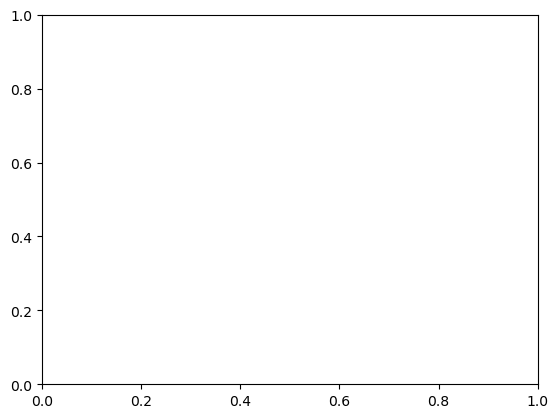

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        # Increase the size of the first hidden layer
        self.fc1 = nn.Linear(state_size, 128)
        # Add a second hidden layer
        self.fc2 = nn.Linear(128, 128)
        # Add a third hidden layer
        self.fc3 = nn.Linear(128, 64)
        # Output layer
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, x):
        # Apply activation function after each layer except the output layer
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function after the output layer
        return x
    
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU availability
        self.q_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Define the learning rate scheduler parameters
        scheduler_step_size = 100  # Define how often to update the learning rate
        scheduler_gamma = 0.9      # Define the decay rate of the learning rate

        # Initialize the learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.q_network(state)
        return q_values.argmax().item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(np.array(states)).to(self.device)  # Convert to single numpy ndarray
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)  # Convert to single numpy ndarray
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states)
        q_values_next = self.target_network(next_states).max(1)[0].unsqueeze(1)
        q_targets = rewards + (1 - dones) * self.gamma * q_values_next

        loss = self.criterion(q_values.gather(1, actions.unsqueeze(1)), q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Assuming your environment is named 'BallSortCraneEnv'
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.q_network.load_state_dict(torch.load('dqn_model.pth'))  # Load the trained model

EPISODES = 5000000  # or your preferred number of episodes
MAX_STEPS = 150  # or your preferred steps per episode
batch_size = 16  # or your preferred batch size
total_rewards = []
average_losses = []

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0

    for time in range(MAX_STEPS):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        # Perform the replay
        agent.replay(batch_size)

        # Update target network periodically
        if time % 20 == 0:
            agent.update_target_network()

    total_rewards.append(total_reward)
    agent.decay_epsilon()  # Decay exploration rate over time
    print(f"Episode: {e+1}/{EPISODES}, Total Reward: {total_reward}")
    
    # Check if it's time to save the model
    if (e + 1) % 100 == 0:
        # Save the Q-network state_dict to a file
        torch.save(agent.q_network.state_dict(), f'dqn_model.pth')
        print(f"Saved model at episode {e + 1}")
        
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()


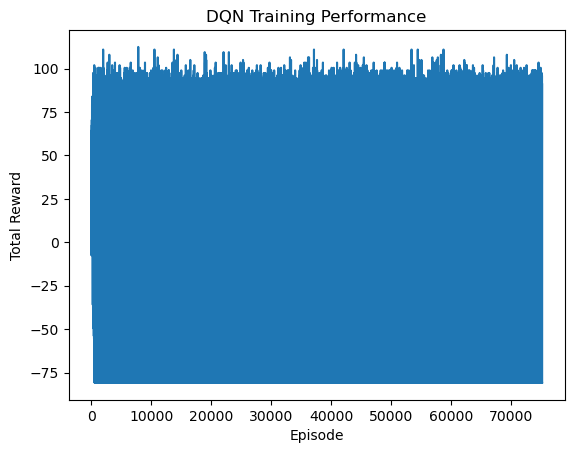

In [40]:
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()